In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from os import listdir
import glob
import pretty_midi
import librosa

import midi_manipulation

In [2]:
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = []
    for f in files:
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            if np.array(song).shape[0] > 50:
                songs.append(song)
        except Exception as e:
            raise e           
    return songs

In [3]:
def get_chromas(songs):
    chromas = []
    for song in songs: 
        chroma = np.zeros(shape=(np.shape(song)[0], 12))
        for i in range(np.shape(song)[0]):
            for j in range(78):
                if song[i][j] == 1:
                    chroma[i][np.mod(j,12)] += 1
        chromas.append(chroma)
                
    return chromas

In [4]:
songs = get_songs('Pop_Music_Midi')
chromas = get_chromas(songs)
print ("{} songs processed".format(len(songs)))
print ("{} songs processed".format(len(chromas)))

122 songs processed
122 songs processed


In [5]:
print(np.shape(chromas[1]))

(385, 12)


In [6]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 4 #This is the number of timesteps that we will create at a time
X_dim = 2*note_range*num_timesteps #This is the size of the visible layer. 
Z_dim = 12*num_timesteps
n_hidden = 50 #This is the size of the hidden layer

print(X_dim,Z_dim)

624 48


In [7]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [8]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

# D_W1 = tf.Variable(xavier_init([784, 999]))
D_W1 = tf.Variable(xavier_init([X_dim+Z_dim, 512]))
D_b1 = tf.Variable(tf.zeros(shape=[512]))

D_W2 = tf.Variable(xavier_init([512, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

In [9]:
# set Z
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [10]:
# def sample_Z(m, n):
#     return np.random.uniform(-1., 1., size=[m, n])

In [11]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [12]:
def discriminator(x,c):
    D_h1 = tf.nn.relu(tf.matmul(tf.concat([x,c],1), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [13]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
#         plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        plt.imshow(sample.reshape(78, 30), cmap='Greys_r')


    return fig

In [14]:
print (np.shape(Z))

(?, 48)


In [15]:
G_sample = generator(Z)

In [16]:
print(note_range)

78


In [17]:
D_real, D_logit_real = discriminator(X,Z)

In [18]:
D_fake, D_logit_fake = discriminator(G_sample,Z)

In [19]:
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_loss_L1 = tf.reduce_mean(tf.losses.mean_squared_error(X,G_sample))
G_loss = G_loss_fake + 100*G_loss_L1

In [20]:
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [21]:
if not os.path.exists('out/'):
    os.makedirs('out/')

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [23]:
# for song in songs:
#         # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
#         # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
#         song = np.array(song)
#         song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
#         song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
#         # Train the RBM on batch_size examples at a time

In [24]:
# i = 0

In [25]:
print(chromas[0].shape[0], chromas[0].shape[1])
print(songs[0].shape[0], songs[0].shape[1])

257 12
257 156


Iter: 0
D_Loss: 1.016
G_Loss: 33.89


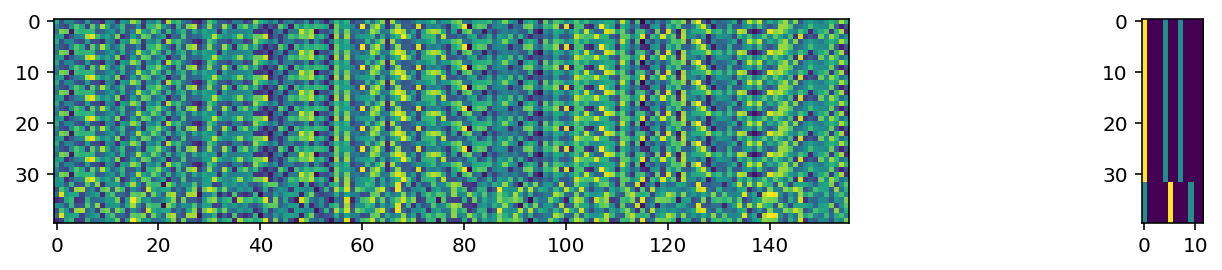

Iter: 1000
D_Loss: 0.03464
G_Loss: 10.8


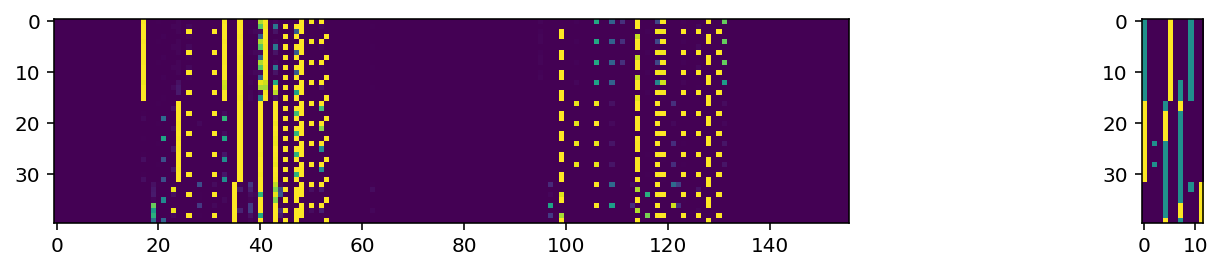

Iter: 2000
D_Loss: 1.096
G_Loss: 1.851


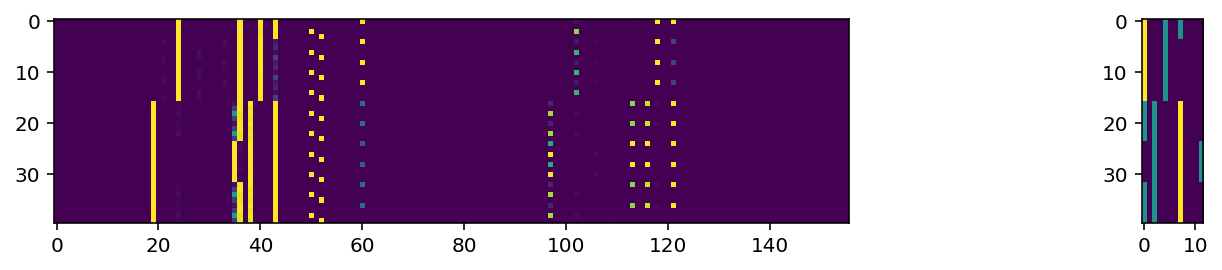

Iter: 3000
D_Loss: 0.0006428
G_Loss: 13.5


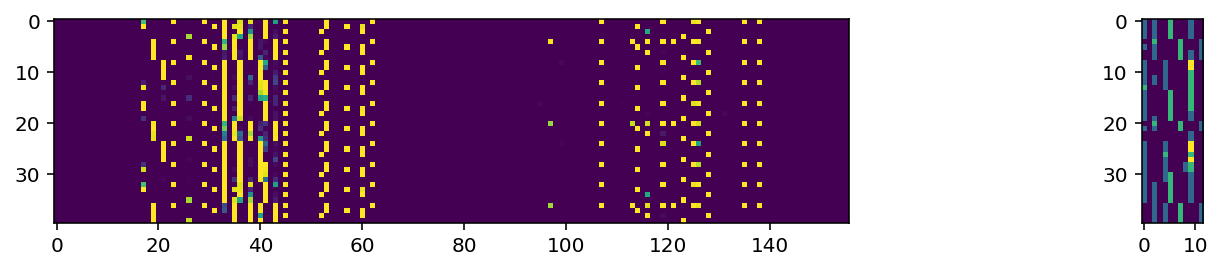

Iter: 4000
D_Loss: 0.01801
G_Loss: 6.801


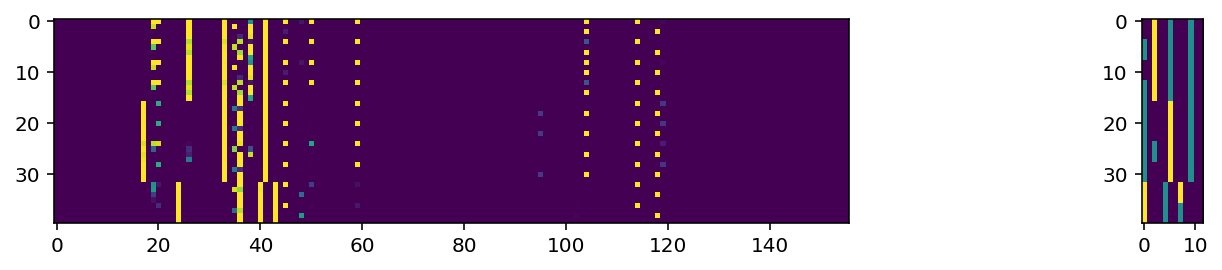

Iter: 5000
D_Loss: 0.002042
G_Loss: 8.946


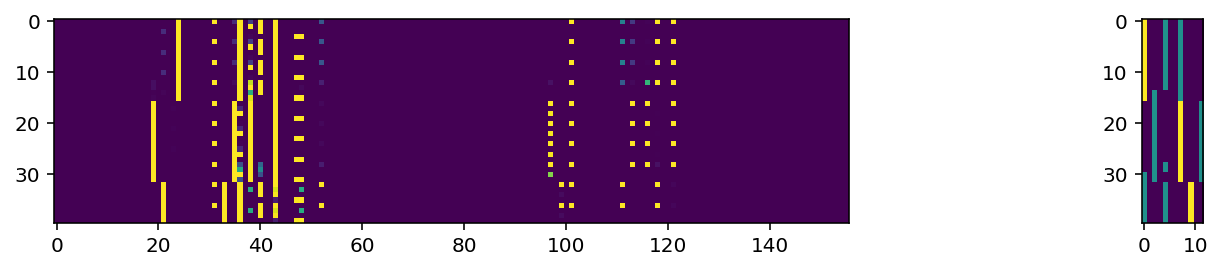

Iter: 6000
D_Loss: 0.01384
G_Loss: 6.871


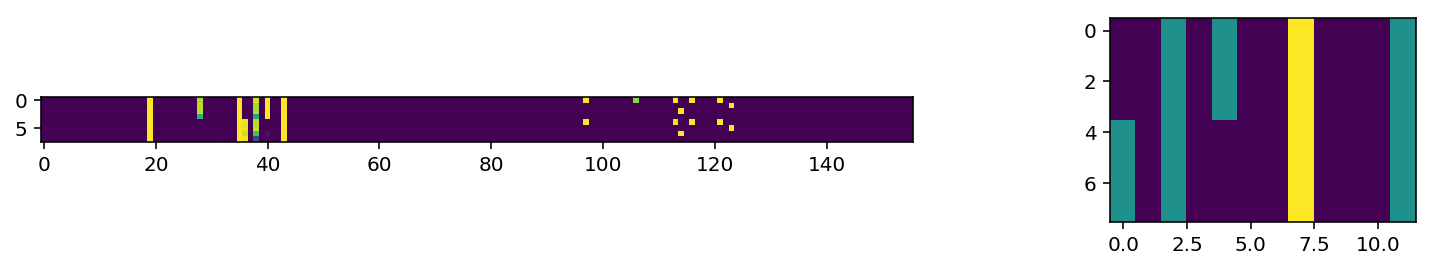

Iter: 7000
D_Loss: 2.208e-05
G_Loss: 18.22


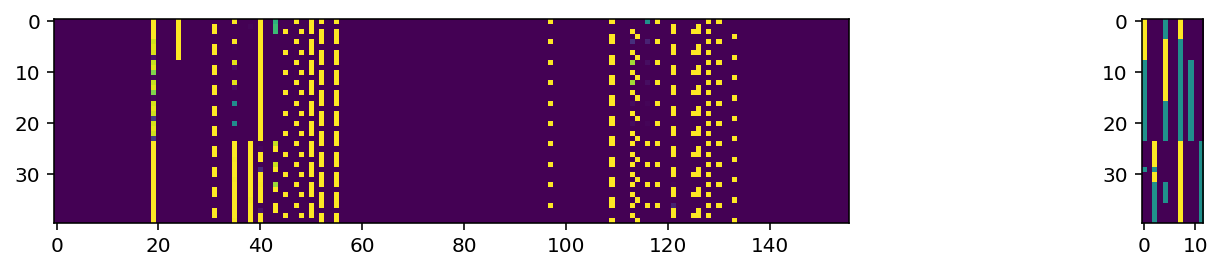

Iter: 8000
D_Loss: 0.02649
G_Loss: 8.88


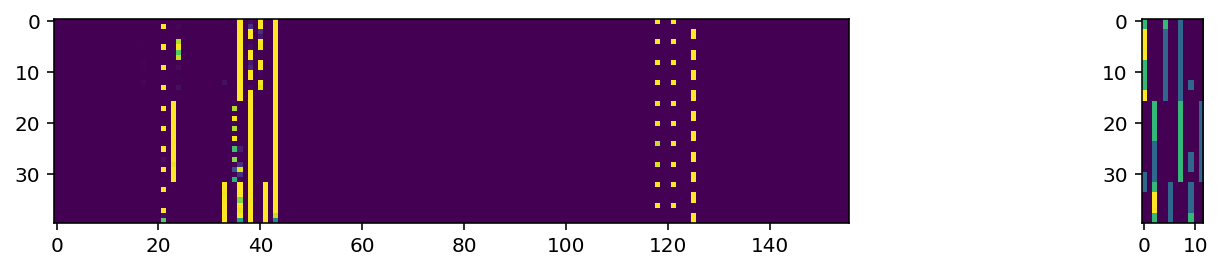

Iter: 9000
D_Loss: 0.0064
G_Loss: 8.379


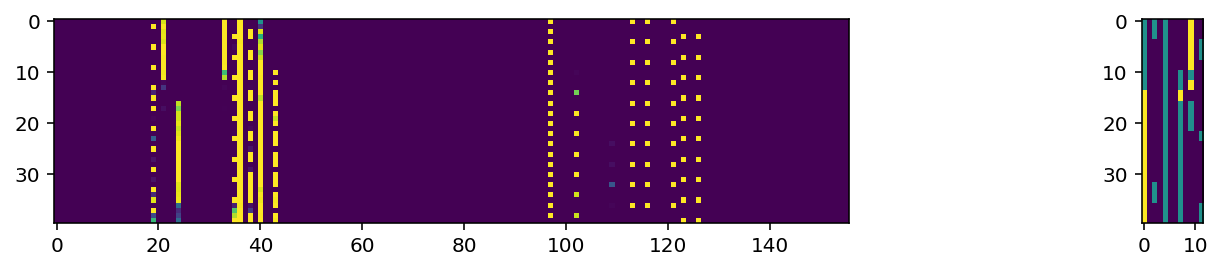

Iter: 10000
D_Loss: 0.0009107
G_Loss: 14.62


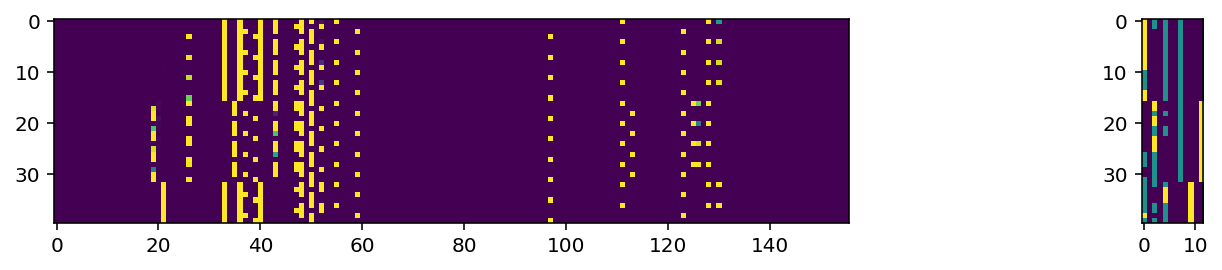

Iter: 11000
D_Loss: 0.141
G_Loss: 13.49


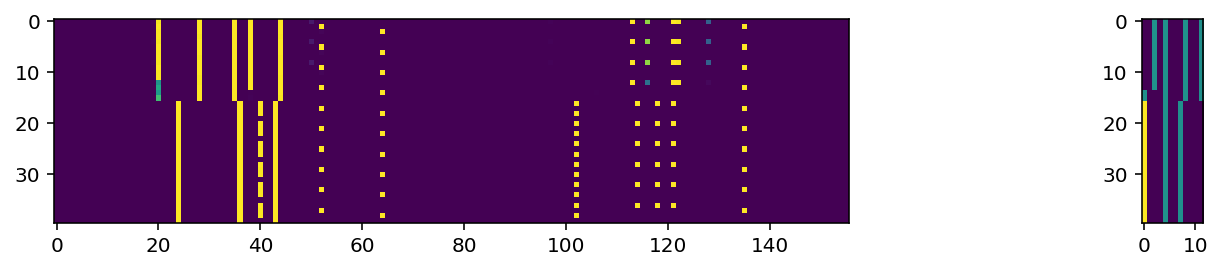

Iter: 12000
D_Loss: 6.619e-08
G_Loss: 24.66


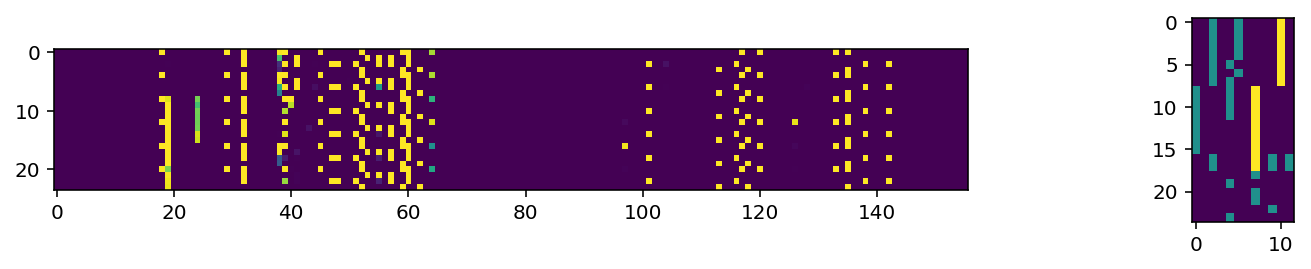

Iter: 13000
D_Loss: 6.282e-07
G_Loss: 24.81


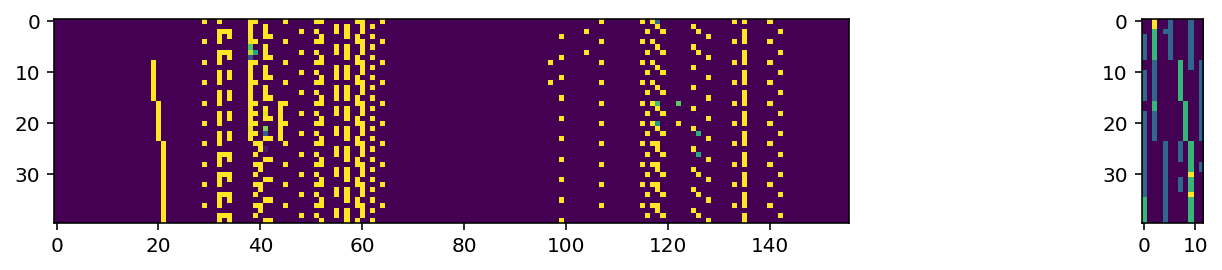

Iter: 14000
D_Loss: 3.029e-06
G_Loss: 23.28


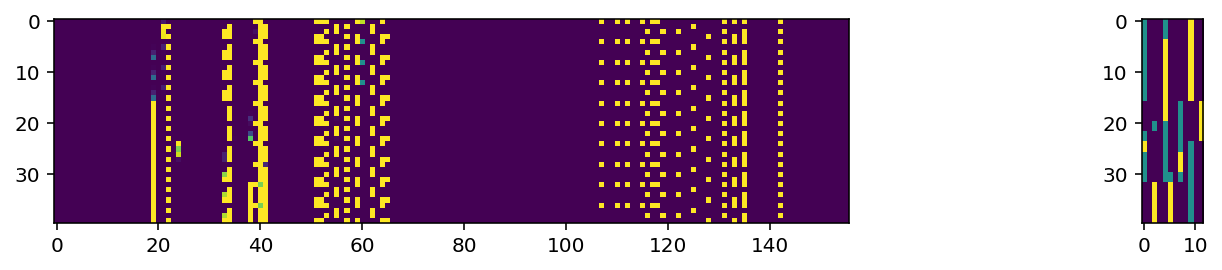

Iter: 15000
D_Loss: 1.294e-08
G_Loss: 28.91


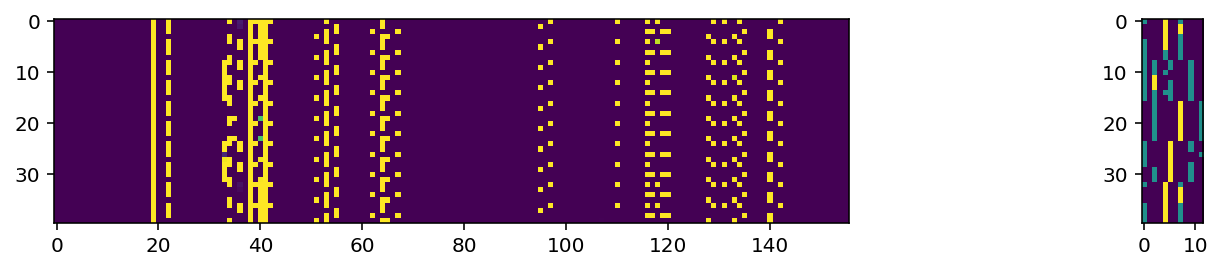

Iter: 16000
D_Loss: 1.875e-06
G_Loss: 18.98


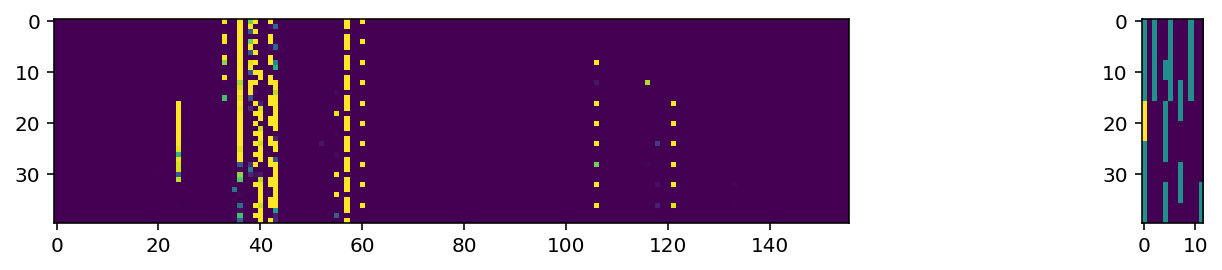

Iter: 17000
D_Loss: 0.0002102
G_Loss: 14.81


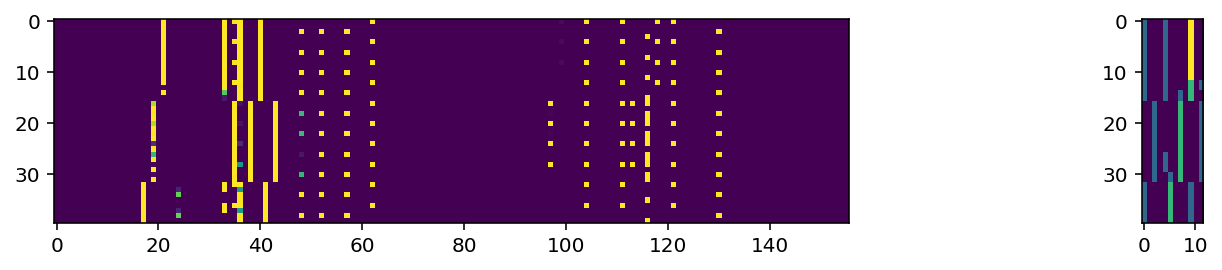

Iter: 18000
D_Loss: 0.0001731
G_Loss: 15.94


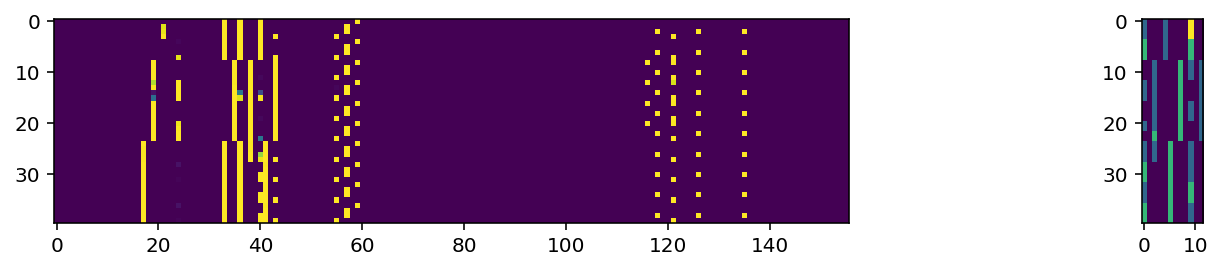

Iter: 19000
D_Loss: 6.383e-07
G_Loss: 17.83


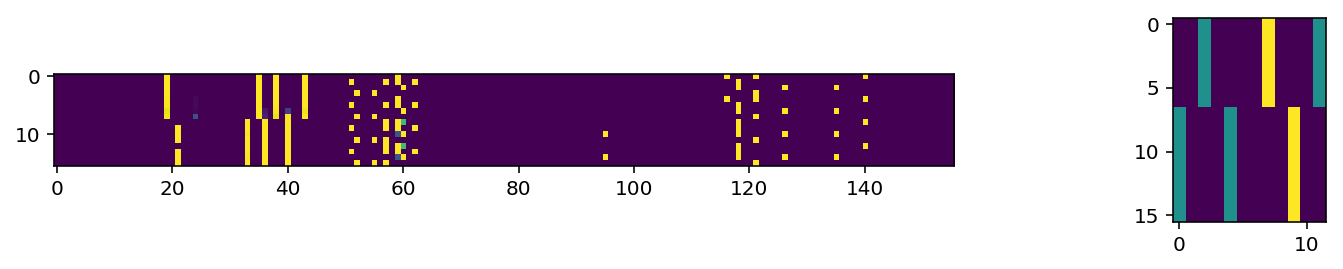

Iter: 20000
D_Loss: 1.781e-05
G_Loss: 18.48


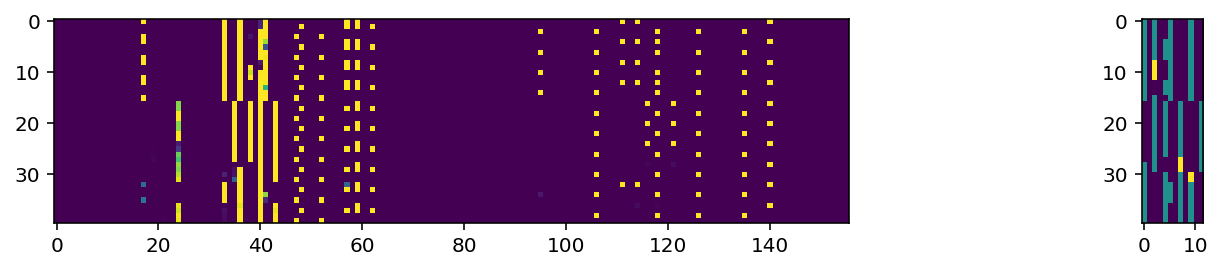

Iter: 21000
D_Loss: 3.113e-06
G_Loss: 19.69


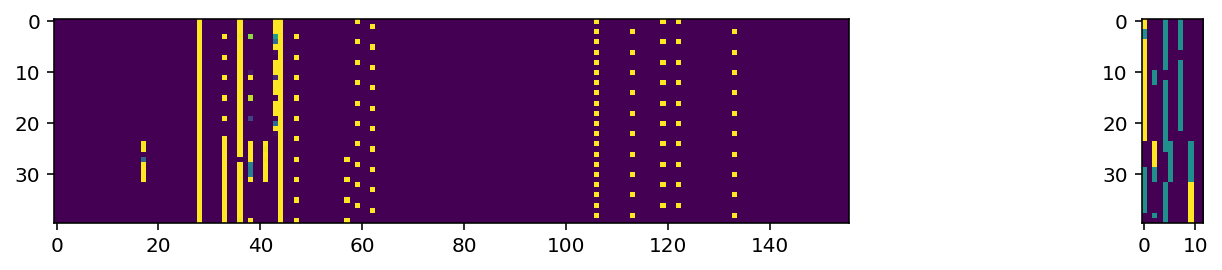

Iter: 22000
D_Loss: 7.792e-10
G_Loss: 26.06


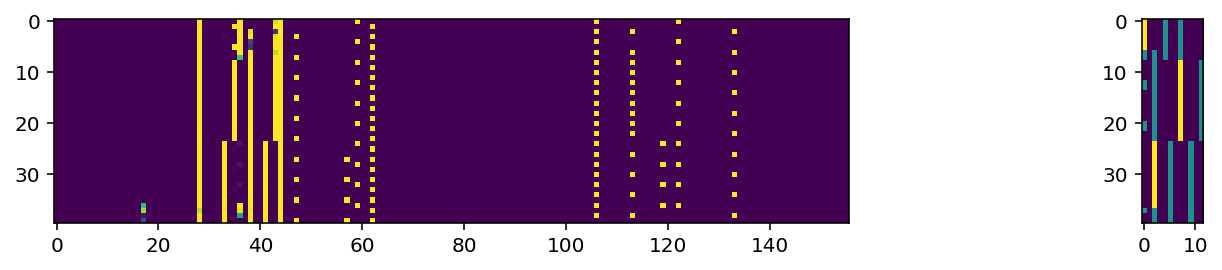

Iter: 23000
D_Loss: 3.97e-09
G_Loss: 24.8


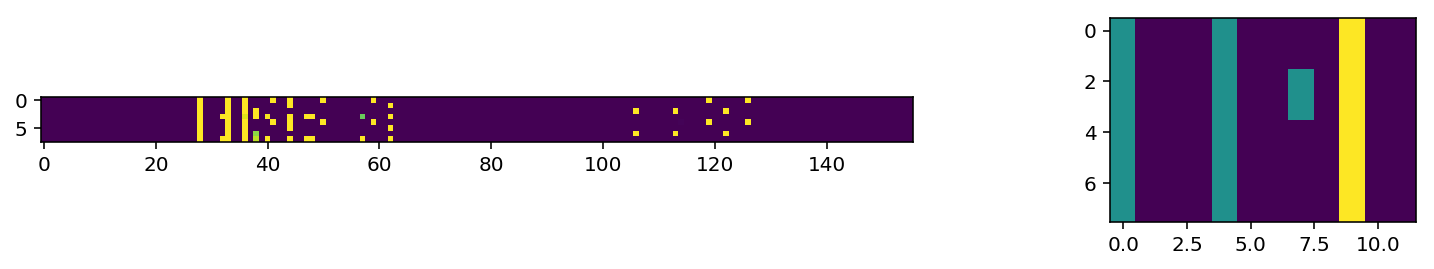

Iter: 24000
D_Loss: 7.423e-08
G_Loss: 21.54


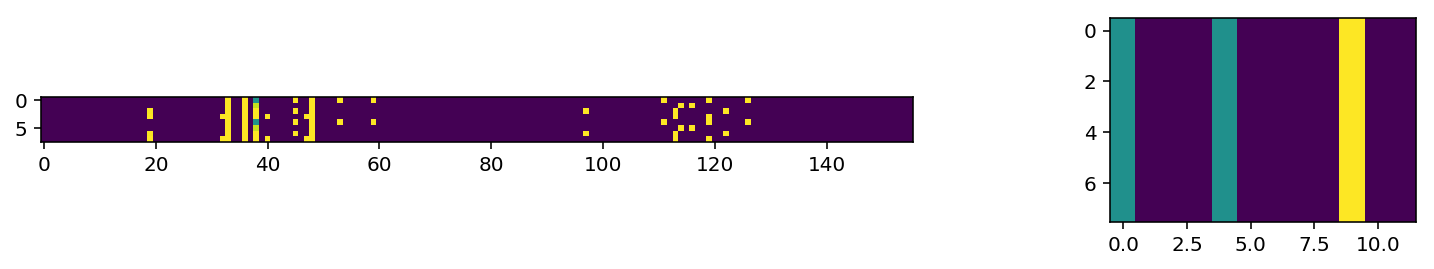

Iter: 25000
D_Loss: 8.181e-10
G_Loss: 30.32


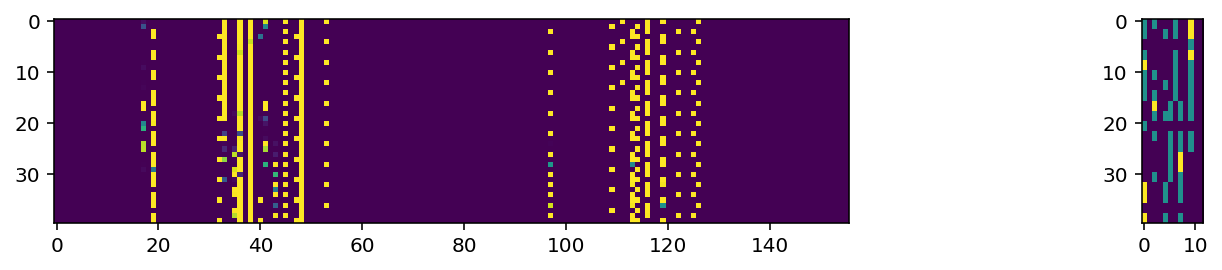

Iter: 26000
D_Loss: 1.761e-08
G_Loss: 24.79


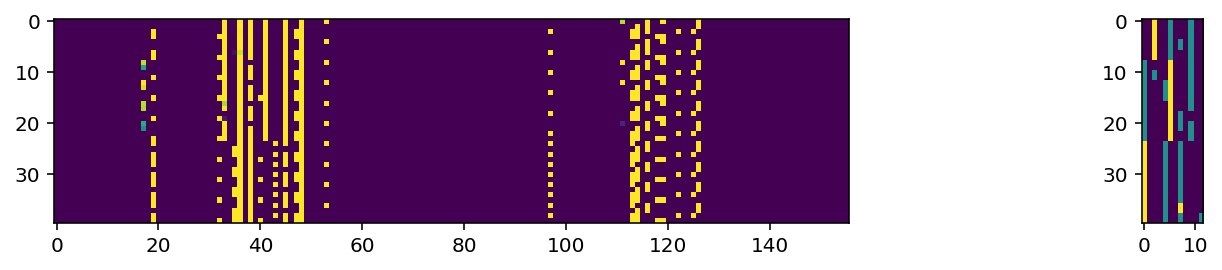

Iter: 27000
D_Loss: 1.006e-09
G_Loss: 28.51


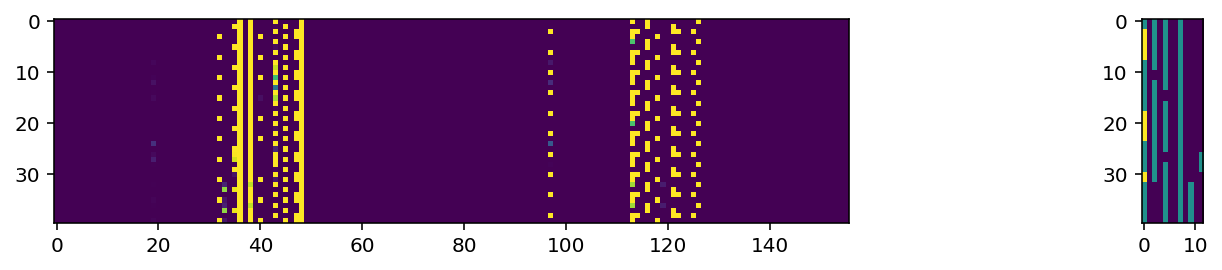

Iter: 28000
D_Loss: 8.761e-07
G_Loss: 20.23


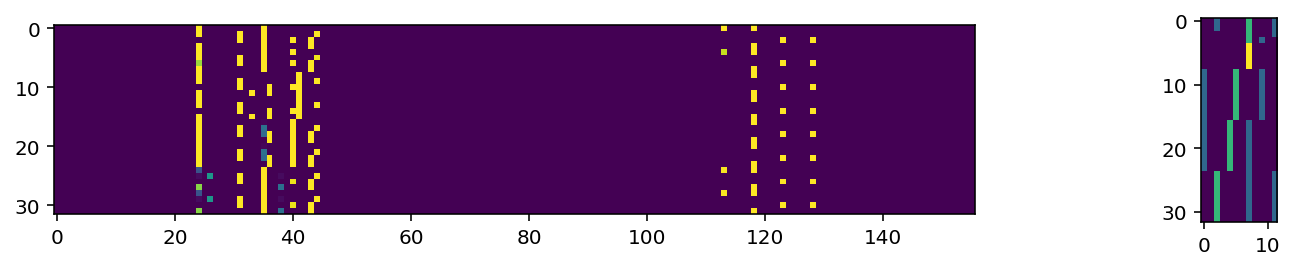

Iter: 29000
D_Loss: 1.162e-06
G_Loss: 18.38


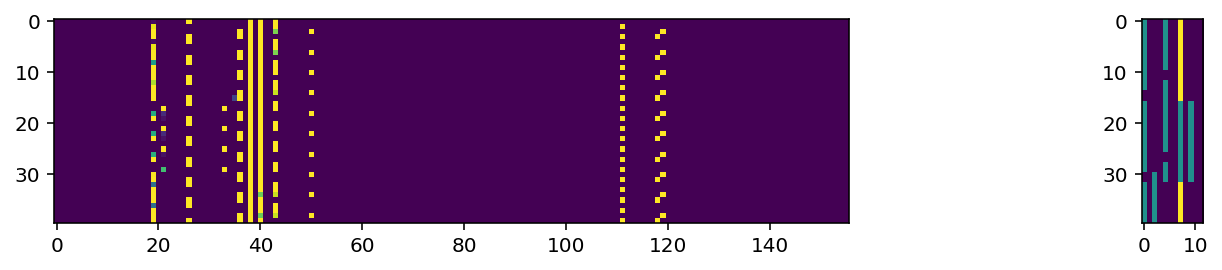

Iter: 30000
D_Loss: 9.95e-07
G_Loss: 19.98


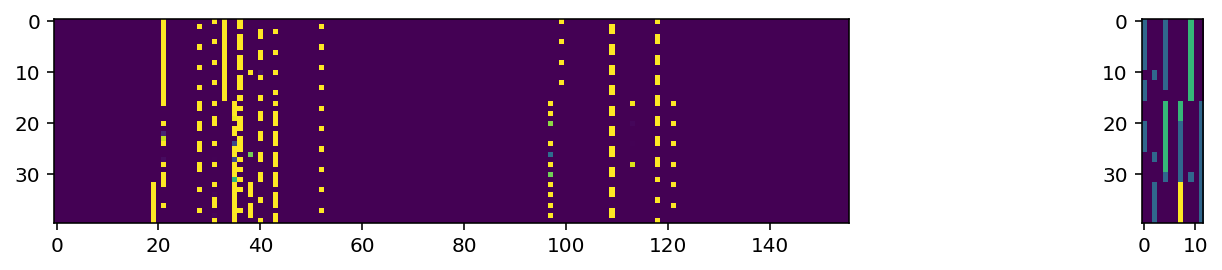

Iter: 31000
D_Loss: 8.89e-08
G_Loss: 21.31


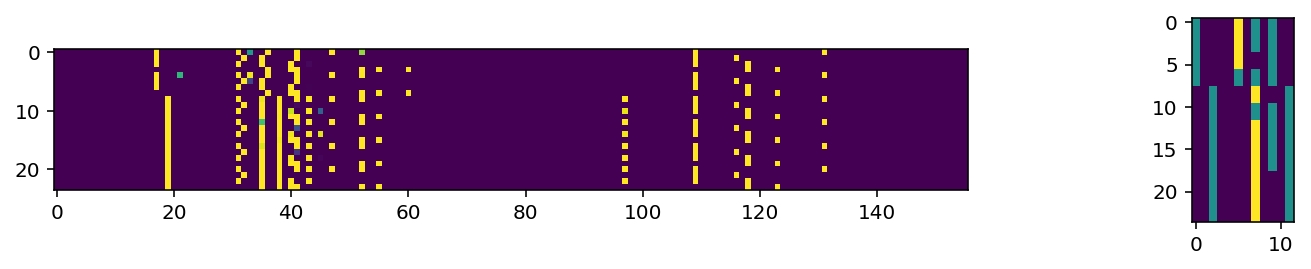

Iter: 32000
D_Loss: 4.193e-08
G_Loss: 22.45


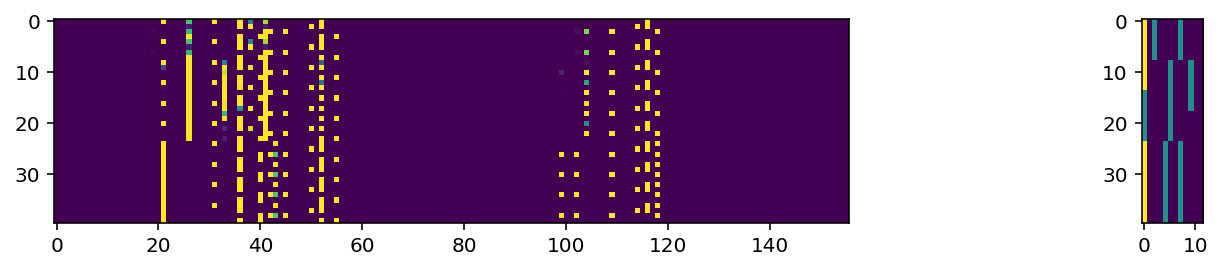

Iter: 33000
D_Loss: 7.91e-08
G_Loss: 22.33


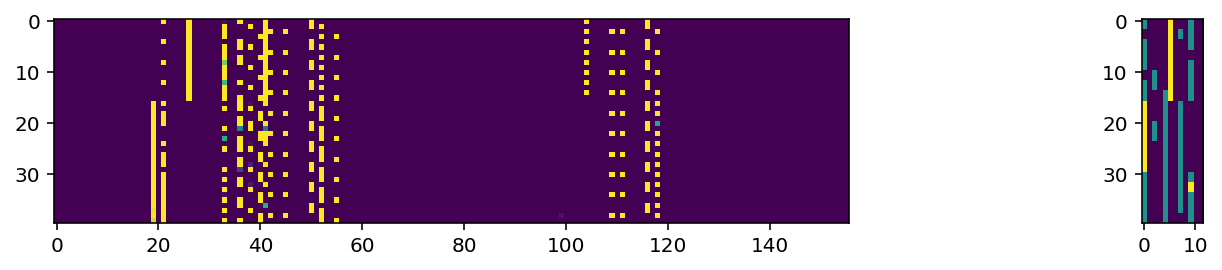

Iter: 34000
D_Loss: 2.094e-10
G_Loss: 28.84


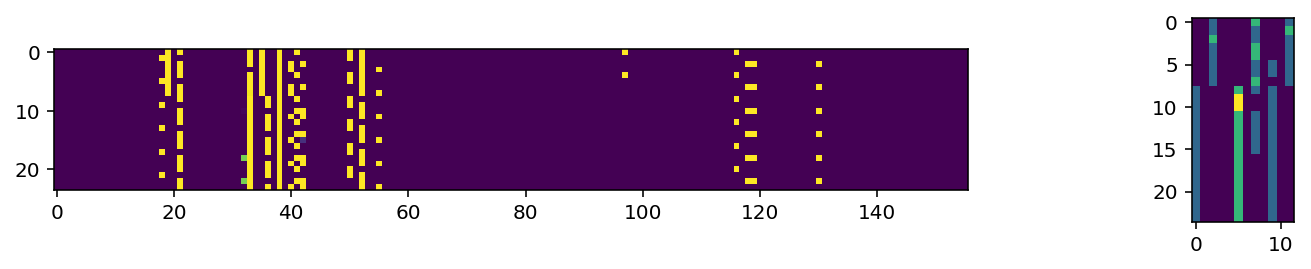

Iter: 35000
D_Loss: 6.215e-08
G_Loss: 24.55


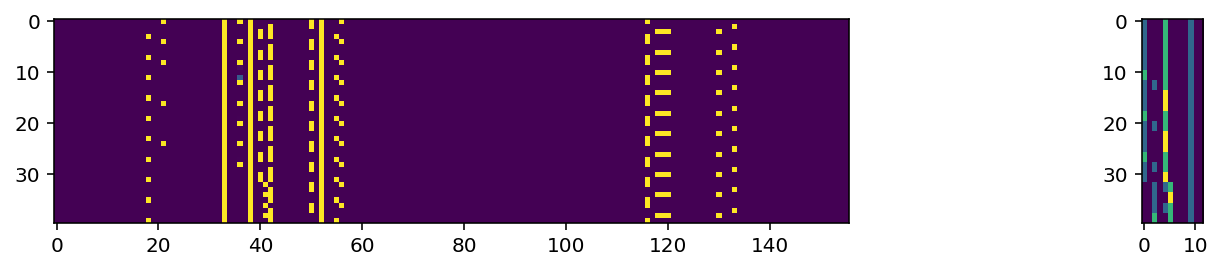

Iter: 36000
D_Loss: 1.767e-08
G_Loss: 24.01


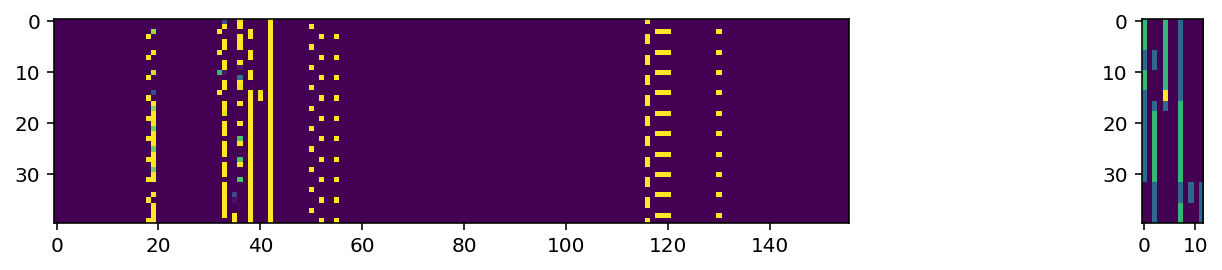

Iter: 37000
D_Loss: 1.165e-07
G_Loss: 23.7


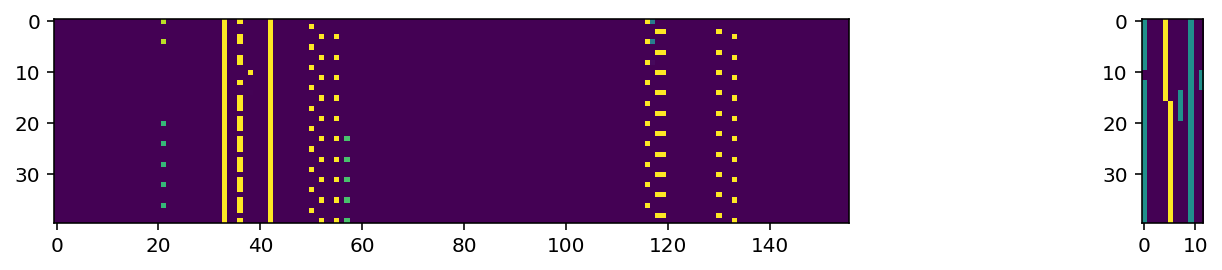

Iter: 38000
D_Loss: 6.688e-07
G_Loss: 19.82


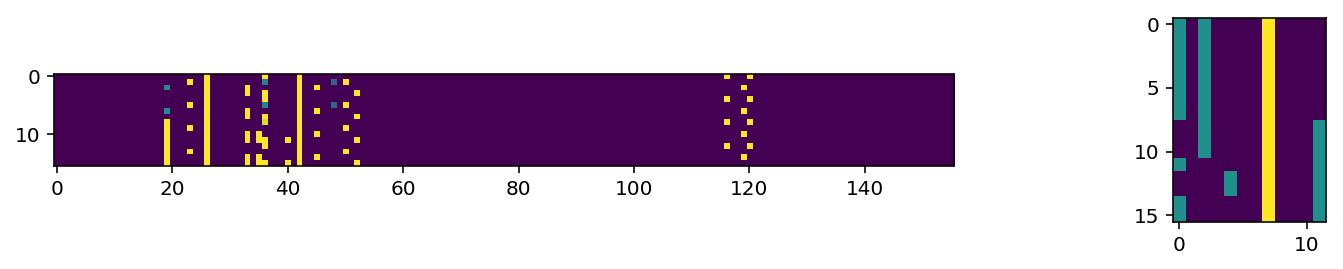

Iter: 39000
D_Loss: 2.502e-08
G_Loss: 29.32


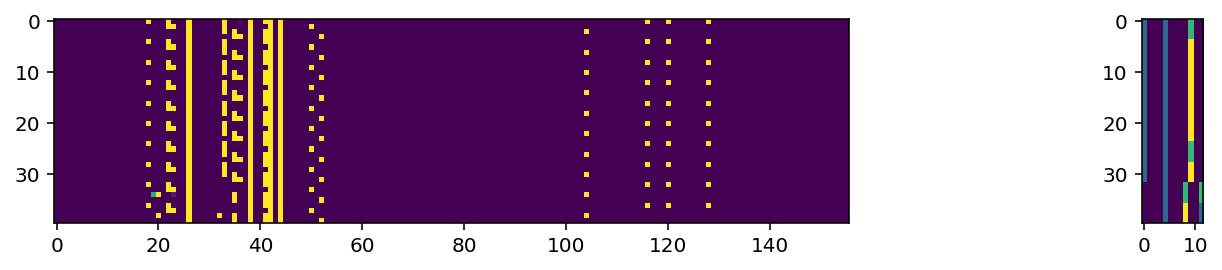

Iter: 40000
D_Loss: 2.643e-11
G_Loss: 35.53


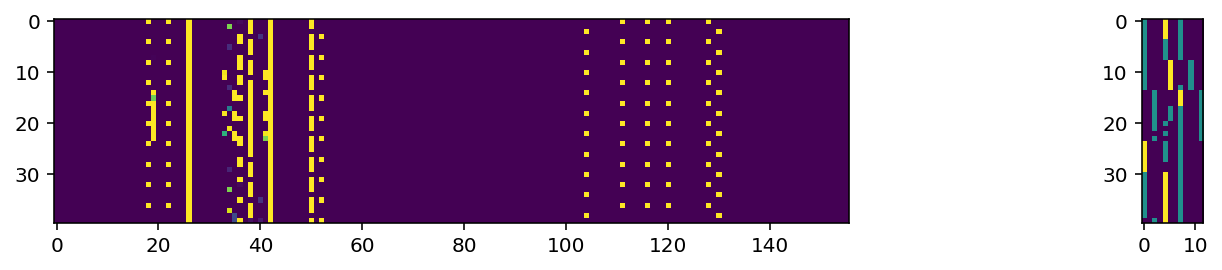

Iter: 41000
D_Loss: 1.213e-17
G_Loss: 48.72


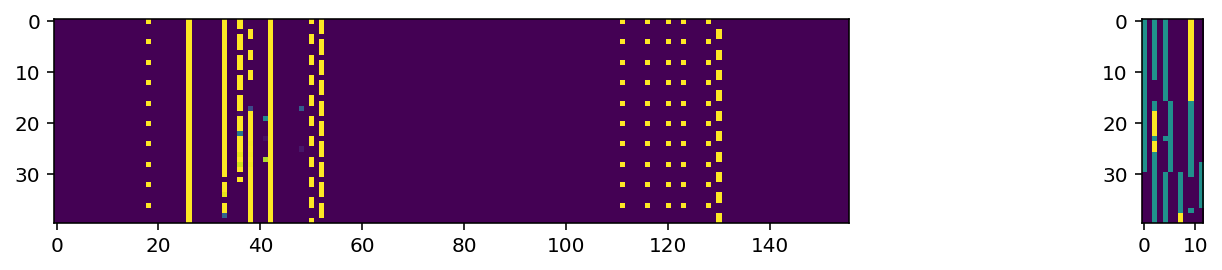

Iter: 42000
D_Loss: 5.333e-14
G_Loss: 48.17


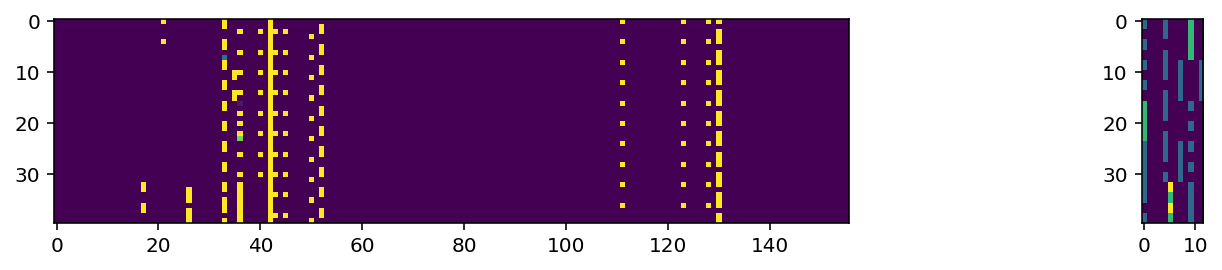

Iter: 43000
D_Loss: 6.477e-13
G_Loss: 43.68


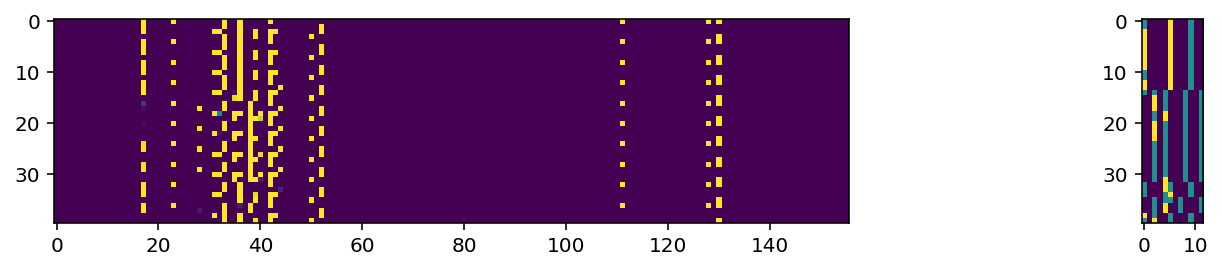

Iter: 44000
D_Loss: 1.855e-15
G_Loss: 42.89


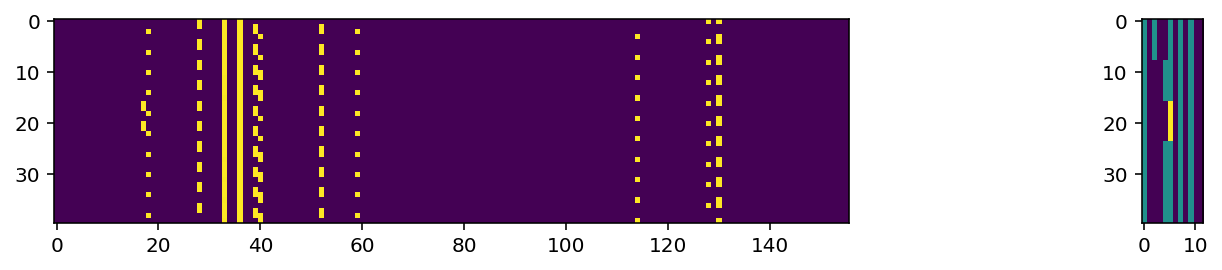

Iter: 45000
D_Loss: 0.0002163
G_Loss: 15.73


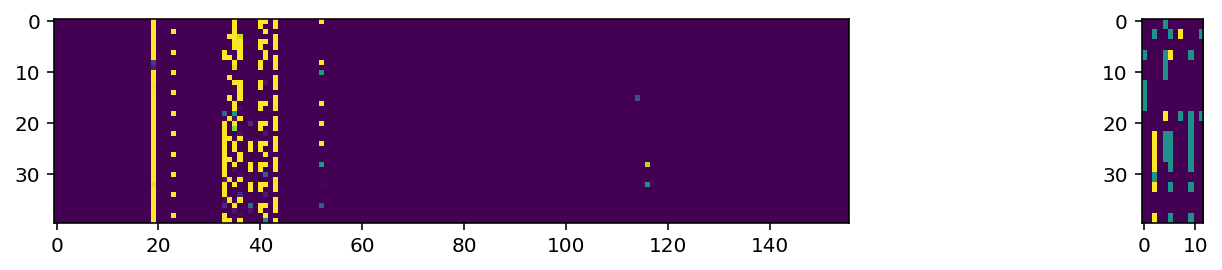

Iter: 46000
D_Loss: 3.272
G_Loss: 24.61


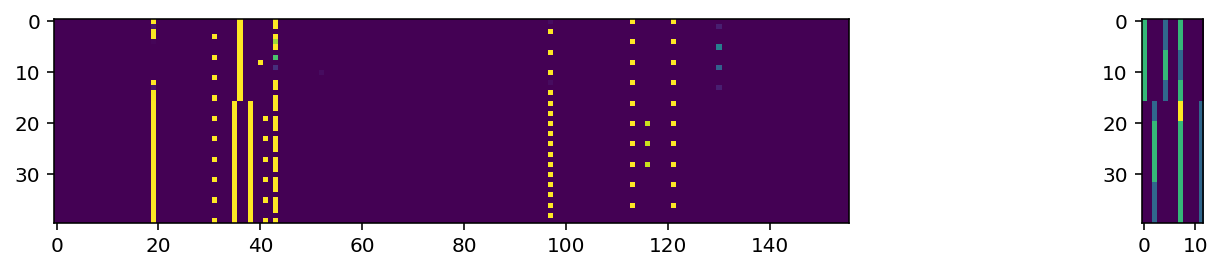

Iter: 47000
D_Loss: 0.0002662
G_Loss: 17.78


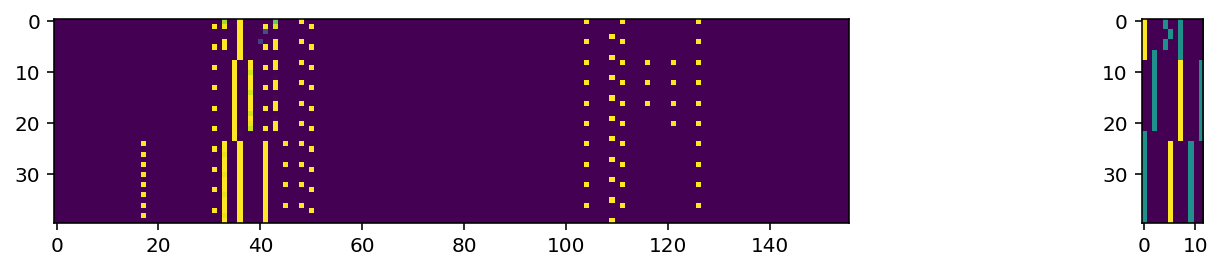

Iter: 48000
D_Loss: 2.411e-06
G_Loss: 22.04


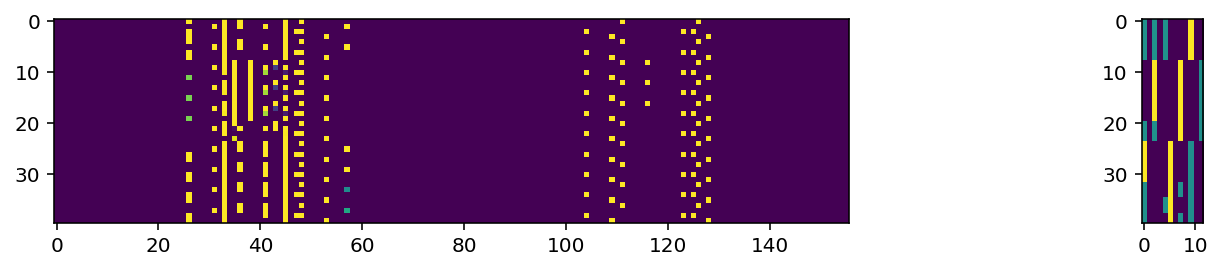

Iter: 49000
D_Loss: 1.152e-05
G_Loss: 18.61


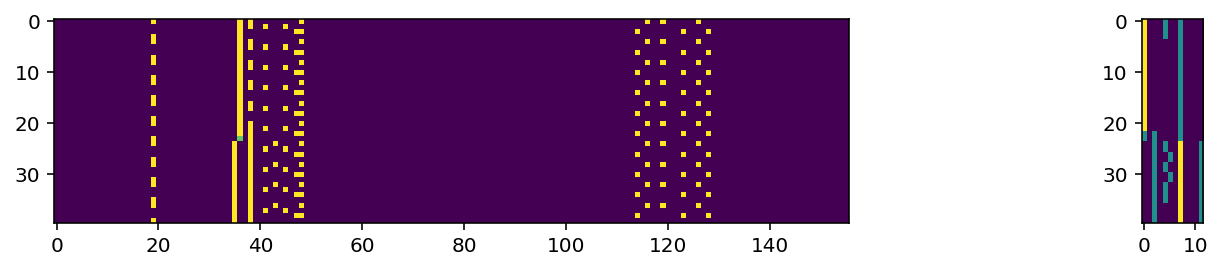

Iter: 50000
D_Loss: 1.68e-10
G_Loss: 35.76


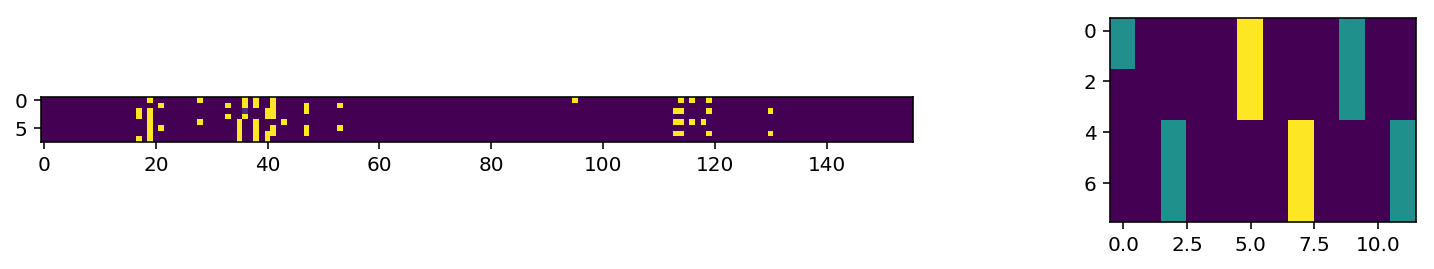

Iter: 51000
D_Loss: 7.771e-07
G_Loss: 31.5


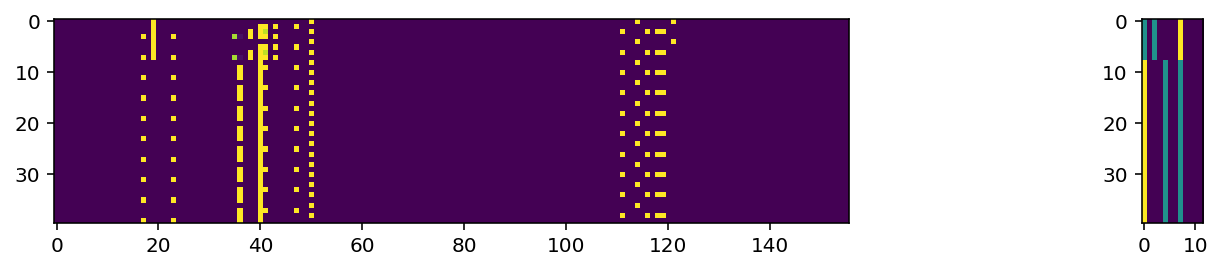

Iter: 52000
D_Loss: 4.305e-10
G_Loss: 27.91


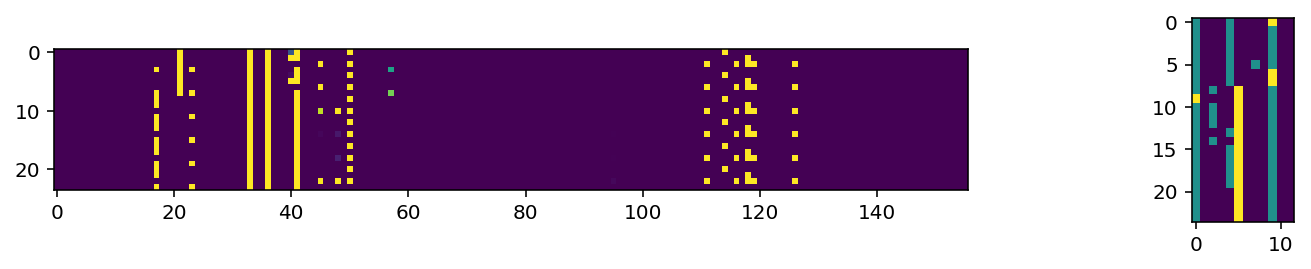

Iter: 53000
D_Loss: 2.664e-06
G_Loss: 21.28


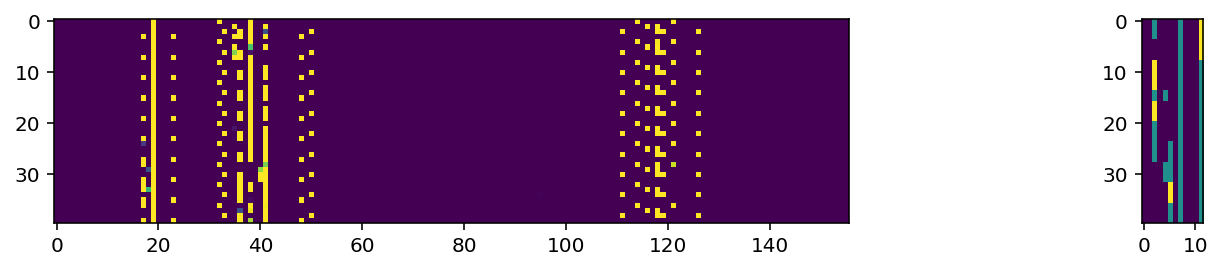

Iter: 54000
D_Loss: 1.178e-10
G_Loss: 30.27


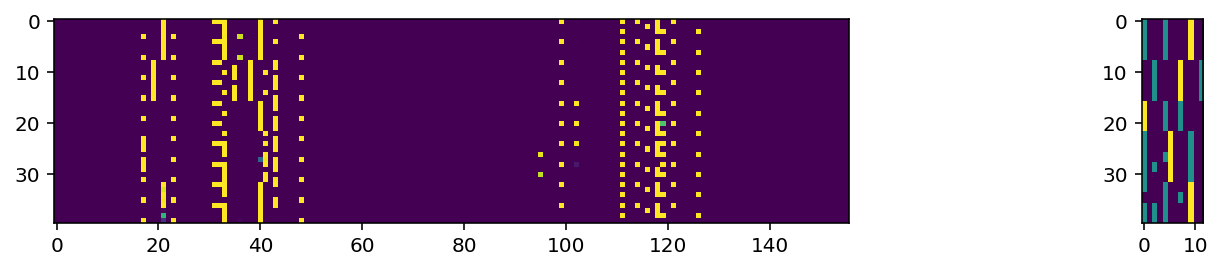

Iter: 55000
D_Loss: 3.716e-09
G_Loss: 36.95


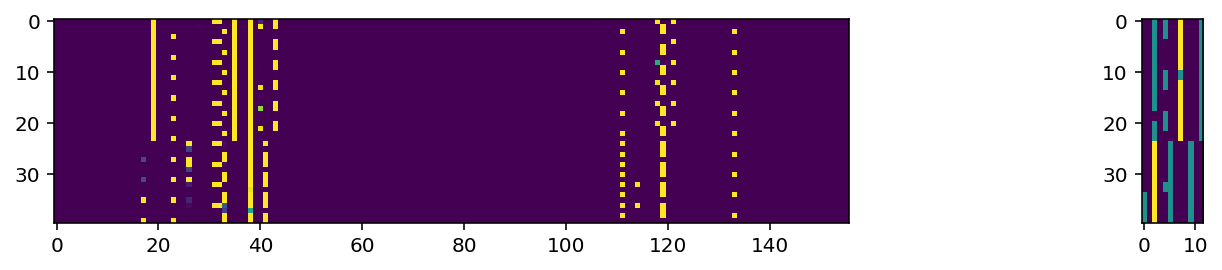

Iter: 56000
D_Loss: 1.821e-13
G_Loss: 34.86


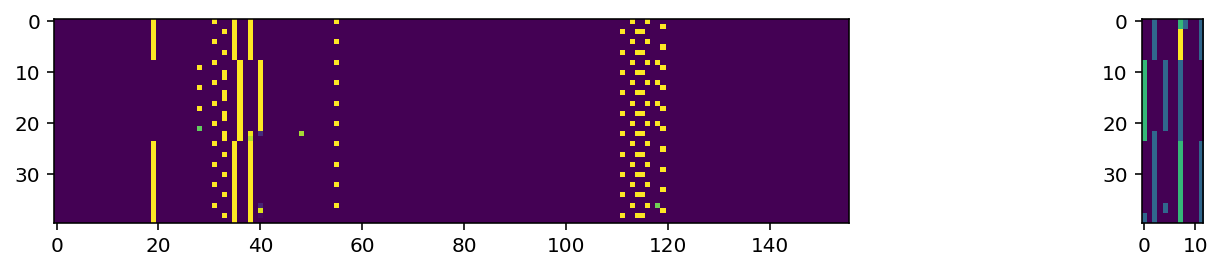

Iter: 57000
D_Loss: 0.005501
G_Loss: 14.49


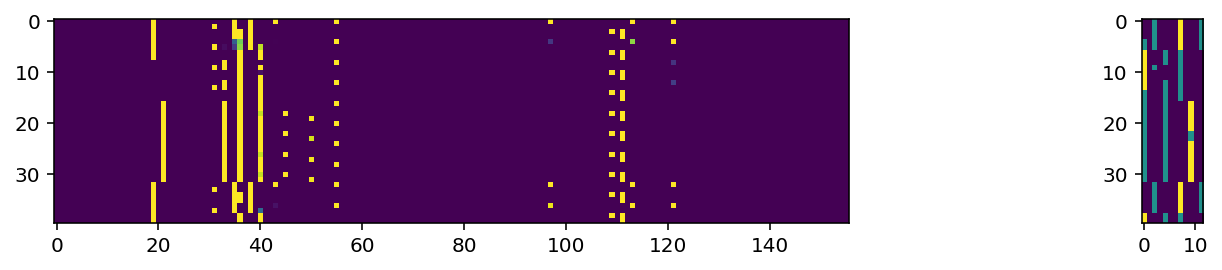

Iter: 58000
D_Loss: 3.883e-06
G_Loss: 19.67


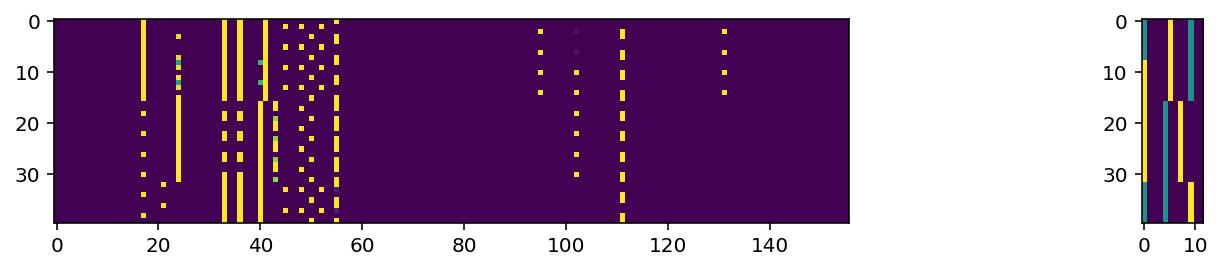

Iter: 59000
D_Loss: 9.817e-10
G_Loss: 33.57


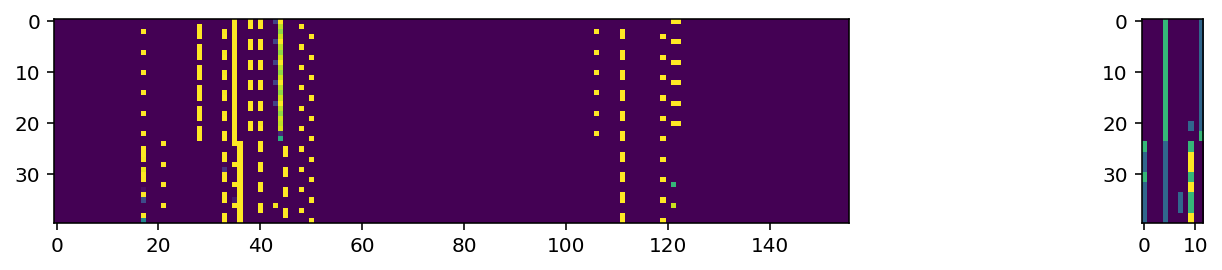

Iter: 60000
D_Loss: 4.37e-05
G_Loss: 26.11


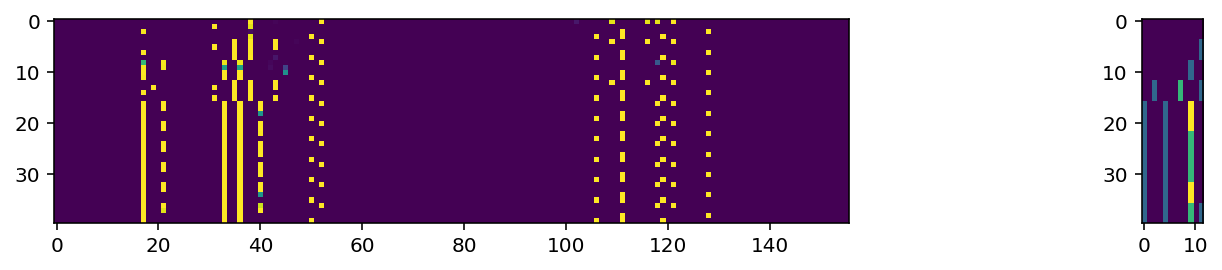

Iter: 61000
D_Loss: 5.334e-08
G_Loss: 20.77


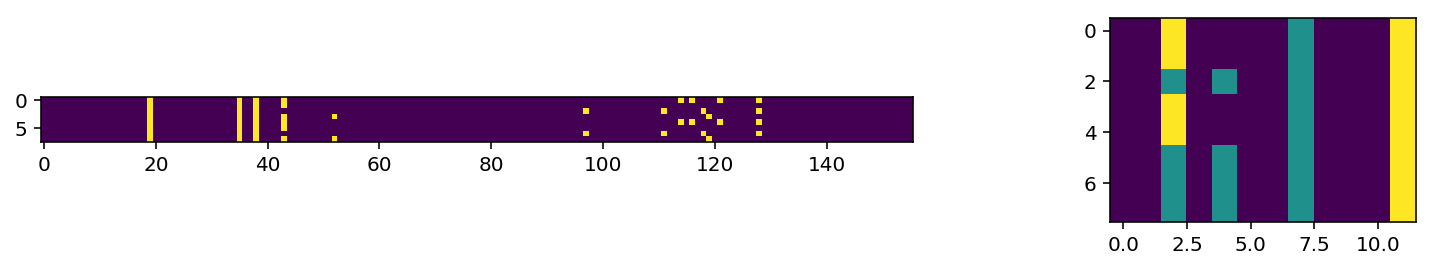

Iter: 62000
D_Loss: 2.787e-08
G_Loss: 22.13


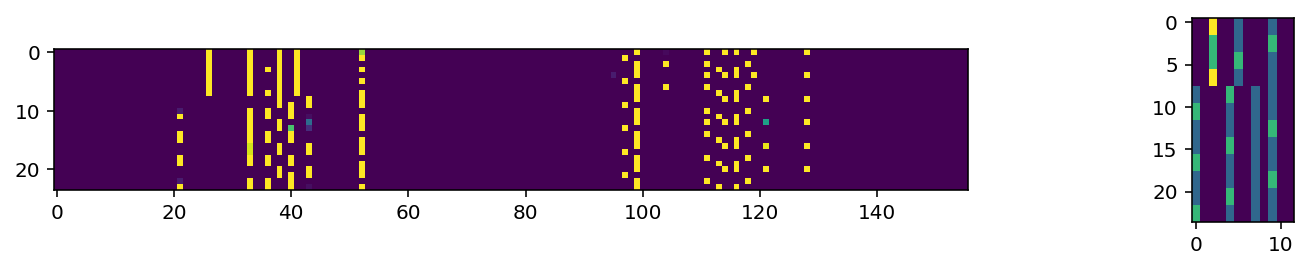

Iter: 63000
D_Loss: 1.316e-08
G_Loss: 25.01


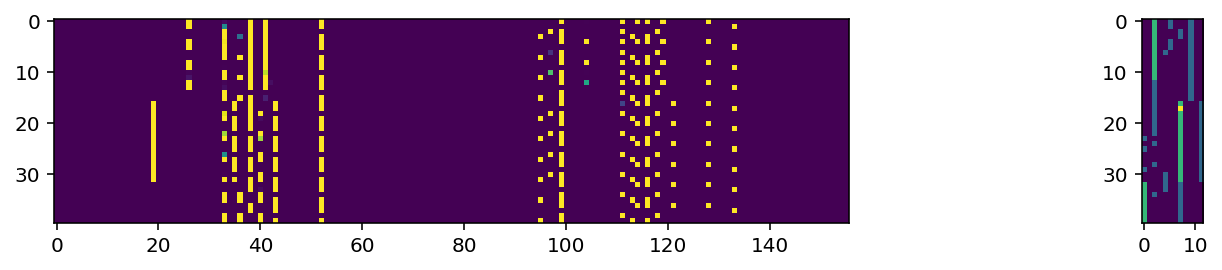

Iter: 64000
D_Loss: 5.804e-10
G_Loss: 26.86


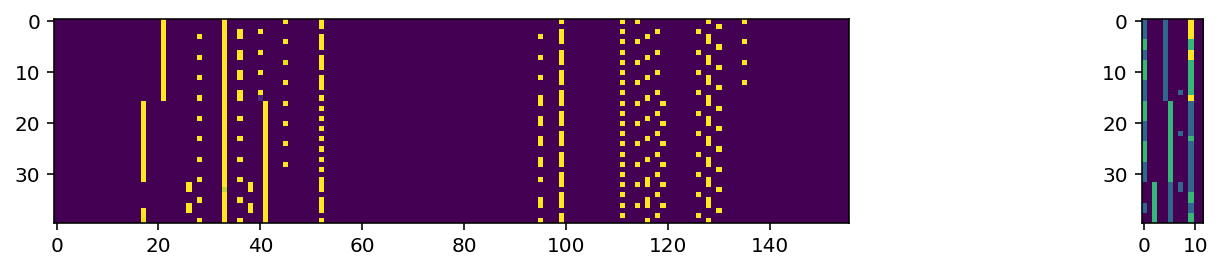

Iter: 65000
D_Loss: 4.696e-08
G_Loss: 25.1


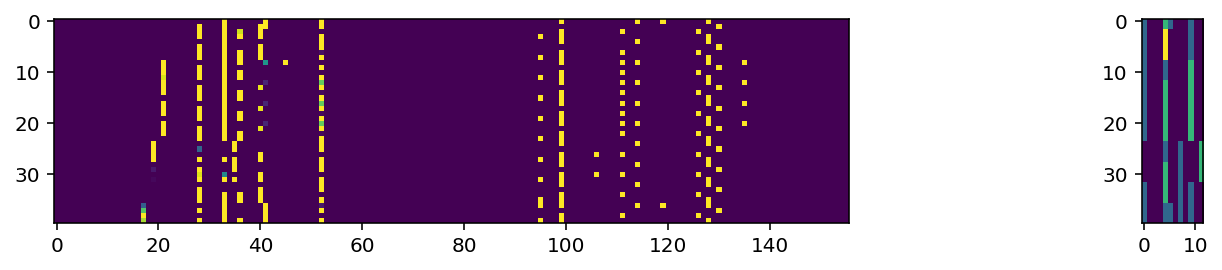

Iter: 66000
D_Loss: 8.832e-09
G_Loss: 25.49


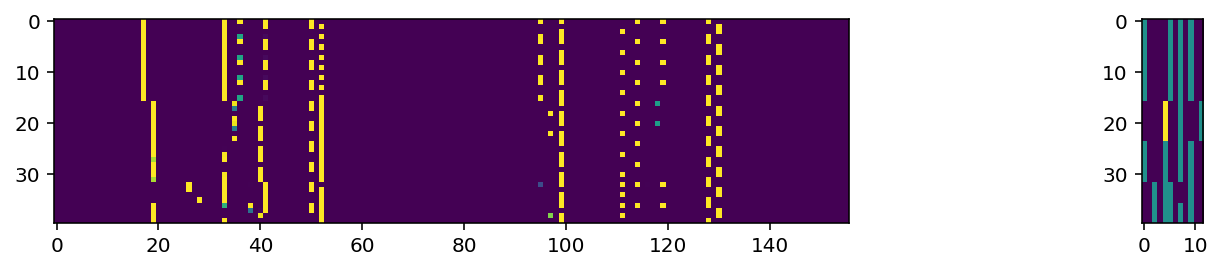

Iter: 67000
D_Loss: 5.532e-09
G_Loss: 27.25


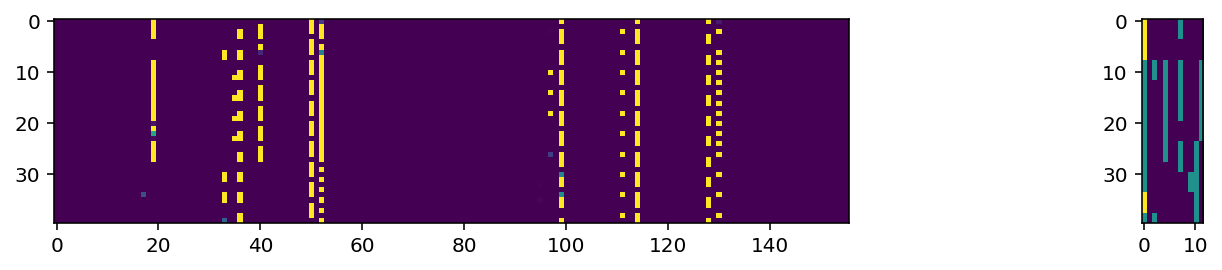

Iter: 68000
D_Loss: 3.368e-09
G_Loss: 29.63


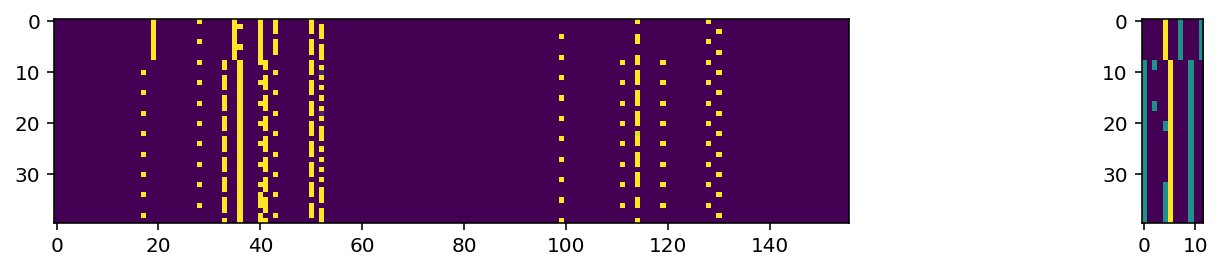

Iter: 69000
D_Loss: 2.258e-16
G_Loss: 44.67


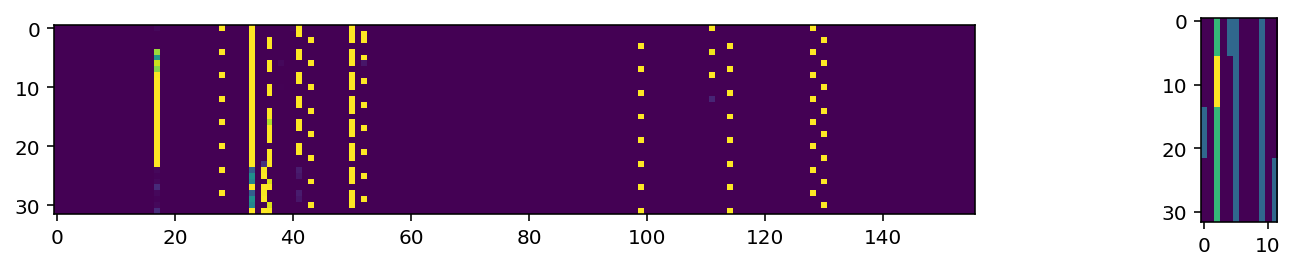

Iter: 70000
D_Loss: 3.192e-09
G_Loss: 31.49


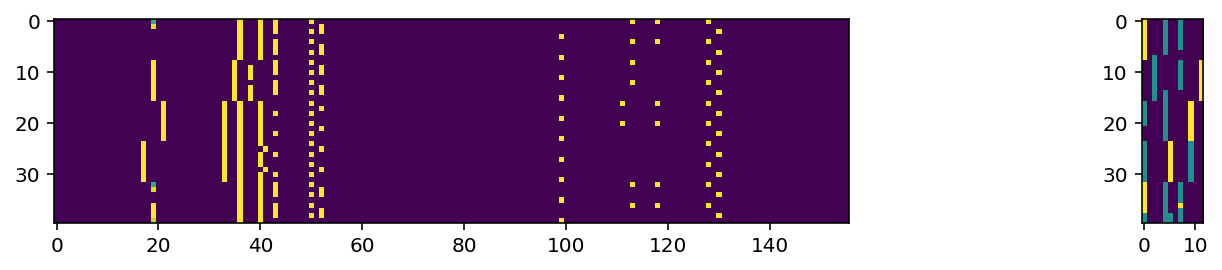

Iter: 71000
D_Loss: 6.183e-10
G_Loss: 30.75


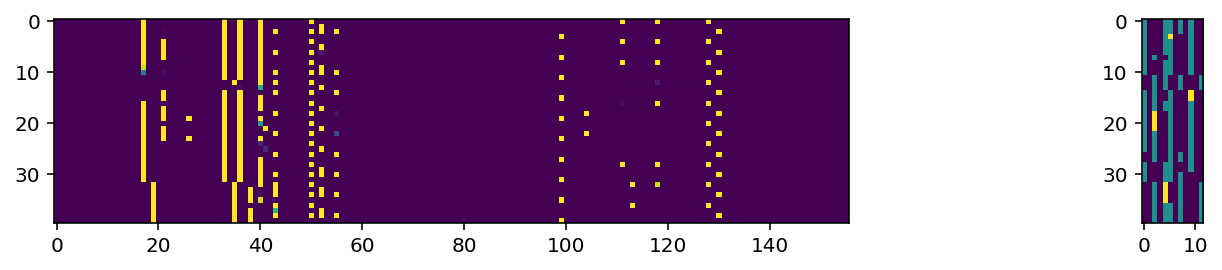

Iter: 72000
D_Loss: 2.337e-09
G_Loss: 27.3


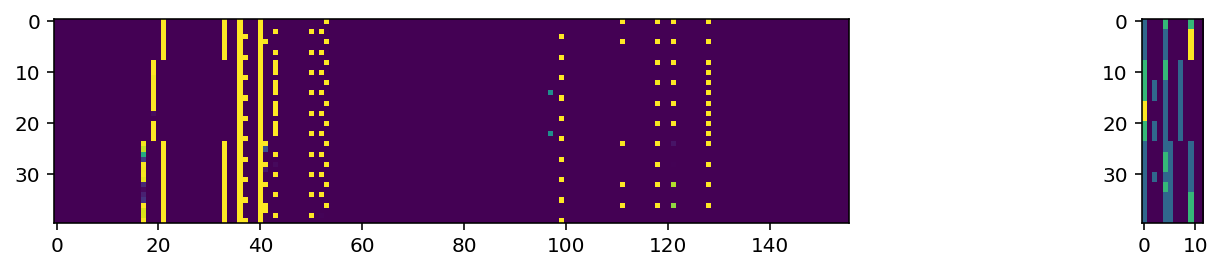

Iter: 73000
D_Loss: 1.005e-05
G_Loss: 19.42


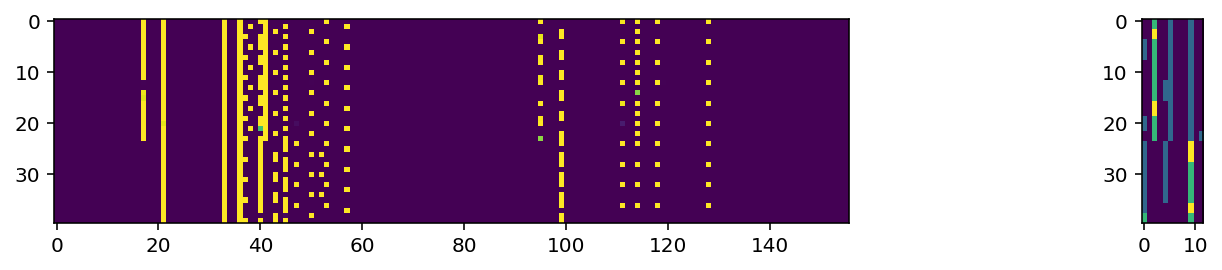

Iter: 74000
D_Loss: 0.0001415
G_Loss: 18.78


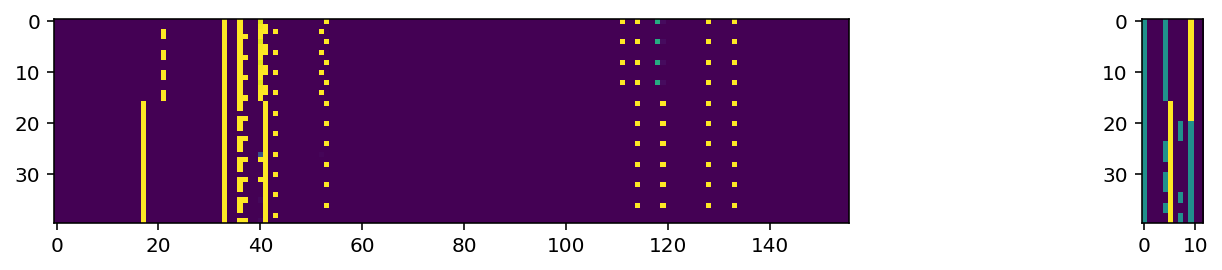

Iter: 75000
D_Loss: 1.988e-06
G_Loss: 33.44


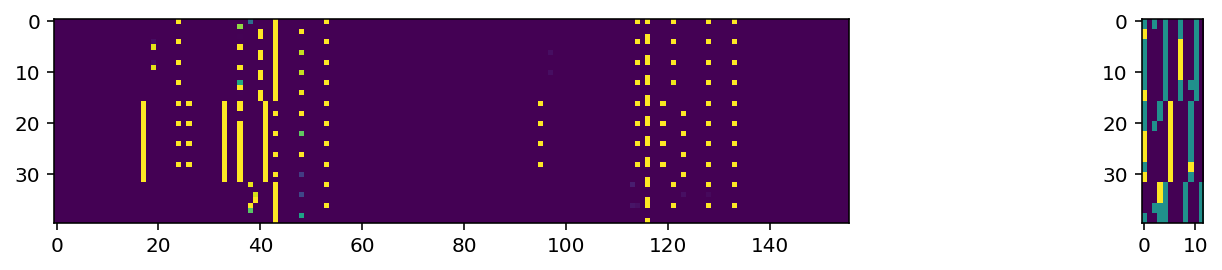

Iter: 76000
D_Loss: 8.63e-10
G_Loss: 26.68


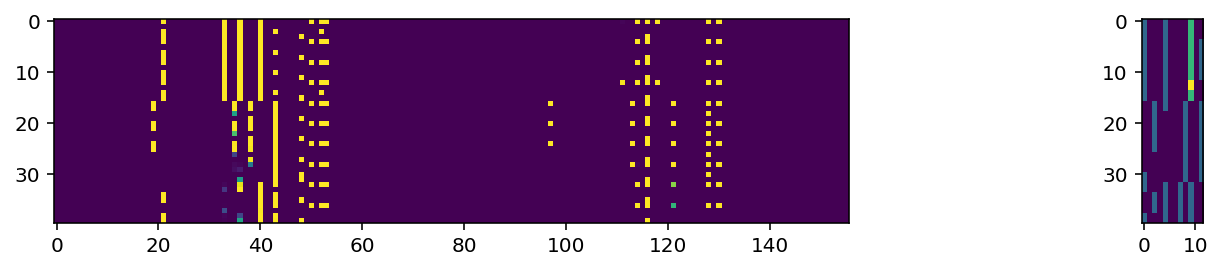

Iter: 77000
D_Loss: 1.912e-06
G_Loss: 18.19


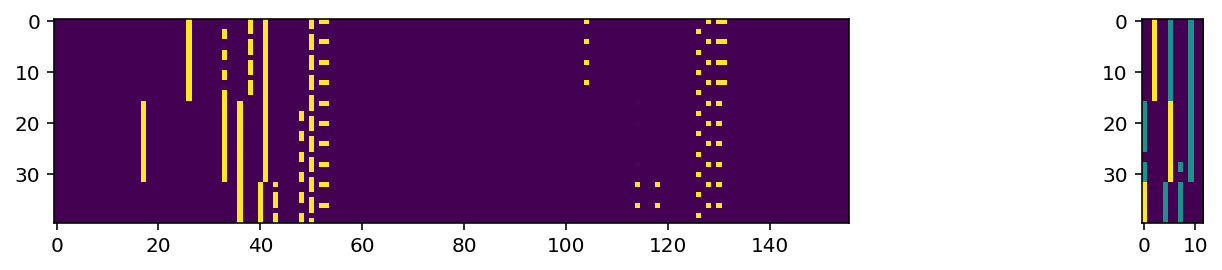

Iter: 78000
D_Loss: 1.156e-09
G_Loss: 24.06


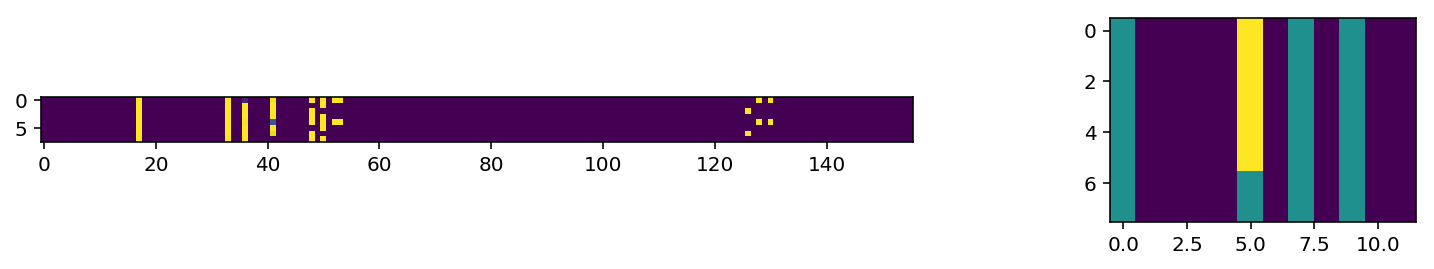

Iter: 79000
D_Loss: 2.14e-06
G_Loss: 23.31


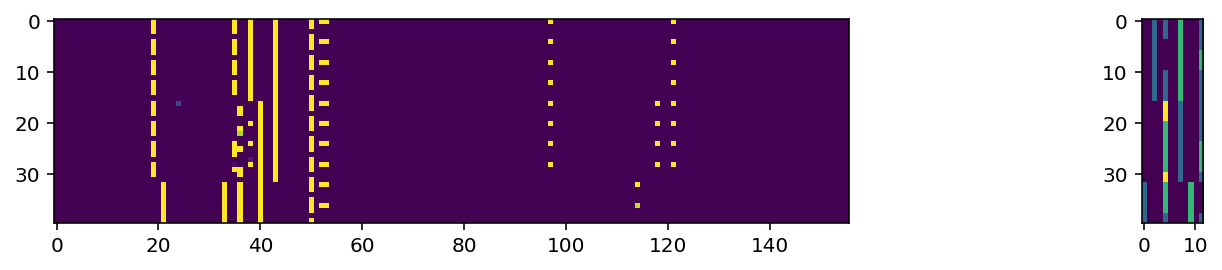

Iter: 80000
D_Loss: 1.64e-05
G_Loss: 23.5


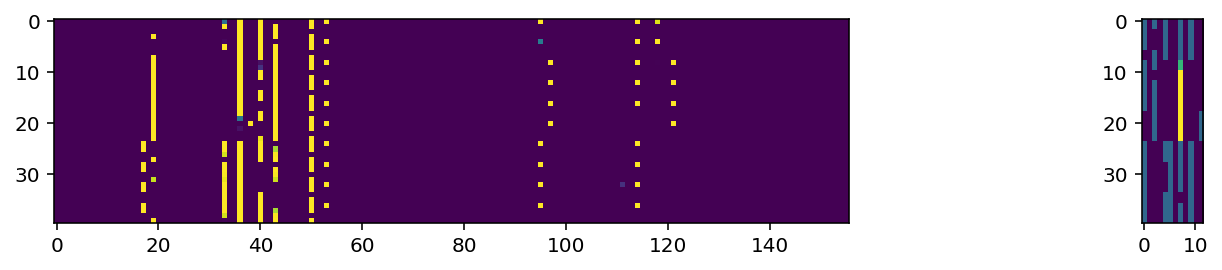

Iter: 81000
D_Loss: 1.09e-09
G_Loss: 26.22


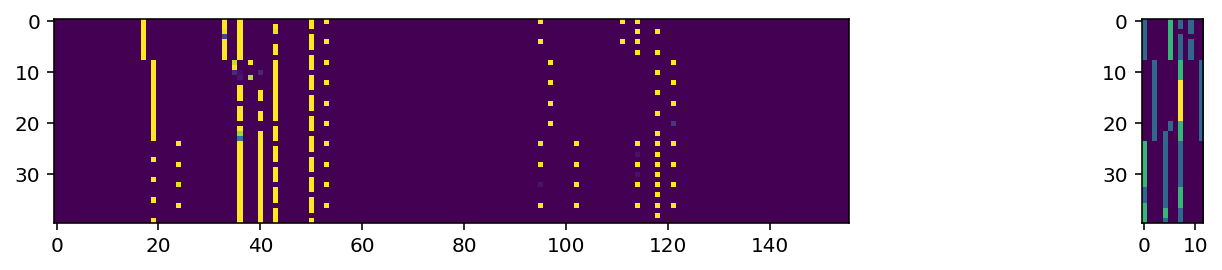

Iter: 82000
D_Loss: 2.058e-15
G_Loss: 37.91


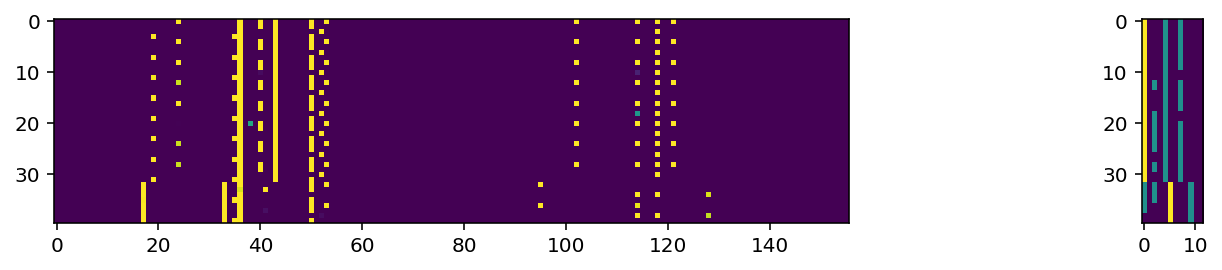

Iter: 83000
D_Loss: 1.294e-10
G_Loss: 35.03


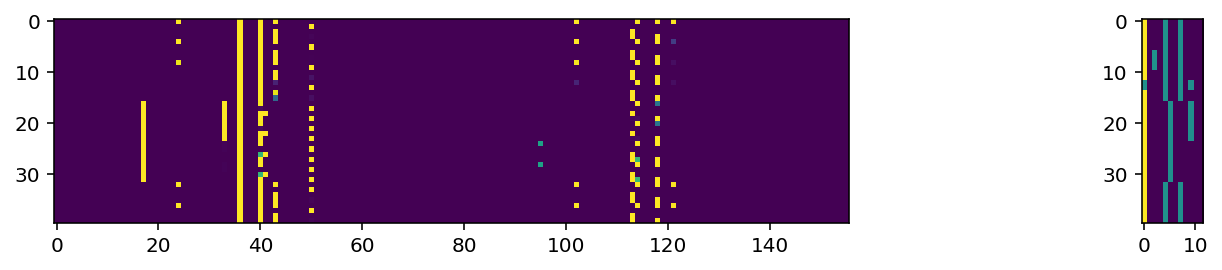

Iter: 84000
D_Loss: 3.675e-07
G_Loss: 16.8


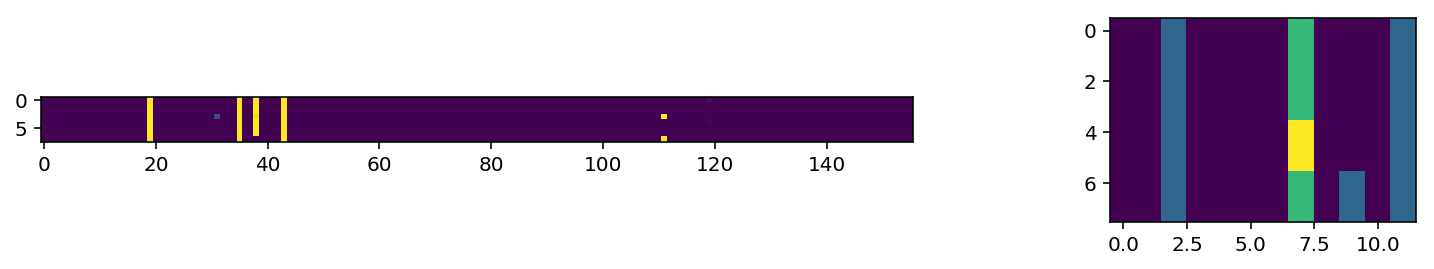

Iter: 85000
D_Loss: 1.481e-05
G_Loss: 24.57


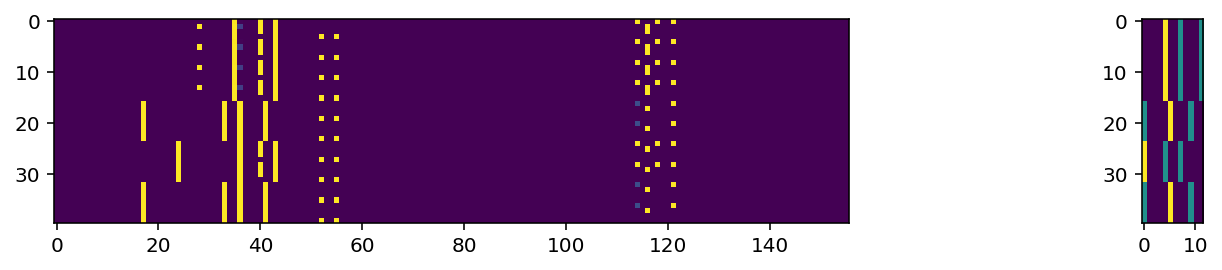

Iter: 86000
D_Loss: 2.321e-05
G_Loss: 18.2


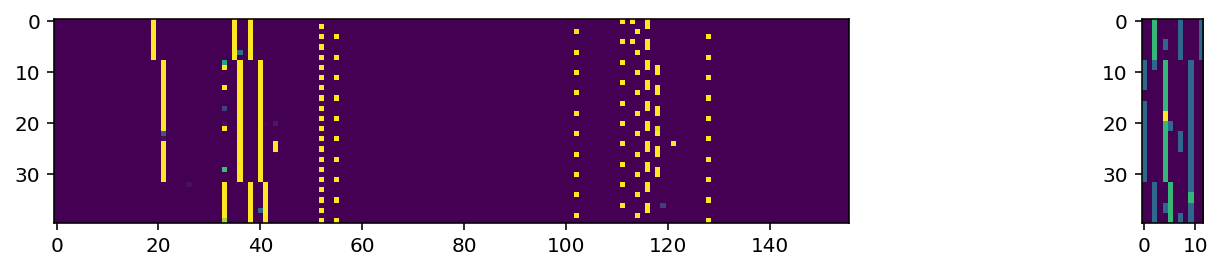

Iter: 87000
D_Loss: 4.306e-07
G_Loss: 19.64


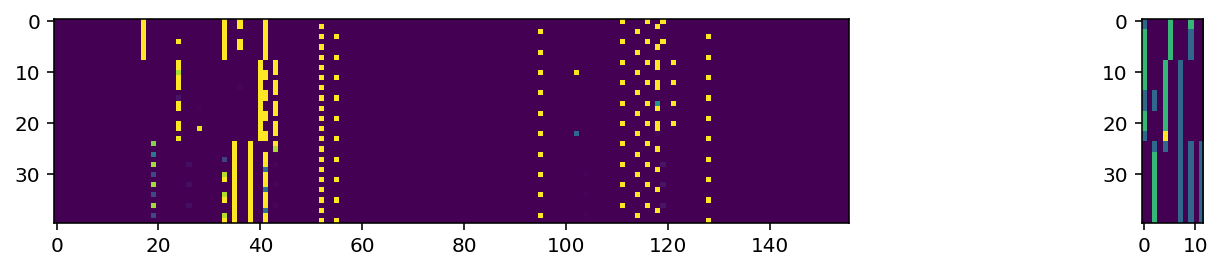

Iter: 88000
D_Loss: 0.04298
G_Loss: 23.53


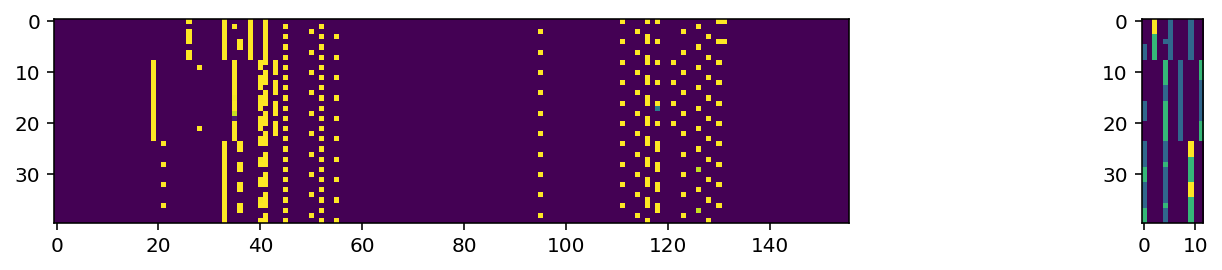

Iter: 89000
D_Loss: 5.836e-08
G_Loss: 24.25


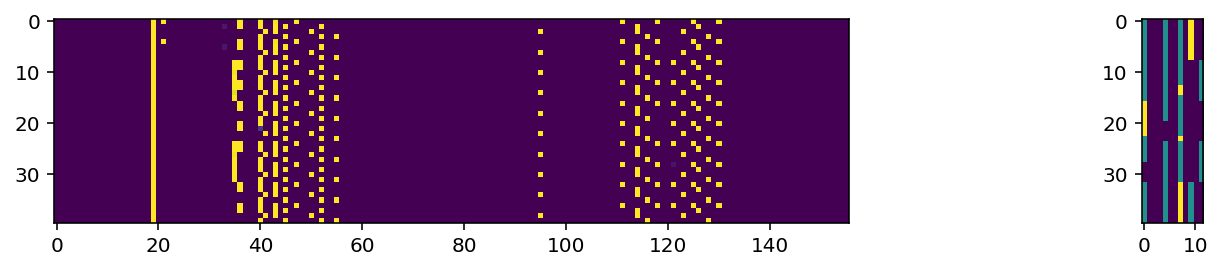

Iter: 90000
D_Loss: 6.457e-10
G_Loss: 26.36


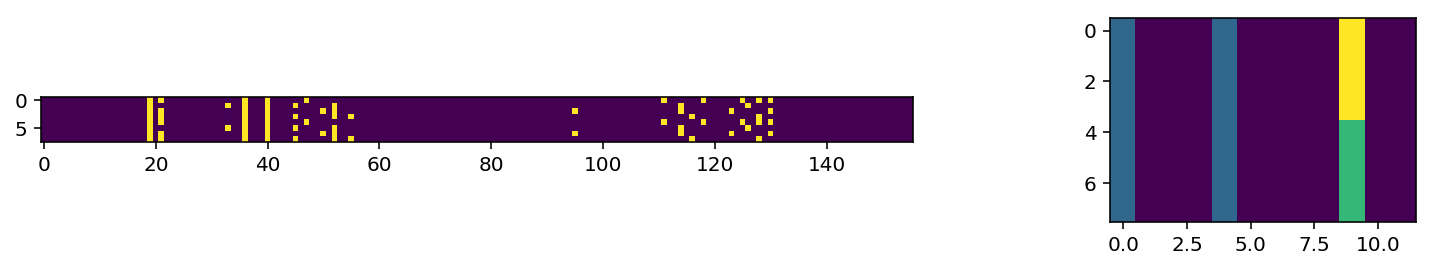

Iter: 91000
D_Loss: 0.0005543
G_Loss: 23.9


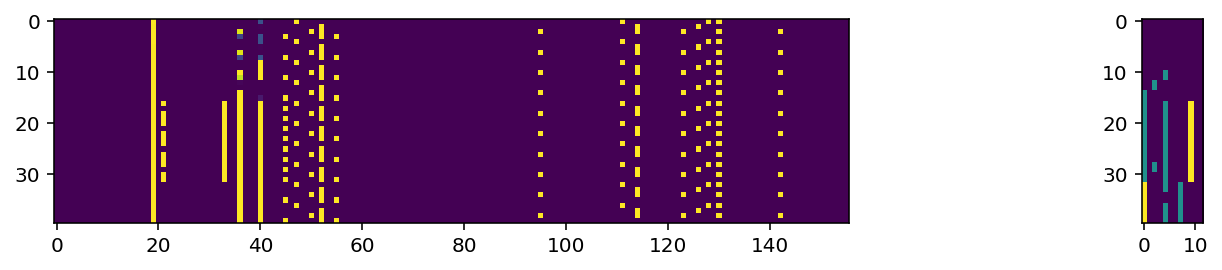

Iter: 92000
D_Loss: 1.329e-08
G_Loss: 24.03


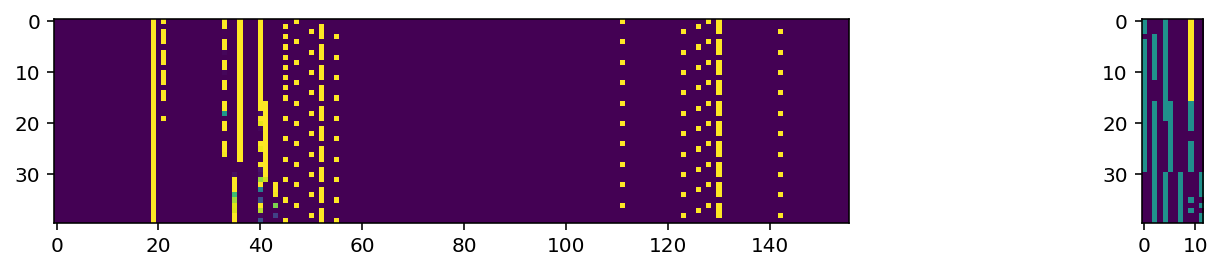

Iter: 93000
D_Loss: 7.12e-10
G_Loss: 34.22


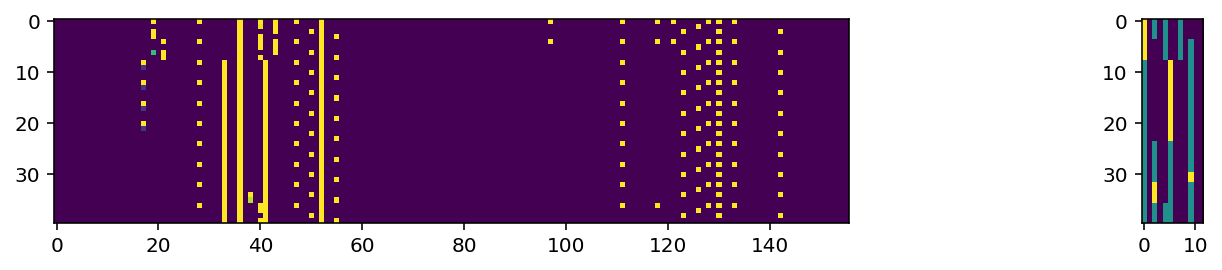

Iter: 94000
D_Loss: 0.0001556
G_Loss: 18.22


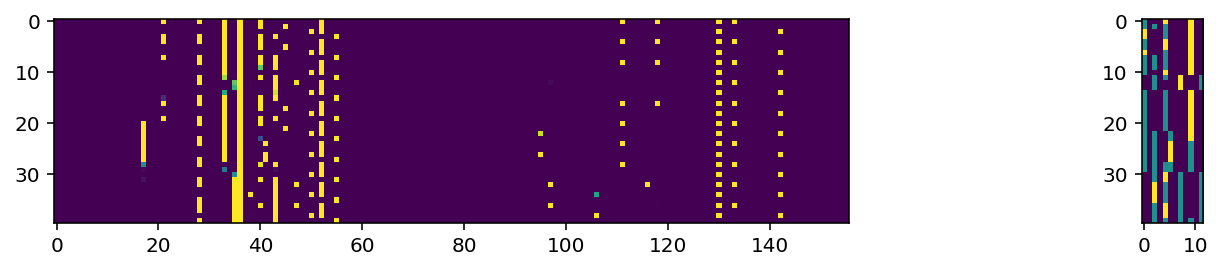

Iter: 95000
D_Loss: 9.042e-11
G_Loss: 34.49


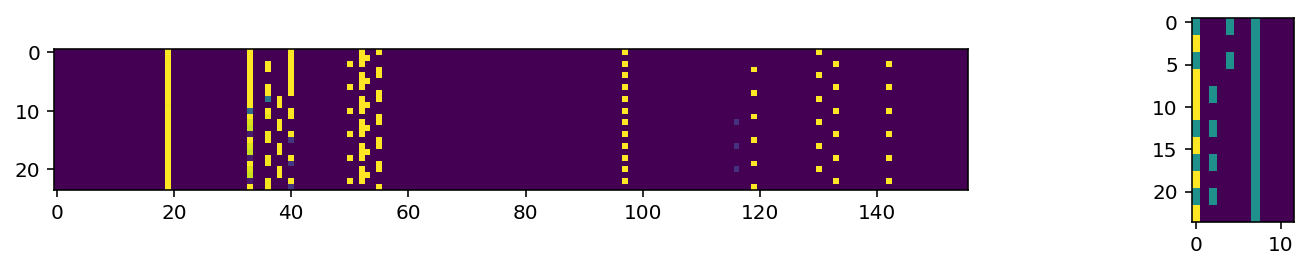

Iter: 96000
D_Loss: 5.032e-05
G_Loss: 35.16


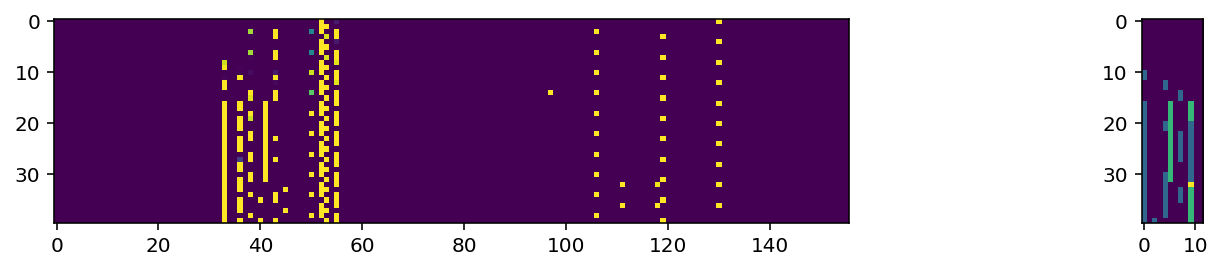

Iter: 97000
D_Loss: 3.509e-06
G_Loss: 38.8


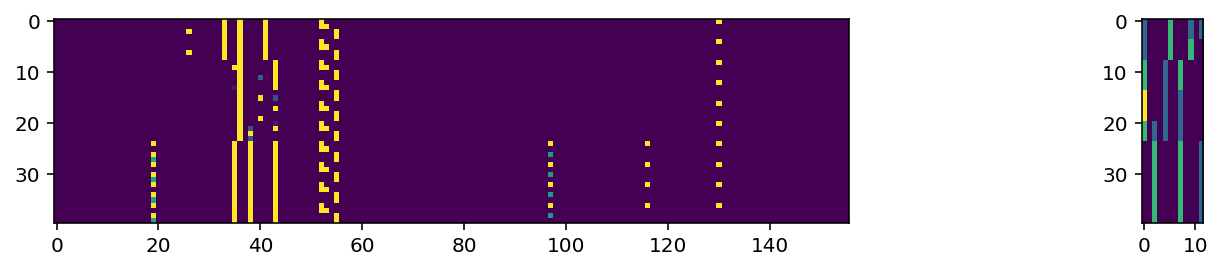

Iter: 98000
D_Loss: 4.13e-14
G_Loss: 39.15


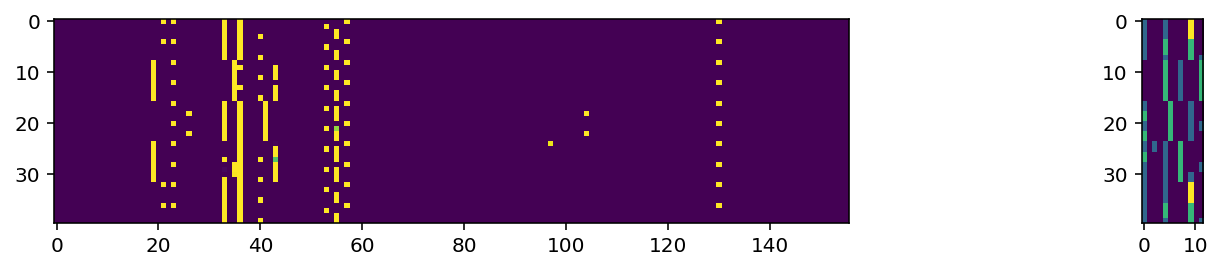

Iter: 99000
D_Loss: 1.662e-06
G_Loss: 39.28


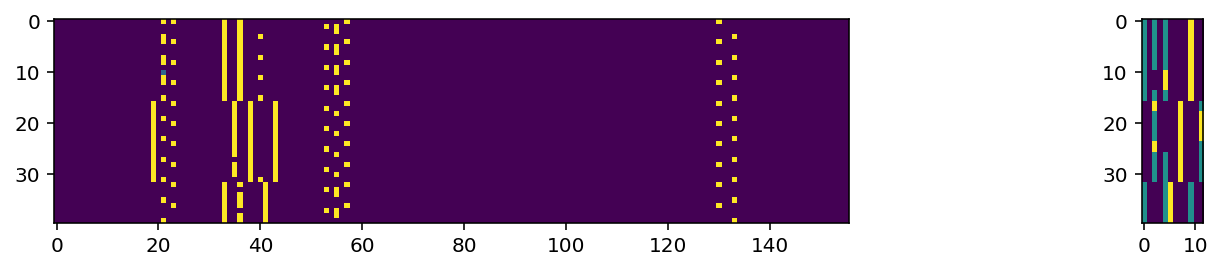

Iter: 100000
D_Loss: 1.103e-11
G_Loss: 38.14


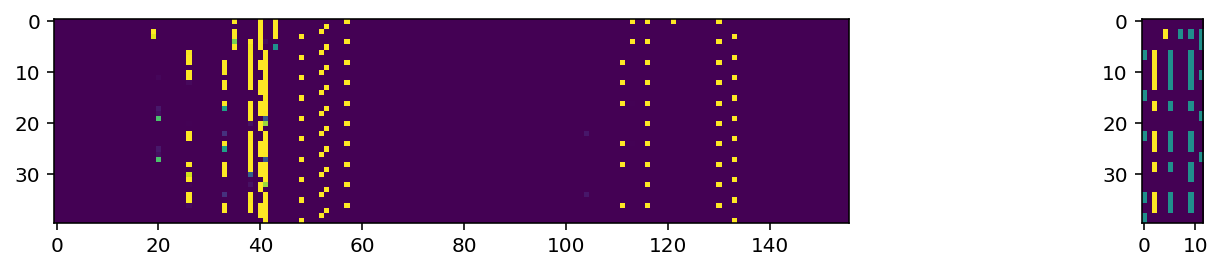

Iter: 101000
D_Loss: 1.031e-09
G_Loss: 25.13


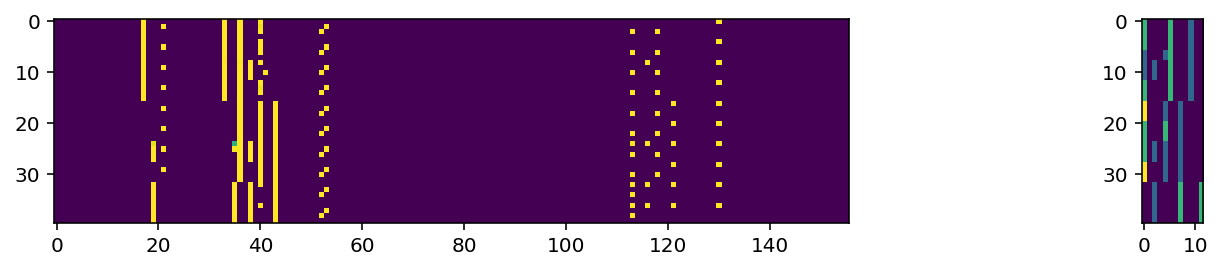

Iter: 102000
D_Loss: 1.869e-13
G_Loss: 31.39


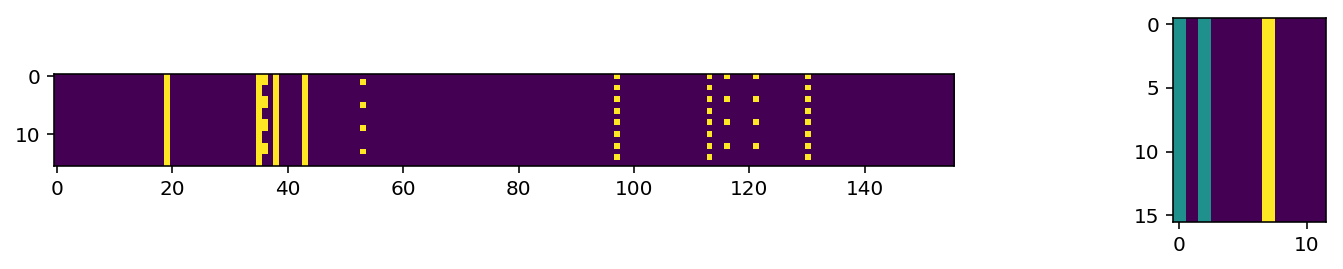

Iter: 103000
D_Loss: 4.208e-10
G_Loss: 33.18


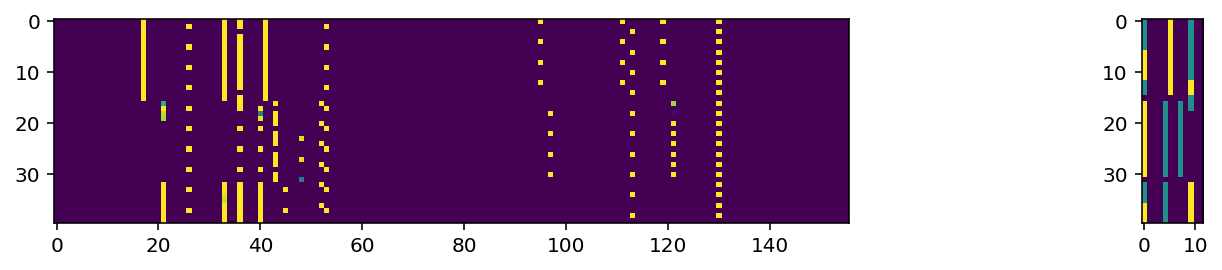

Iter: 104000
D_Loss: 3.056
G_Loss: 17.12


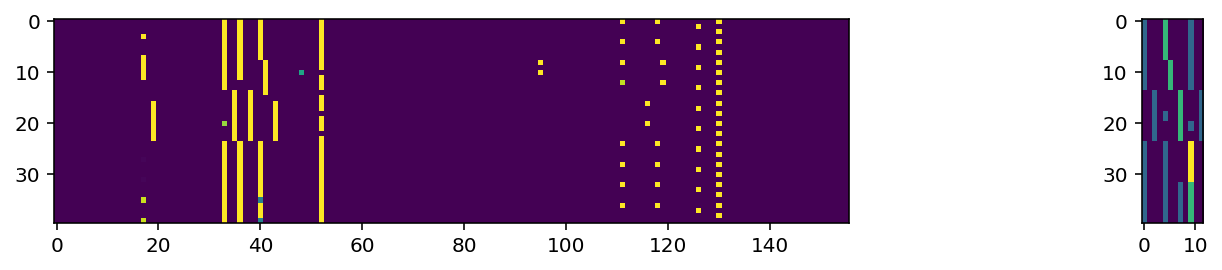

Iter: 105000
D_Loss: 0.0001425
G_Loss: 24.48


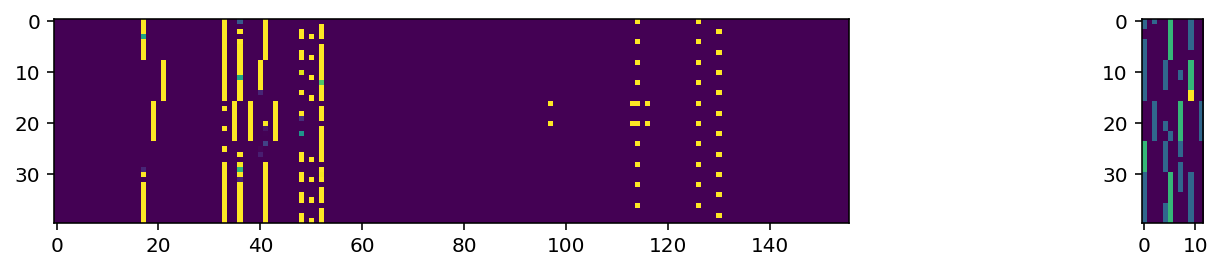

Iter: 106000
D_Loss: 1.921e-12
G_Loss: 42.05


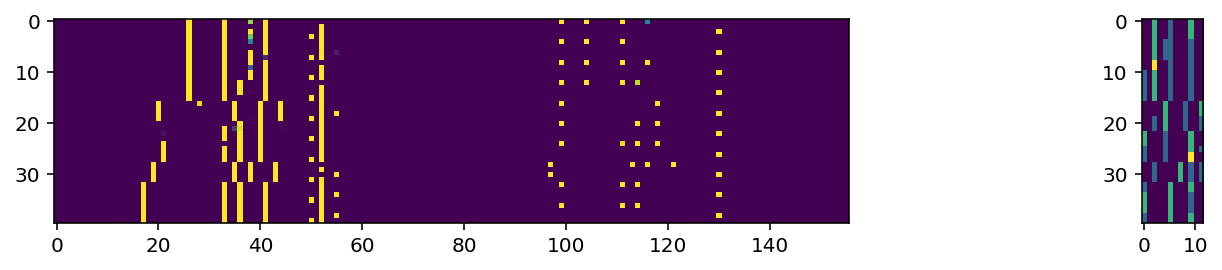

Iter: 107000
D_Loss: 2.932e-09
G_Loss: 41.81


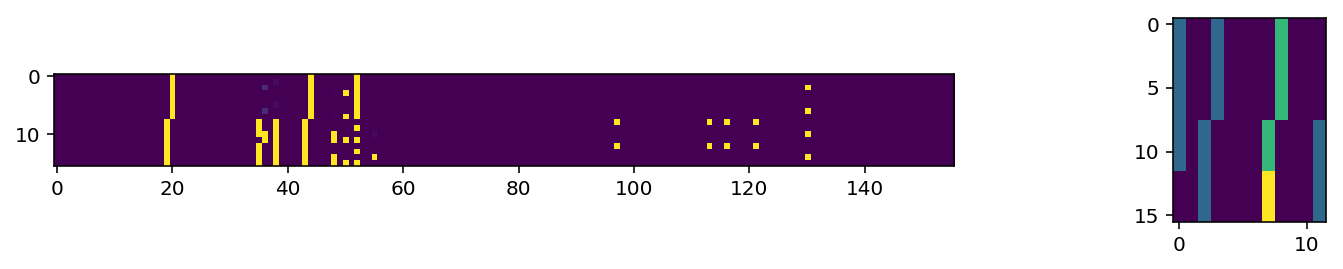

Iter: 108000
D_Loss: 3.66e-19
G_Loss: 51.87


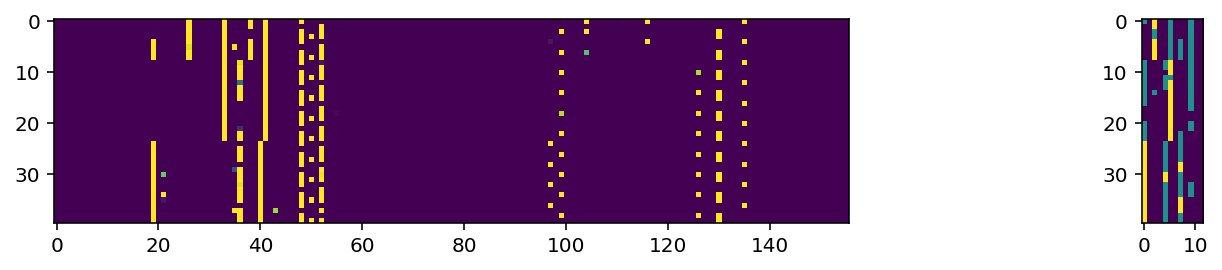

Iter: 109000
D_Loss: 1.476e-12
G_Loss: 49.72


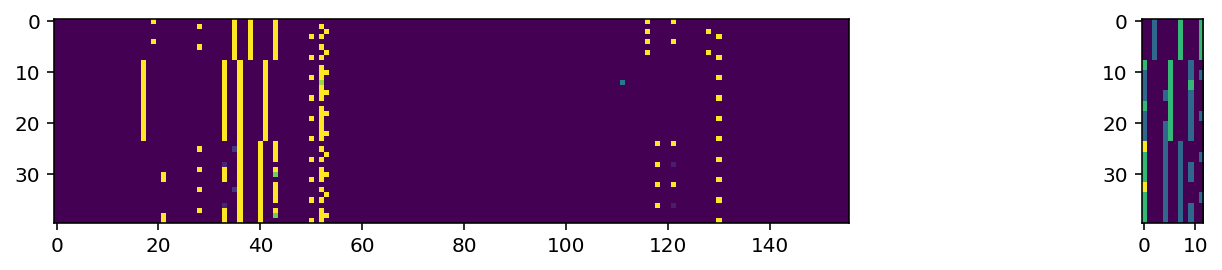

Iter: 110000
D_Loss: 1.278e-11
G_Loss: 30.77


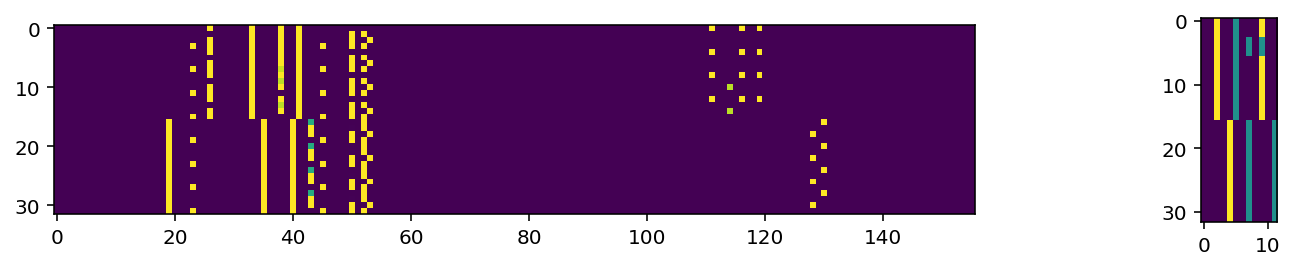

Iter: 111000
D_Loss: 5.479e-06
G_Loss: 28.59


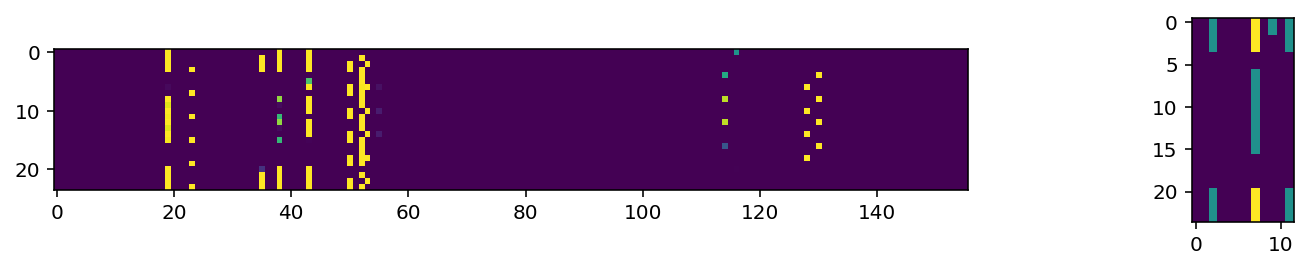

Iter: 112000
D_Loss: 1.581e-05
G_Loss: 22.83


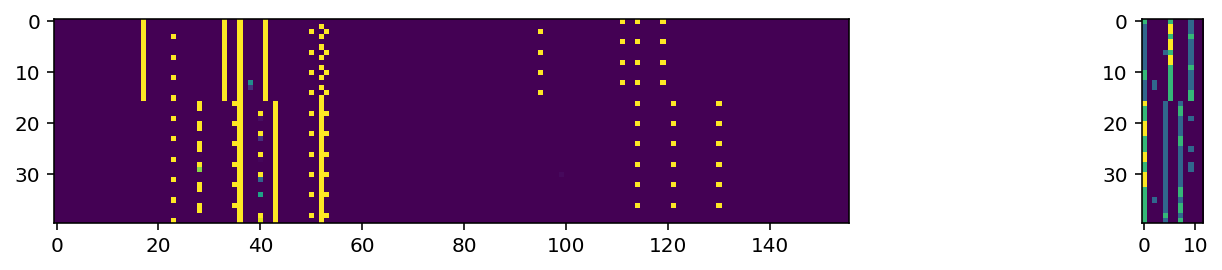

Iter: 113000
D_Loss: 1.256e-09
G_Loss: 29.42


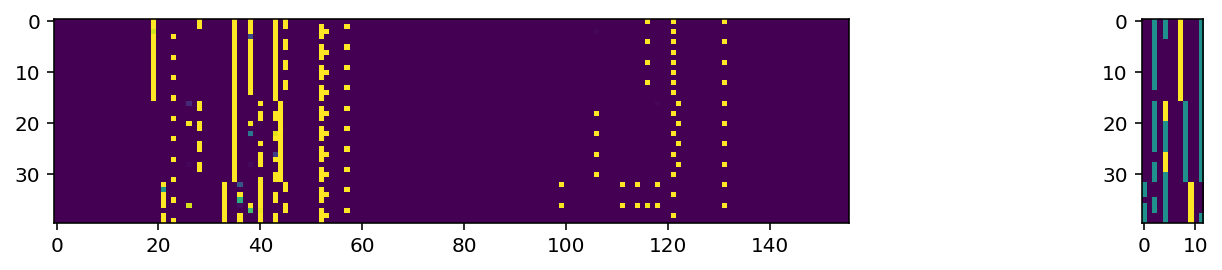

Iter: 114000
D_Loss: 1.988e-10
G_Loss: 35.46


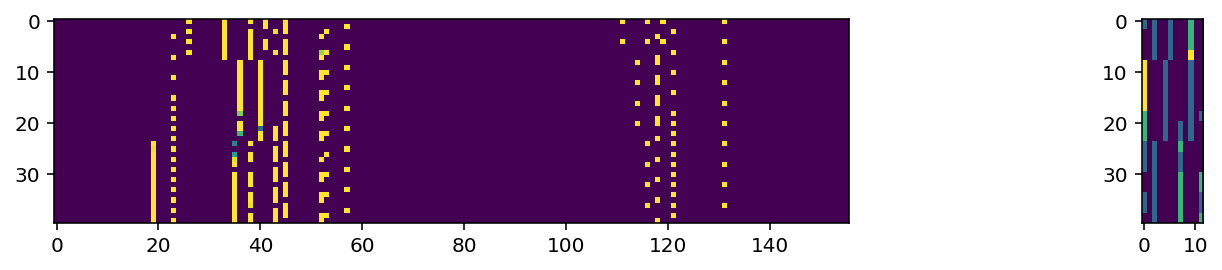

Iter: 115000
D_Loss: 1.134e-18
G_Loss: 55.53


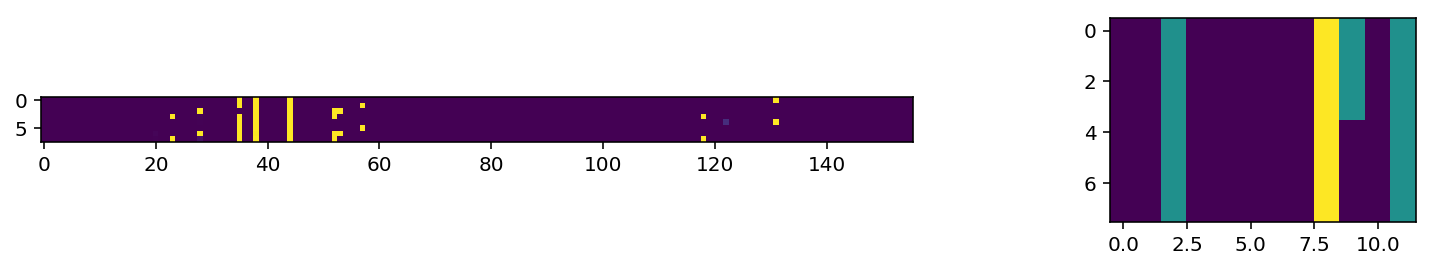

Iter: 116000
D_Loss: 1.736e-10
G_Loss: 26.08


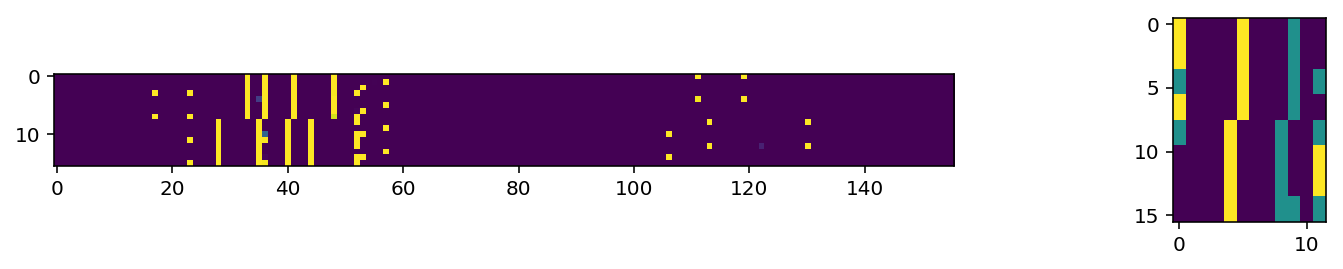

Iter: 117000
D_Loss: 8.889e-08
G_Loss: 29.95


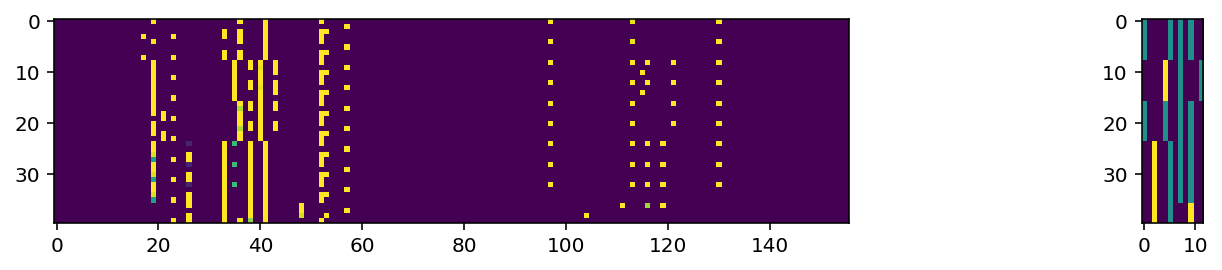

Iter: 118000
D_Loss: 1.909e-10
G_Loss: 38.21


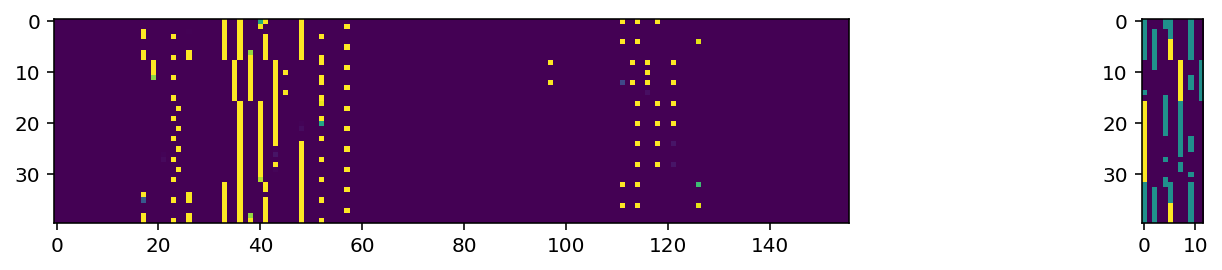

Iter: 119000
D_Loss: 1.005
G_Loss: 16.08


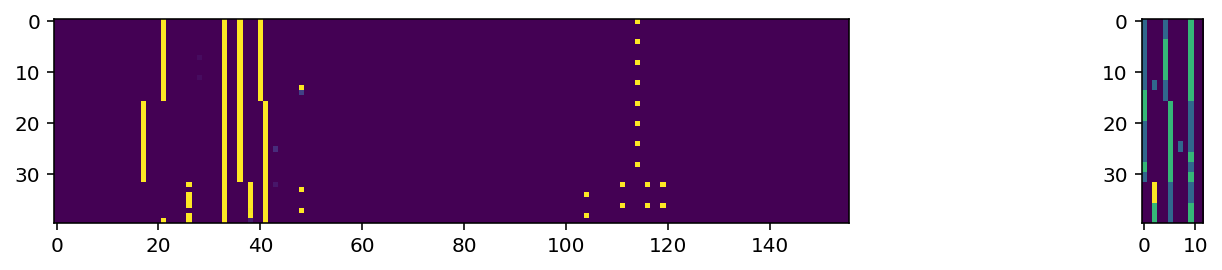

Iter: 120000
D_Loss: 2.125e-05
G_Loss: 23.84


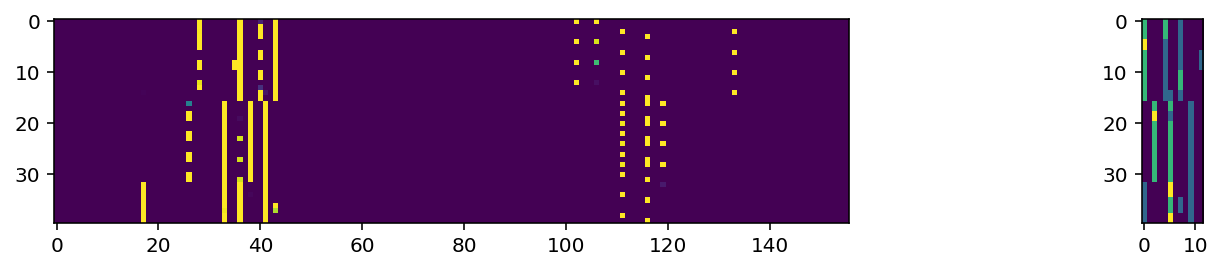

Iter: 121000
D_Loss: 1.85e-08
G_Loss: 26.4


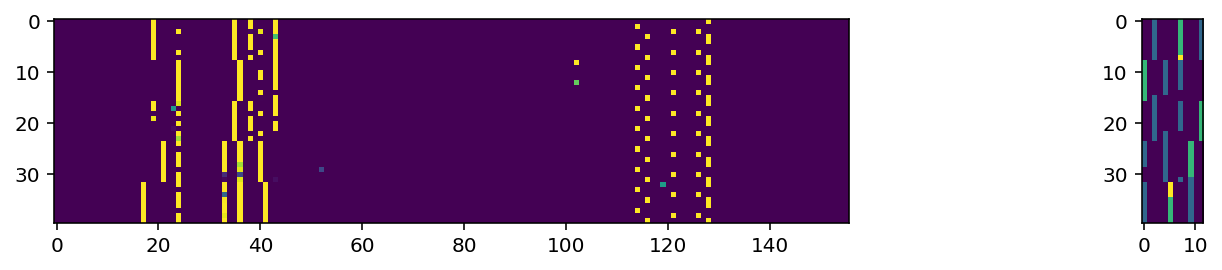

Iter: 122000
D_Loss: 4.806e-06
G_Loss: 16.21


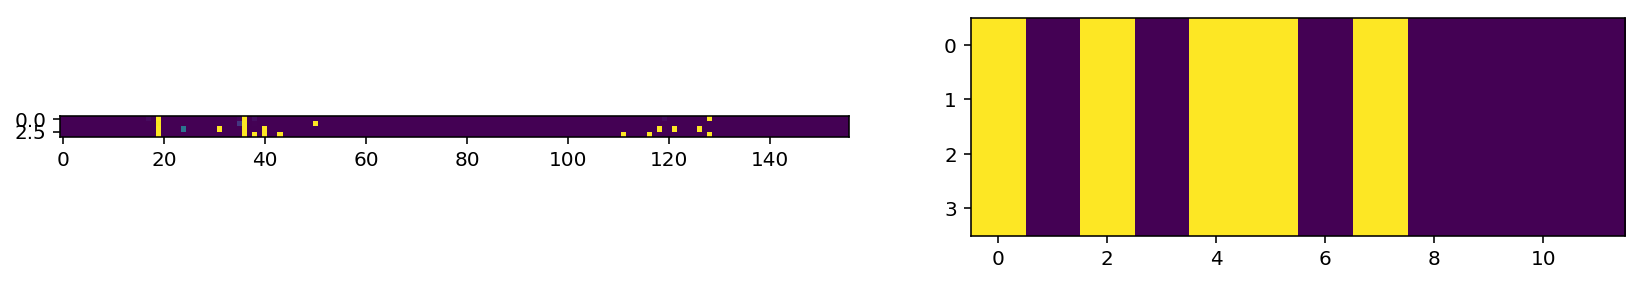

Iter: 123000
D_Loss: 3.878e-07
G_Loss: 19.57


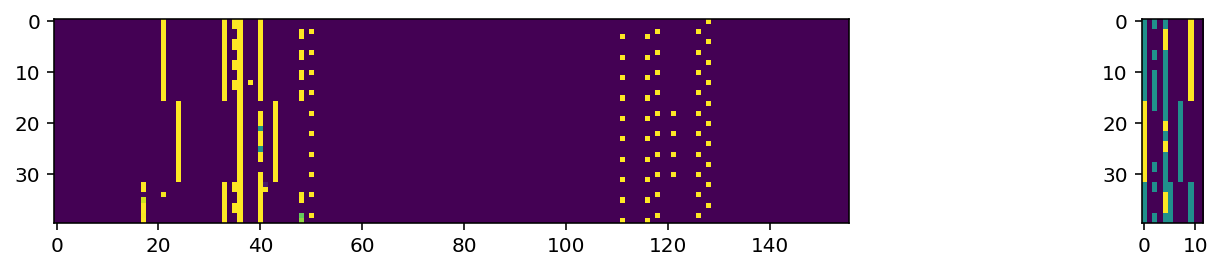

Iter: 124000
D_Loss: 0.0001405
G_Loss: 18.53


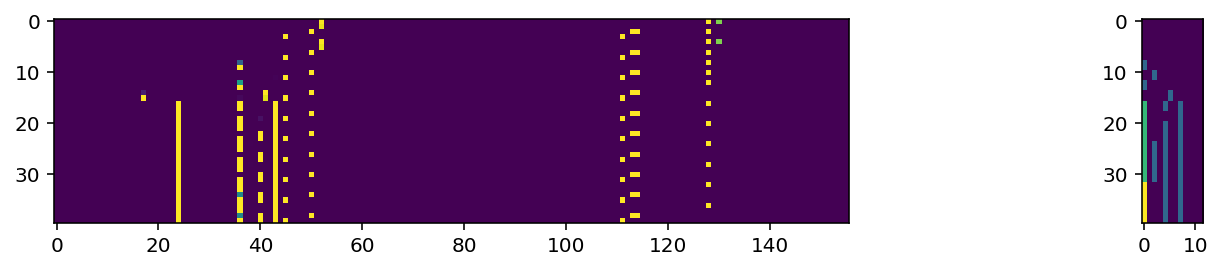

Iter: 125000
D_Loss: 1.243e-06
G_Loss: 18.9


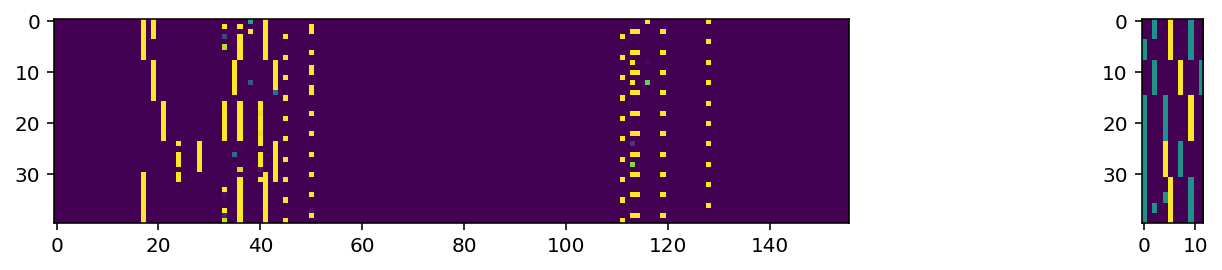

Iter: 126000
D_Loss: 1.929e-05
G_Loss: 25.76


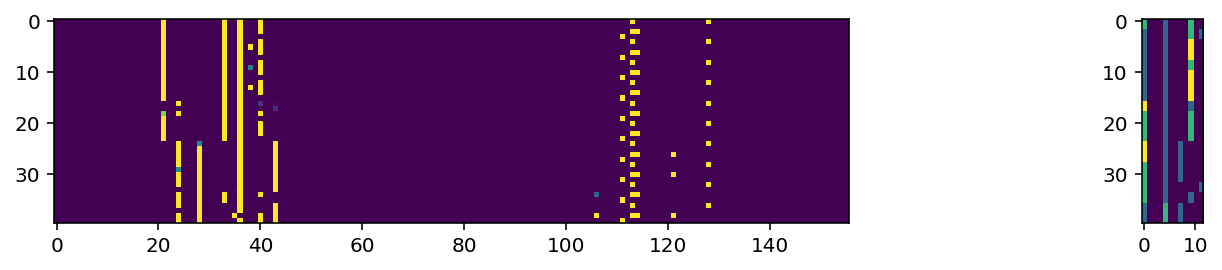

Iter: 127000
D_Loss: 5.145e-06
G_Loss: 18.0


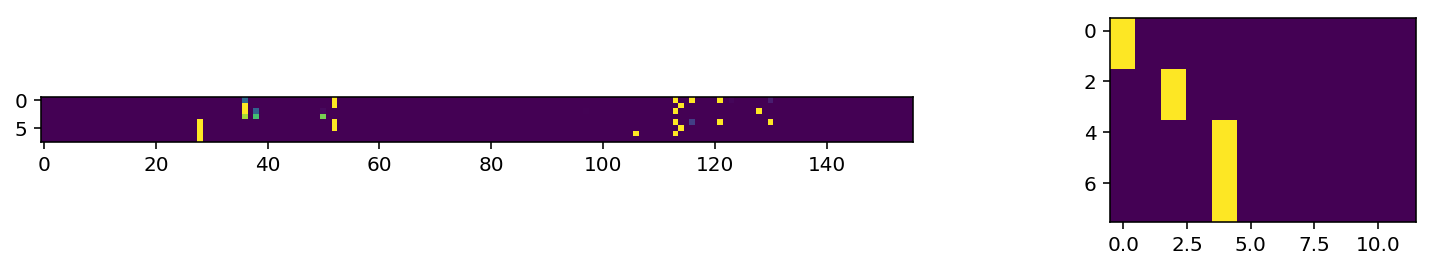

Iter: 128000
D_Loss: 1.259e-10
G_Loss: 35.89


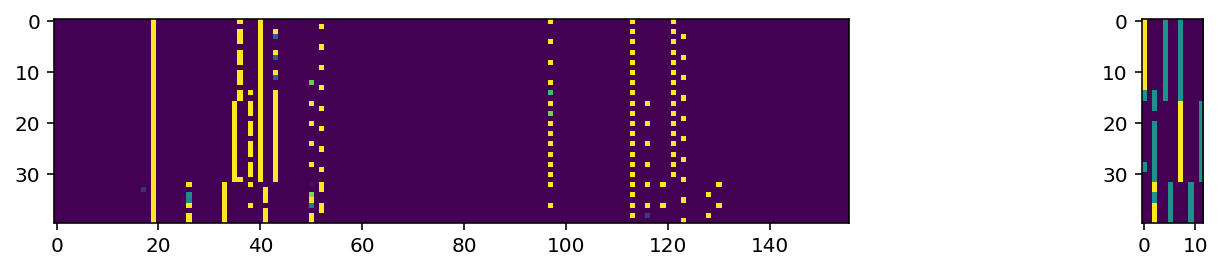

Iter: 129000
D_Loss: 13.72
G_Loss: 48.34


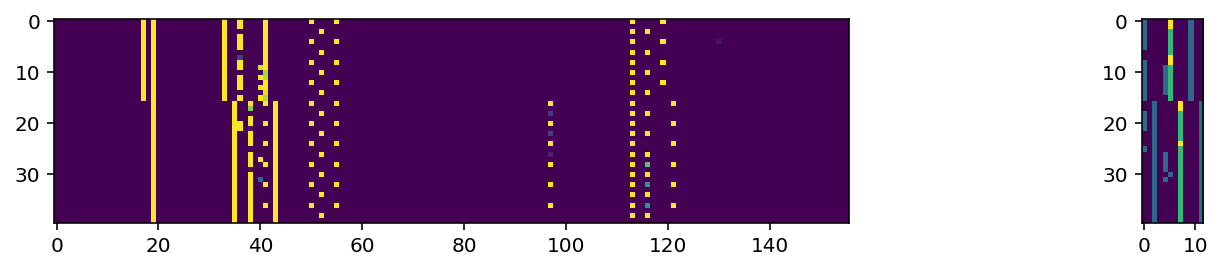

Iter: 130000
D_Loss: 4.998e-05
G_Loss: 18.28


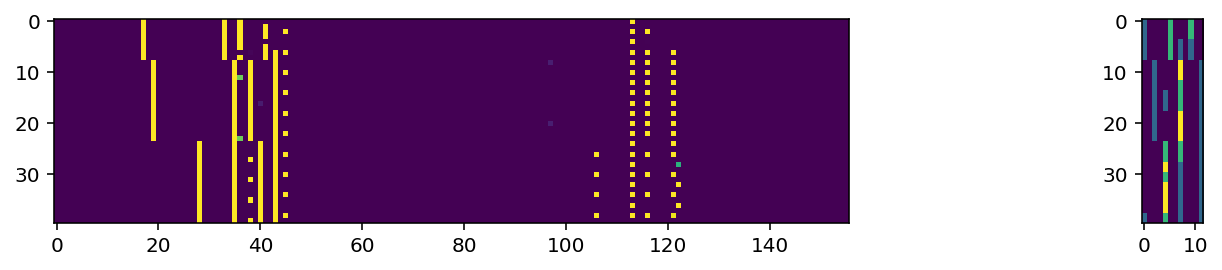

Iter: 131000
D_Loss: 0.005871
G_Loss: 16.95


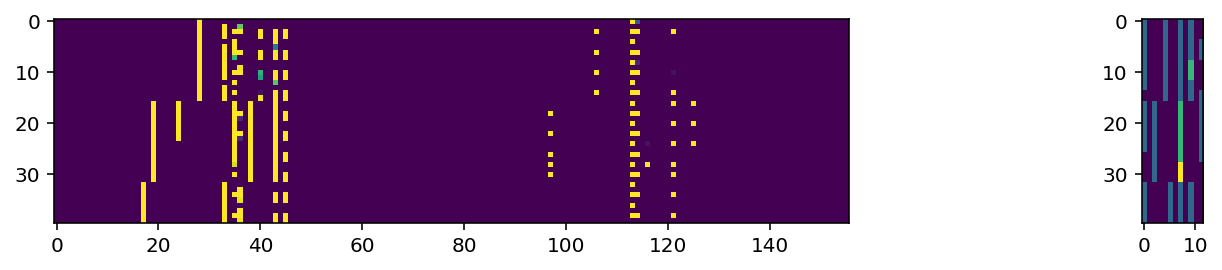

Iter: 132000
D_Loss: 1.686e-05
G_Loss: 23.88


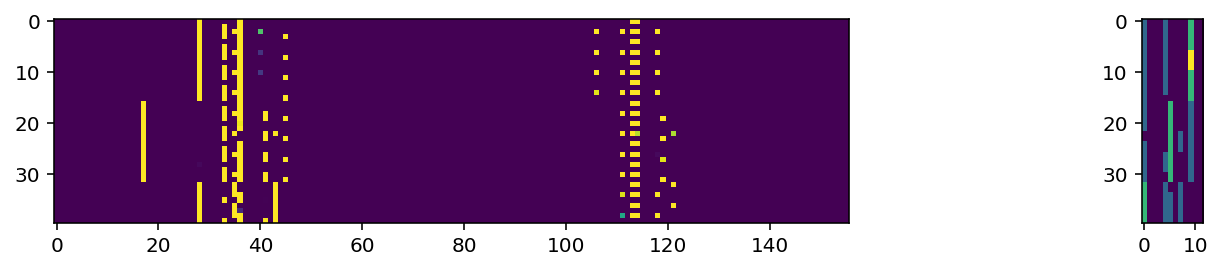

Iter: 133000
D_Loss: 2.121e-13
G_Loss: 32.87


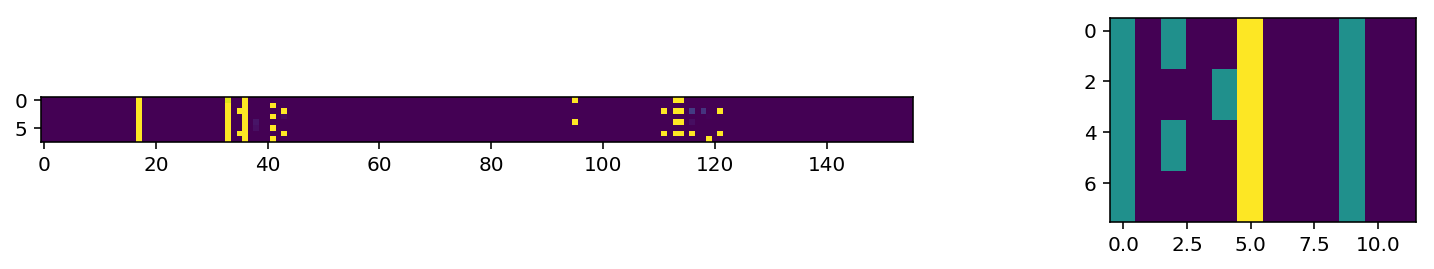

Iter: 134000
D_Loss: 1.109e-07
G_Loss: 29.06


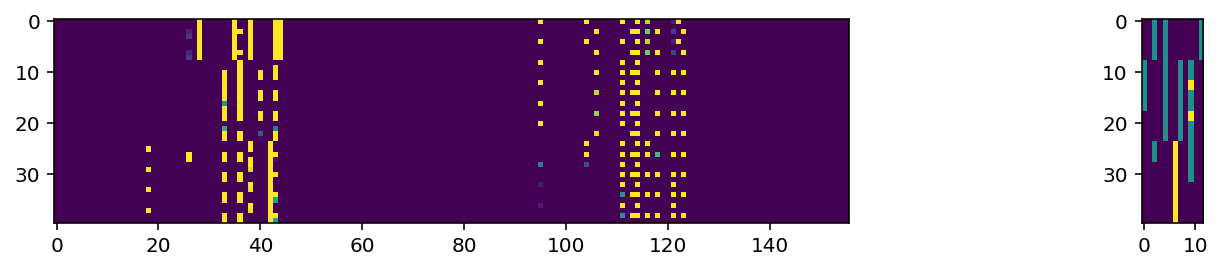

Iter: 135000
D_Loss: 0.005102
G_Loss: 22.51


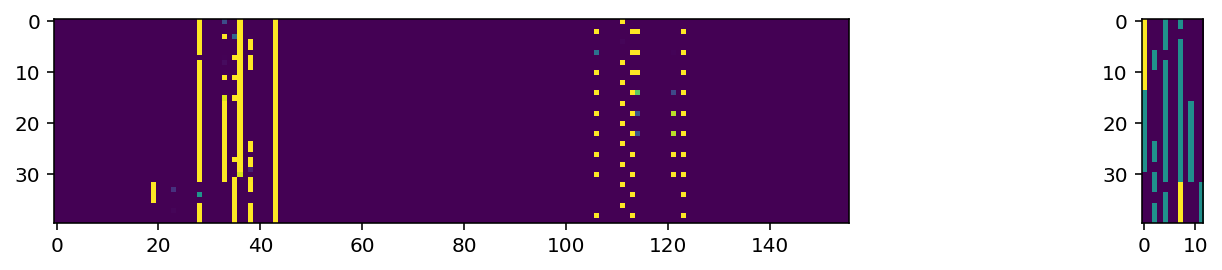

Iter: 136000
D_Loss: 0.0007023
G_Loss: 17.74


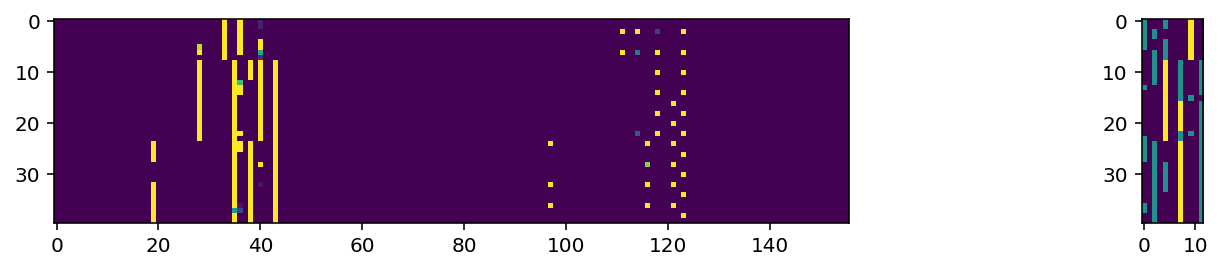

Iter: 137000
D_Loss: 1.624e-09
G_Loss: 27.56


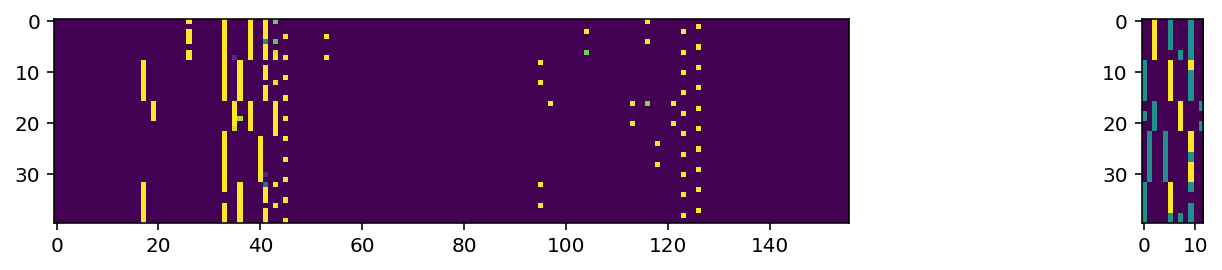

Iter: 138000
D_Loss: 1.483e-05
G_Loss: 17.91


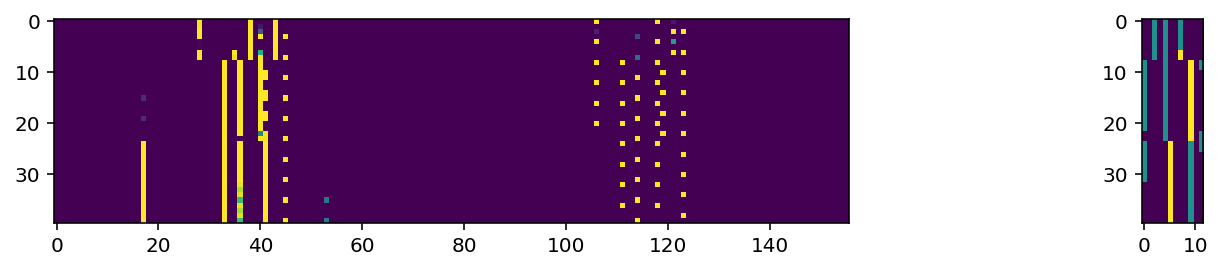

Iter: 139000
D_Loss: 0.01132
G_Loss: 12.0


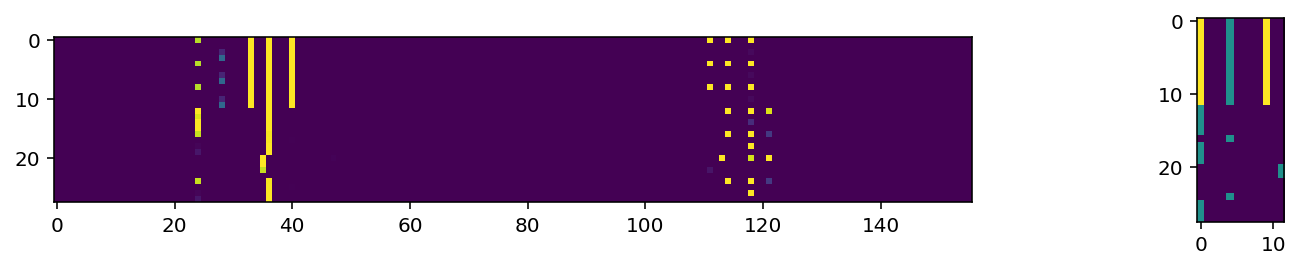

Iter: 140000
D_Loss: 0.7588
G_Loss: 8.699


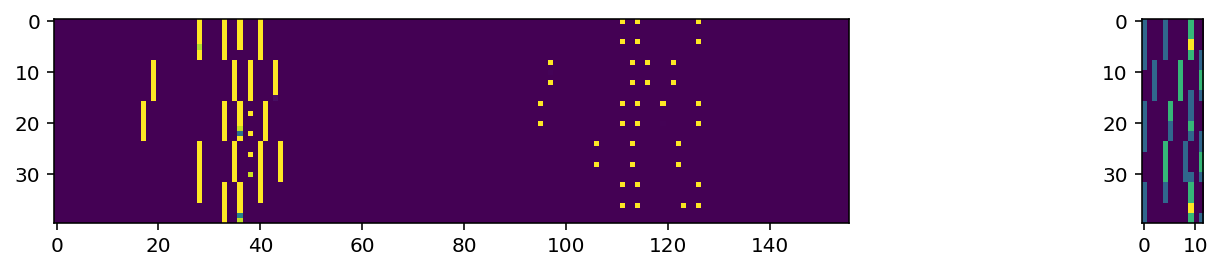

Iter: 141000
D_Loss: 0.001451
G_Loss: 16.44


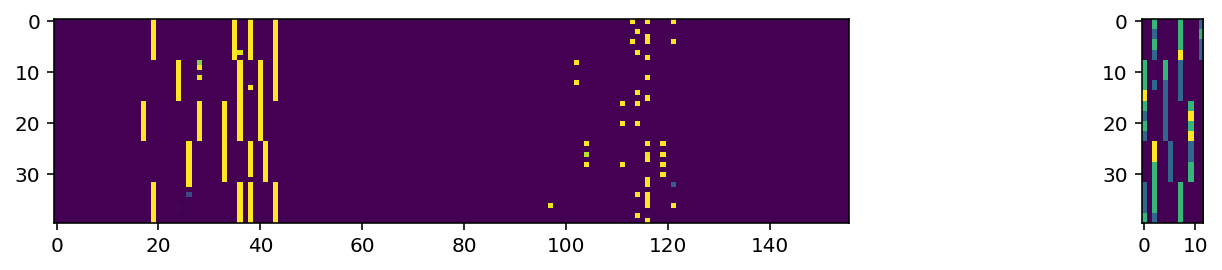

Iter: 142000
D_Loss: 0.1764
G_Loss: 3.498


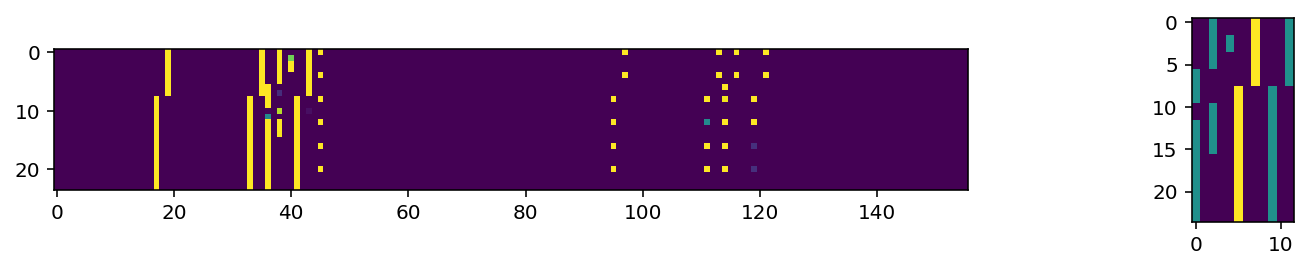

Iter: 143000
D_Loss: 0.8098
G_Loss: 8.78


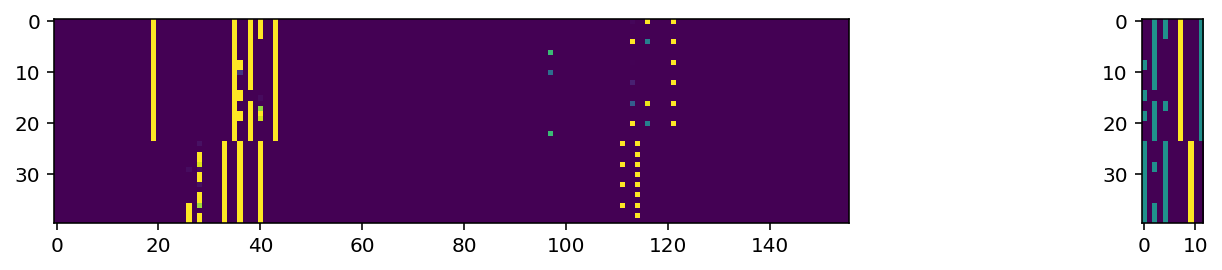

Iter: 144000
D_Loss: 0.2513
G_Loss: 6.07


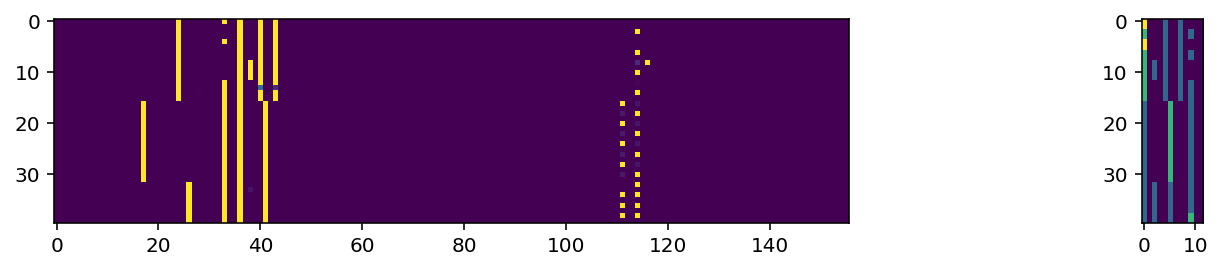

Iter: 145000
D_Loss: 1.069e-06
G_Loss: 18.72


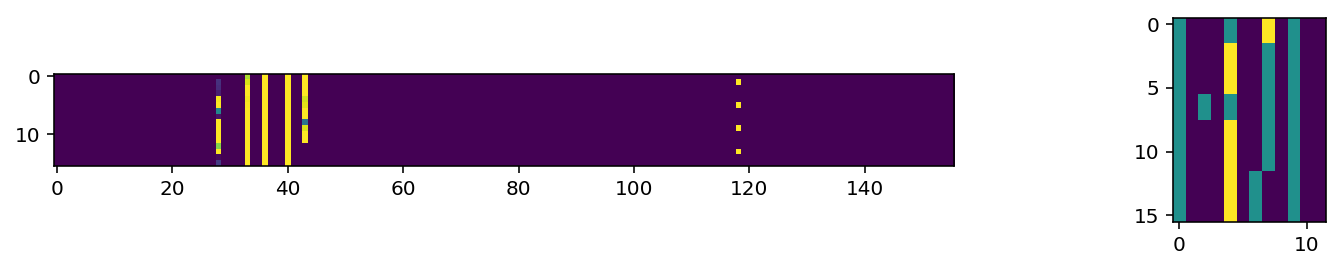

Iter: 146000
D_Loss: 0.01887
G_Loss: 9.02


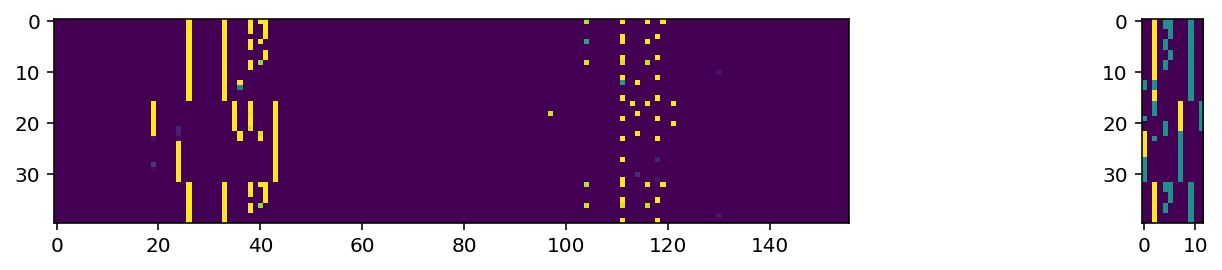

Iter: 147000
D_Loss: 0.9037
G_Loss: 14.49


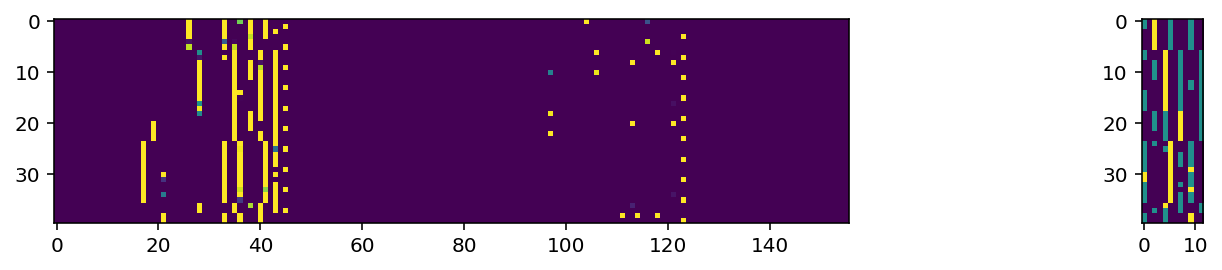

Iter: 148000
D_Loss: 0.002549
G_Loss: 14.62


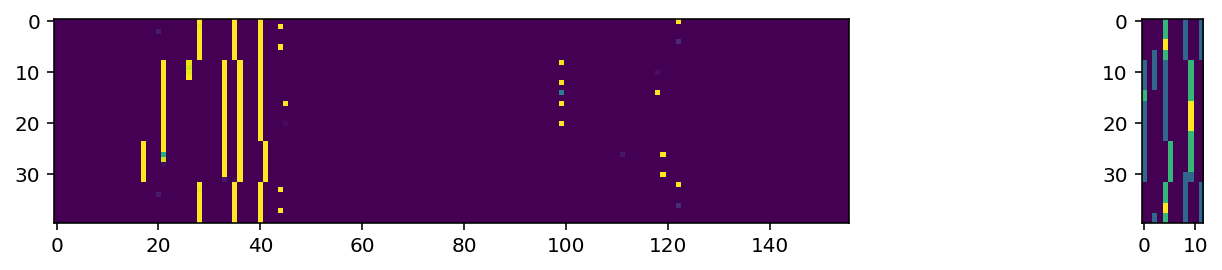

Iter: 149000
D_Loss: 3.936e-06
G_Loss: 15.9


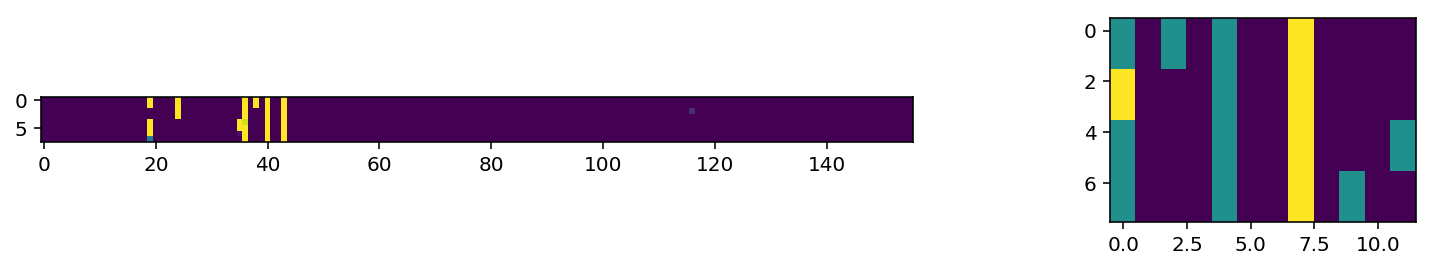

Iter: 150000
D_Loss: 0.07379
G_Loss: 5.843


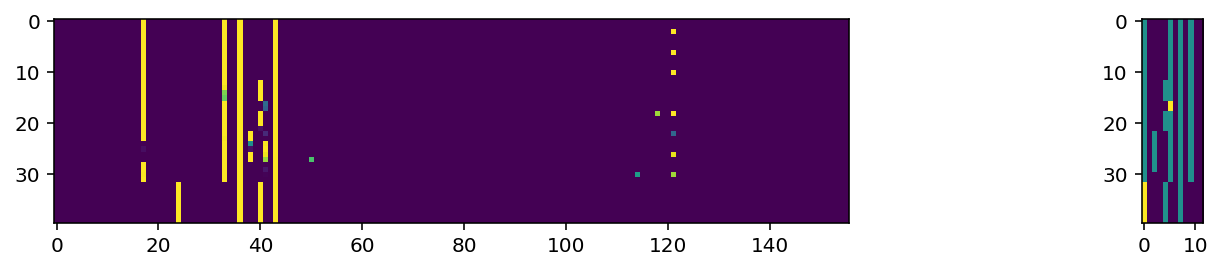

Iter: 151000
D_Loss: 0.2527
G_Loss: 12.76


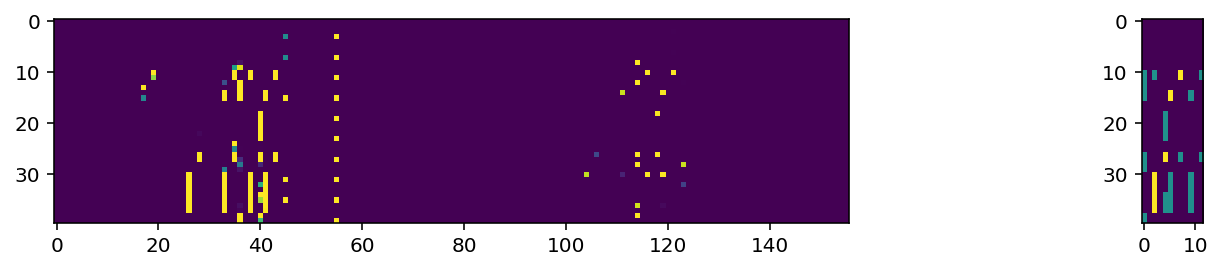

Iter: 152000
D_Loss: 0.0002892
G_Loss: 14.89


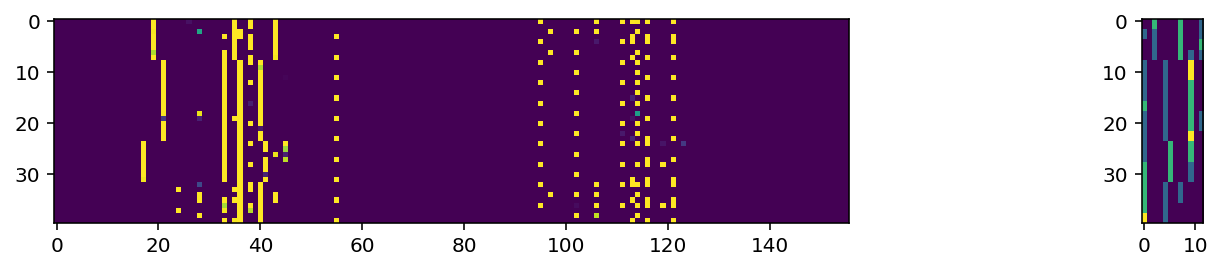

Iter: 153000
D_Loss: 0.0003937
G_Loss: 9.374


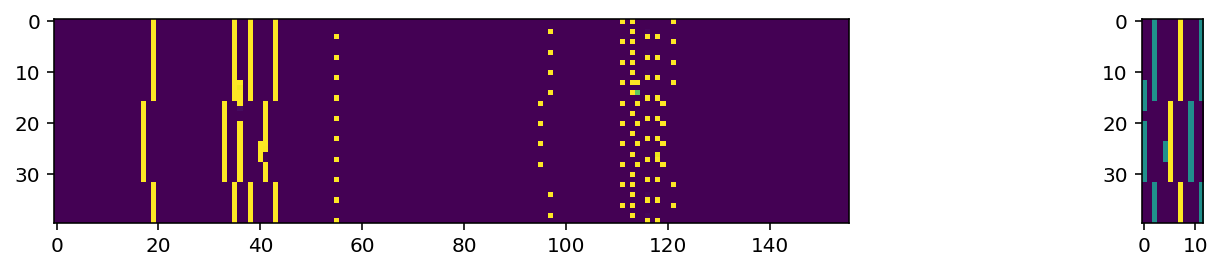

Iter: 154000
D_Loss: 0.0001189
G_Loss: 14.61


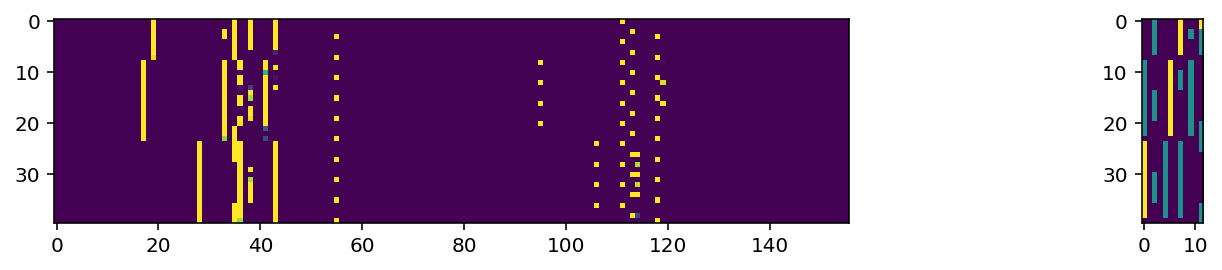

Iter: 155000
D_Loss: 3.213e-05
G_Loss: 14.63


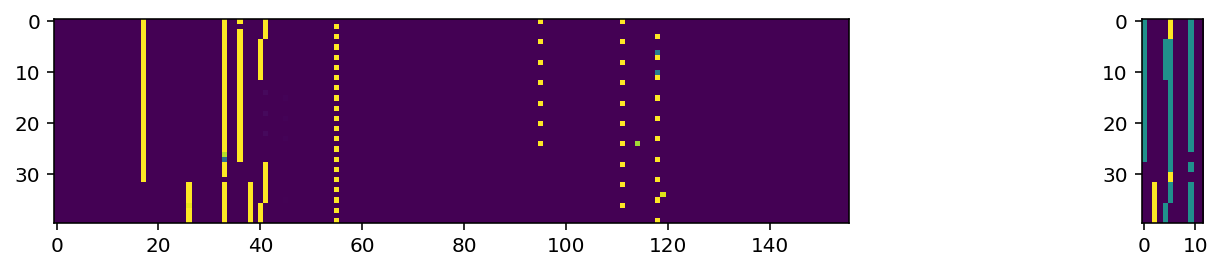

Iter: 156000
D_Loss: 2.264e-06
G_Loss: 16.18


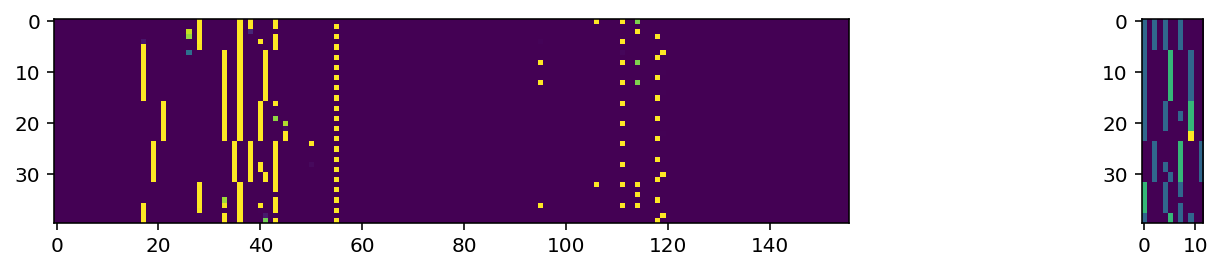

Iter: 157000
D_Loss: 2.733e-06
G_Loss: 18.44


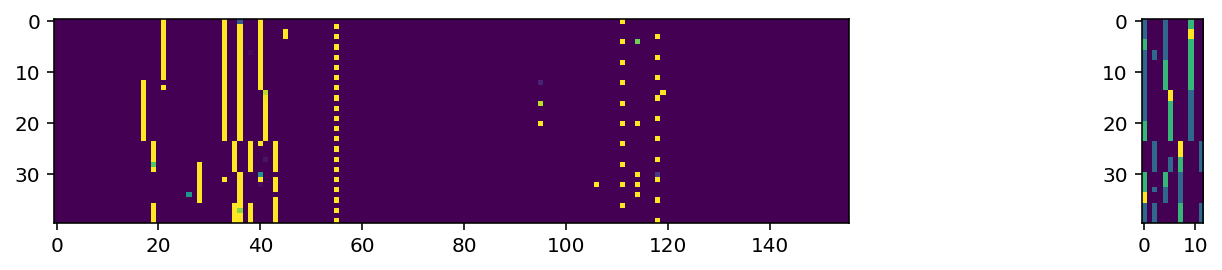

Iter: 158000
D_Loss: 3.105e-05
G_Loss: 18.33


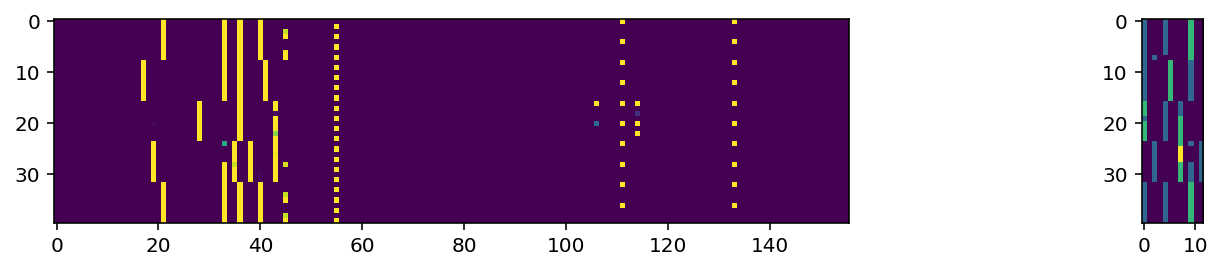

Iter: 159000
D_Loss: 4.442e-08
G_Loss: 28.24


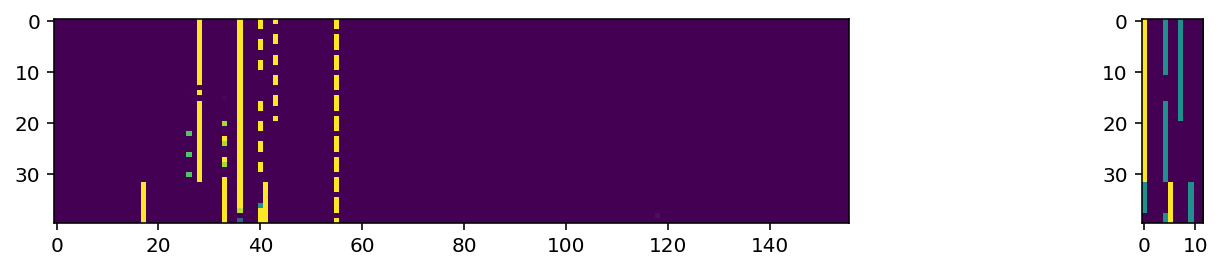

Iter: 160000
D_Loss: 9.408e-09
G_Loss: 27.09


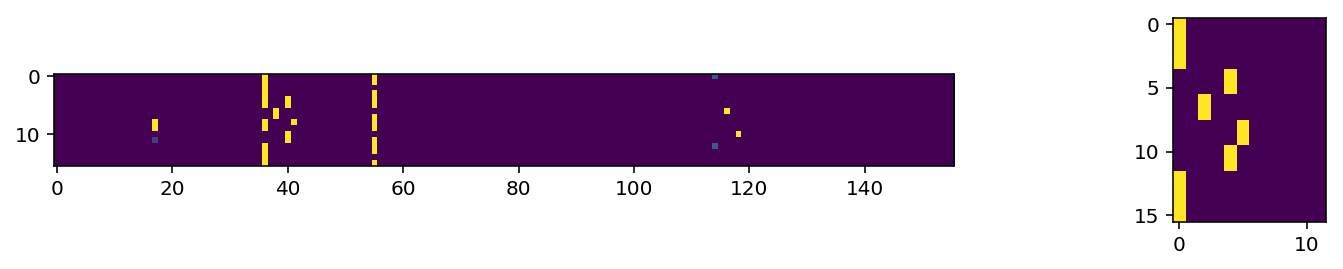

Iter: 161000
D_Loss: 0.003487
G_Loss: 16.17


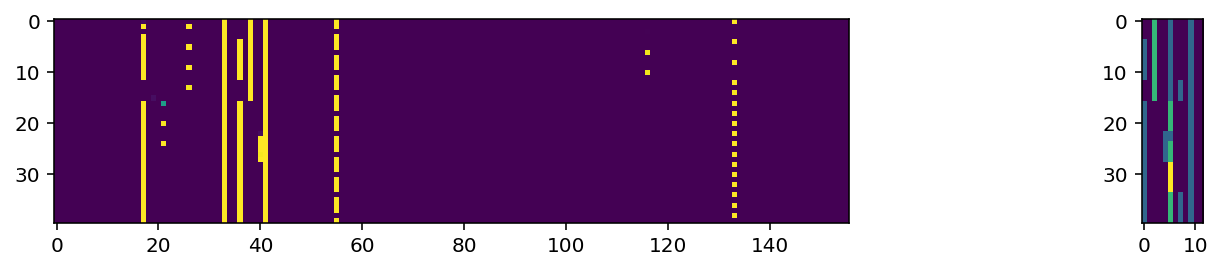

Iter: 162000
D_Loss: 2.251e-05
G_Loss: 19.89


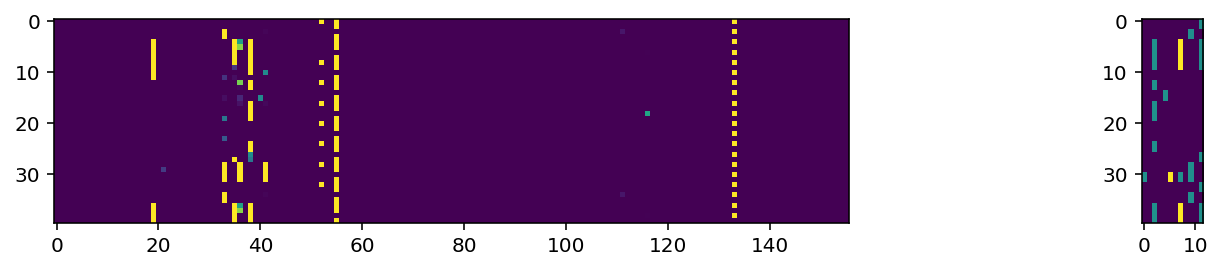

Iter: 163000
D_Loss: 1.85e-13
G_Loss: 38.06


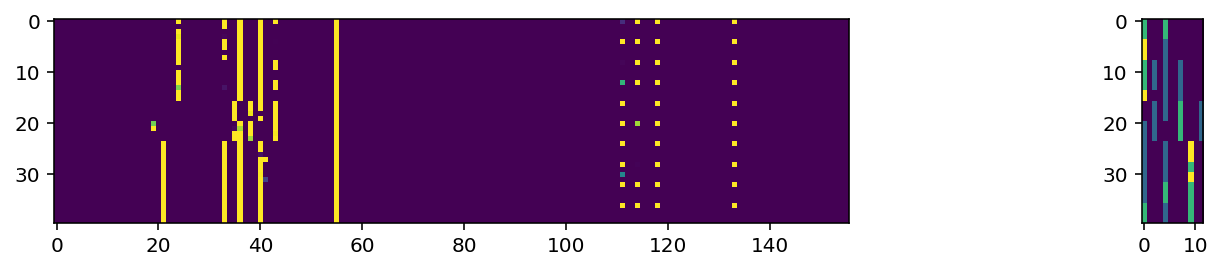

Iter: 164000
D_Loss: 6.297e-09
G_Loss: 27.28


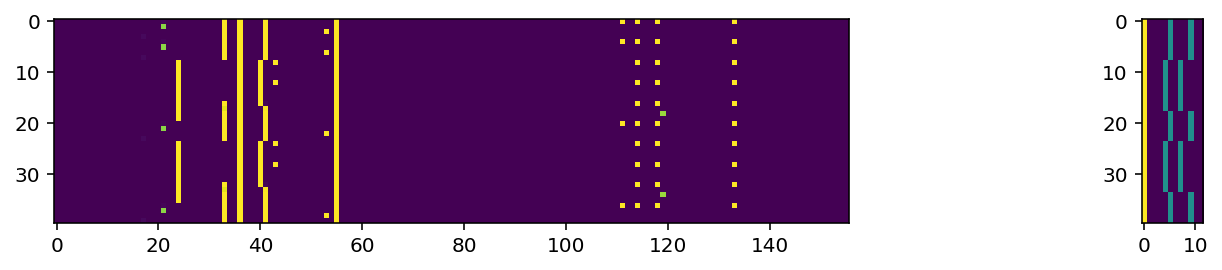

Iter: 165000
D_Loss: 1.137e-12
G_Loss: 33.6


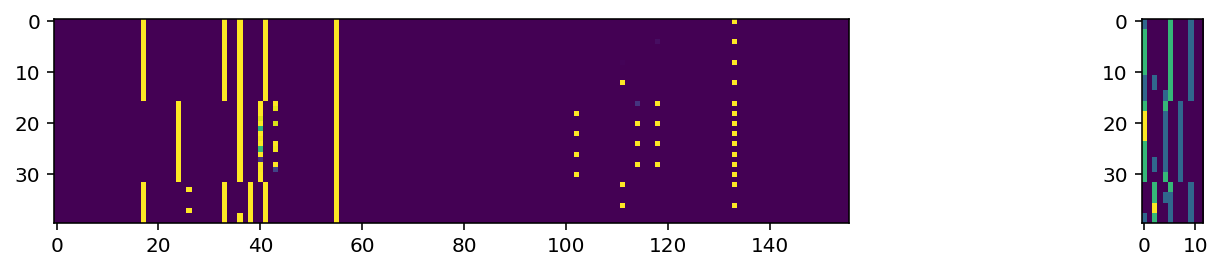

Iter: 166000
D_Loss: 6.034e-07
G_Loss: 19.71


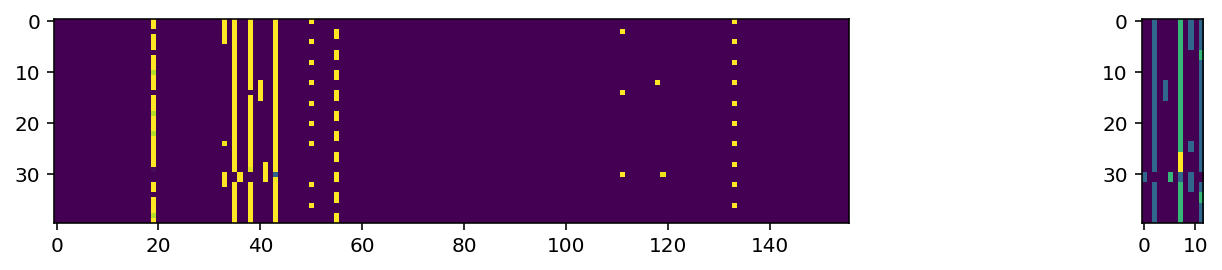

Iter: 167000
D_Loss: 0.000454
G_Loss: 10.85


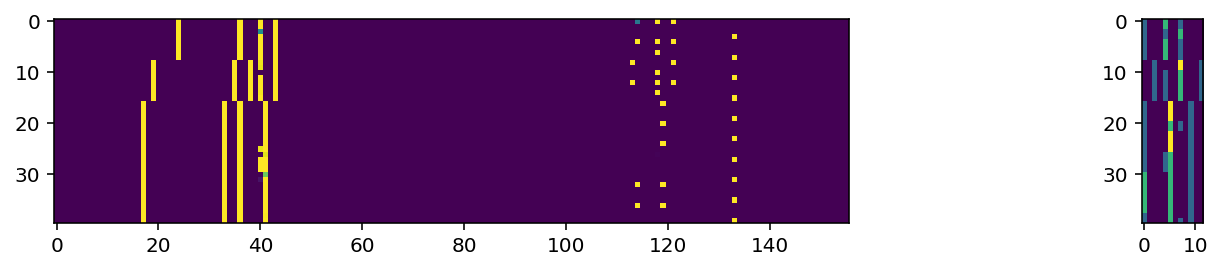

Iter: 168000
D_Loss: 0.0002854
G_Loss: 16.67


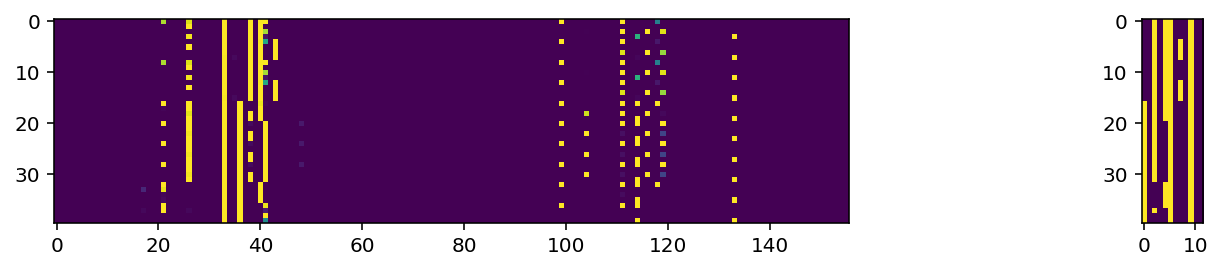

Iter: 169000
D_Loss: 0.0001494
G_Loss: 9.452


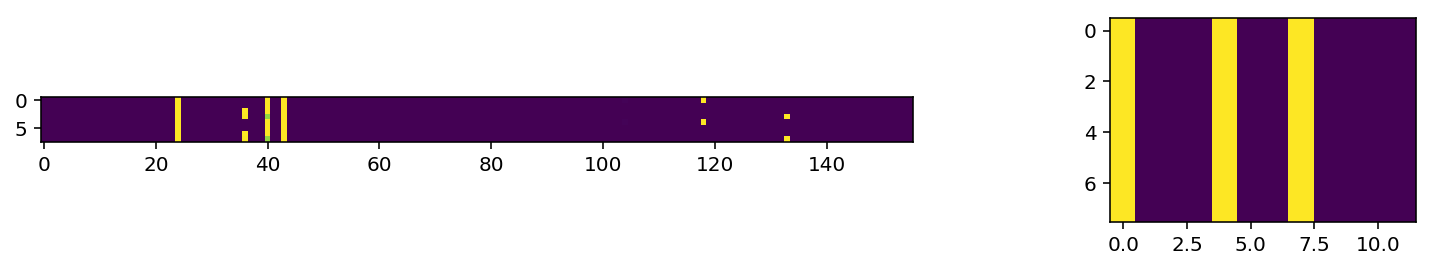

Iter: 170000
D_Loss: 3.368e-06
G_Loss: 16.0


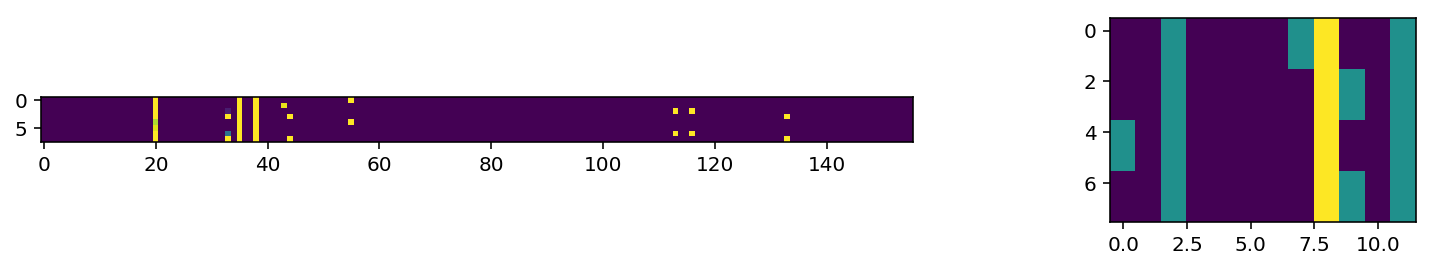

Iter: 171000
D_Loss: 3.207e-05
G_Loss: 17.23


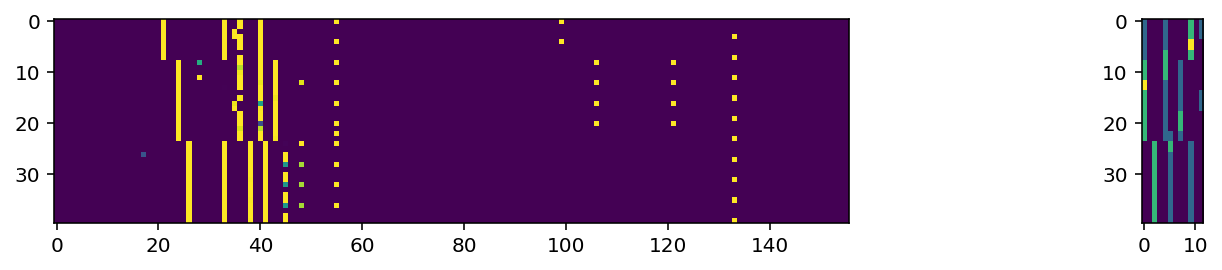

Iter: 172000
D_Loss: 1.12e-06
G_Loss: 18.08


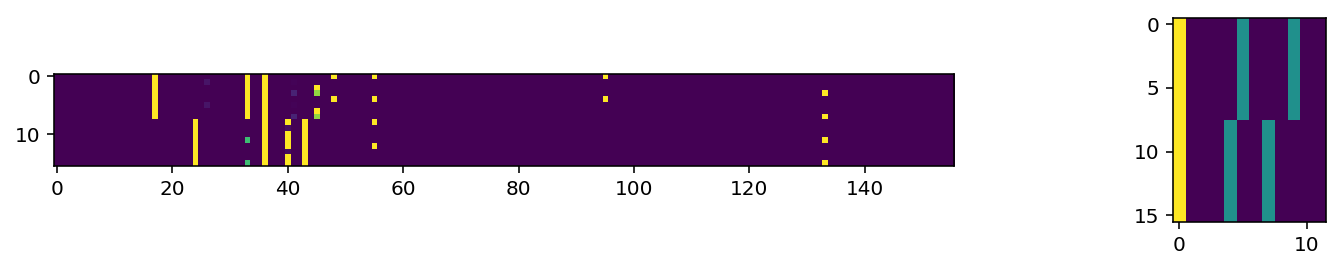

Iter: 173000
D_Loss: 1.719e-06
G_Loss: 22.48


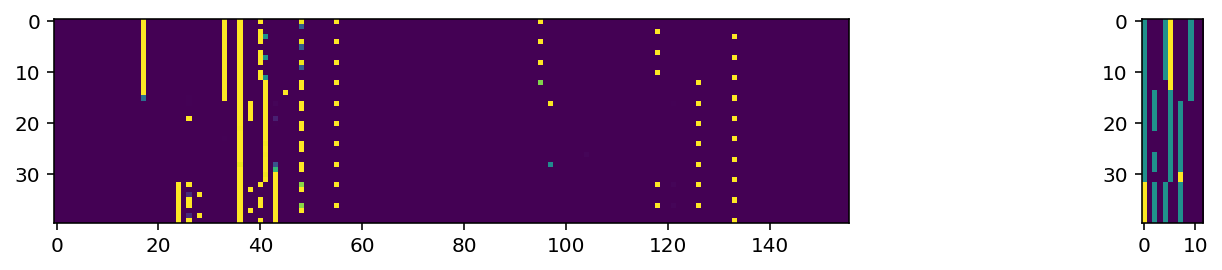

Iter: 174000
D_Loss: 6.972e-05
G_Loss: 19.25


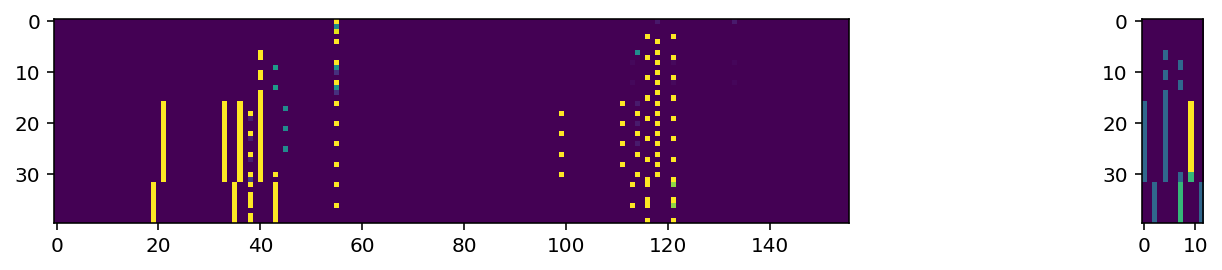

Iter: 175000
D_Loss: 0.1169
G_Loss: 14.31


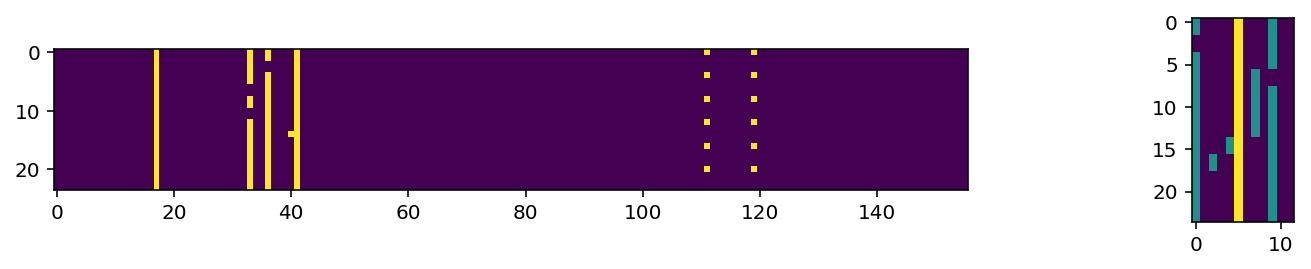

Iter: 176000
D_Loss: 0.6543
G_Loss: 5.366


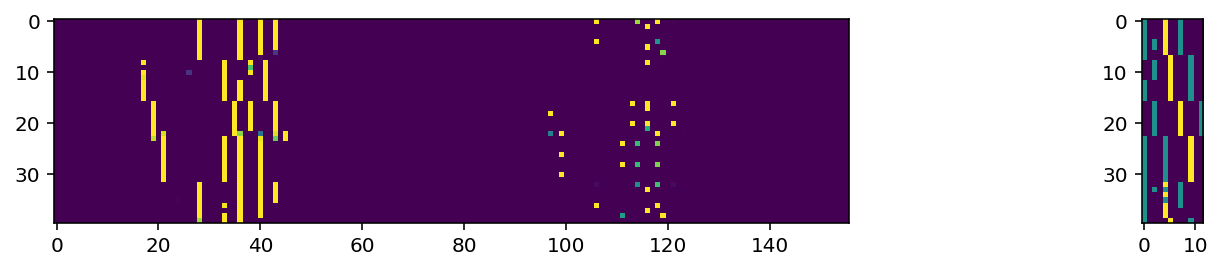

Iter: 177000
D_Loss: 0.9686
G_Loss: 5.834


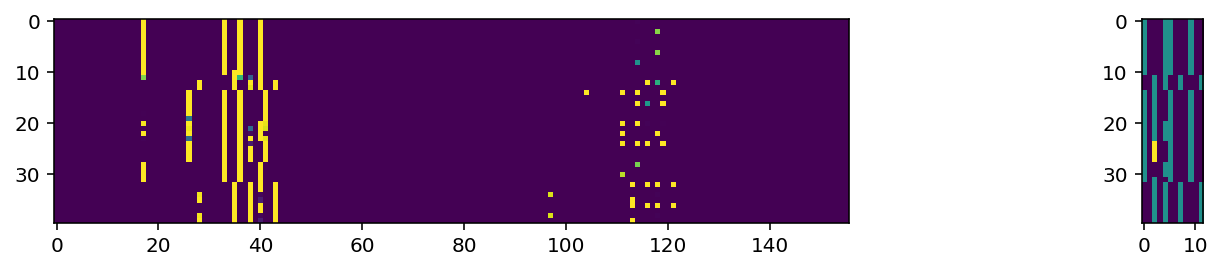

Iter: 178000
D_Loss: 0.06418
G_Loss: 12.41


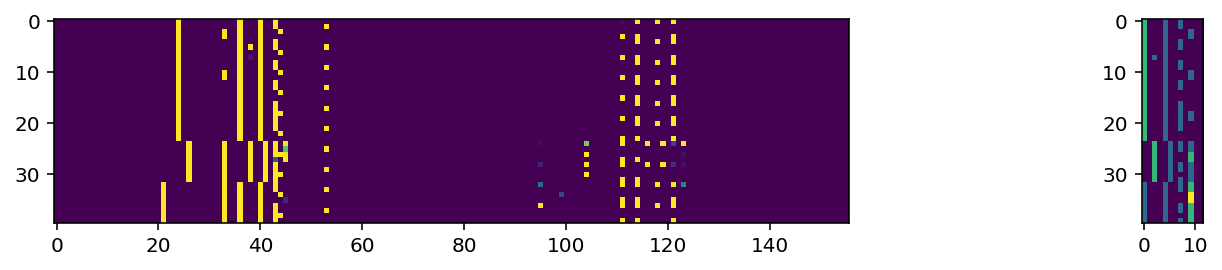

Iter: 179000
D_Loss: 0.00635
G_Loss: 10.14


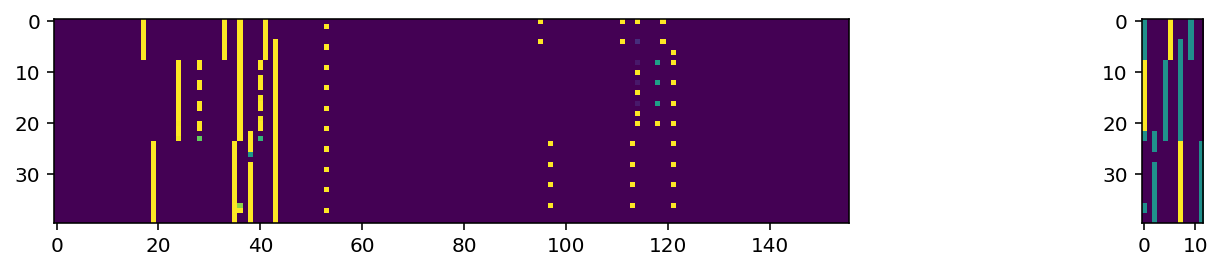

Iter: 180000
D_Loss: 0.0001508
G_Loss: 11.06


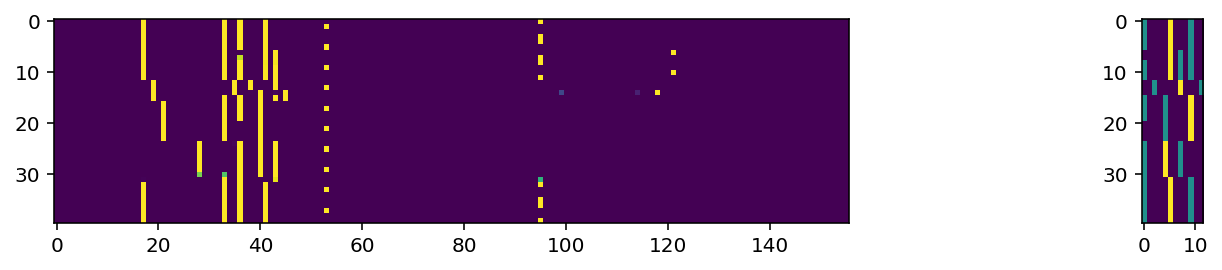

Iter: 181000
D_Loss: 0.008586
G_Loss: 15.33


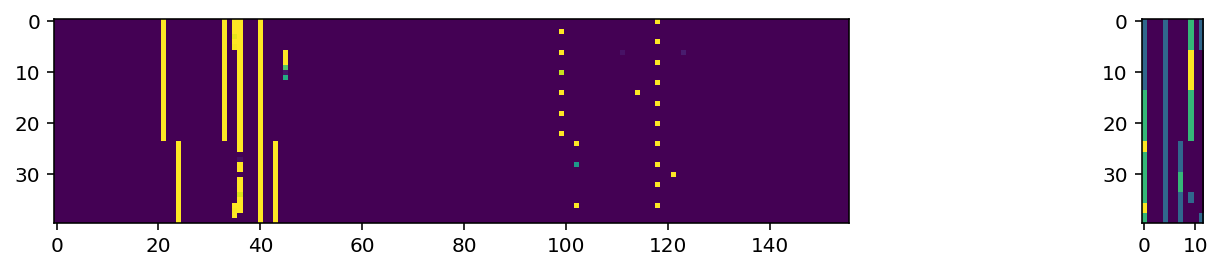

Iter: 182000
D_Loss: 0.03512
G_Loss: 10.74


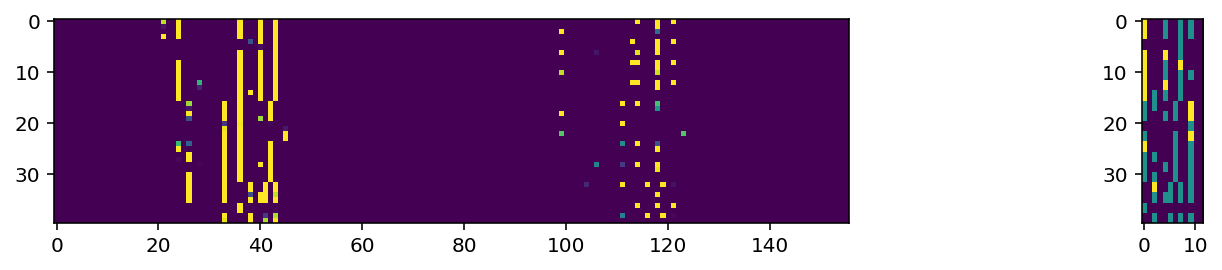

Iter: 183000
D_Loss: 2.275
G_Loss: 0.7756


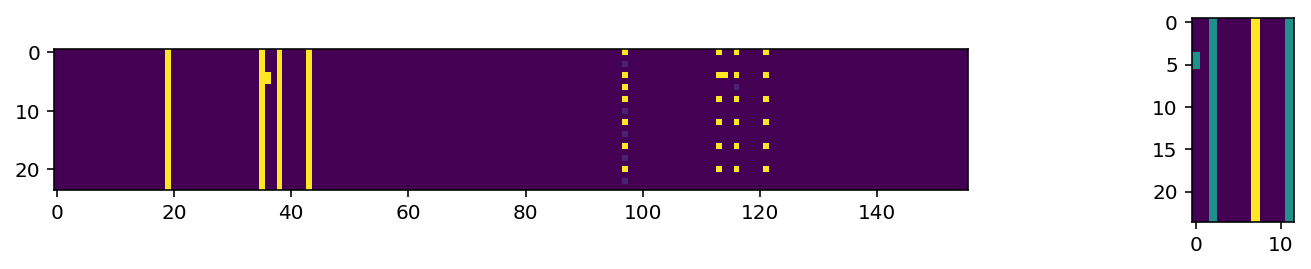

Iter: 184000
D_Loss: 1.146
G_Loss: 2.182


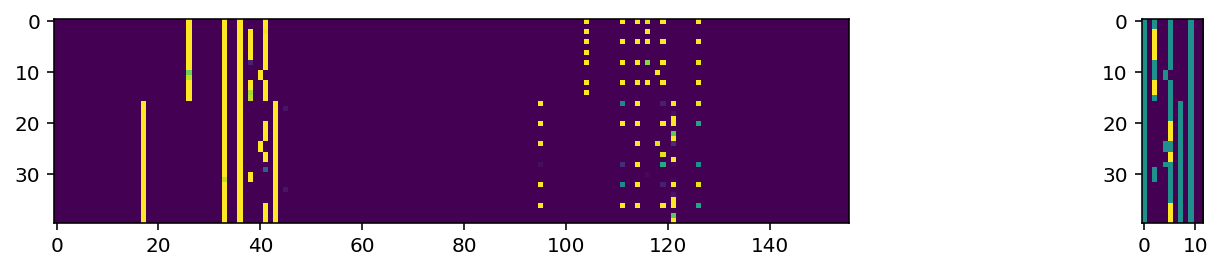

Iter: 185000
D_Loss: 1.277
G_Loss: 2.843


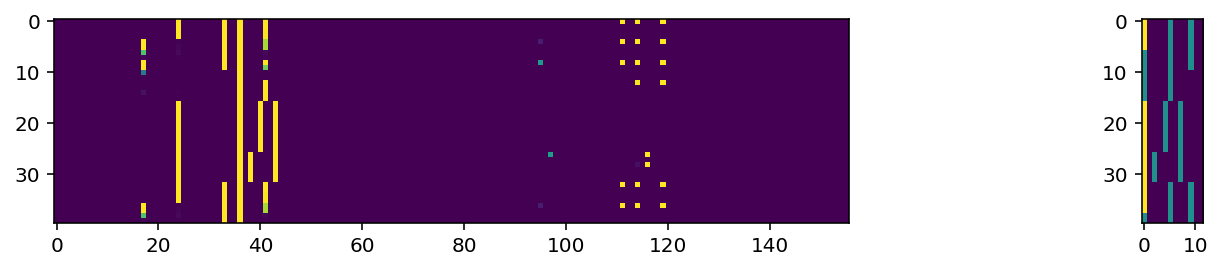

Iter: 186000
D_Loss: 0.5333
G_Loss: 3.481


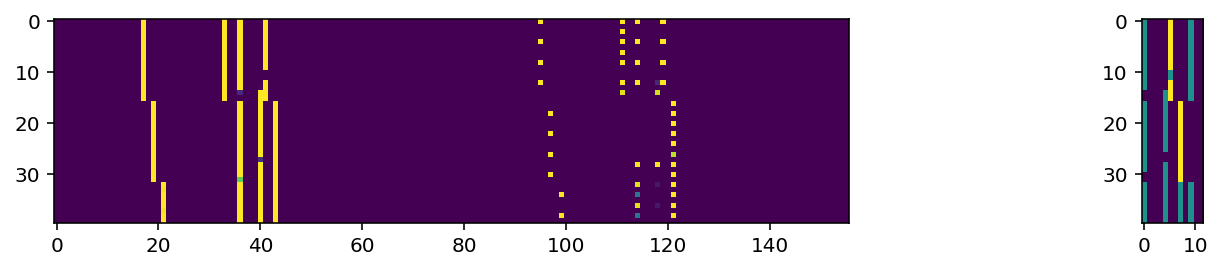

Iter: 187000
D_Loss: 0.5706
G_Loss: 4.193


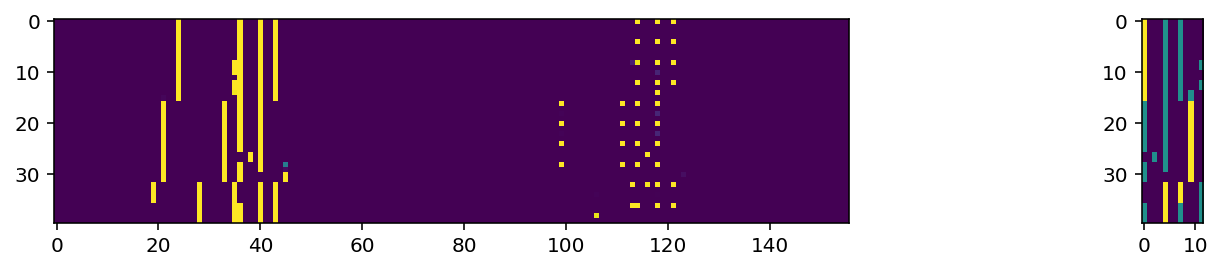

Iter: 188000
D_Loss: 0.2397
G_Loss: 21.1


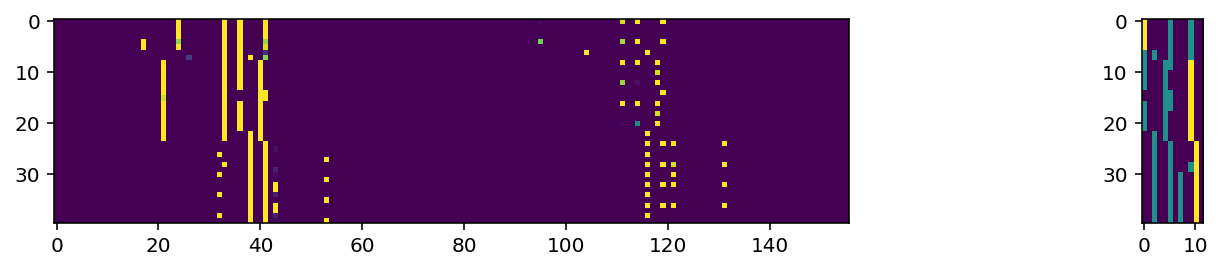

Iter: 189000
D_Loss: 8.63e-09
G_Loss: 23.35


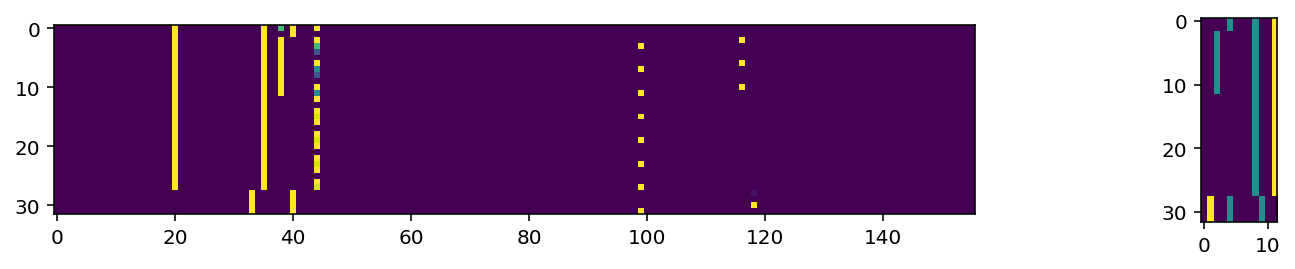

Iter: 190000
D_Loss: 0.3451
G_Loss: 7.083


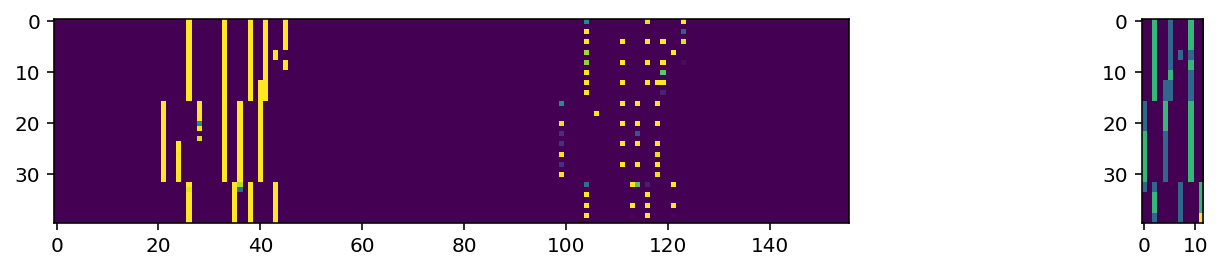

Iter: 191000
D_Loss: 0.004098
G_Loss: 7.741


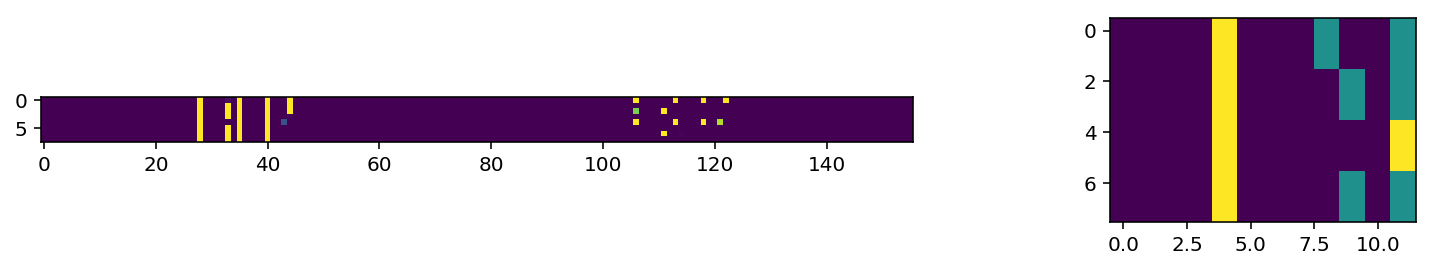

Iter: 192000
D_Loss: 0.2665
G_Loss: 6.07


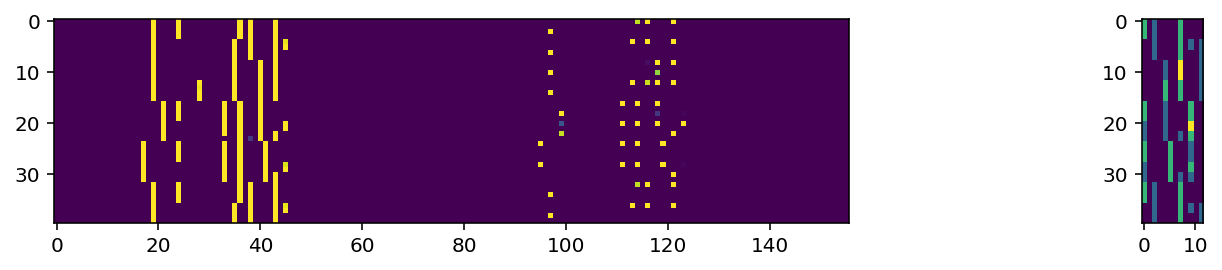

Iter: 193000
D_Loss: 1.051
G_Loss: 3.248


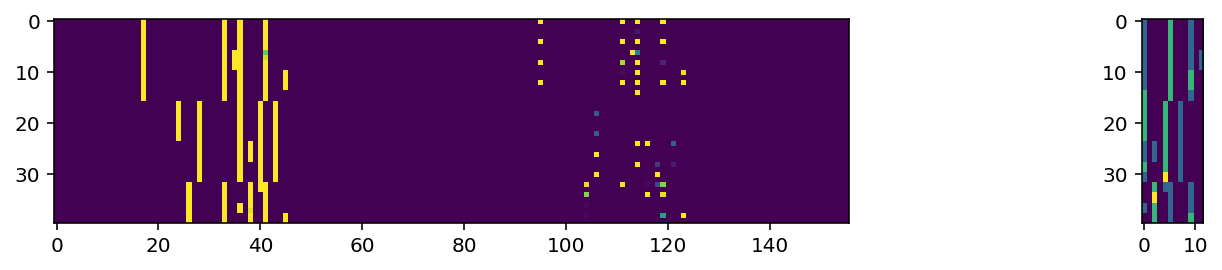

Iter: 194000
D_Loss: 0.8294
G_Loss: 1.41


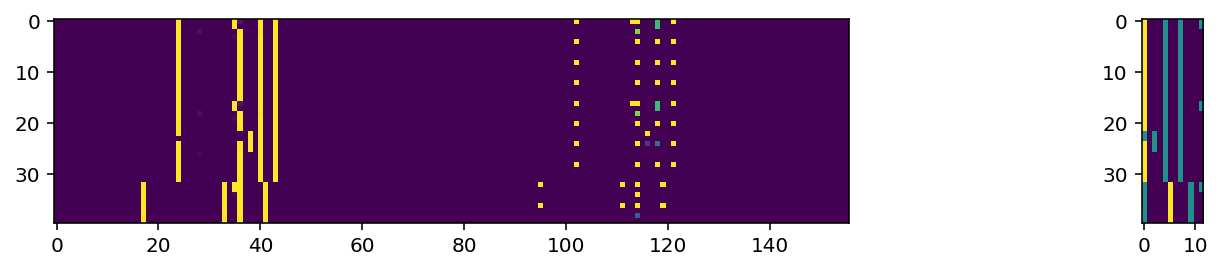

Iter: 195000
D_Loss: 0.03778
G_Loss: 6.538


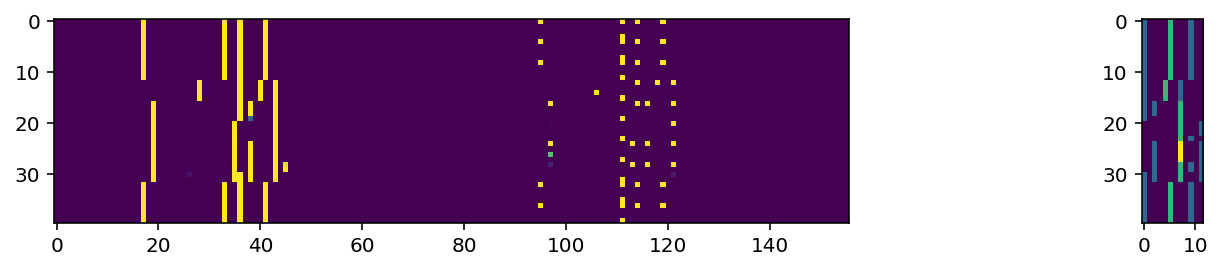

Iter: 196000
D_Loss: 0.000128
G_Loss: 12.07


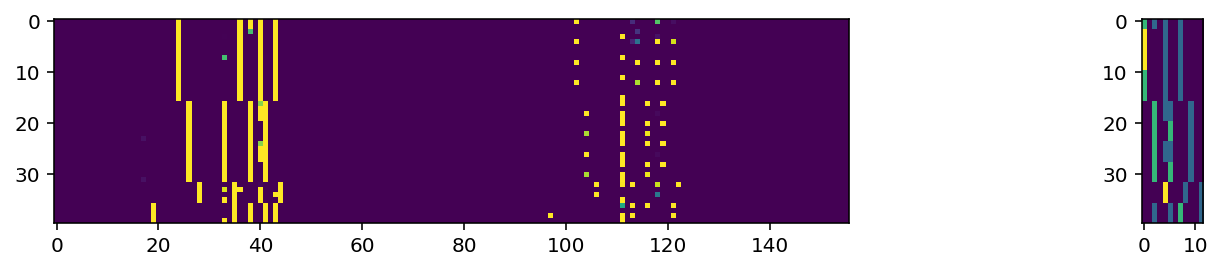

Iter: 197000
D_Loss: 0.0002074
G_Loss: 13.84


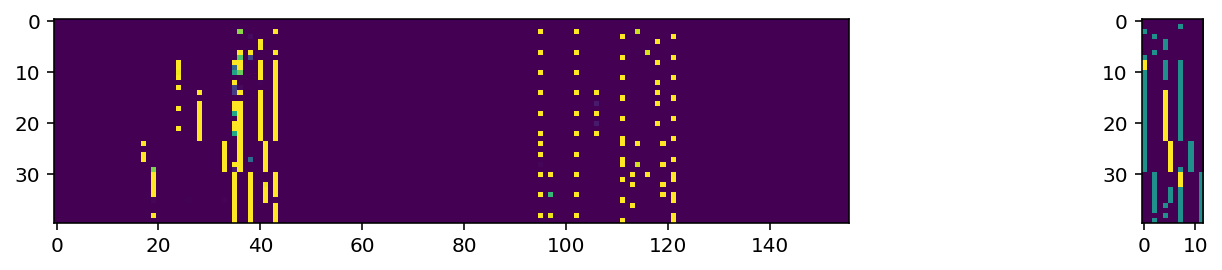

Iter: 198000
D_Loss: 1.997
G_Loss: 12.9


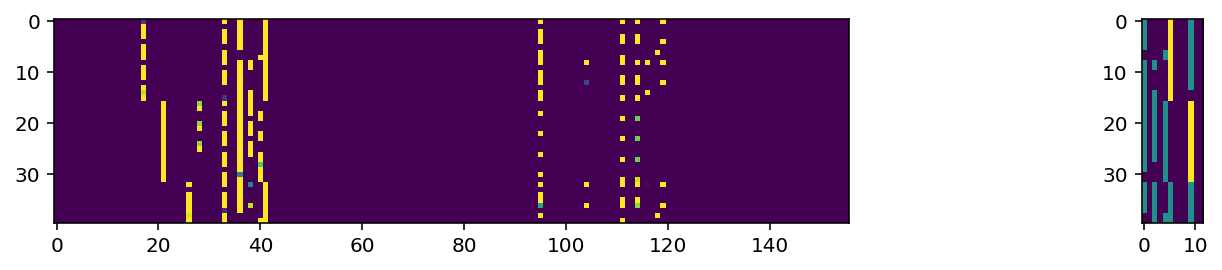

Iter: 199000
D_Loss: 6.657e-05
G_Loss: 14.42


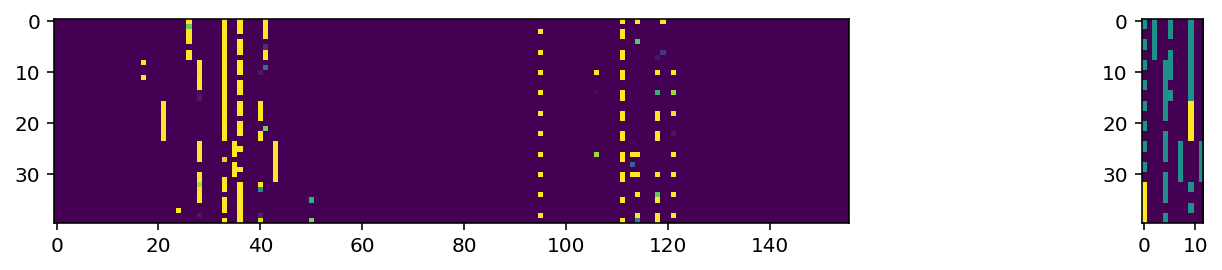

Iter: 200000
D_Loss: 0.000242
G_Loss: 12.65


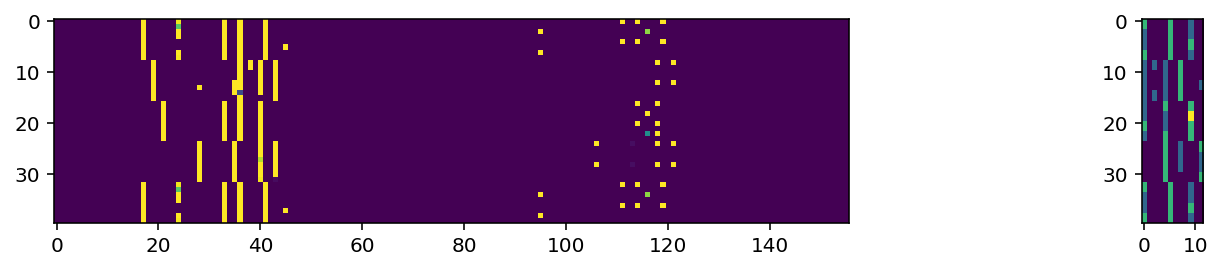

Iter: 201000
D_Loss: 1.738
G_Loss: 5.166


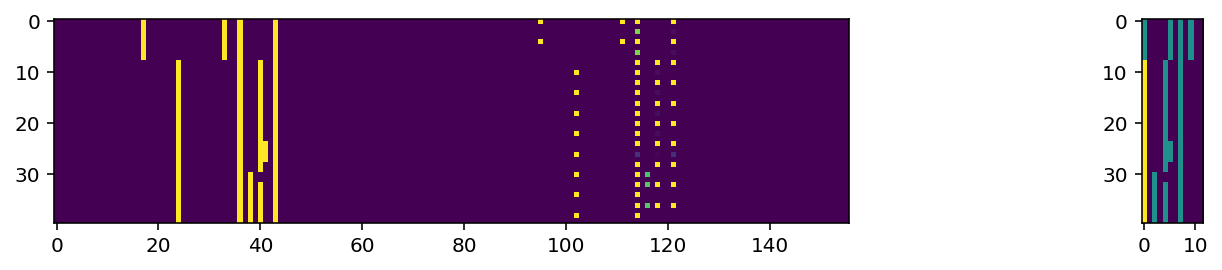

Iter: 202000
D_Loss: 1.366
G_Loss: 2.175


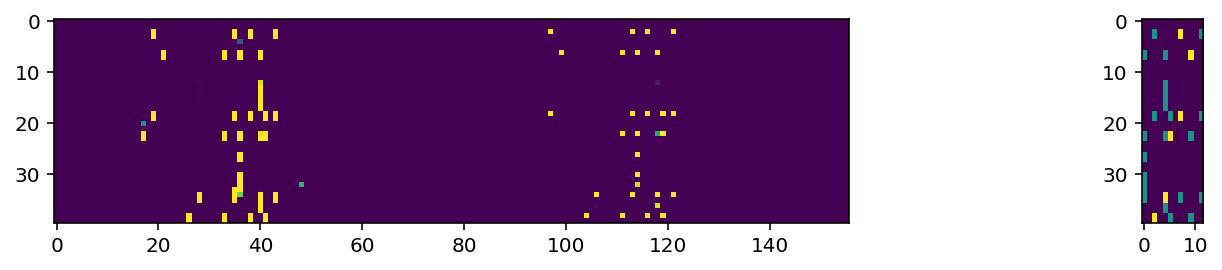

Iter: 203000
D_Loss: 0.02411
G_Loss: 7.343


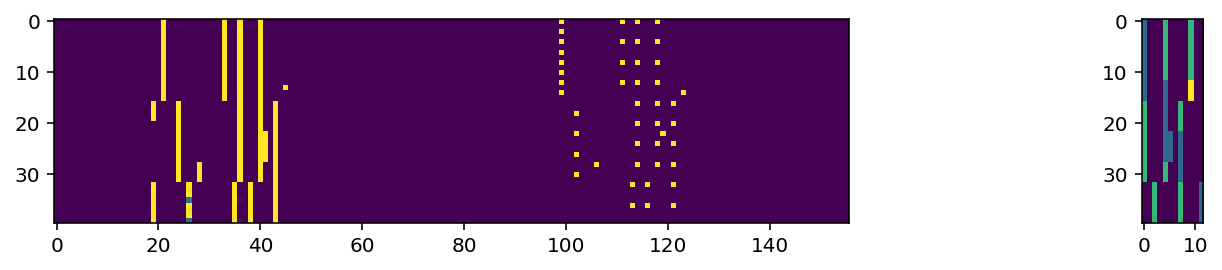

Iter: 204000
D_Loss: 0.8518
G_Loss: 1.38


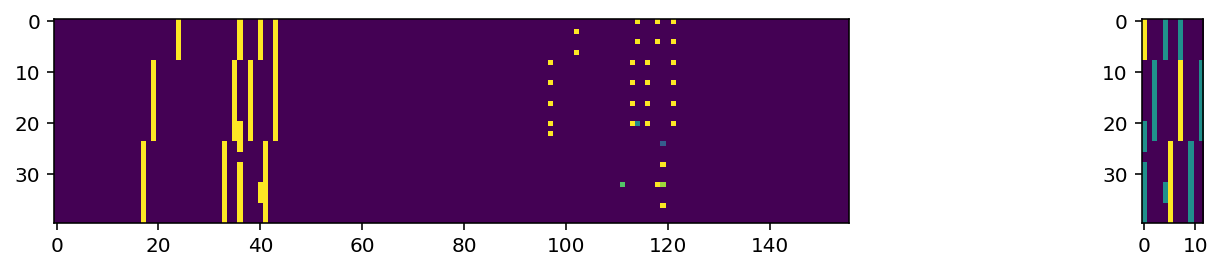

Iter: 205000
D_Loss: 0.4658
G_Loss: 4.274


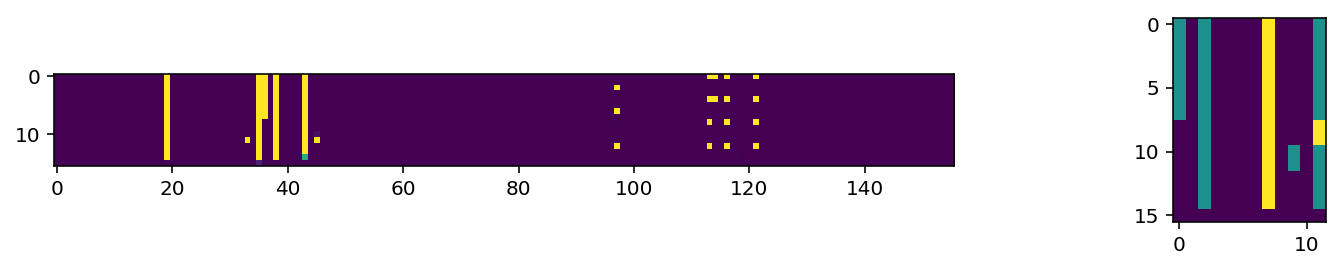

Iter: 206000
D_Loss: 0.2351
G_Loss: 3.94


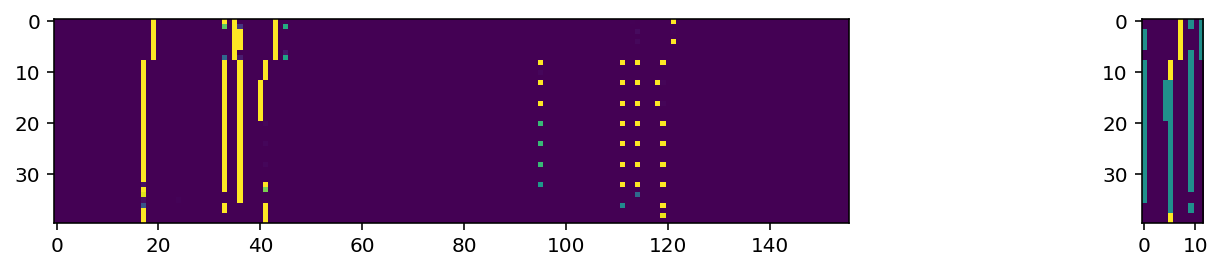

Iter: 207000
D_Loss: 0.6038
G_Loss: 3.673


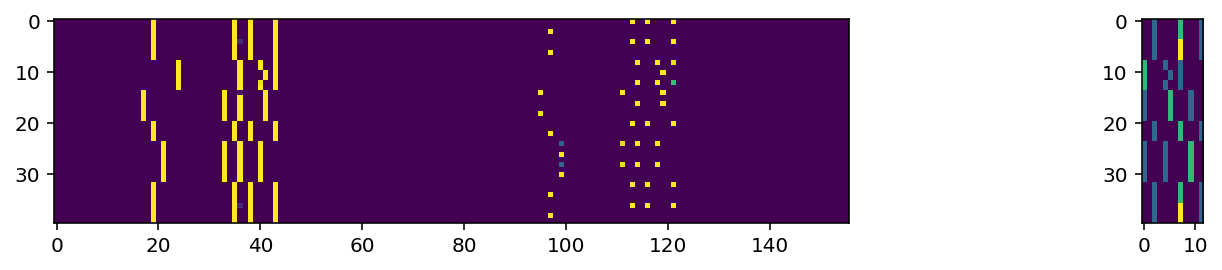

Iter: 208000
D_Loss: 1.202
G_Loss: 1.187


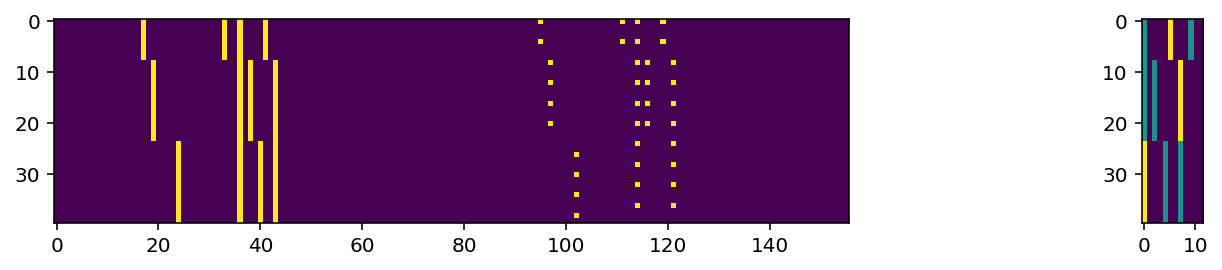

Iter: 209000
D_Loss: 0.047
G_Loss: 6.687


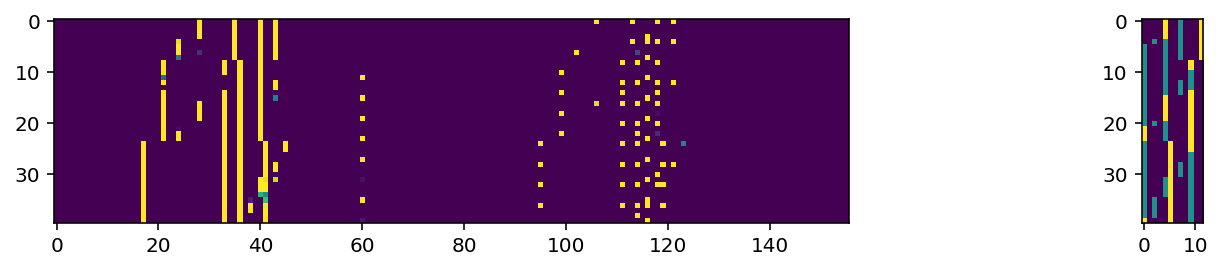

Iter: 210000
D_Loss: 0.3712
G_Loss: 4.351


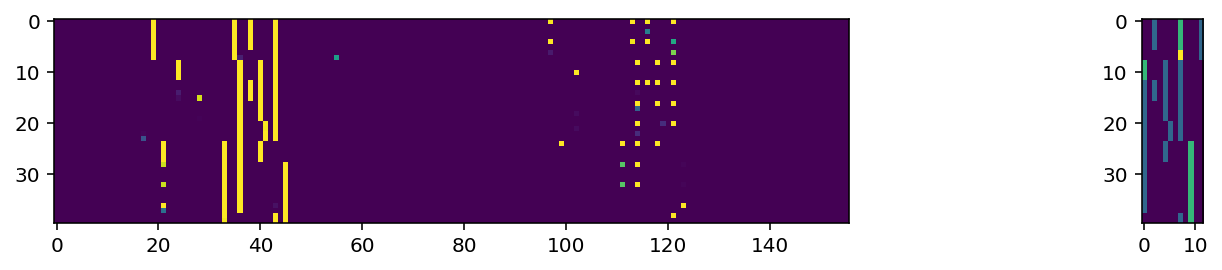

Iter: 211000
D_Loss: 0.008997
G_Loss: 7.926


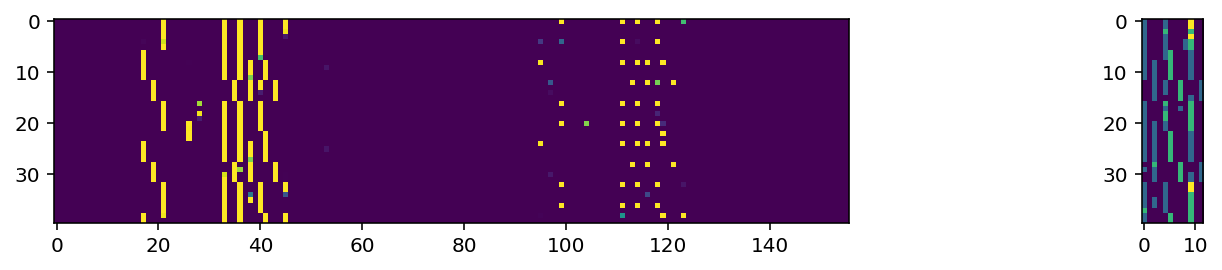

Iter: 212000
D_Loss: 1.1
G_Loss: 1.681


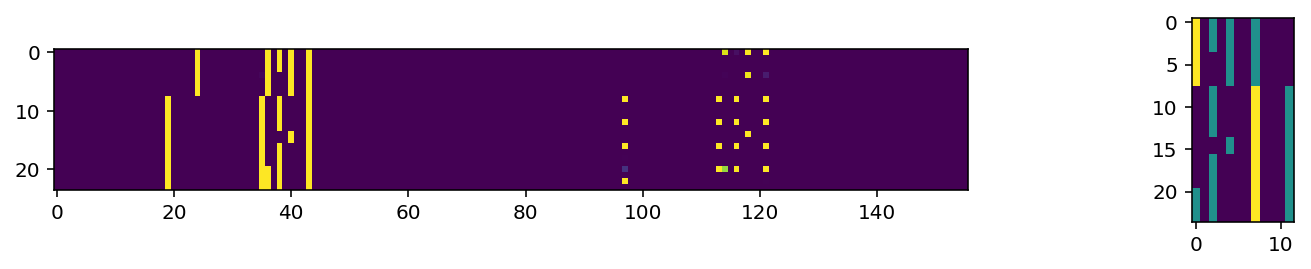

Iter: 213000
D_Loss: 0.5187
G_Loss: 6.667


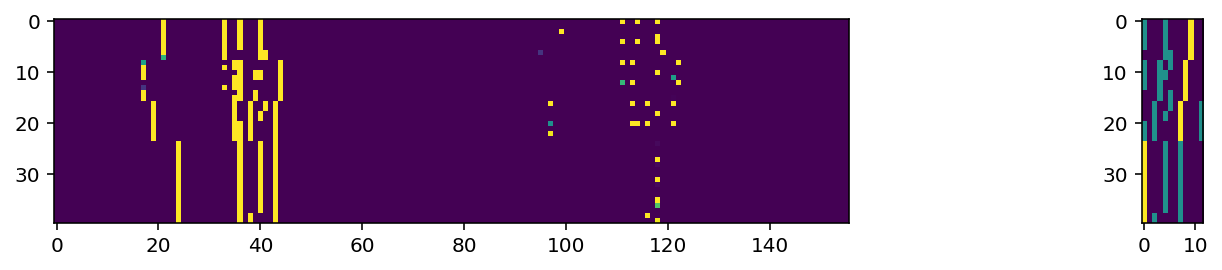

Iter: 214000
D_Loss: 1.221
G_Loss: 1.926


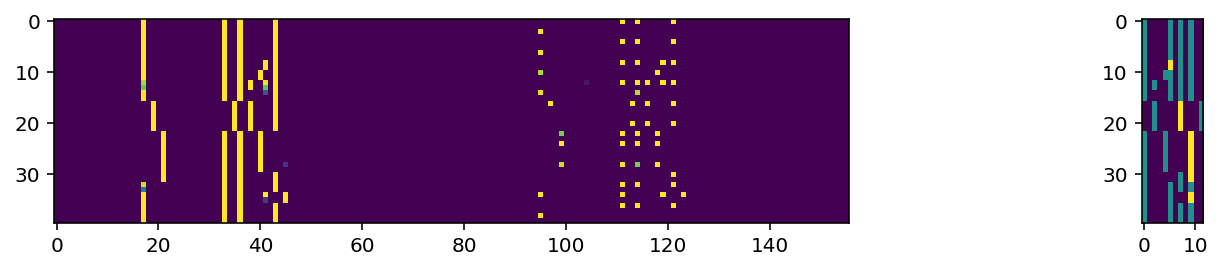

Iter: 215000
D_Loss: 0.3239
G_Loss: 4.249


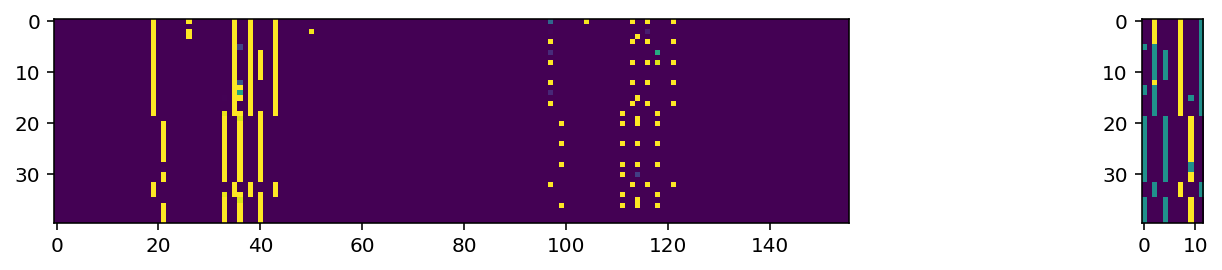

Iter: 216000
D_Loss: 0.04034
G_Loss: 4.699


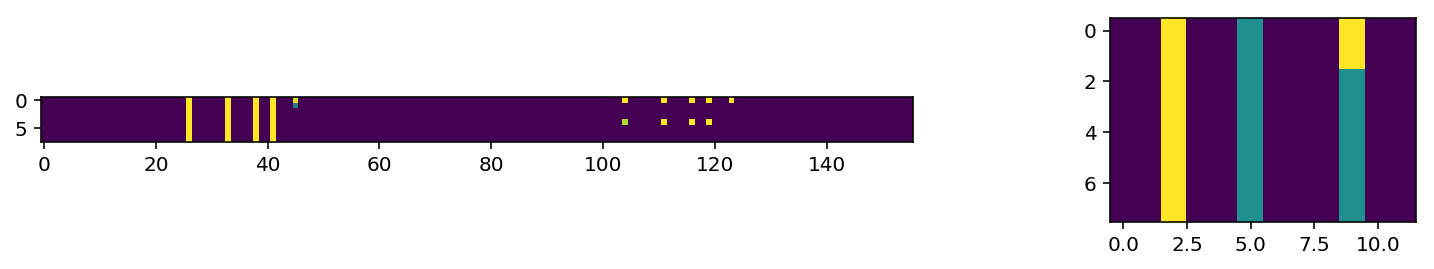

Iter: 217000
D_Loss: 0.1239
G_Loss: 5.433


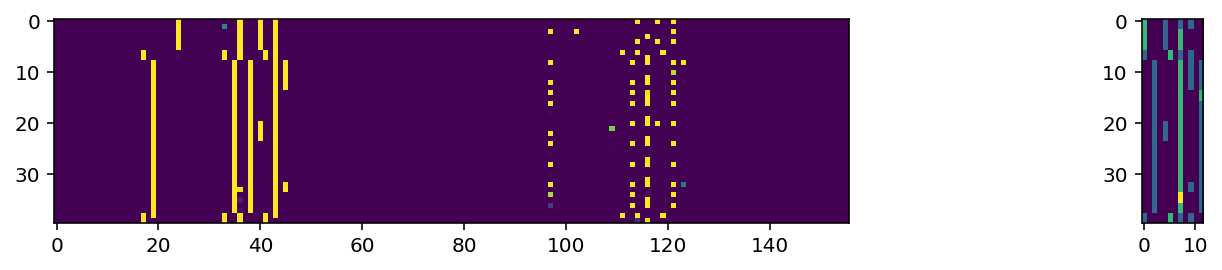

Iter: 218000
D_Loss: 0.581
G_Loss: 5.441


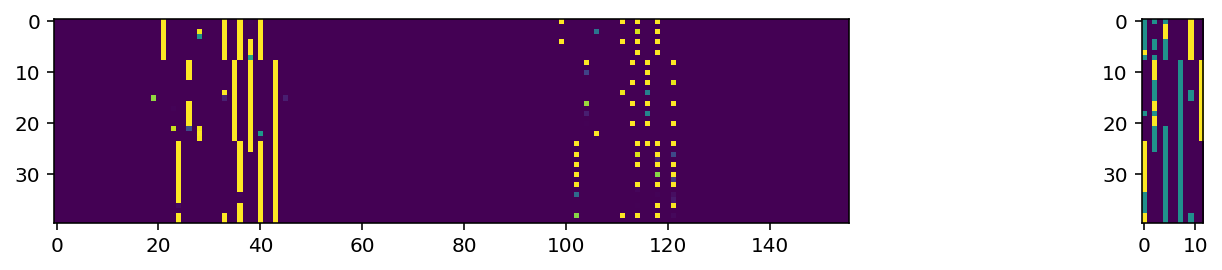

Iter: 219000
D_Loss: 0.7678
G_Loss: 1.512


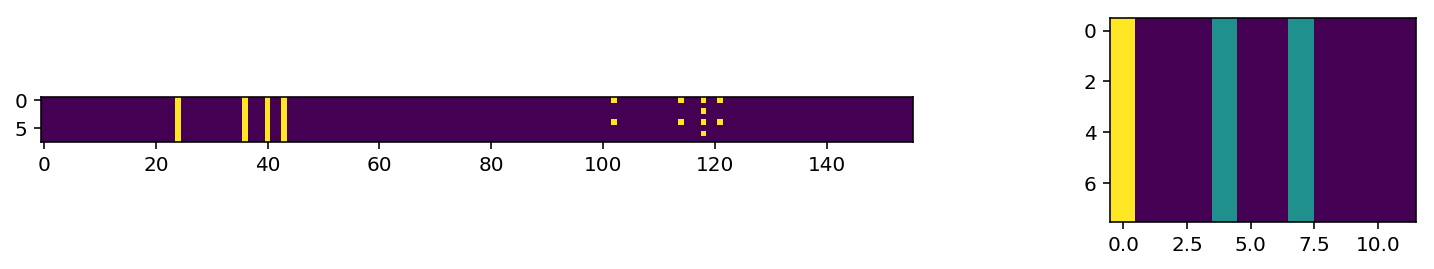

Iter: 220000
D_Loss: 0.5895
G_Loss: 2.373


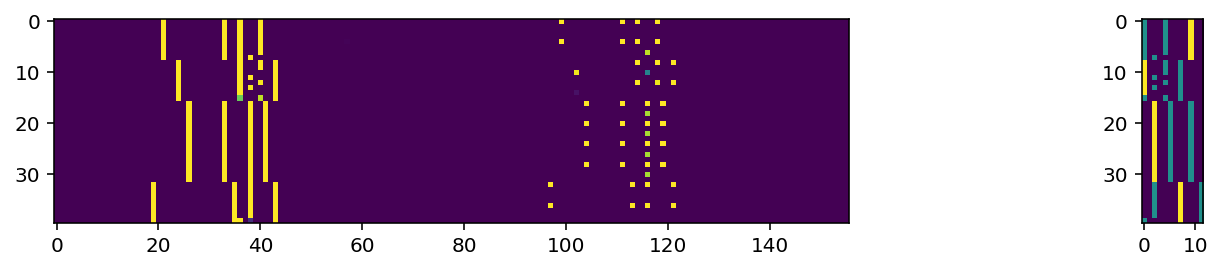

Iter: 221000
D_Loss: 0.157
G_Loss: 5.718


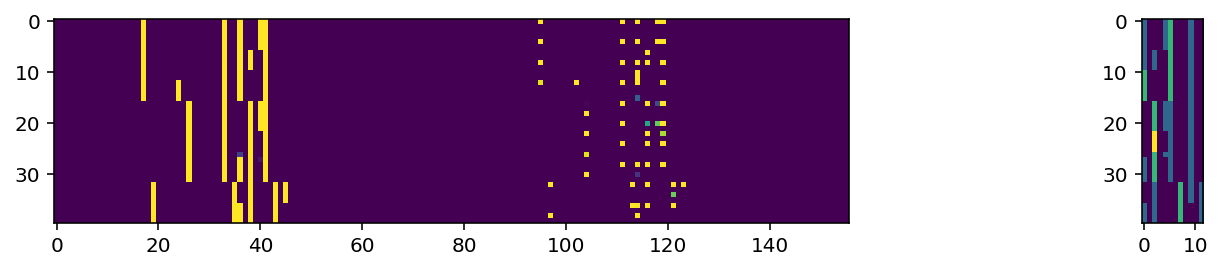

Iter: 222000
D_Loss: 0.2754
G_Loss: 5.229


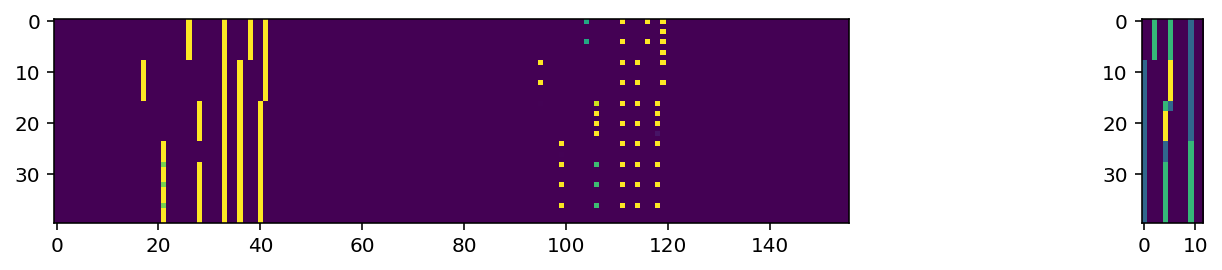

Iter: 223000
D_Loss: 0.8071
G_Loss: 13.32


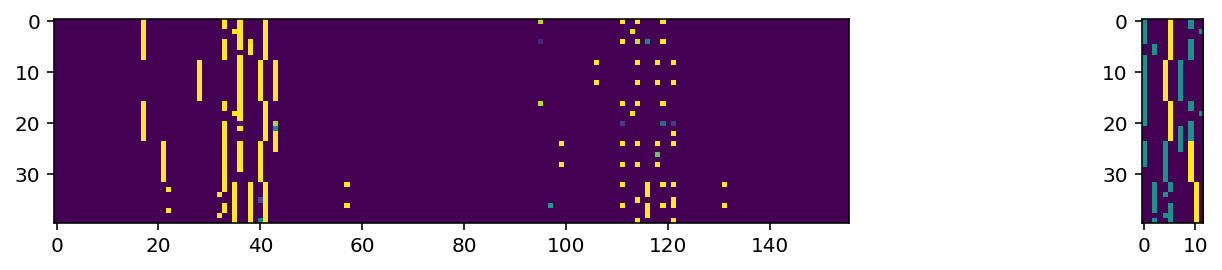

Iter: 224000
D_Loss: 0.198
G_Loss: 9.324


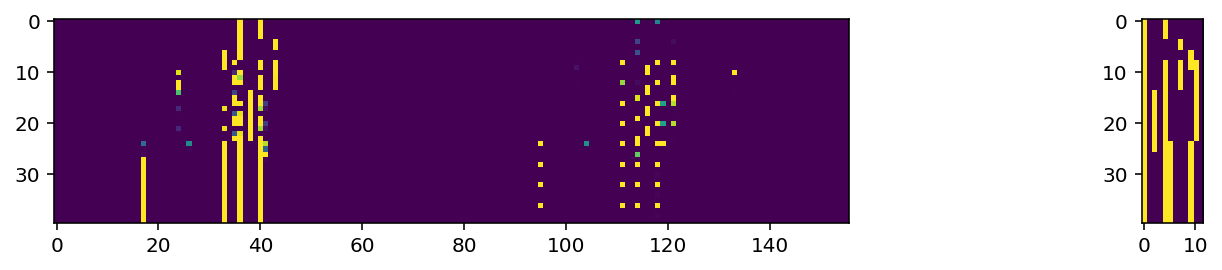

Iter: 225000
D_Loss: 0.9101
G_Loss: 1.521


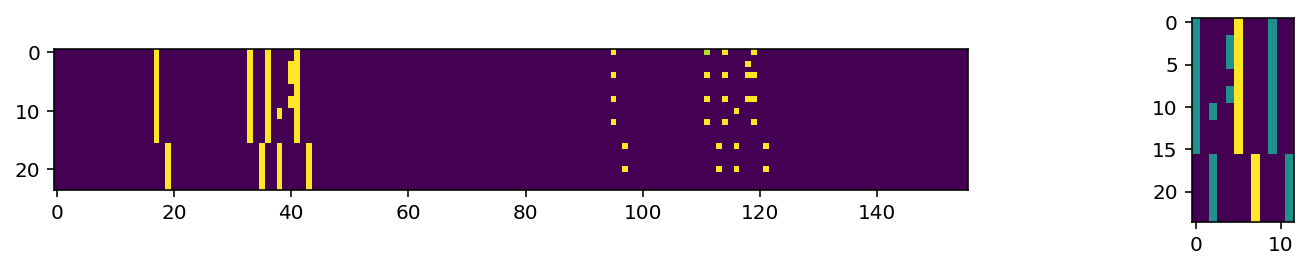

Iter: 226000
D_Loss: 0.3875
G_Loss: 4.57


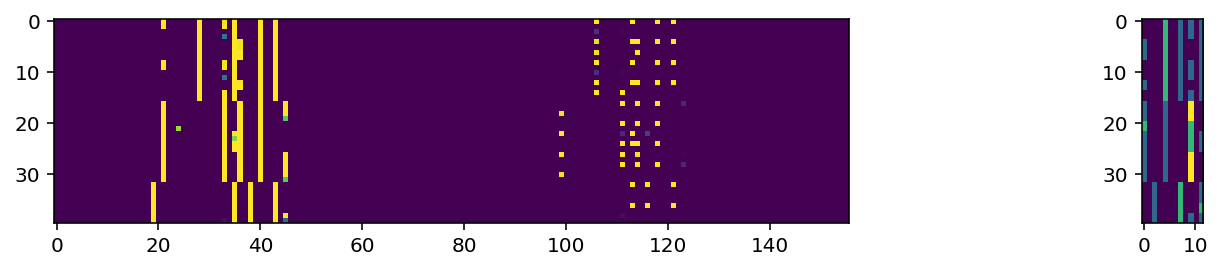

Iter: 227000
D_Loss: 0.6991
G_Loss: 3.107


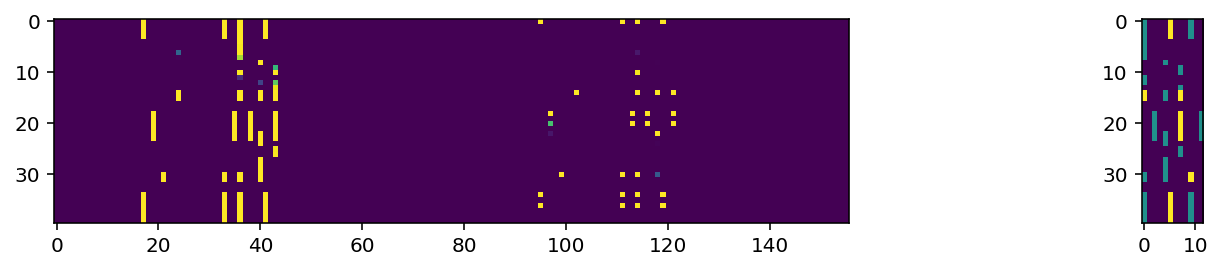

Iter: 228000
D_Loss: 0.6652
G_Loss: 3.124


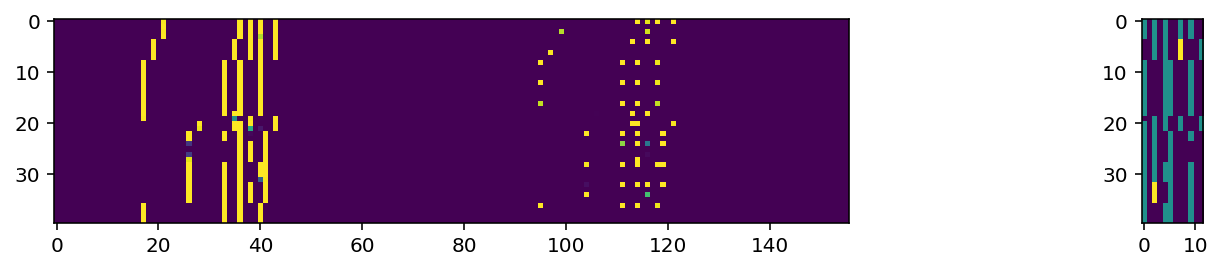

Iter: 229000
D_Loss: 0.3781
G_Loss: 2.246


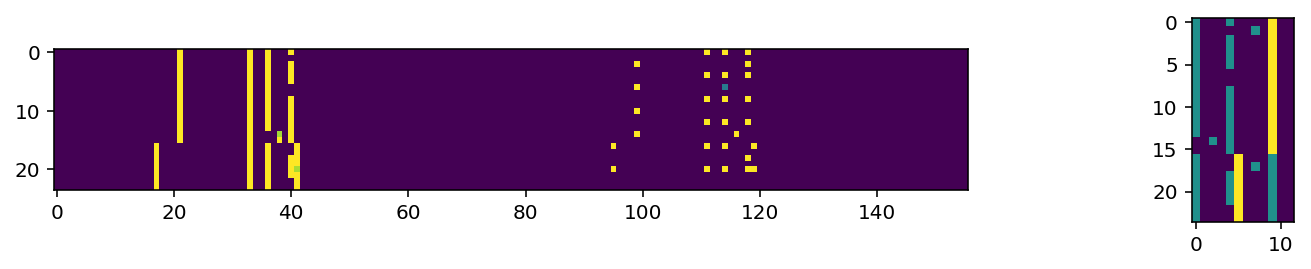

Iter: 230000
D_Loss: 0.5973
G_Loss: 2.14


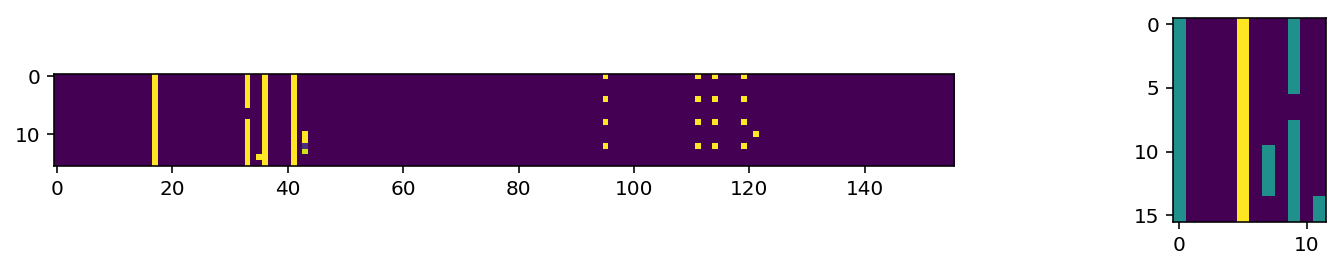

Iter: 231000
D_Loss: 1.365
G_Loss: 2.36


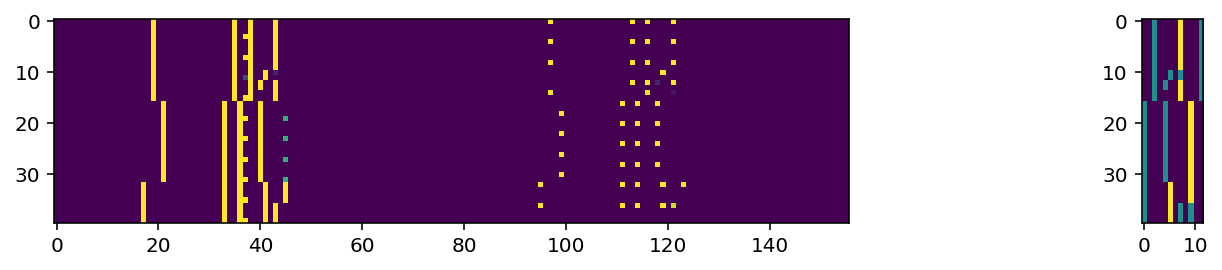

Iter: 232000
D_Loss: 0.01046
G_Loss: 19.17


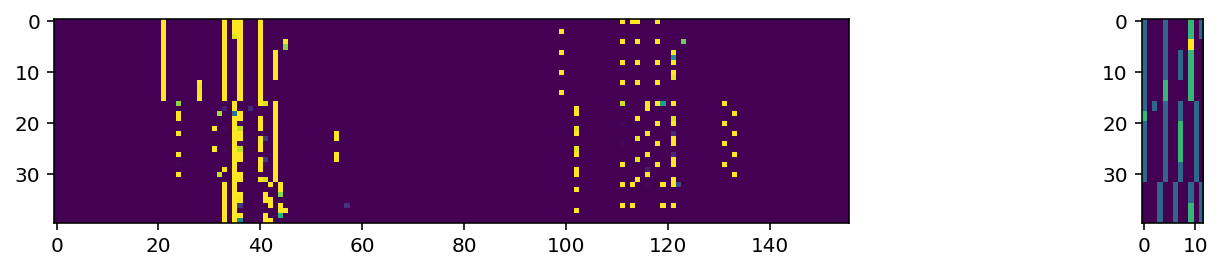

Iter: 233000
D_Loss: 0.1567
G_Loss: 5.181


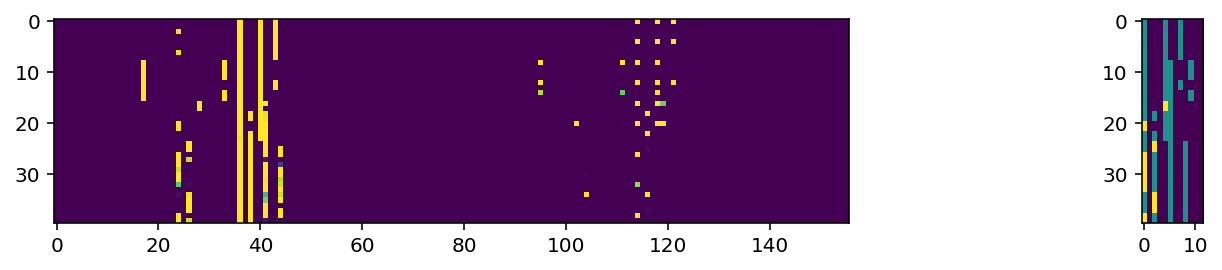

Iter: 234000
D_Loss: 0.8062
G_Loss: 1.724


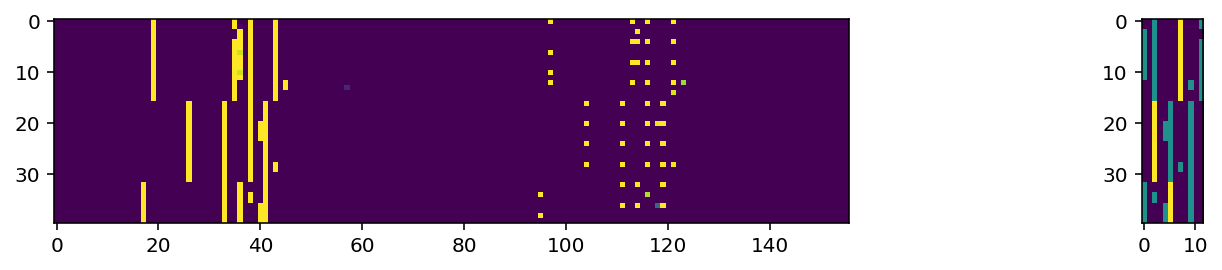

Iter: 235000
D_Loss: 0.7786
G_Loss: 2.197


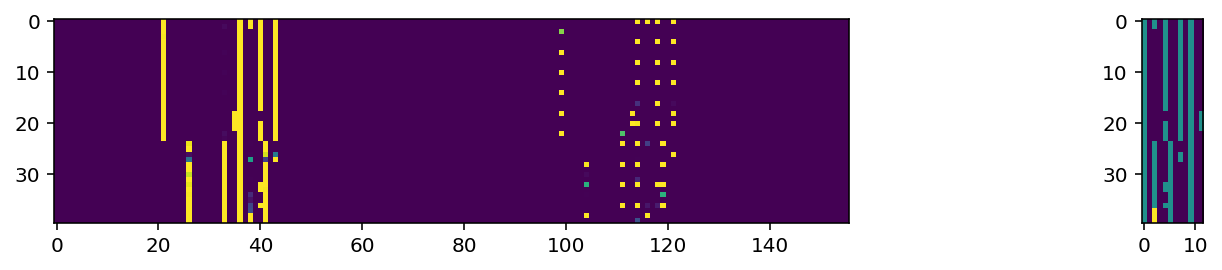

Iter: 236000
D_Loss: 0.1869
G_Loss: 4.918


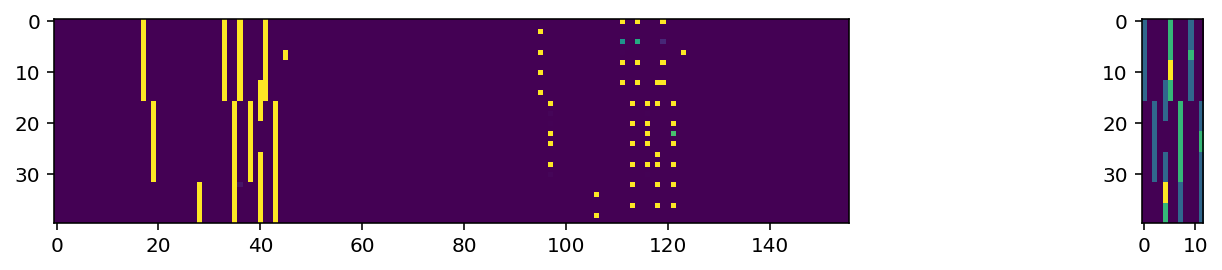

Iter: 237000
D_Loss: 0.2043
G_Loss: 3.066


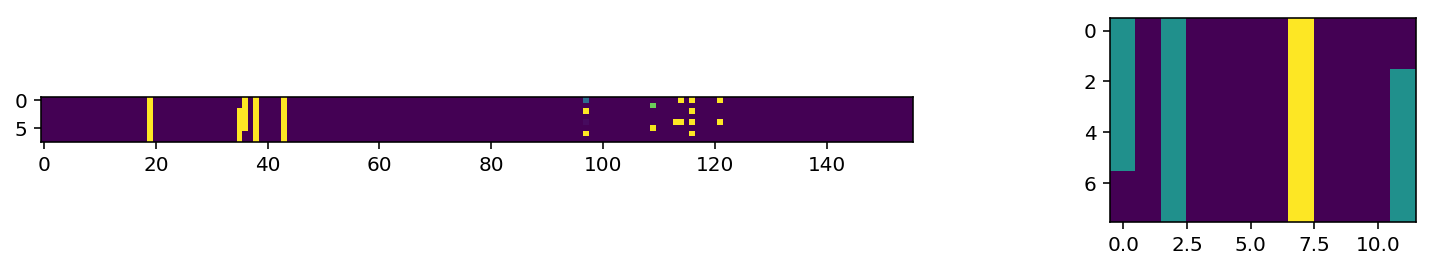

Iter: 238000
D_Loss: 7.951e-06
G_Loss: 13.28


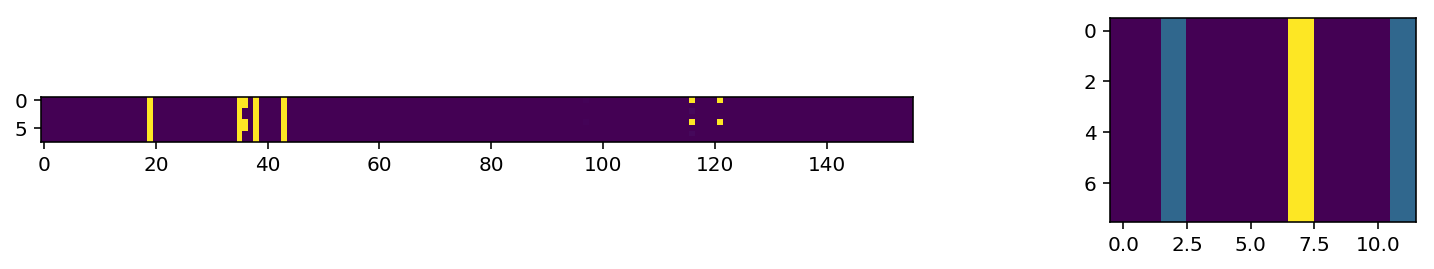

Iter: 239000
D_Loss: 0.3615
G_Loss: 8.319


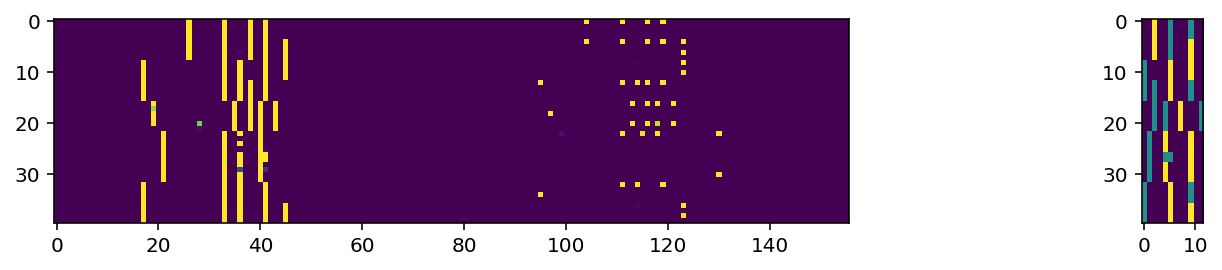

Iter: 240000
D_Loss: 0.5883
G_Loss: 7.488


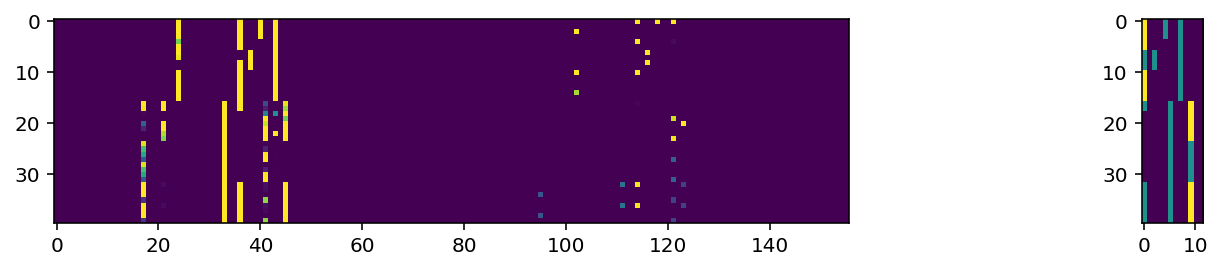

Iter: 241000
D_Loss: 1.134
G_Loss: 1.946


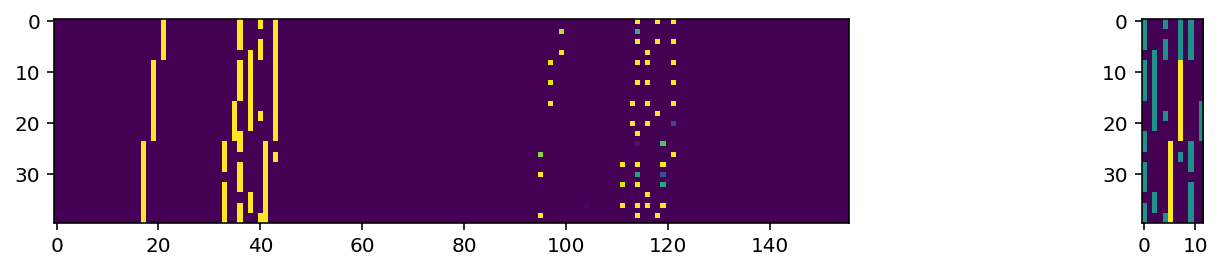

Iter: 242000
D_Loss: 1.061
G_Loss: 3.776


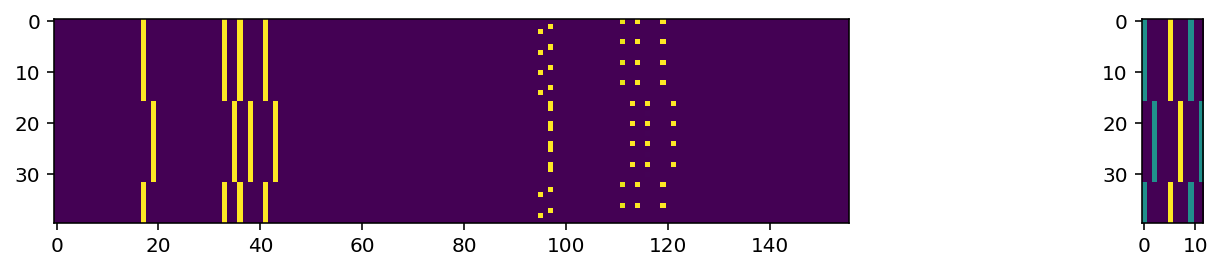

Iter: 243000
D_Loss: 0.01677
G_Loss: 5.986


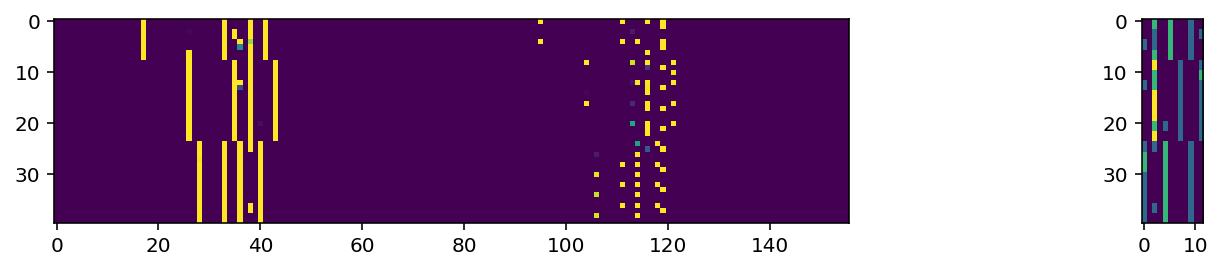

Iter: 244000
D_Loss: 0.2085
G_Loss: 6.565


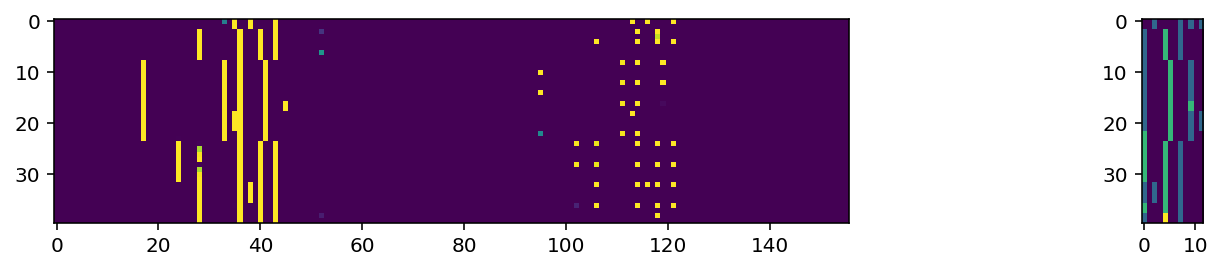

Iter: 245000
D_Loss: 0.9701
G_Loss: 1.305


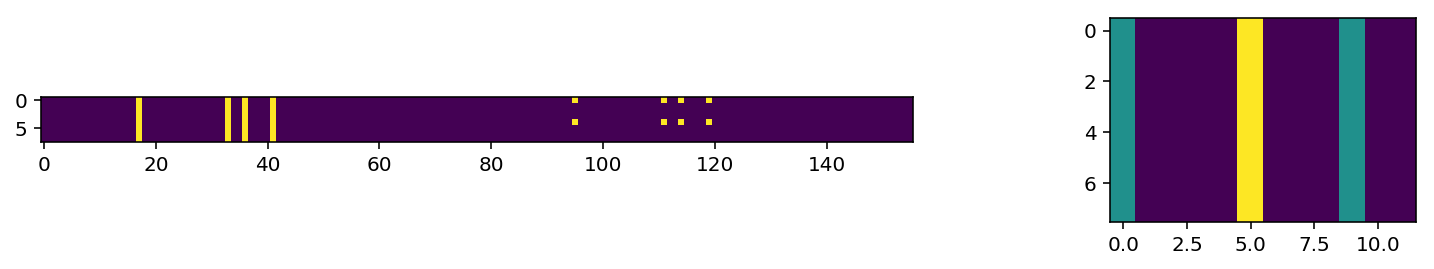

Iter: 246000
D_Loss: 0.03965
G_Loss: 5.162


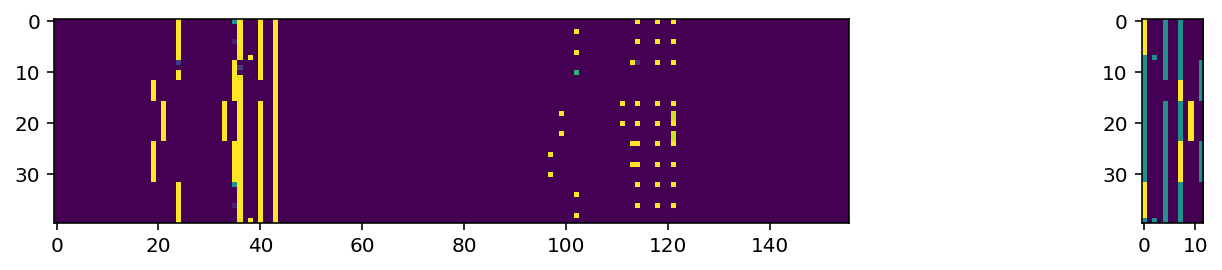

Iter: 247000
D_Loss: 0.4517
G_Loss: 7.063


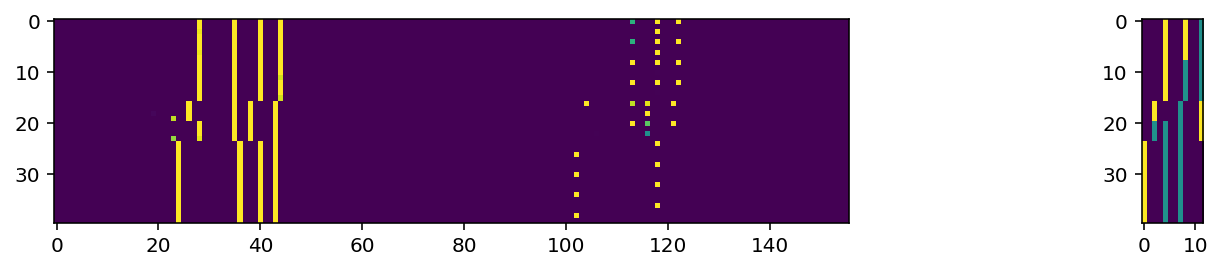

Iter: 248000
D_Loss: 0.8356
G_Loss: 2.574


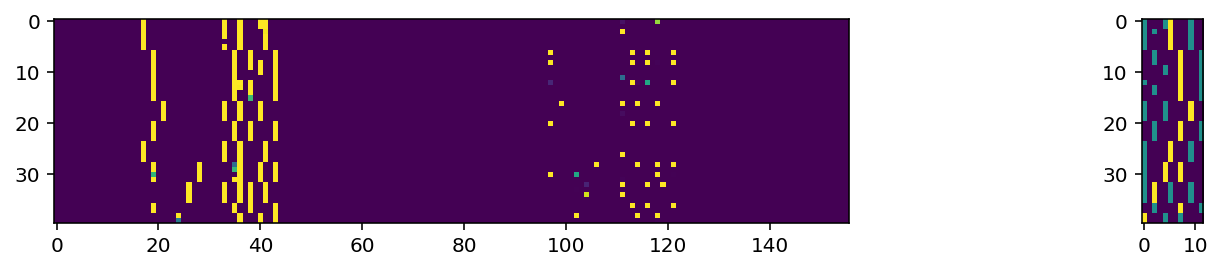

Iter: 249000
D_Loss: 0.7258
G_Loss: 1.822


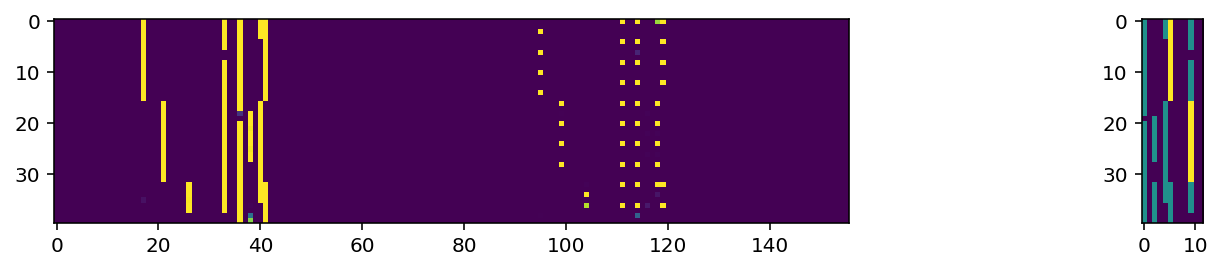

Iter: 250000
D_Loss: 0.08291
G_Loss: 3.79


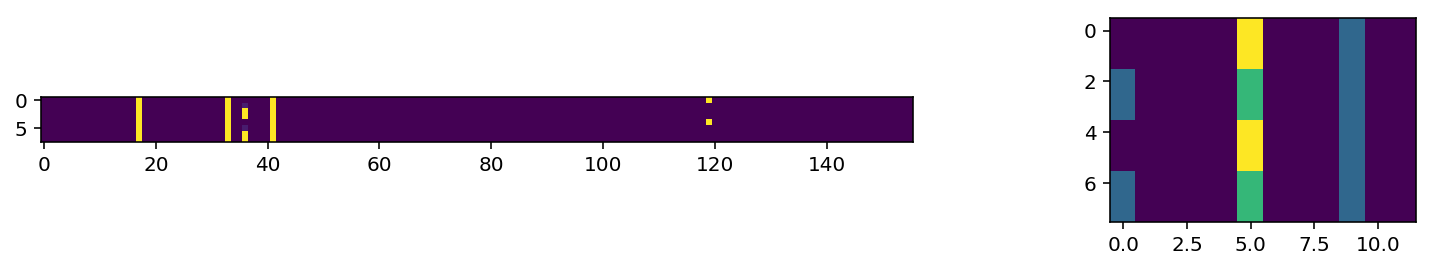

Iter: 251000
D_Loss: 0.4012
G_Loss: 6.124


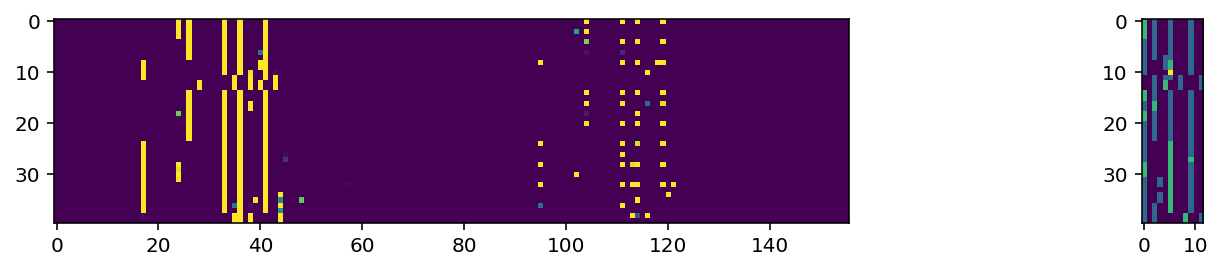

Iter: 252000
D_Loss: 1.617
G_Loss: 0.637


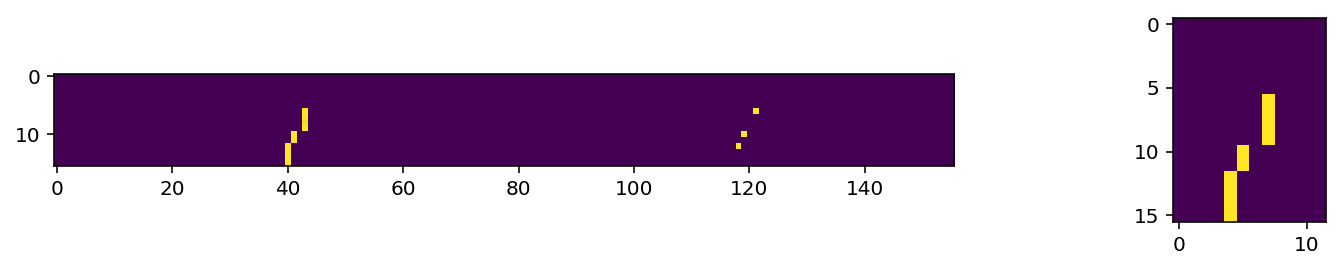

Iter: 253000
D_Loss: 1.157
G_Loss: 1.755


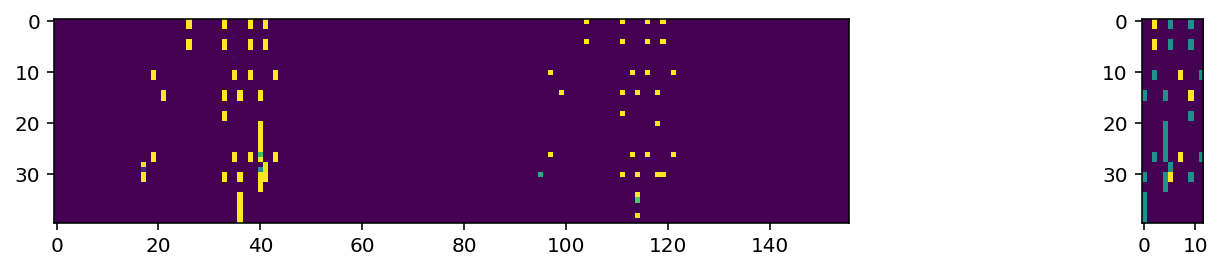

Iter: 254000
D_Loss: 0.08906
G_Loss: 7.075


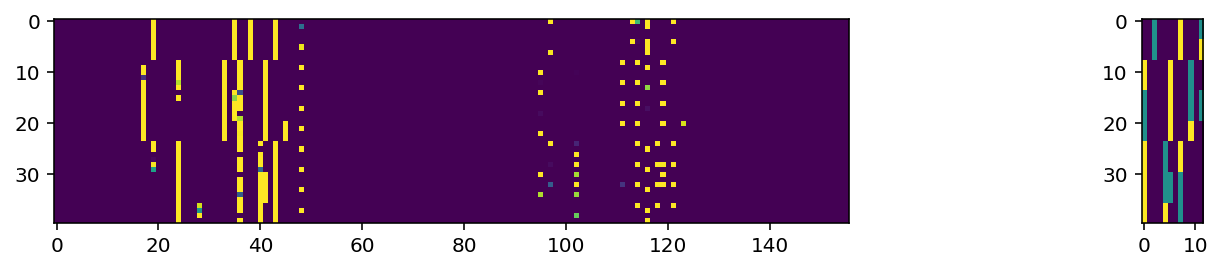

Iter: 255000
D_Loss: 0.9316
G_Loss: 1.975


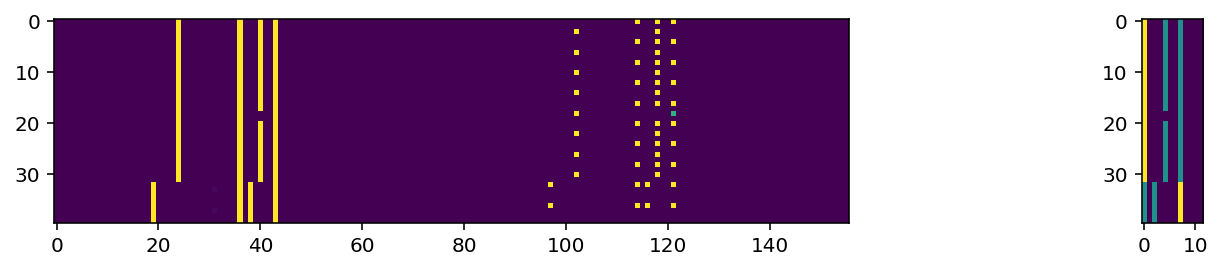

Iter: 256000
D_Loss: 0.1498
G_Loss: 5.539


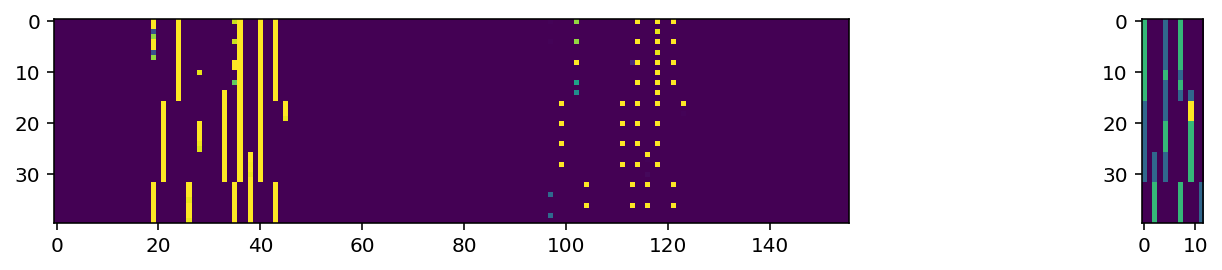

Iter: 257000
D_Loss: 1.089
G_Loss: 1.082


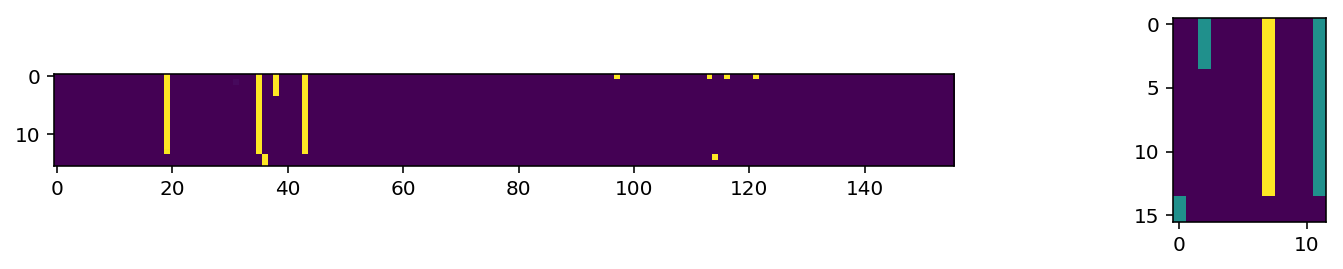

Iter: 258000
D_Loss: 0.2948
G_Loss: 5.407


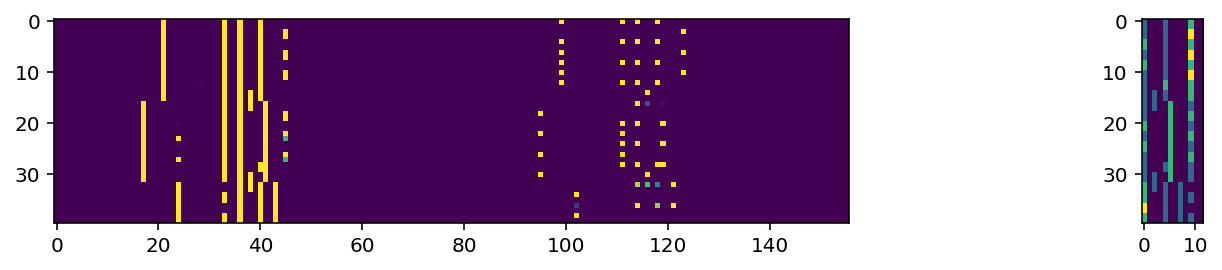

Iter: 259000
D_Loss: 1.096
G_Loss: 0.8706


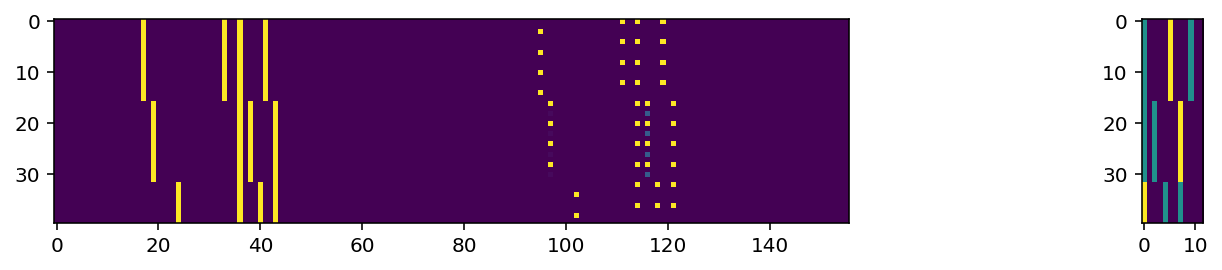

Iter: 260000
D_Loss: 0.08202
G_Loss: 5.493


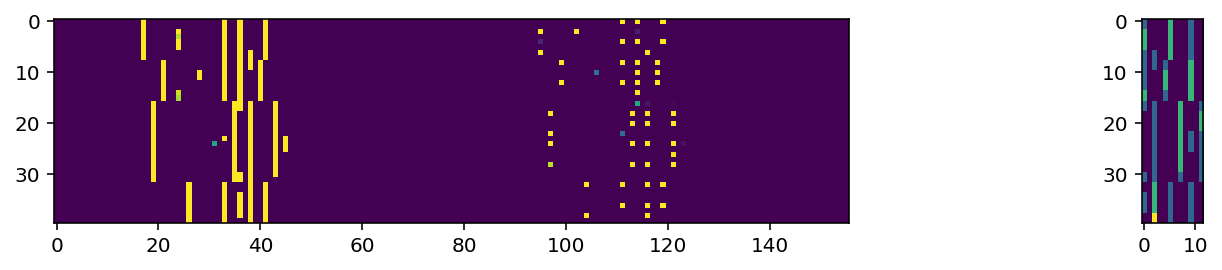

Iter: 261000
D_Loss: 0.01792
G_Loss: 6.226


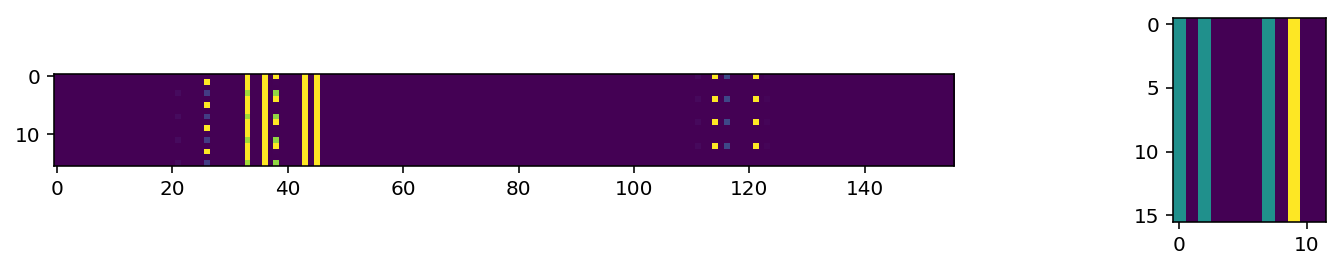

Iter: 262000
D_Loss: 1.174
G_Loss: 1.82


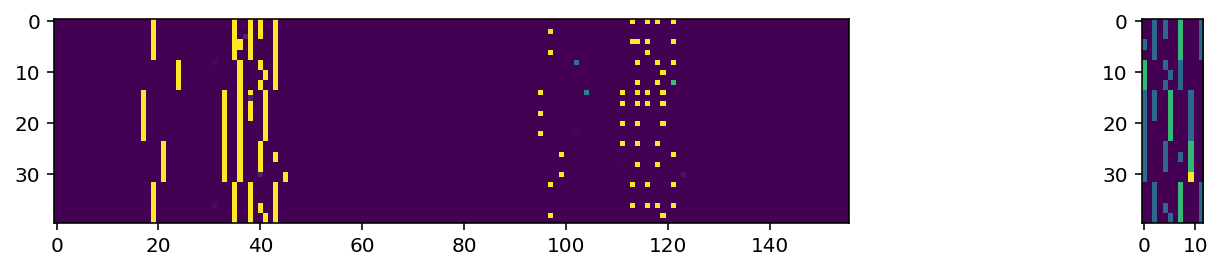

Iter: 263000
D_Loss: 1.303
G_Loss: 2.795


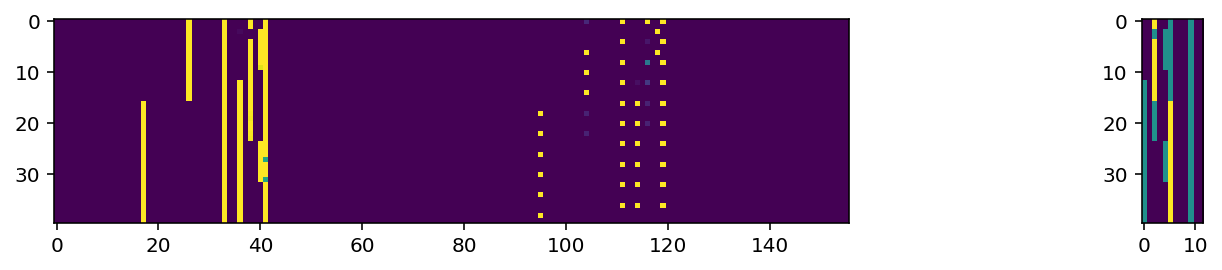

Iter: 264000
D_Loss: 0.973
G_Loss: 6.627


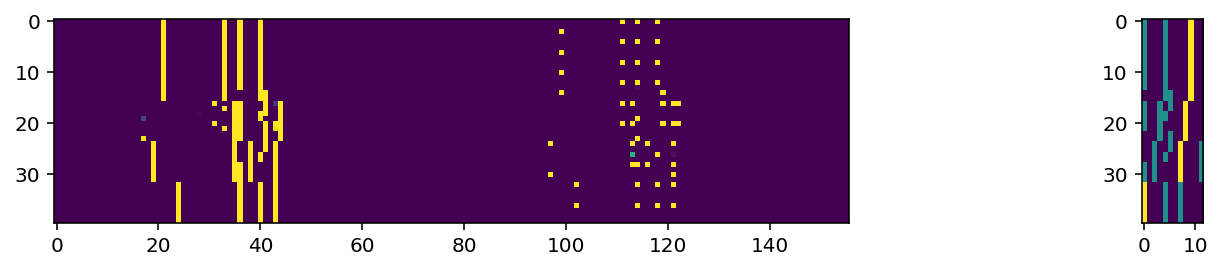

Iter: 265000
D_Loss: 0.2349
G_Loss: 2.979


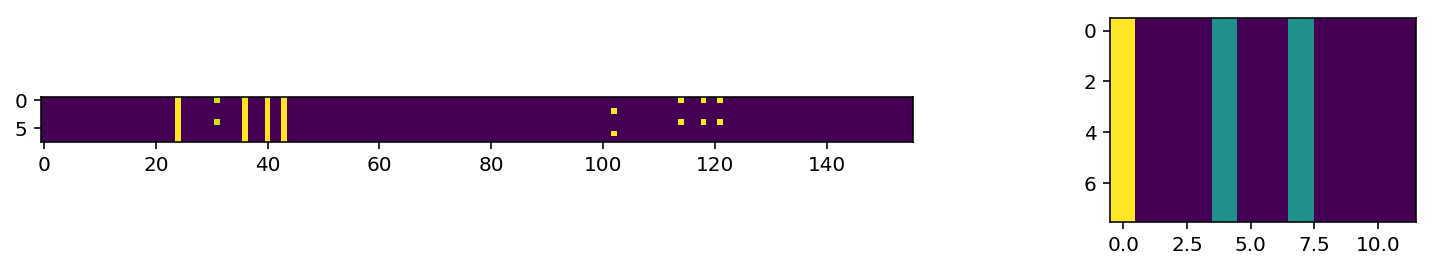

Iter: 266000
D_Loss: 0.04431
G_Loss: 6.315


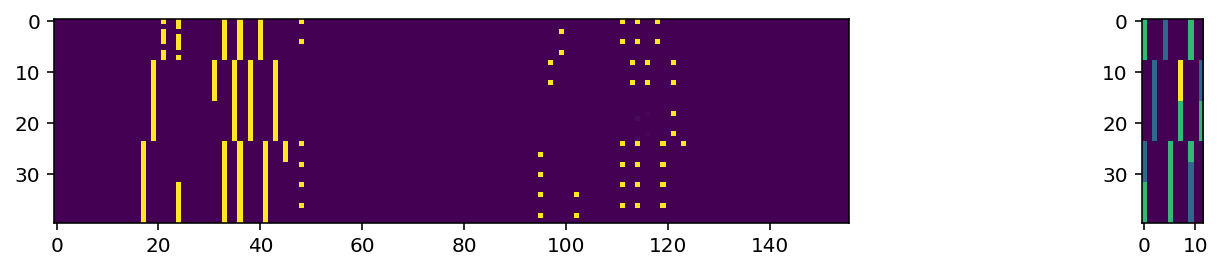

Iter: 267000
D_Loss: 0.3589
G_Loss: 7.621


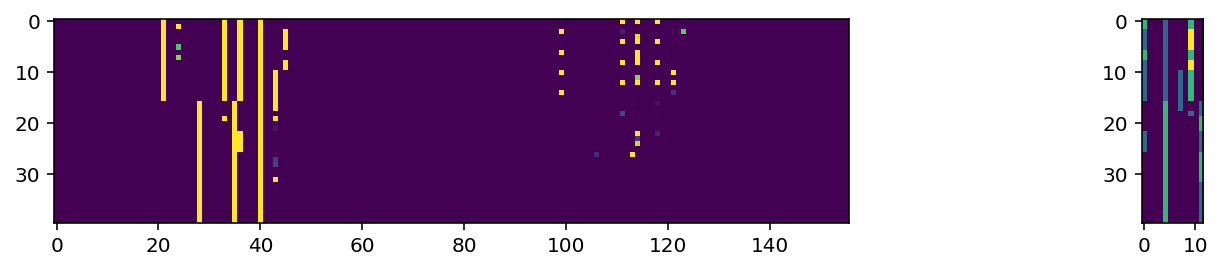

Iter: 268000
D_Loss: 0.4114
G_Loss: 3.948


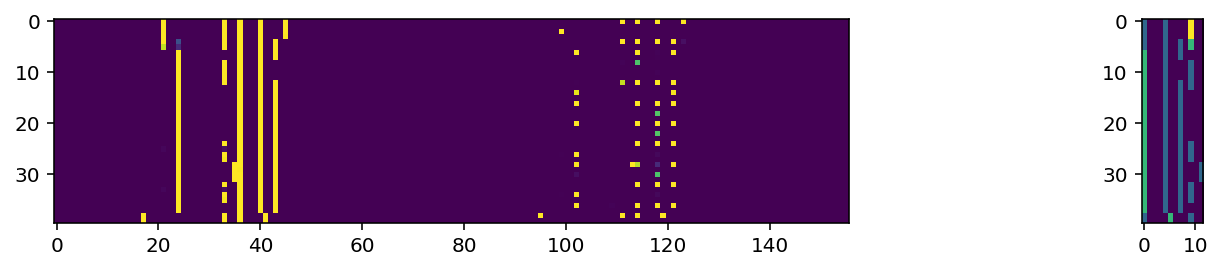

Iter: 269000
D_Loss: 0.009409
G_Loss: 6.961


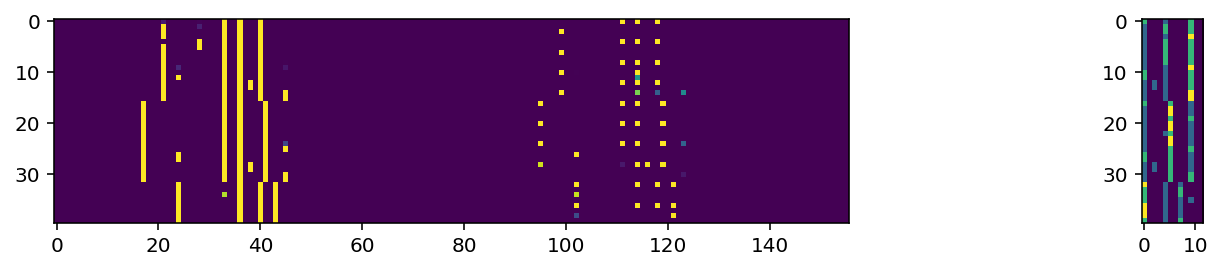

Iter: 270000
D_Loss: 0.8831
G_Loss: 1.561


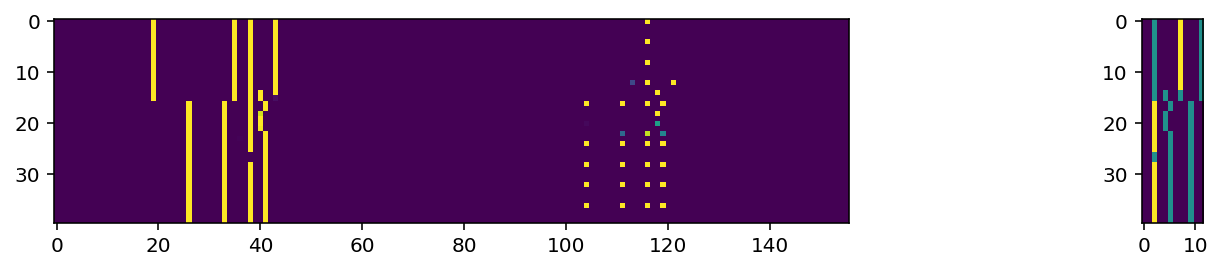

Iter: 271000
D_Loss: 0.007137
G_Loss: 8.816


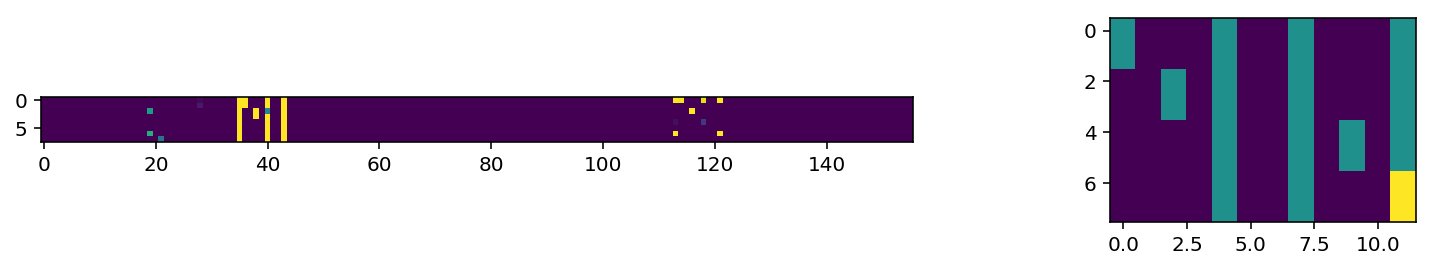

Iter: 272000
D_Loss: 0.0608
G_Loss: 5.784


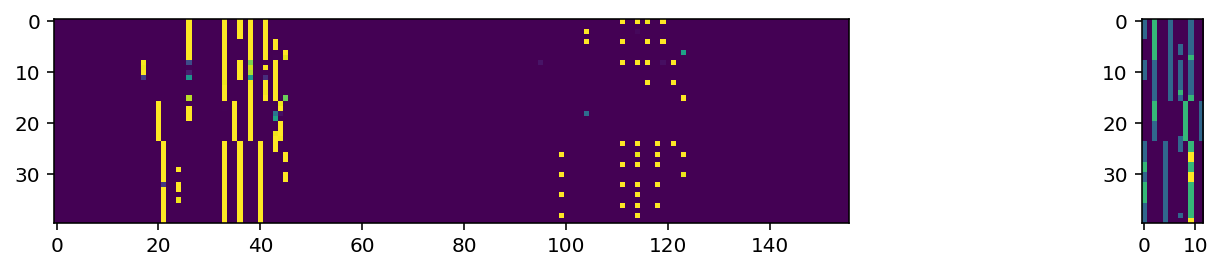

Iter: 273000
D_Loss: 0.301
G_Loss: 3.955


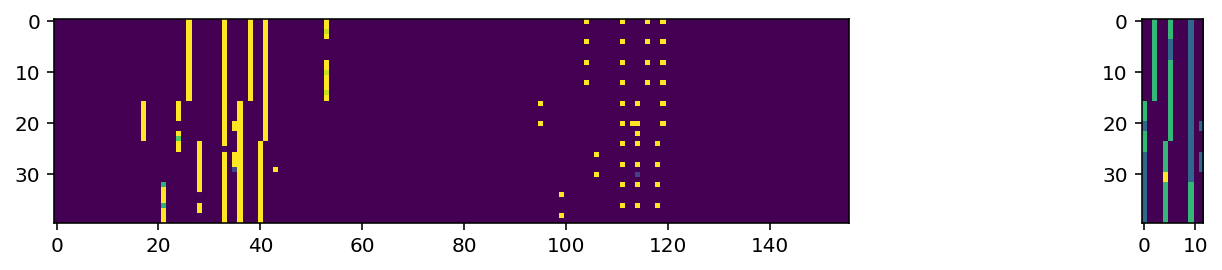

Iter: 274000
D_Loss: 1.457
G_Loss: 3.821


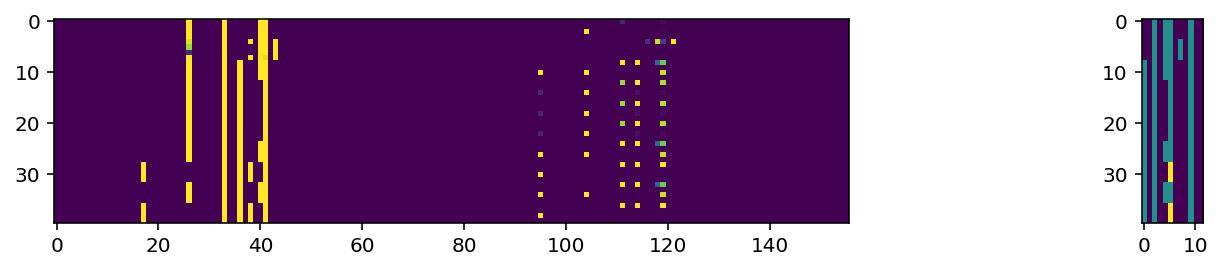

Iter: 275000
D_Loss: 0.07191
G_Loss: 18.5


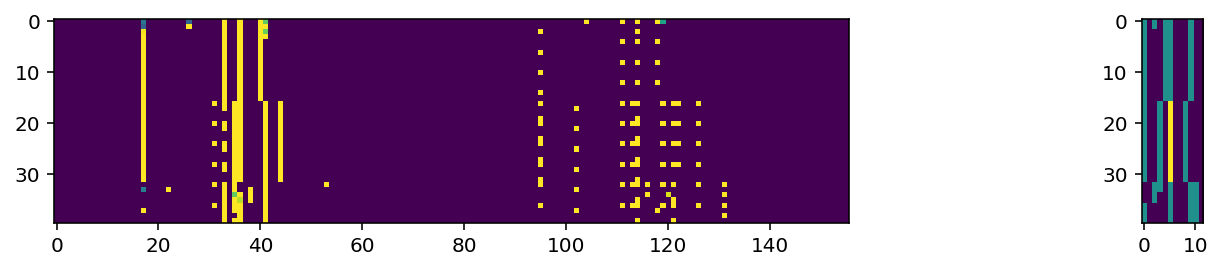

Iter: 276000
D_Loss: 0.7247
G_Loss: 2.092


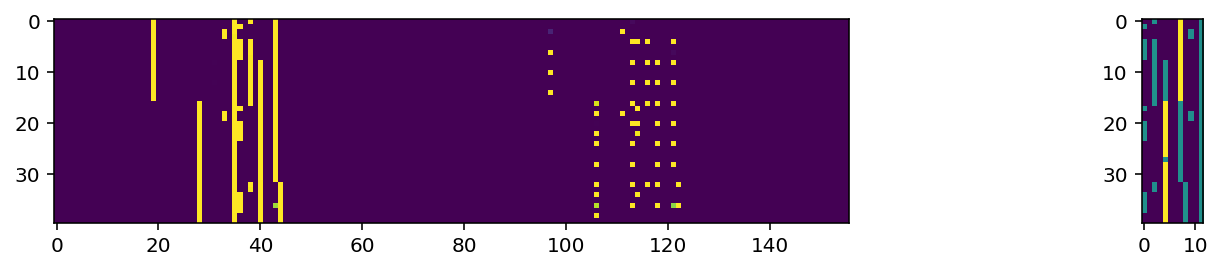

Iter: 277000
D_Loss: 0.04331
G_Loss: 5.679


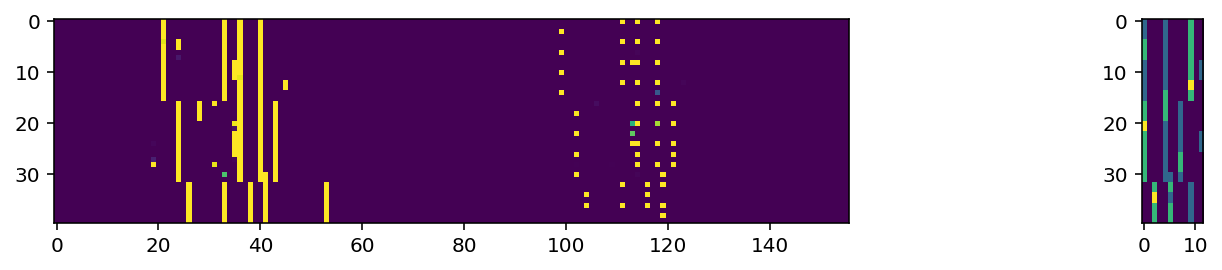

Iter: 278000
D_Loss: 0.6413
G_Loss: 3.916


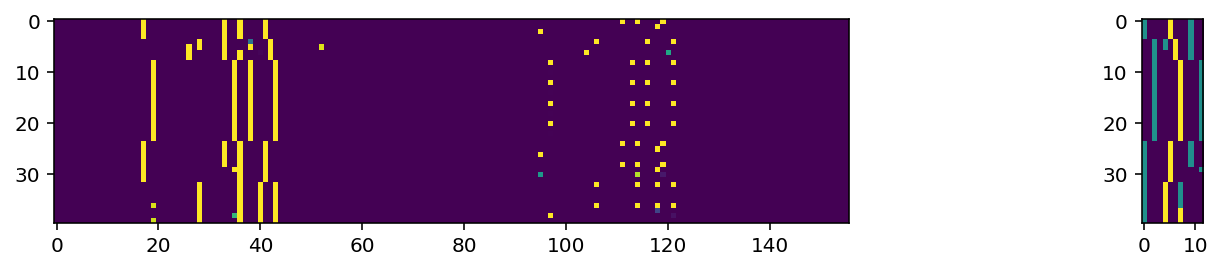

Iter: 279000
D_Loss: 0.1221
G_Loss: 3.81


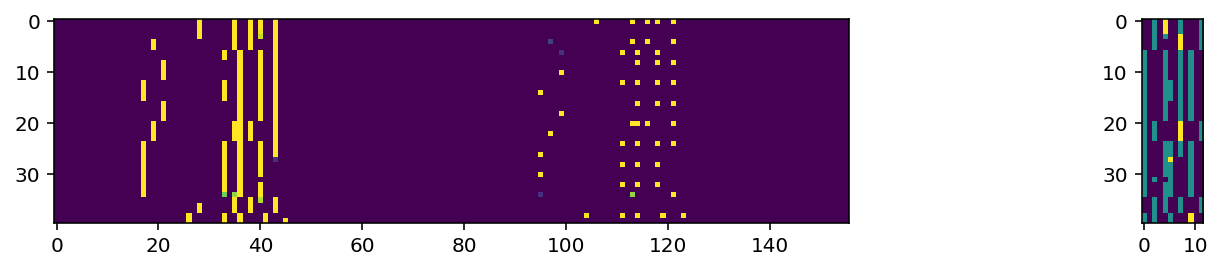

Iter: 280000
D_Loss: 0.4479
G_Loss: 4.665


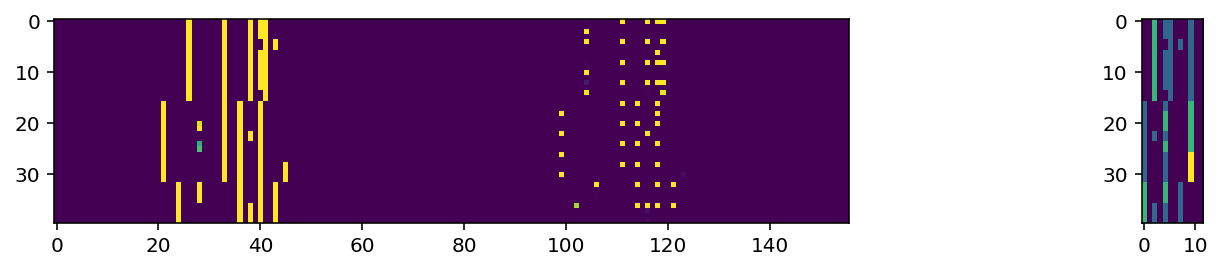

Iter: 281000
D_Loss: 0.2075
G_Loss: 5.132


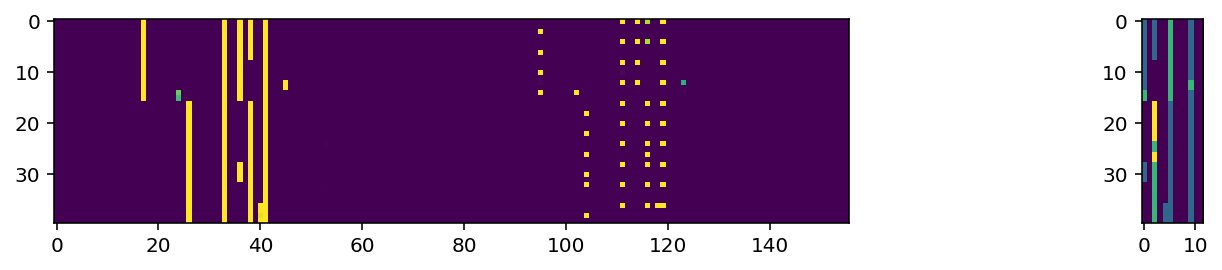

Iter: 282000
D_Loss: 0.9895
G_Loss: 1.494


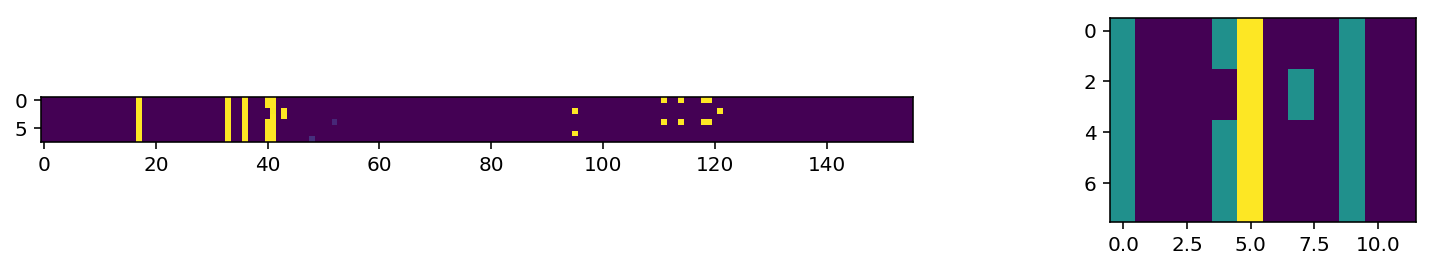

Iter: 283000
D_Loss: 0.000482
G_Loss: 19.23


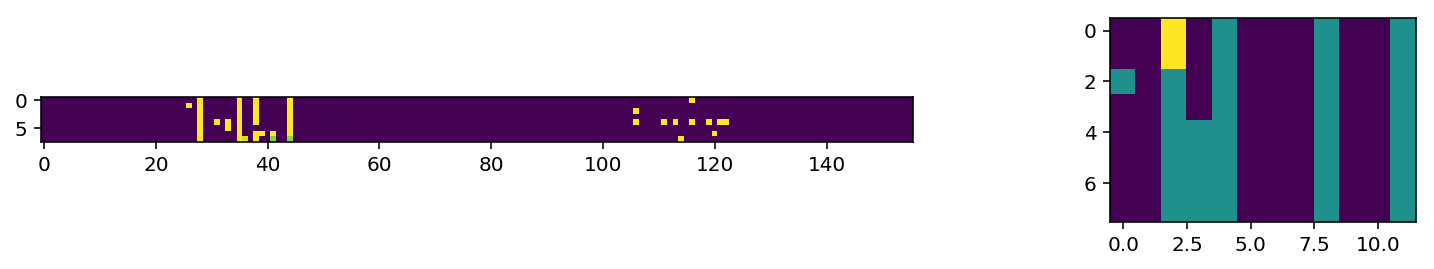

Iter: 284000
D_Loss: 0.5815
G_Loss: 4.109


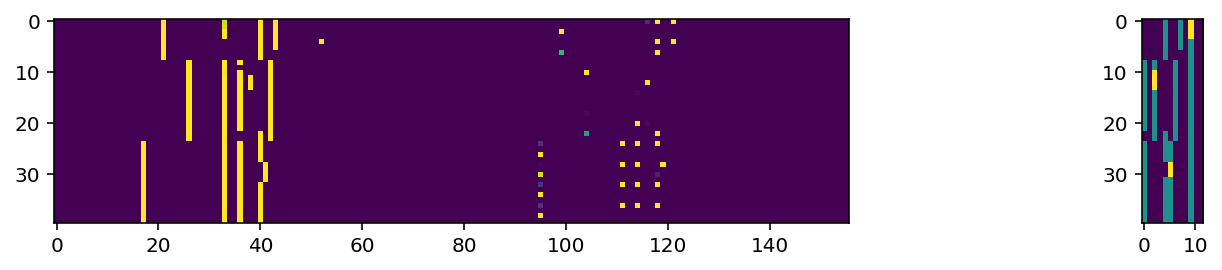

Iter: 285000
D_Loss: 0.9077
G_Loss: 2.08


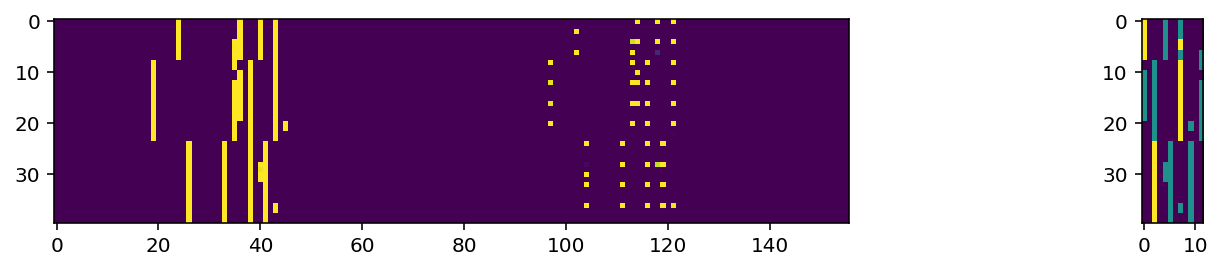

Iter: 286000
D_Loss: 0.2975
G_Loss: 3.351


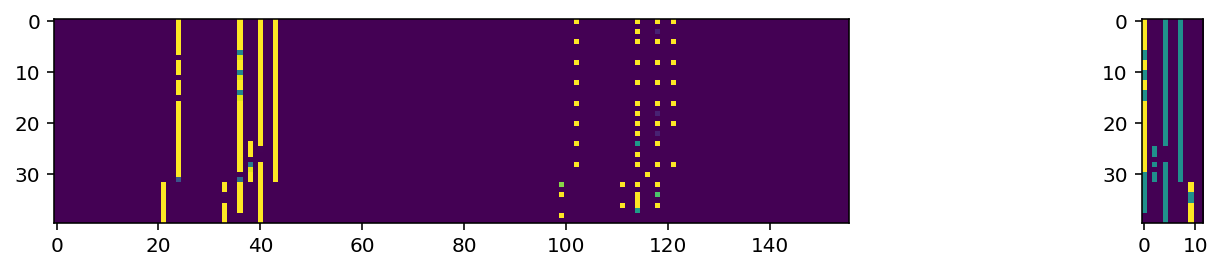

Iter: 287000
D_Loss: 0.3154
G_Loss: 5.297


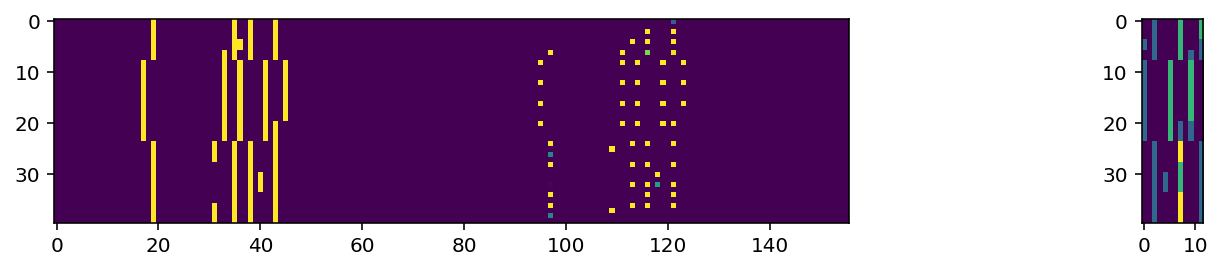

Iter: 288000
D_Loss: 0.9118
G_Loss: 1.228


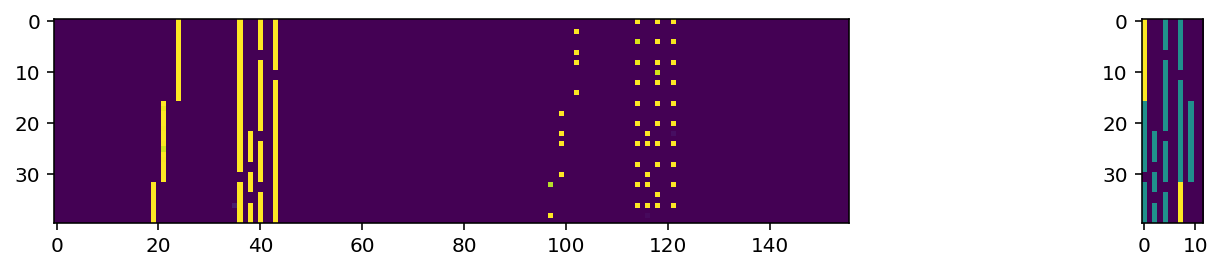

Iter: 289000
D_Loss: 0.486
G_Loss: 4.866


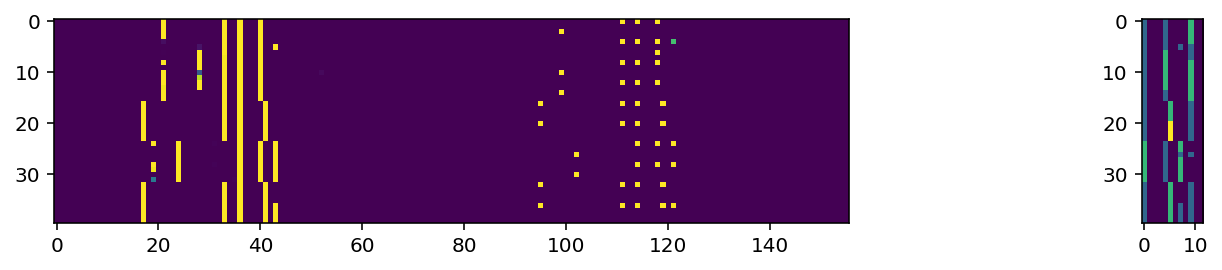

Iter: 290000
D_Loss: 0.901
G_Loss: 1.328


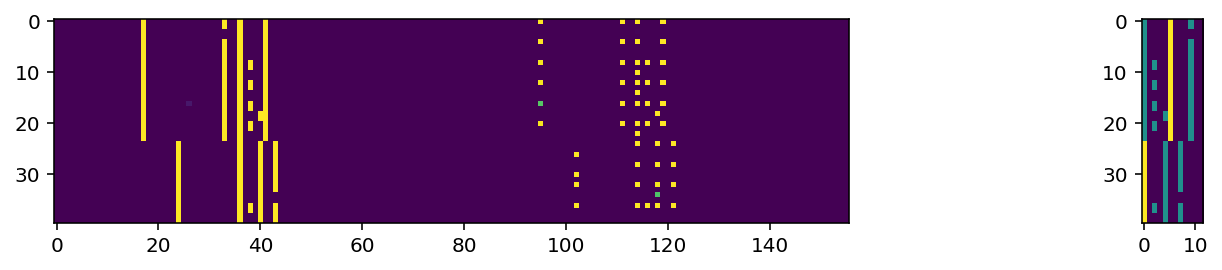

Iter: 291000
D_Loss: 0.3398
G_Loss: 4.978


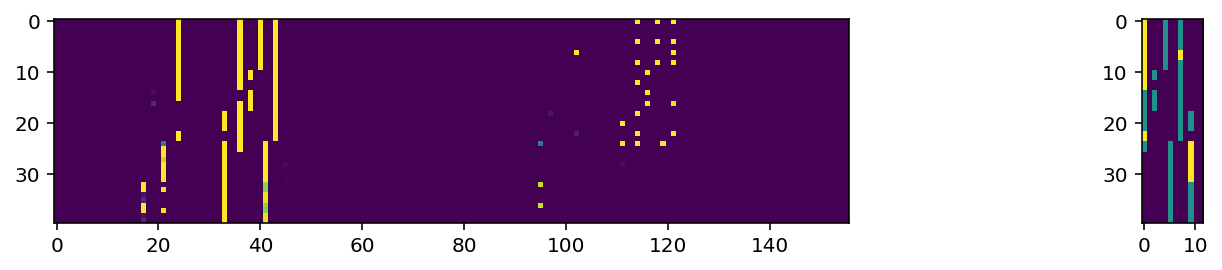

Iter: 292000
D_Loss: 0.9079
G_Loss: 1.793


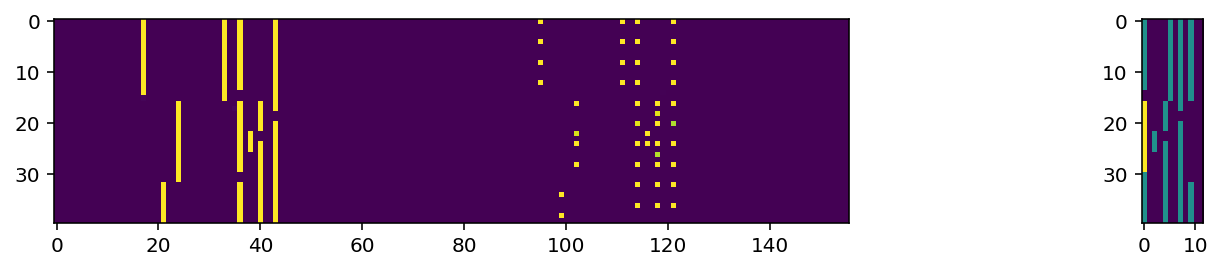

Iter: 293000
D_Loss: 0.9838
G_Loss: 1.511


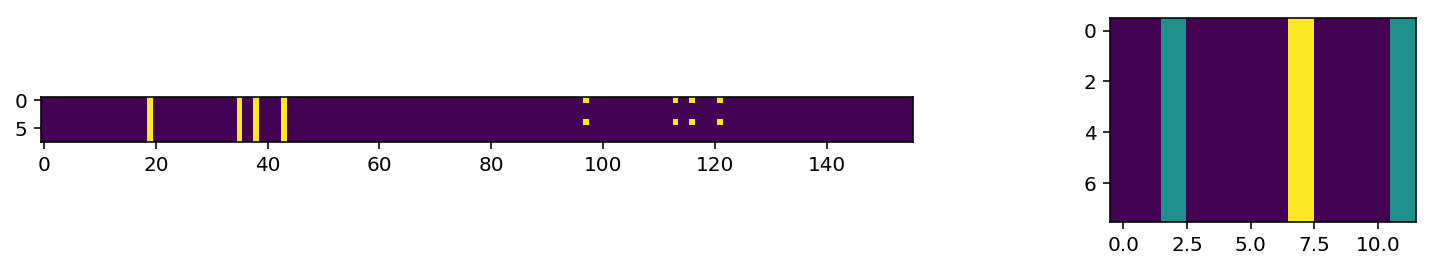

Iter: 294000
D_Loss: 0.1287
G_Loss: 4.799


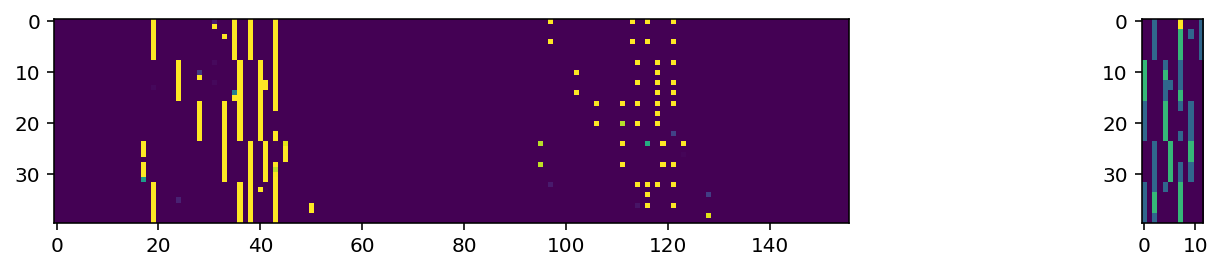

Iter: 295000
D_Loss: 0.06253
G_Loss: 7.162


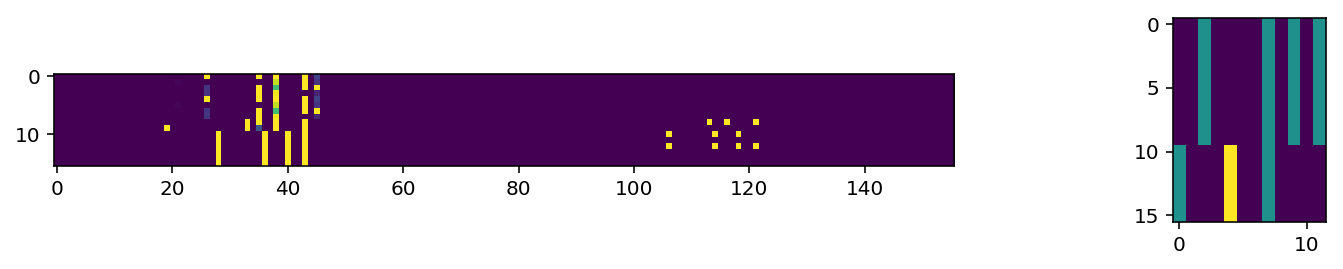

Iter: 296000
D_Loss: 0.03464
G_Loss: 6.135


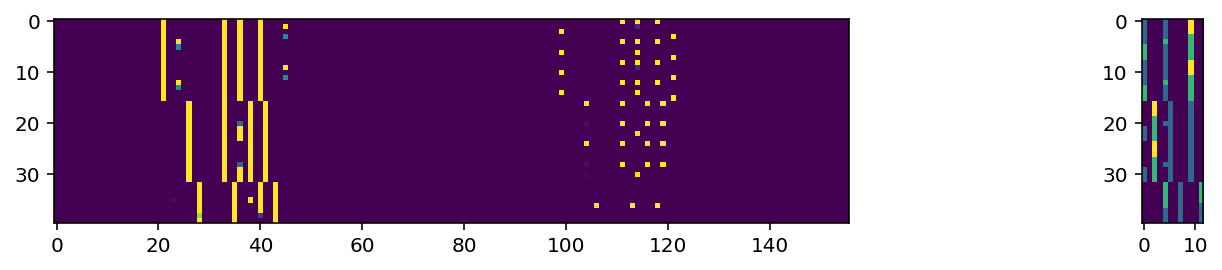

Iter: 297000
D_Loss: 0.1296
G_Loss: 4.686


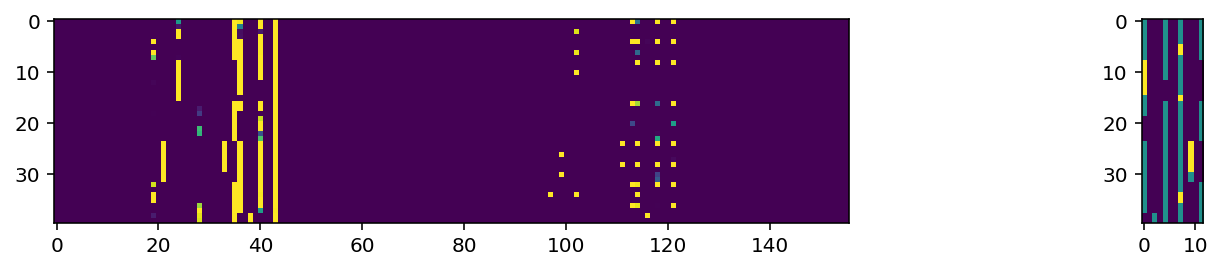

Iter: 298000
D_Loss: 0.03322
G_Loss: 6.482


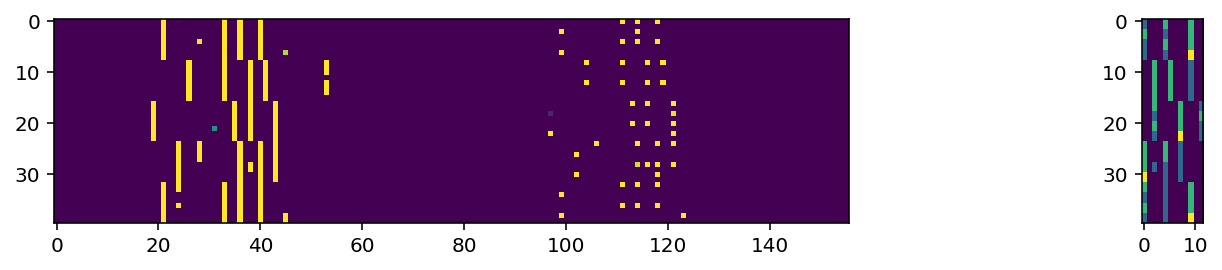

Iter: 299000
D_Loss: 1.038
G_Loss: 1.492


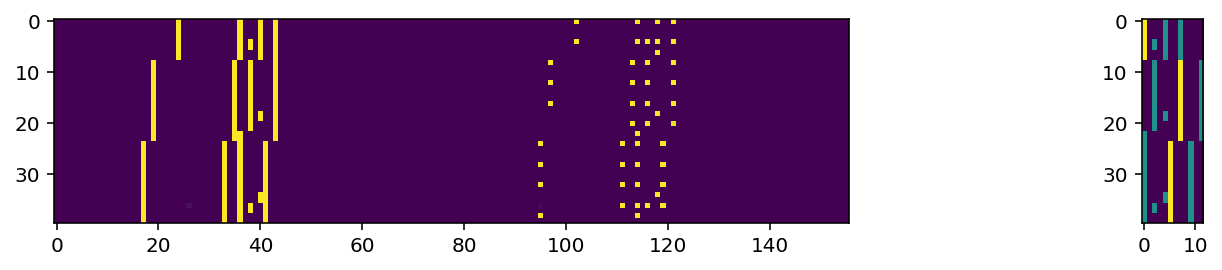

Iter: 300000
D_Loss: 0.01138
G_Loss: 7.302


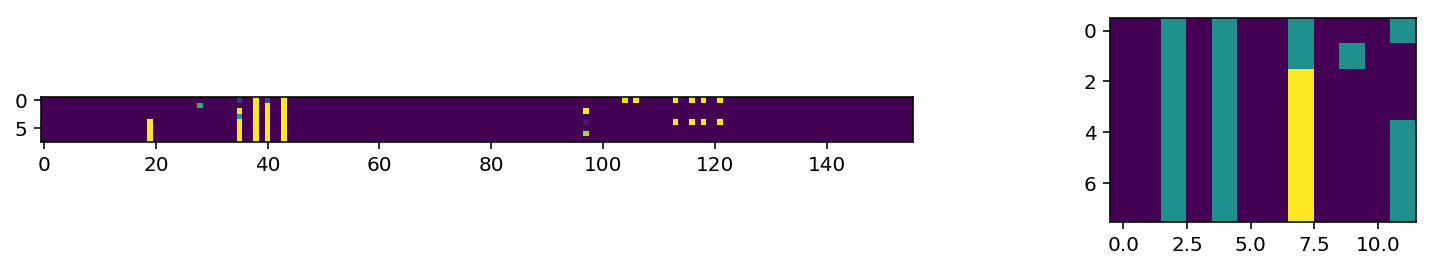

Iter: 301000
D_Loss: 0.3275
G_Loss: 5.214


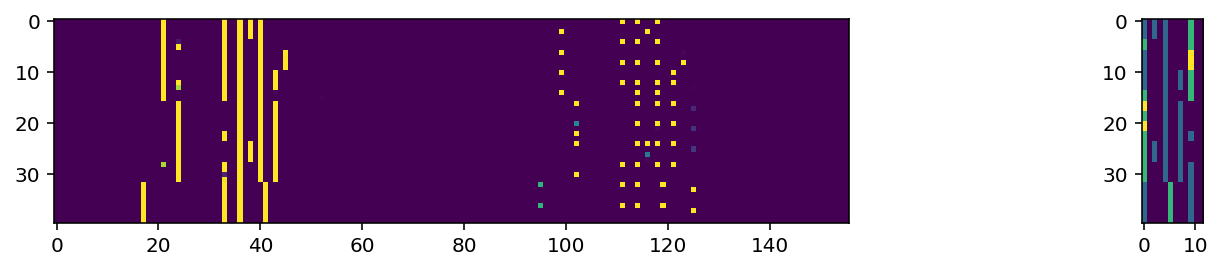

Iter: 302000
D_Loss: 0.4273
G_Loss: 4.619


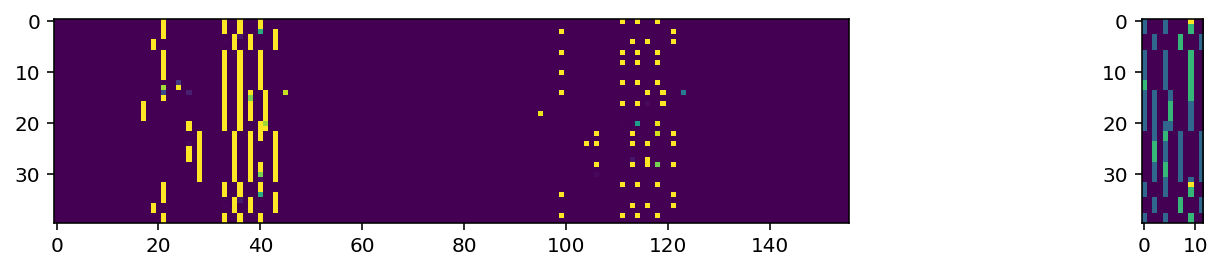

Iter: 303000
D_Loss: 0.603
G_Loss: 2.563


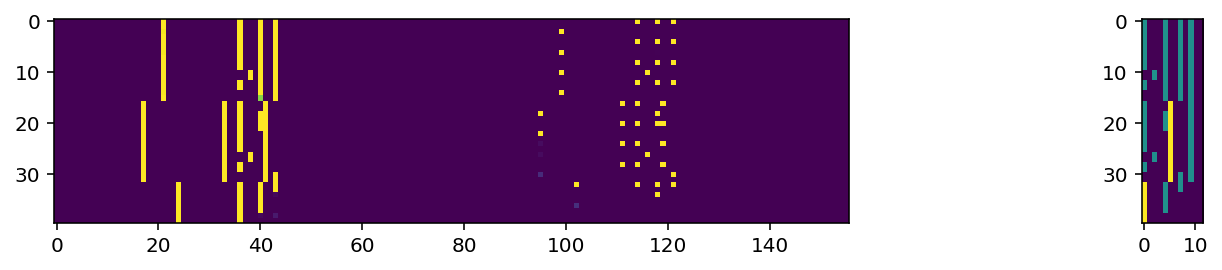

Iter: 304000
D_Loss: 0.6799
G_Loss: 2.647


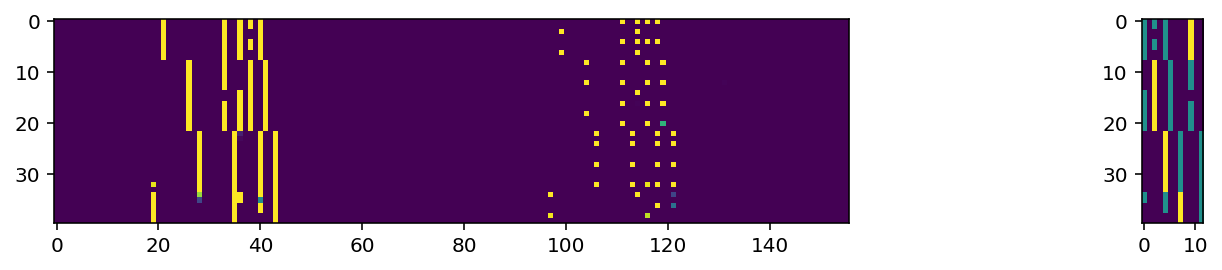

Iter: 305000
D_Loss: 1.243
G_Loss: 0.9604


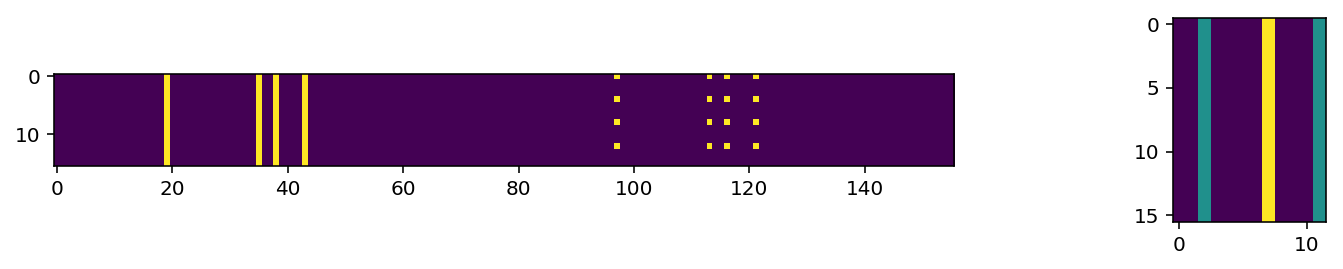

Iter: 306000
D_Loss: 0.007811
G_Loss: 8.211


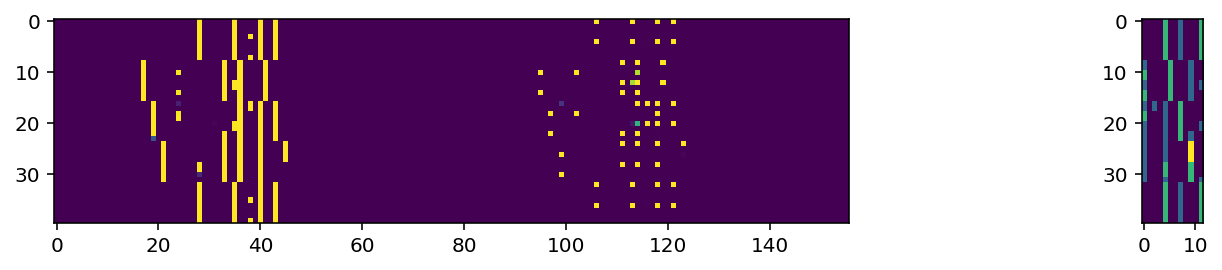

Iter: 307000
D_Loss: 0.07554
G_Loss: 5.365


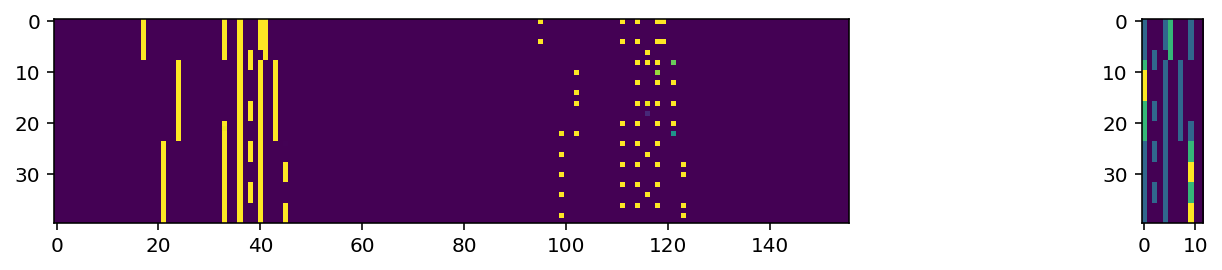

Iter: 308000
D_Loss: 0.6916
G_Loss: 3.919


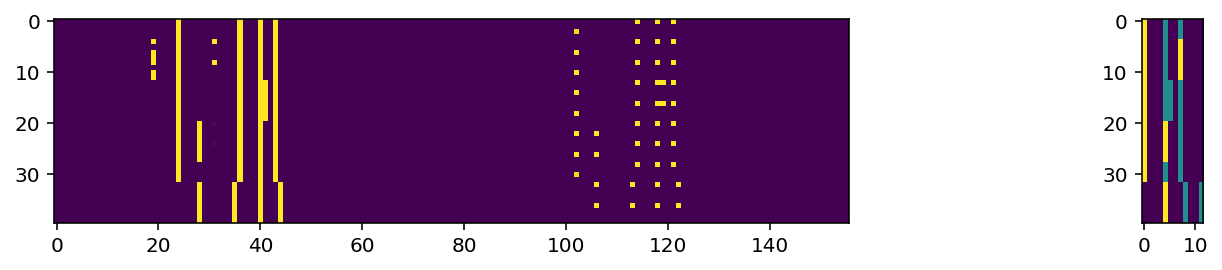

Iter: 309000
D_Loss: 0.0172
G_Loss: 8.714


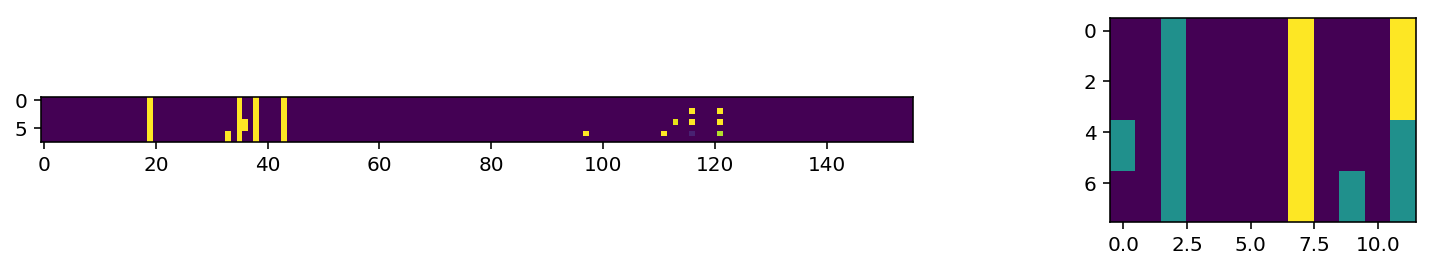

Iter: 310000
D_Loss: 0.9861
G_Loss: 1.64


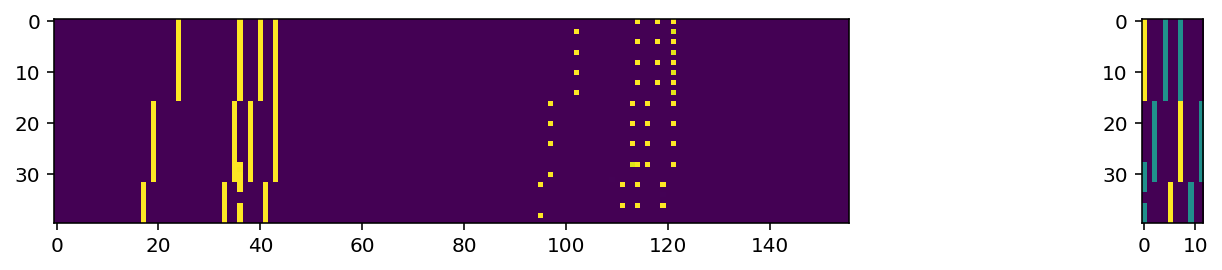

Iter: 311000
D_Loss: 0.2375
G_Loss: 5.604


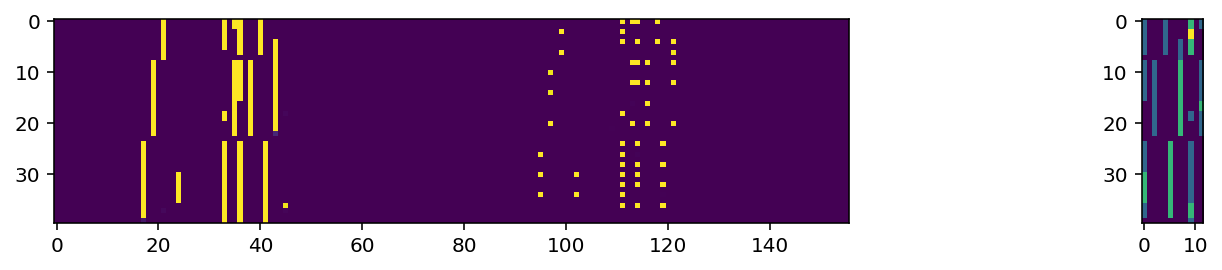

Iter: 312000
D_Loss: 0.2966
G_Loss: 4.417


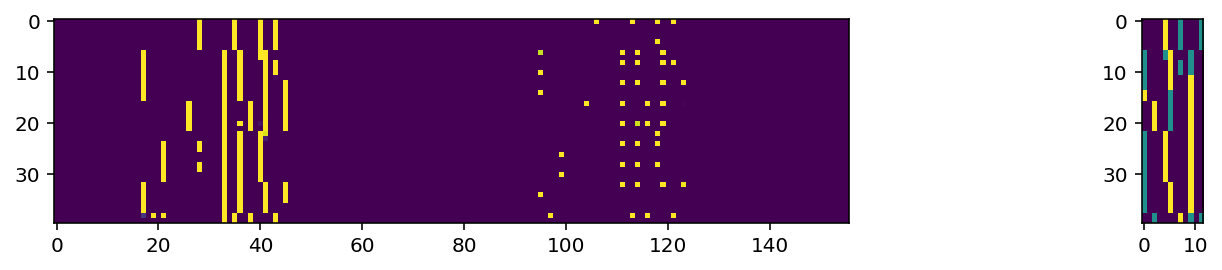

Iter: 313000
D_Loss: 0.5511
G_Loss: 2.775


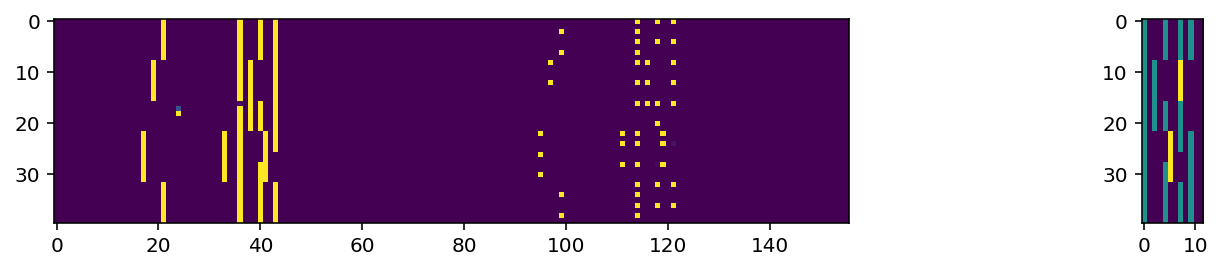

Iter: 314000
D_Loss: 0.1105
G_Loss: 6.7


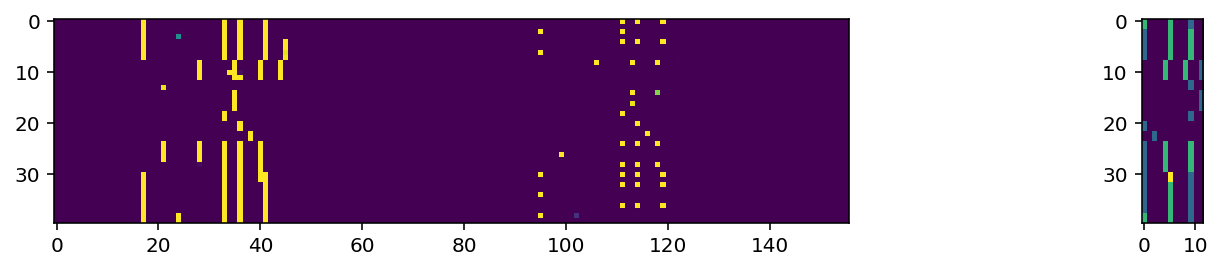

Iter: 315000
D_Loss: 0.5406
G_Loss: 3.292


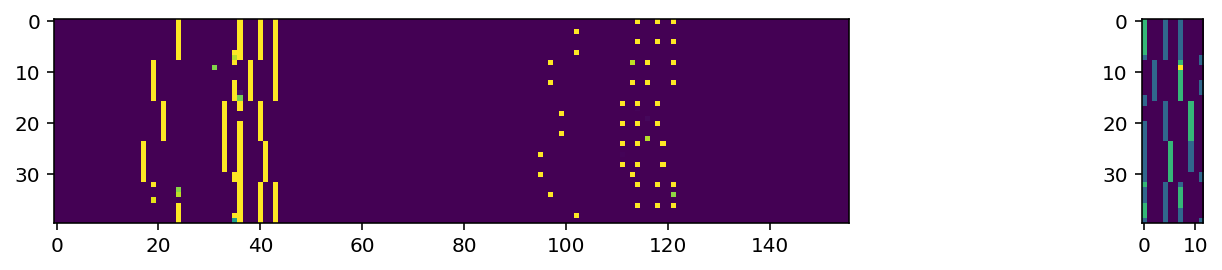

Iter: 316000
D_Loss: 0.09676
G_Loss: 4.677


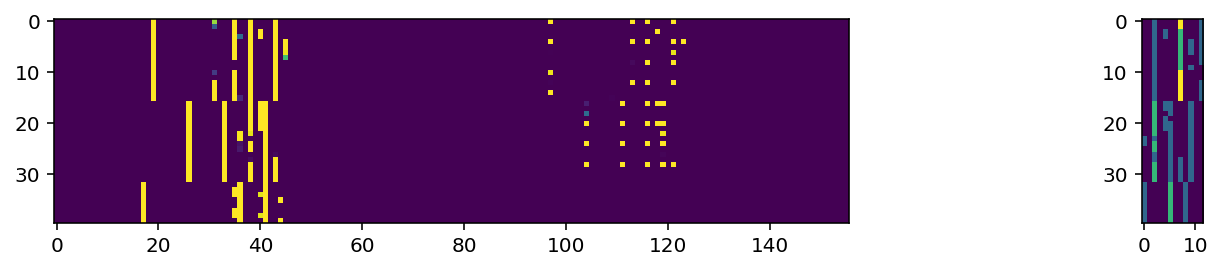

Iter: 317000
D_Loss: 0.07541
G_Loss: 6.385


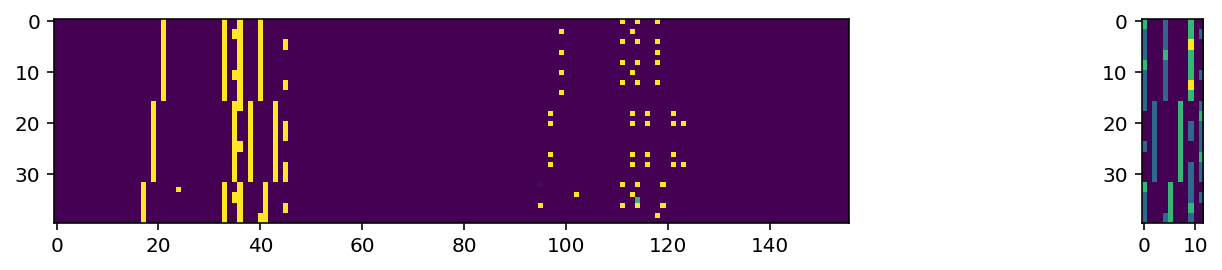

Iter: 318000
D_Loss: 1.135
G_Loss: 2.919


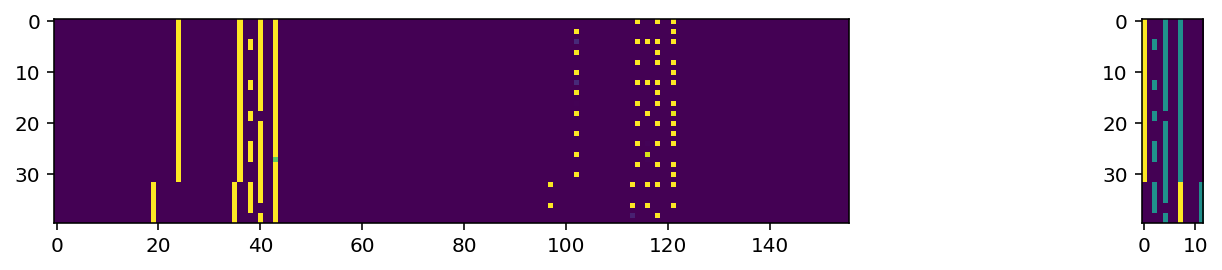

Iter: 319000
D_Loss: 0.7112
G_Loss: 3.115


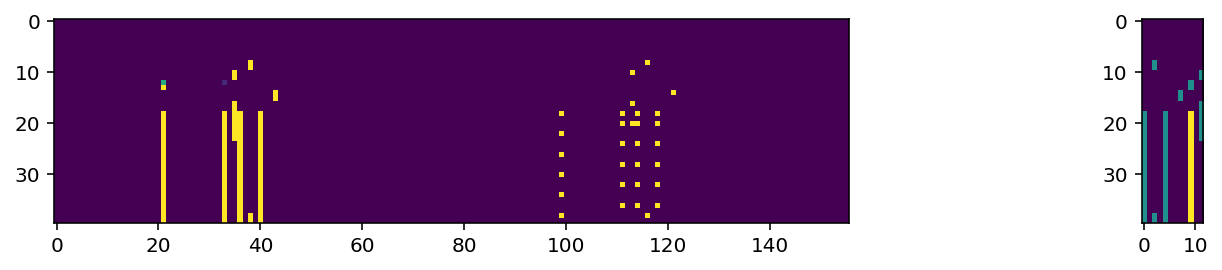

Iter: 320000
D_Loss: 0.05976
G_Loss: 5.163


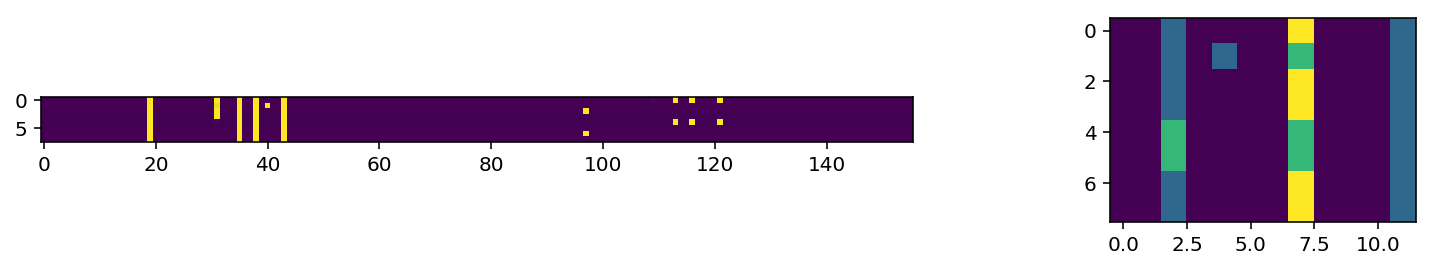

Iter: 321000
D_Loss: 0.2324
G_Loss: 15.15


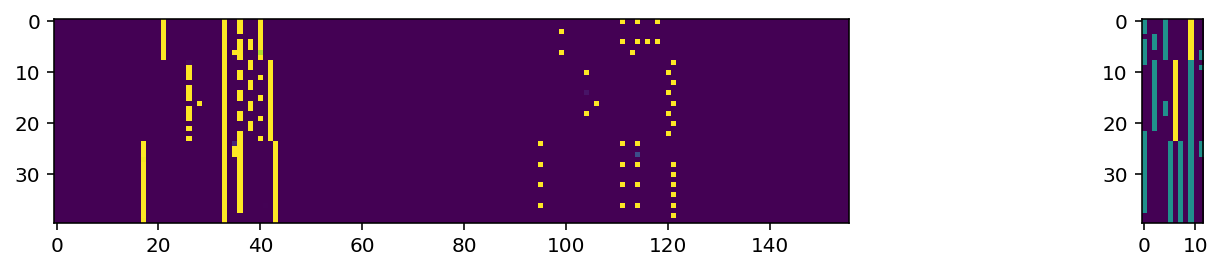

Iter: 322000
D_Loss: 0.005498
G_Loss: 8.597


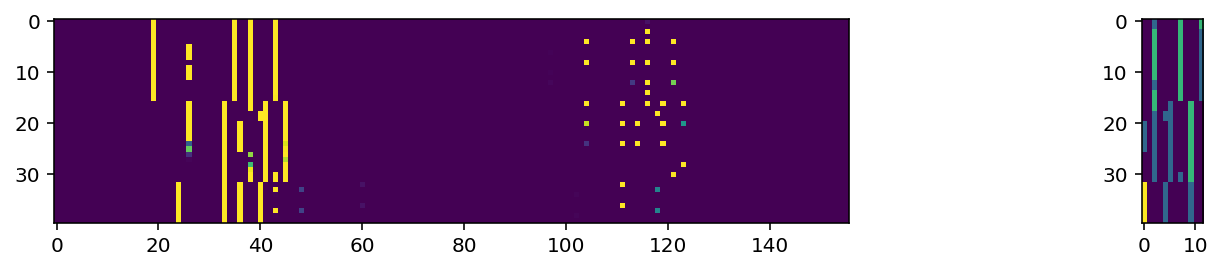

Iter: 323000
D_Loss: 0.9905
G_Loss: 1.966


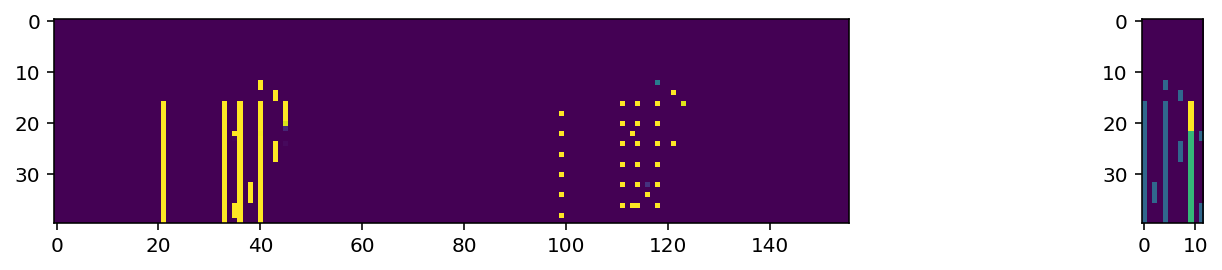

Iter: 324000
D_Loss: 0.4495
G_Loss: 5.049


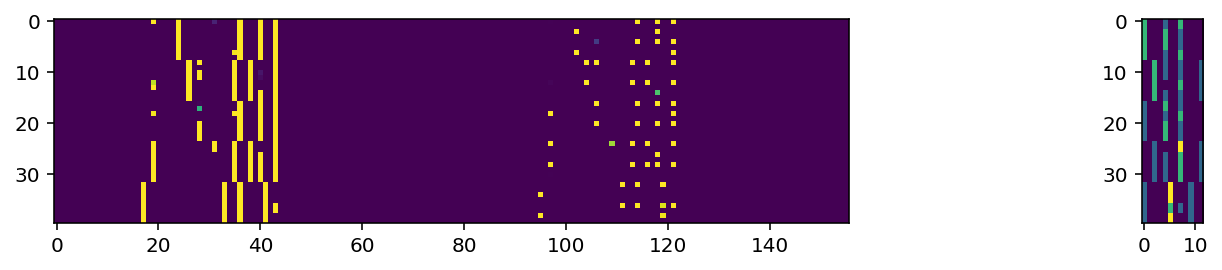

Iter: 325000
D_Loss: 1.011
G_Loss: 1.801


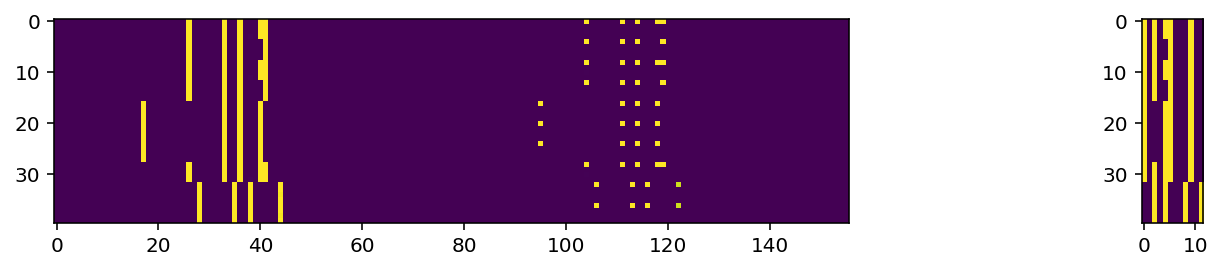

Iter: 326000
D_Loss: 0.1252
G_Loss: 5.773


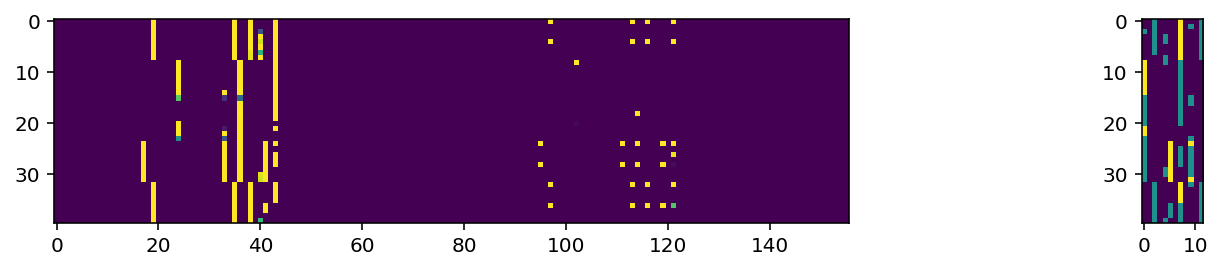

Iter: 327000
D_Loss: 0.1043
G_Loss: 6.032


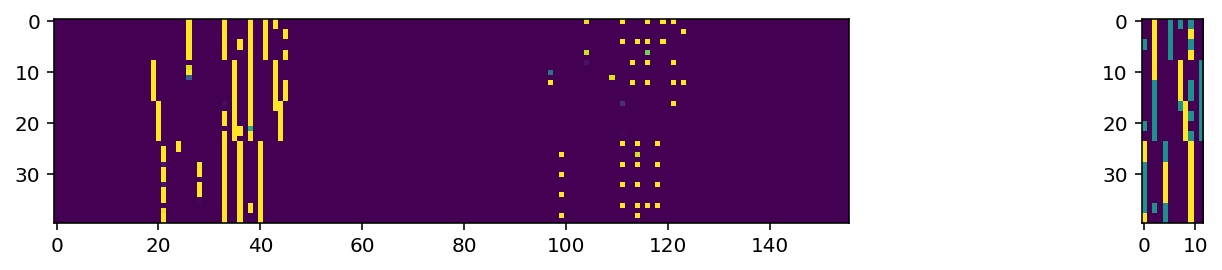

Iter: 328000
D_Loss: 0.3476
G_Loss: 4.969


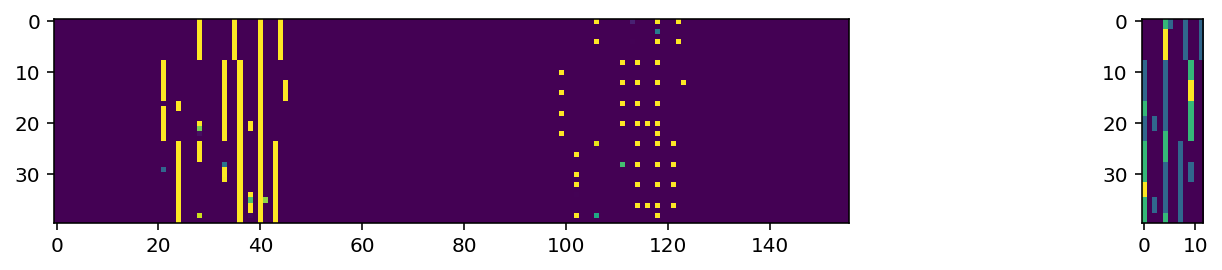

Iter: 329000
D_Loss: 0.7528
G_Loss: 5.072


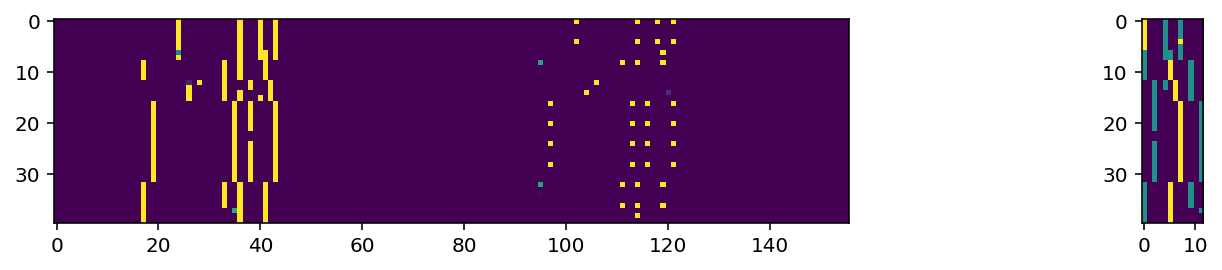

Iter: 330000
D_Loss: 1.021
G_Loss: 2.05


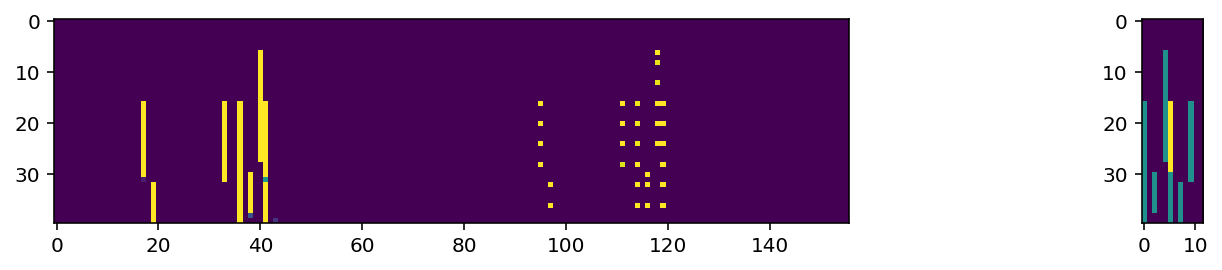

Iter: 331000
D_Loss: 0.2833
G_Loss: 4.329


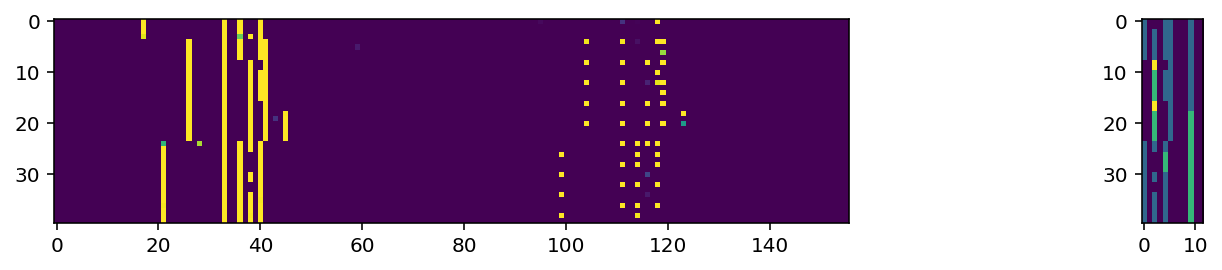

Iter: 332000
D_Loss: 0.743
G_Loss: 2.396


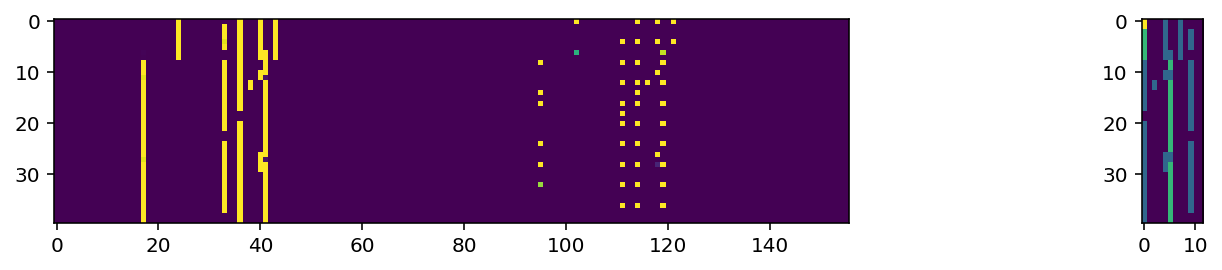

Iter: 333000
D_Loss: 0.7574
G_Loss: 3.936


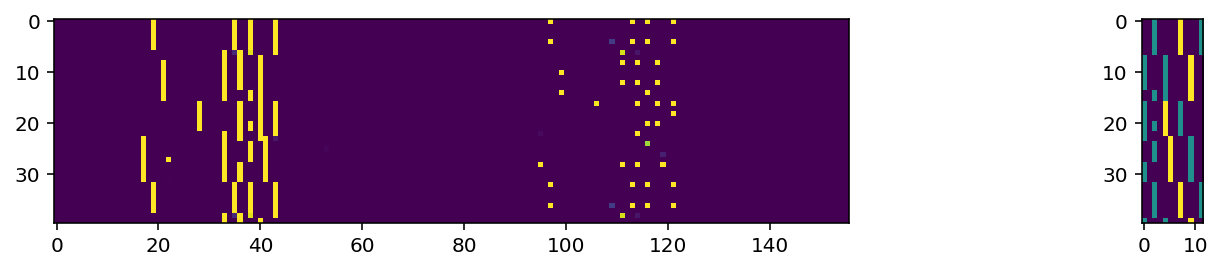

Iter: 334000
D_Loss: 0.7135
G_Loss: 13.71


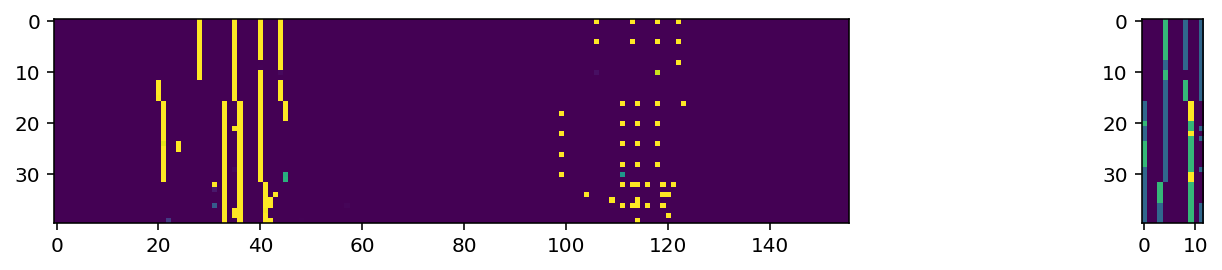

Iter: 335000
D_Loss: 0.3789
G_Loss: 5.008


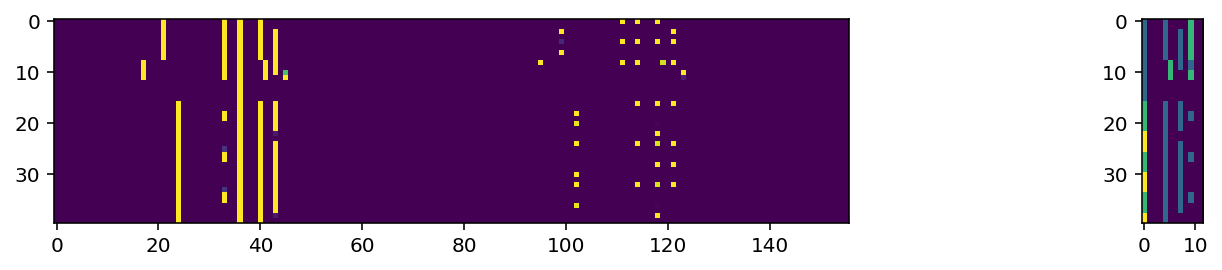

Iter: 336000
D_Loss: 0.634
G_Loss: 2.066


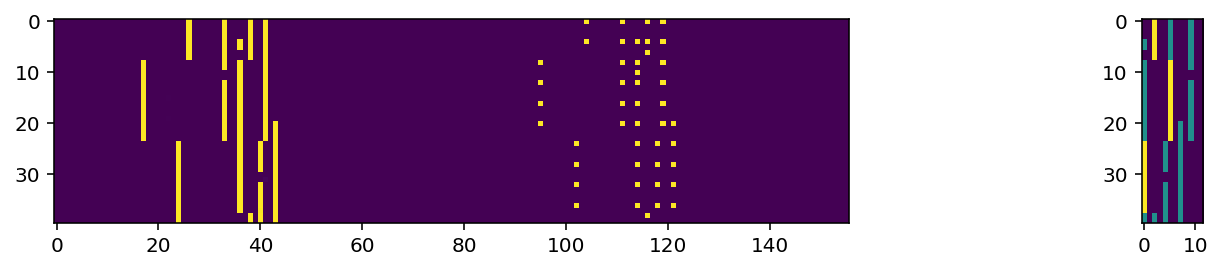

Iter: 337000
D_Loss: 0.4601
G_Loss: 1.733


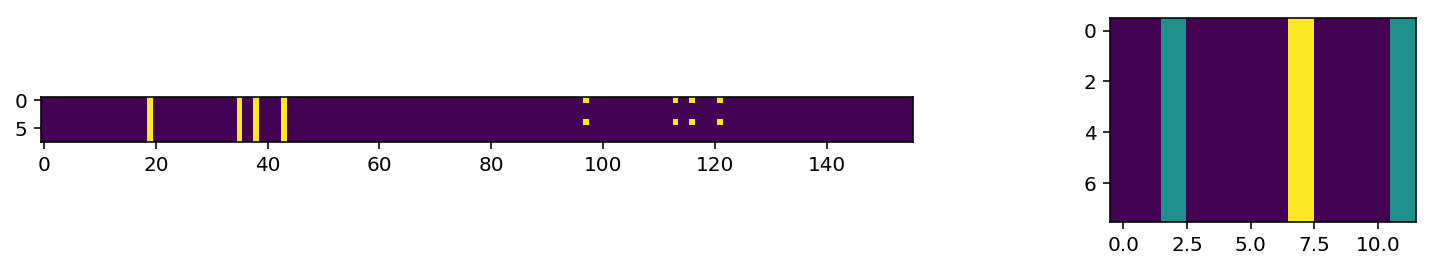

Iter: 338000
D_Loss: 0.0009533
G_Loss: 8.94


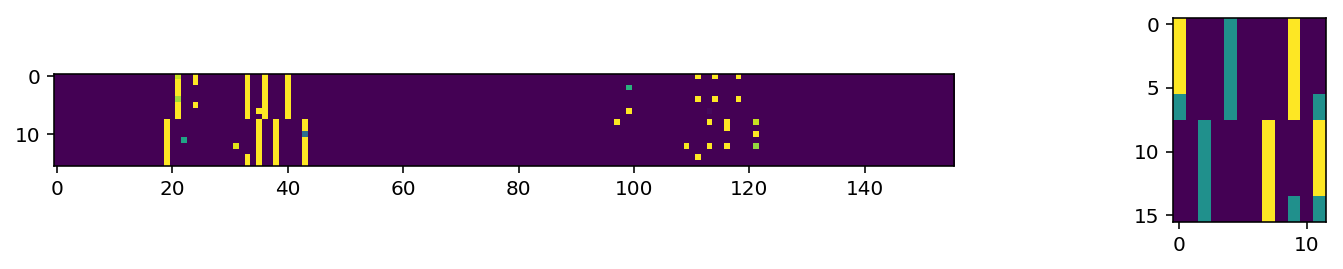

Iter: 339000
D_Loss: 0.823
G_Loss: 3.133


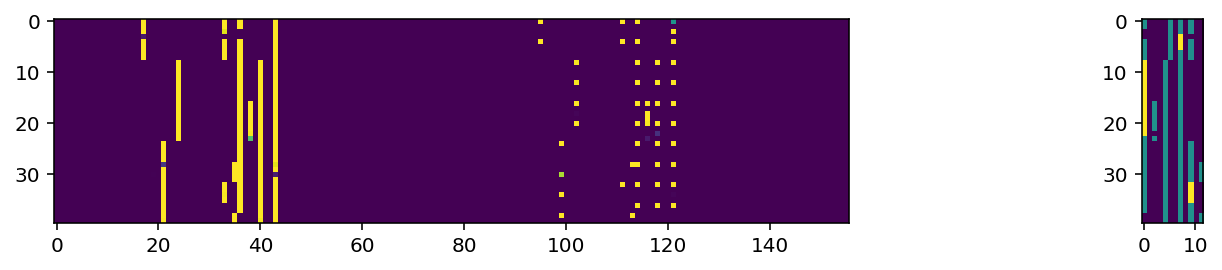

Iter: 340000
D_Loss: 1.116
G_Loss: 1.655


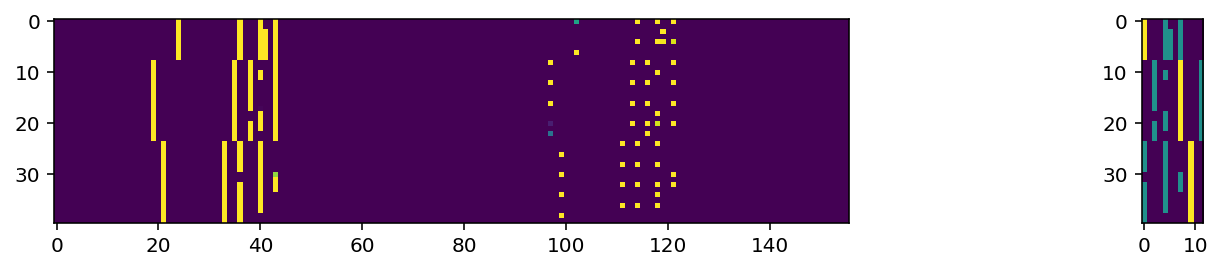

Iter: 341000
D_Loss: 0.1869
G_Loss: 5.352


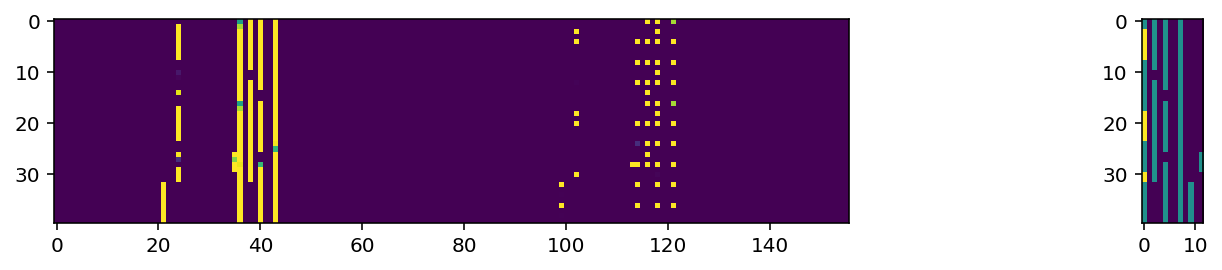

Iter: 342000
D_Loss: 0.6116
G_Loss: 2.221


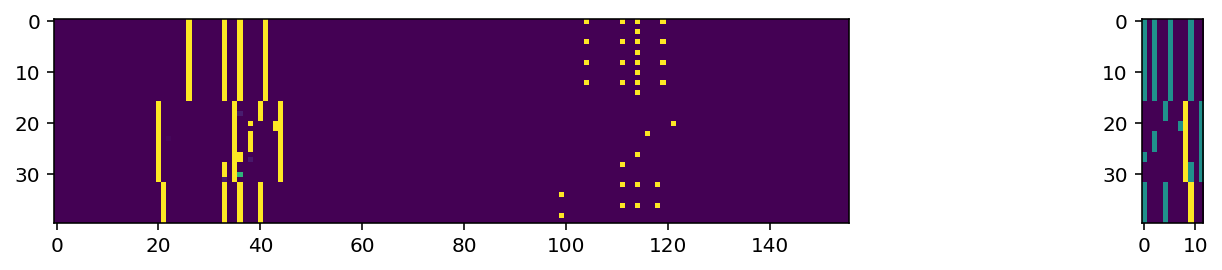

Iter: 343000
D_Loss: 0.5218
G_Loss: 3.194


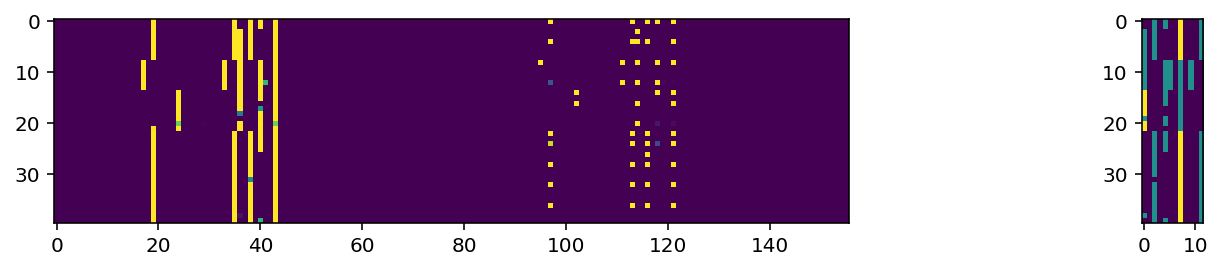

Iter: 344000
D_Loss: 0.9754
G_Loss: 1.964


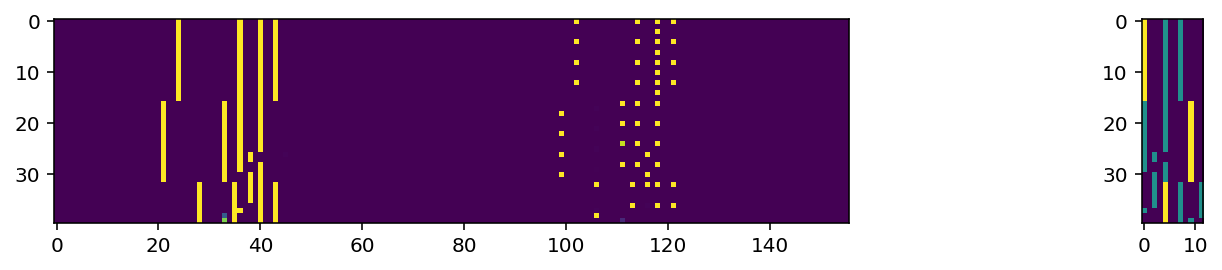

Iter: 345000
D_Loss: 0.1894
G_Loss: 16.79


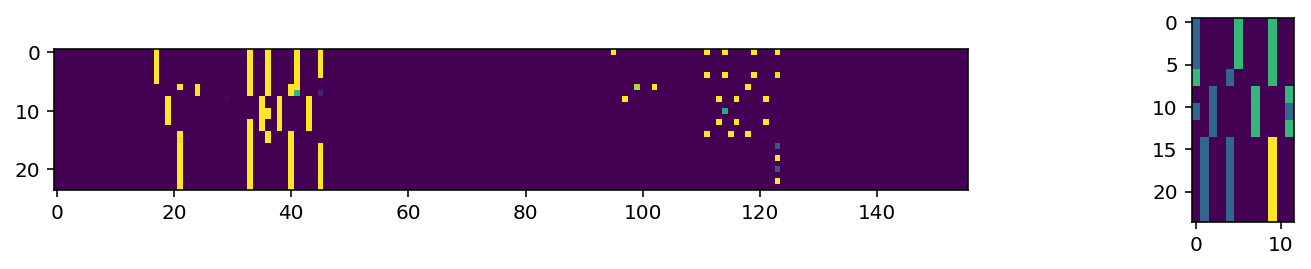

Iter: 346000
D_Loss: 0.7665
G_Loss: 4.307


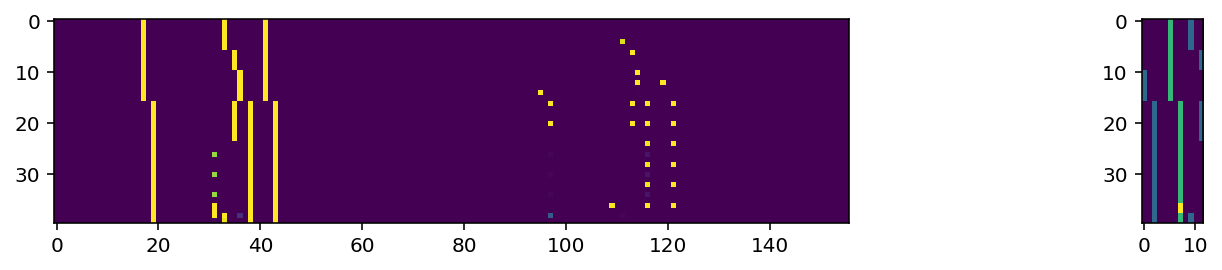

Iter: 347000
D_Loss: 0.276
G_Loss: 5.109


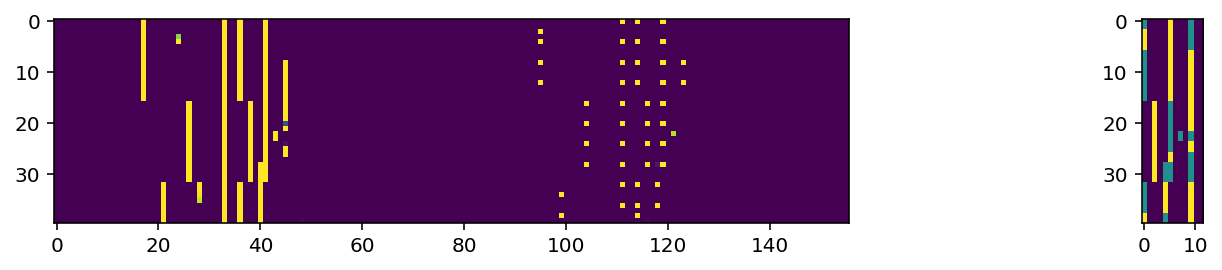

Iter: 348000
D_Loss: 0.0395
G_Loss: 8.002


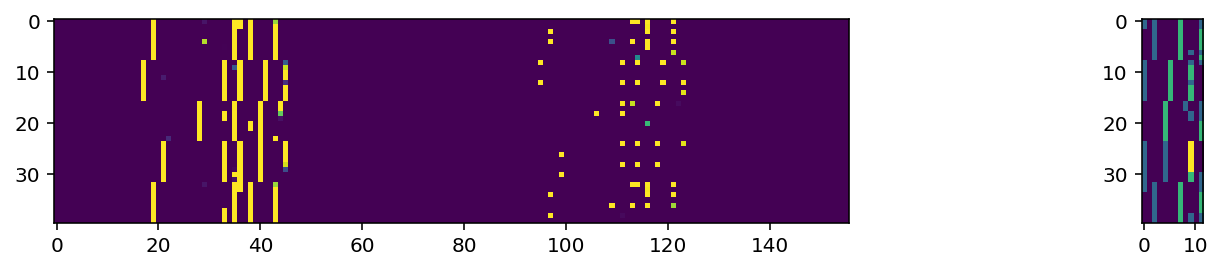

Iter: 349000
D_Loss: 0.4555
G_Loss: 5.963


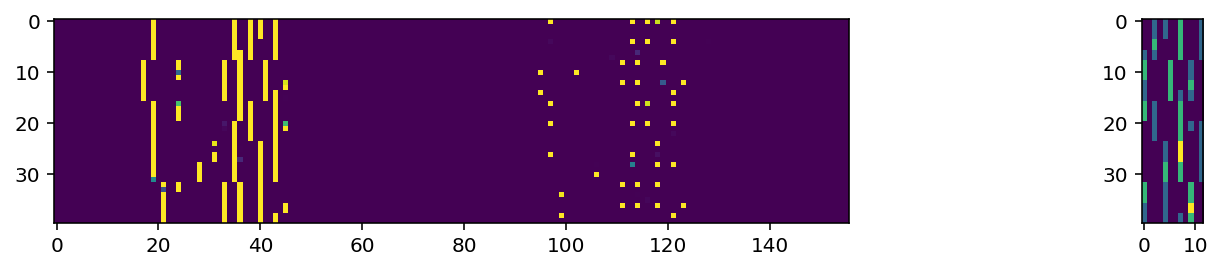

Iter: 350000
D_Loss: 0.6694
G_Loss: 2.697


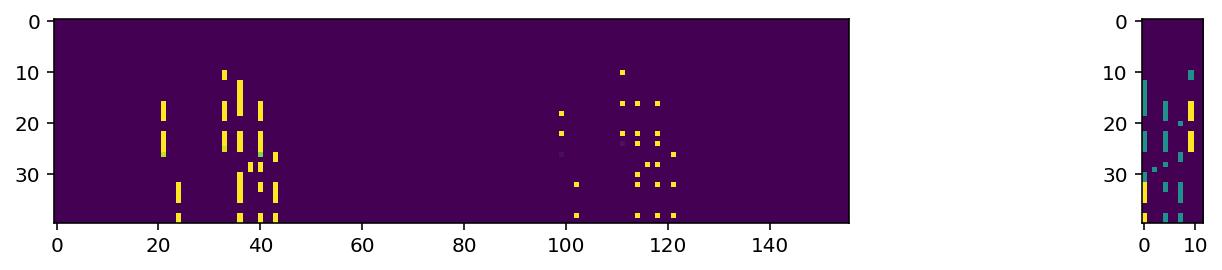

Iter: 351000
D_Loss: 1.034
G_Loss: 1.968


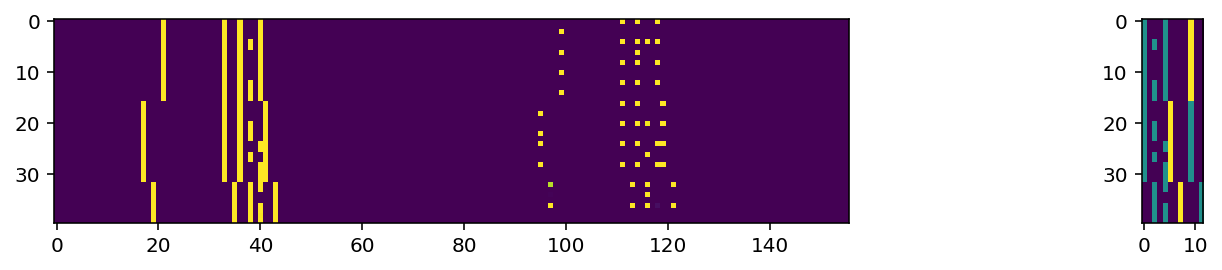

Iter: 352000
D_Loss: 0.01654
G_Loss: 9.345


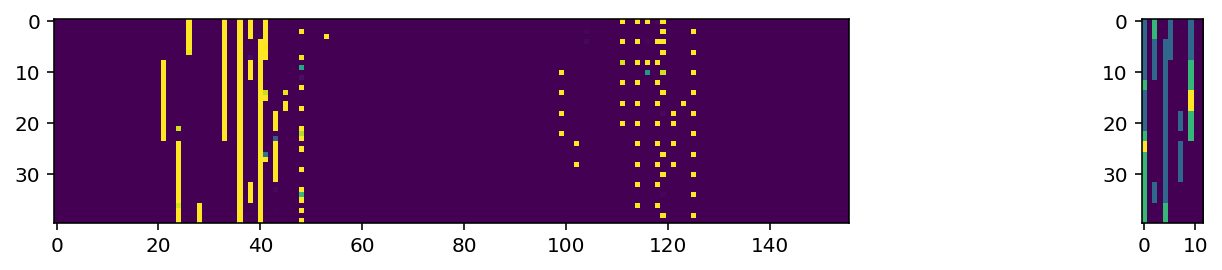

Iter: 353000
D_Loss: 0.03526
G_Loss: 7.28


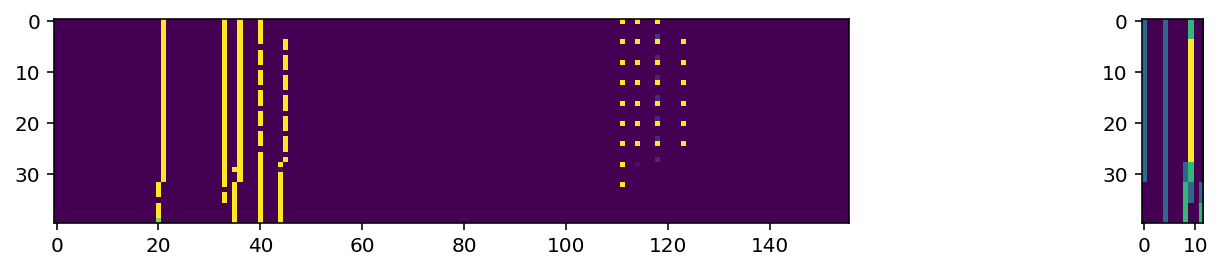

Iter: 354000
D_Loss: 1.932
G_Loss: 1.45


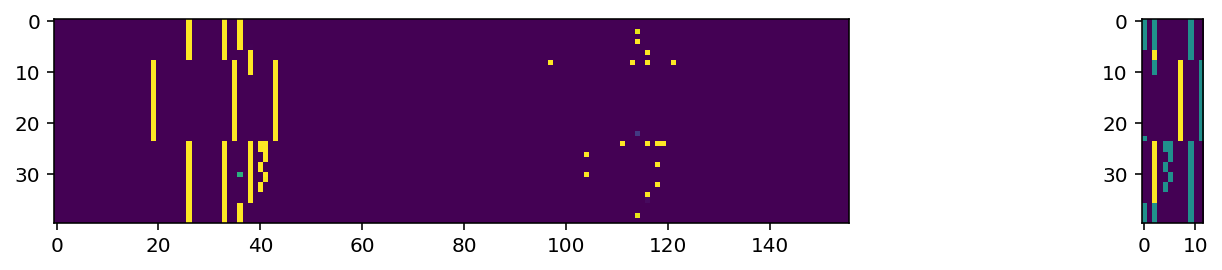

Iter: 355000
D_Loss: 0.2581
G_Loss: 2.818


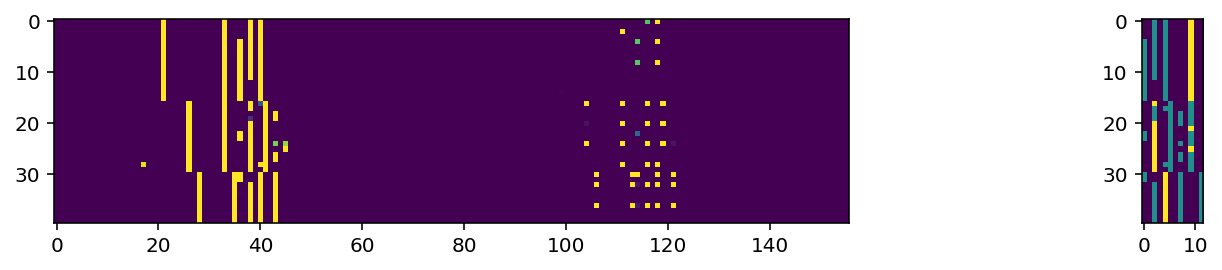

Iter: 356000
D_Loss: 0.7318
G_Loss: 5.126


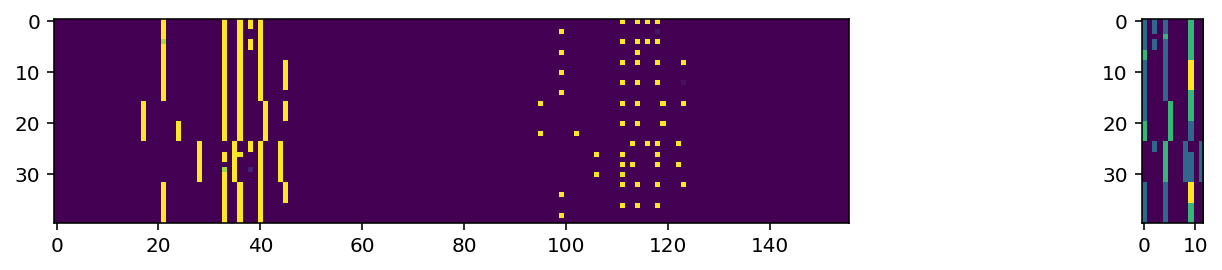

Iter: 357000
D_Loss: 0.005142
G_Loss: 8.201


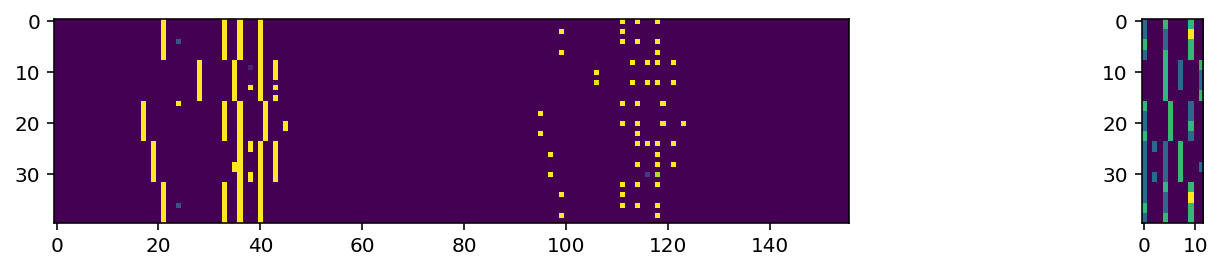

Iter: 358000
D_Loss: 0.7497
G_Loss: 2.689


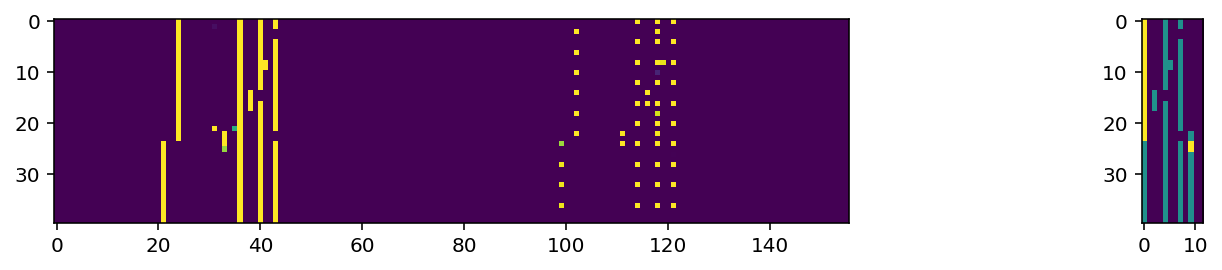

Iter: 359000
D_Loss: 1.237
G_Loss: 1.002


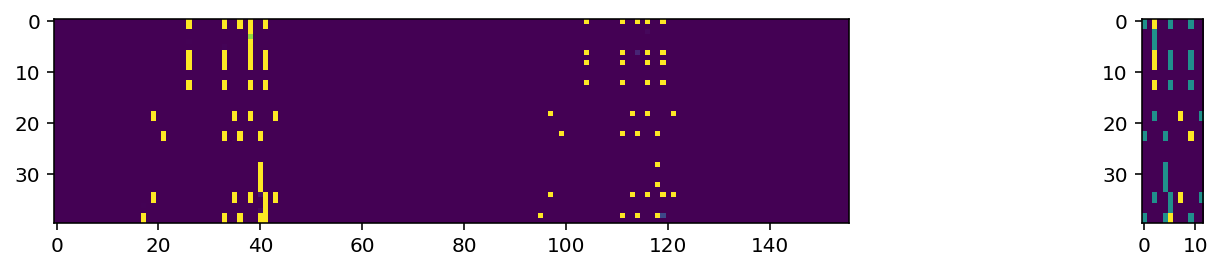

Iter: 360000
D_Loss: 0.499
G_Loss: 4.347


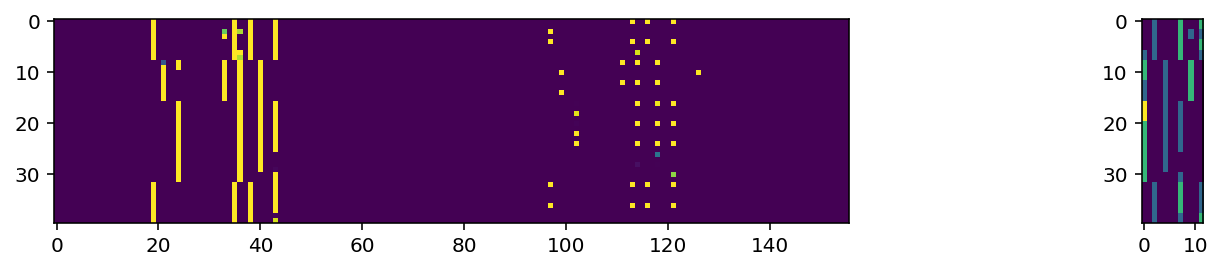

Iter: 361000
D_Loss: 1.019
G_Loss: 1.243


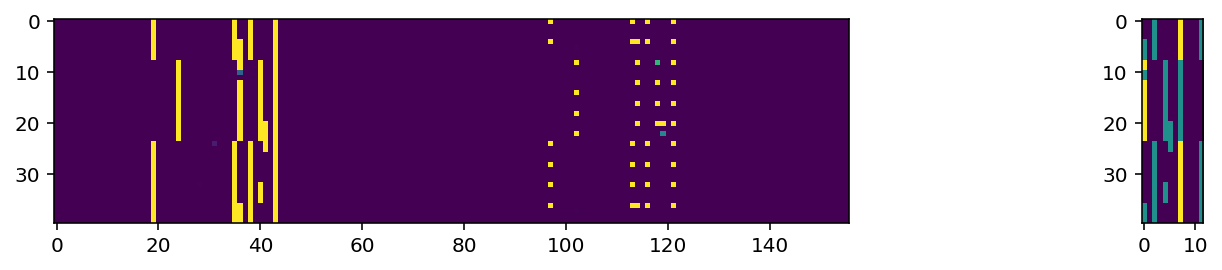

Iter: 362000
D_Loss: 0.02454
G_Loss: 8.219


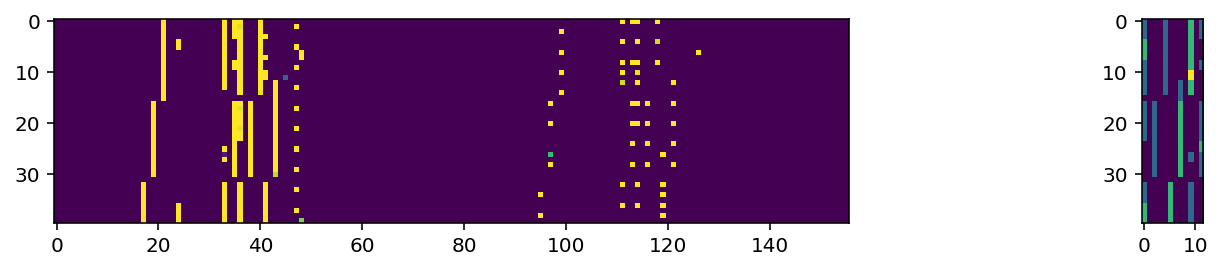

Iter: 363000
D_Loss: 1.815
G_Loss: 1.767


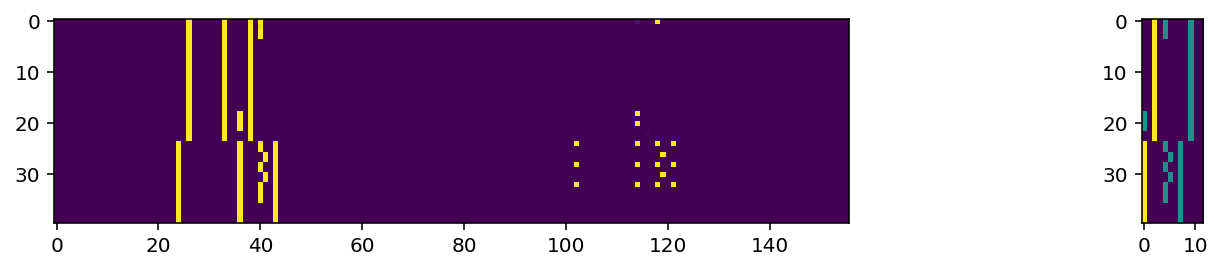

Iter: 364000
D_Loss: 0.9344
G_Loss: 1.651


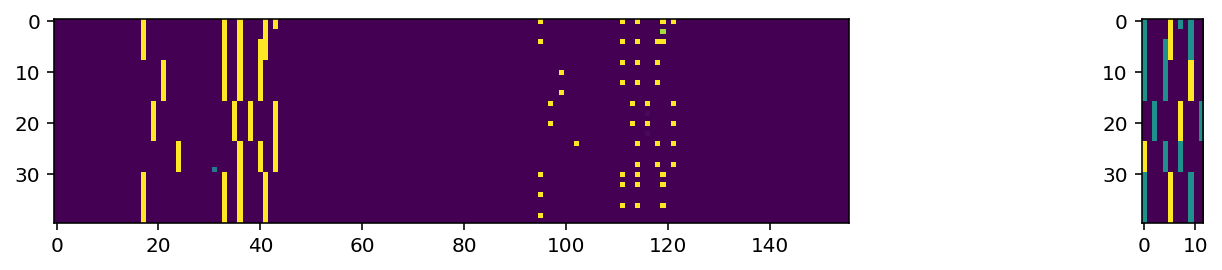

Iter: 365000
D_Loss: 0.1071
G_Loss: 7.609


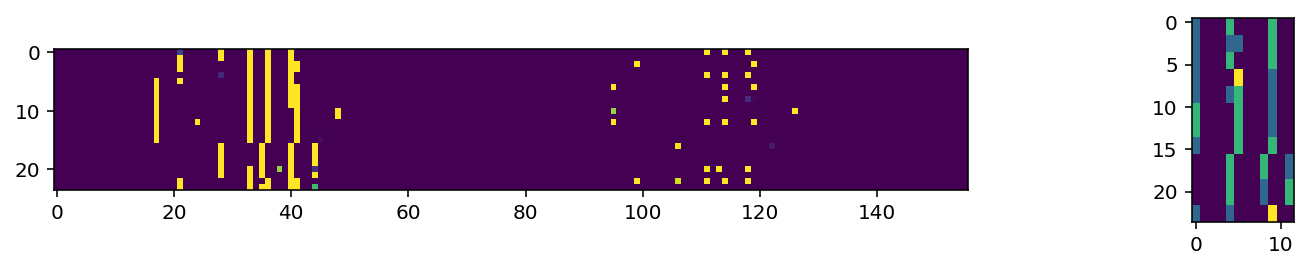

Iter: 366000
D_Loss: 0.3618
G_Loss: 5.44


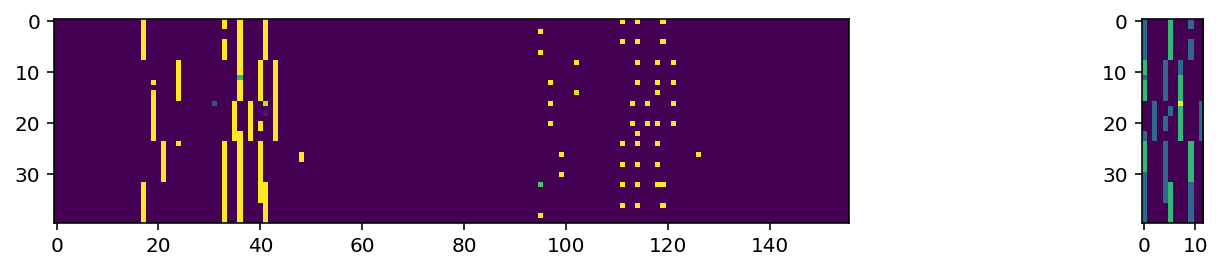

Iter: 367000
D_Loss: 0.677
G_Loss: 2.16


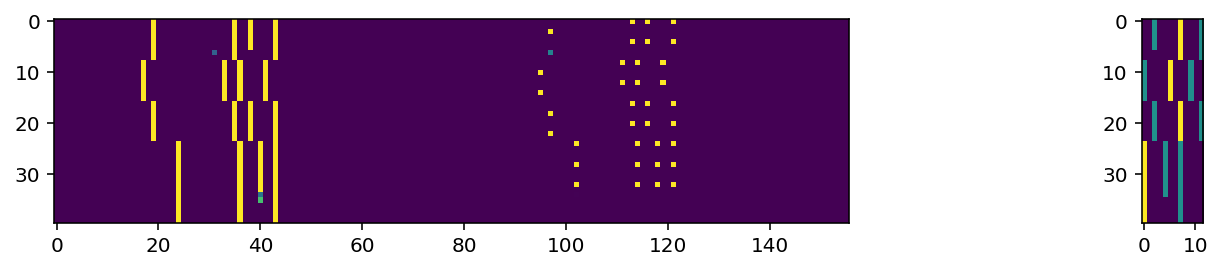

Iter: 368000
D_Loss: 0.0375
G_Loss: 6.733


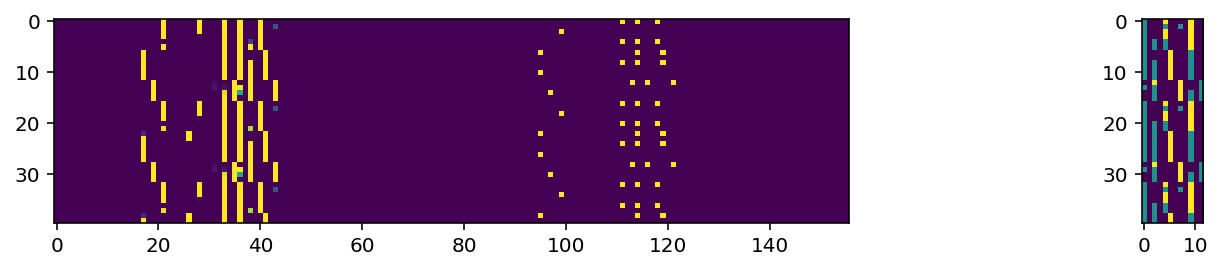

Iter: 369000
D_Loss: 1.469
G_Loss: 2.692


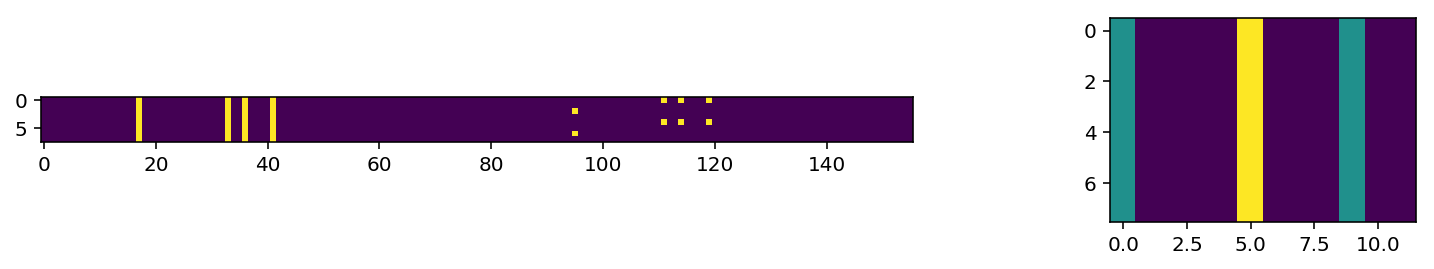

Iter: 370000
D_Loss: 1.092
G_Loss: 2.95


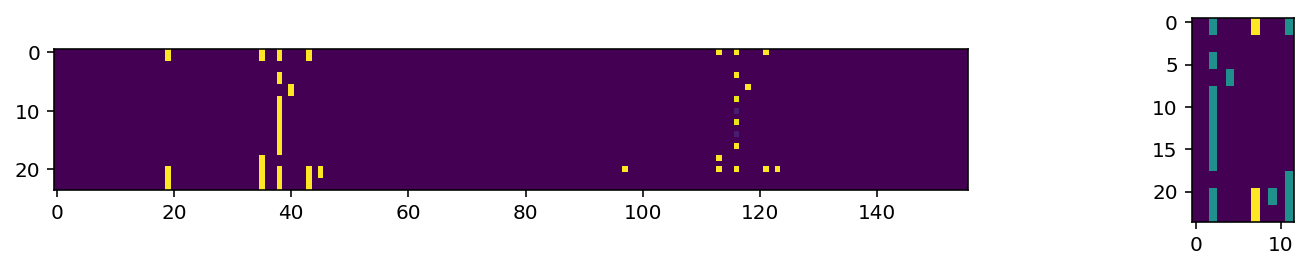

Iter: 371000
D_Loss: 0.3518
G_Loss: 6.129


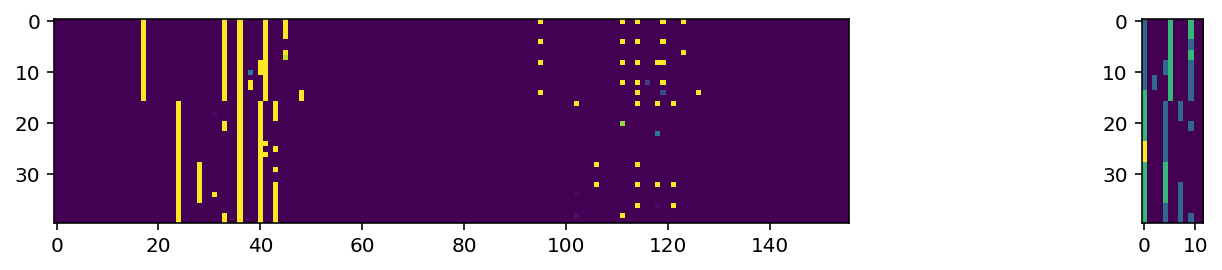

Iter: 372000
D_Loss: 0.5669
G_Loss: 4.898


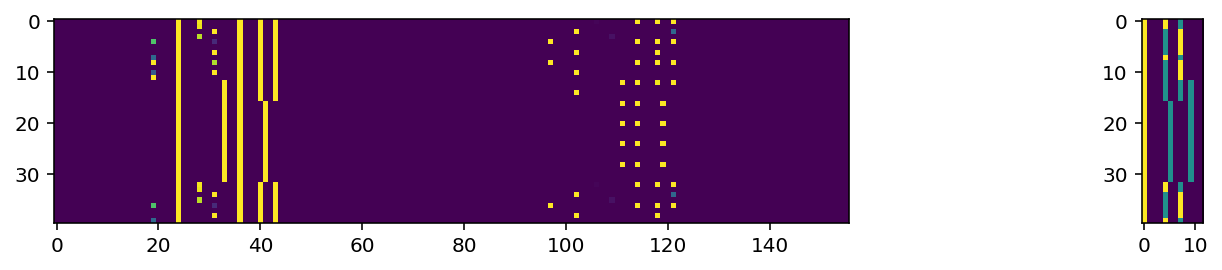

Iter: 373000
D_Loss: 0.05924
G_Loss: 6.589


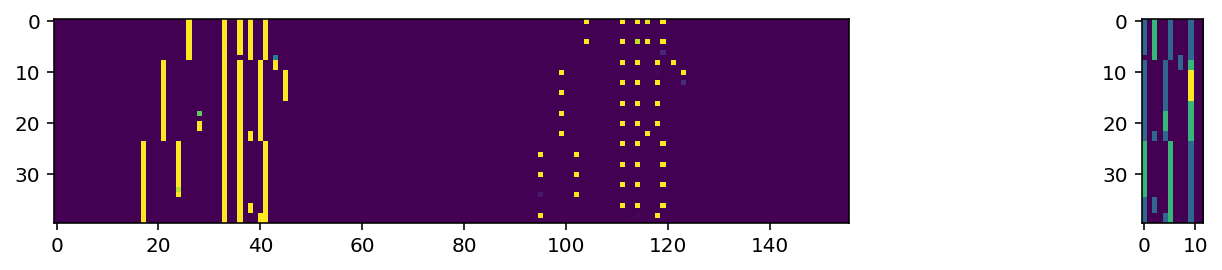

Iter: 374000
D_Loss: 0.6324
G_Loss: 3.575


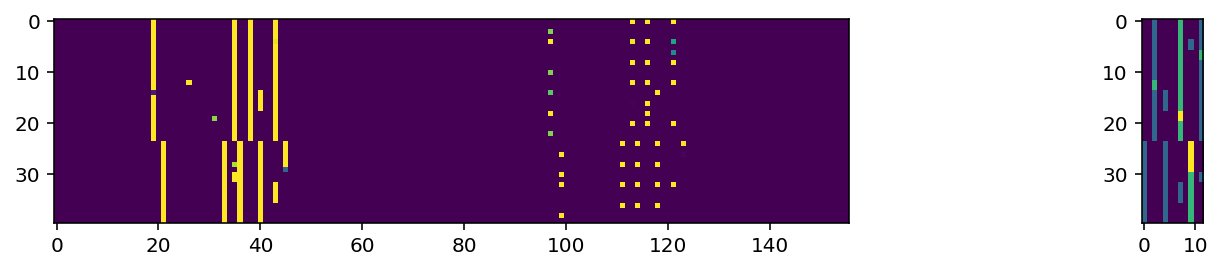

Iter: 375000
D_Loss: 1.921
G_Loss: 3.247


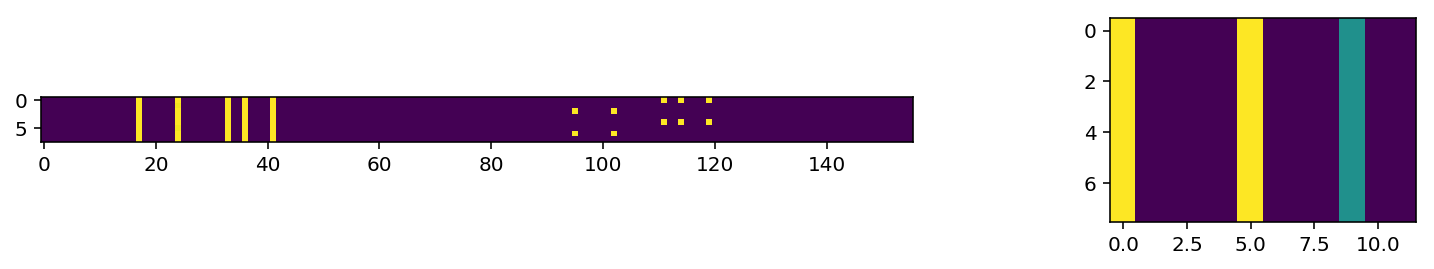

Iter: 376000
D_Loss: 0.8477
G_Loss: 3.698


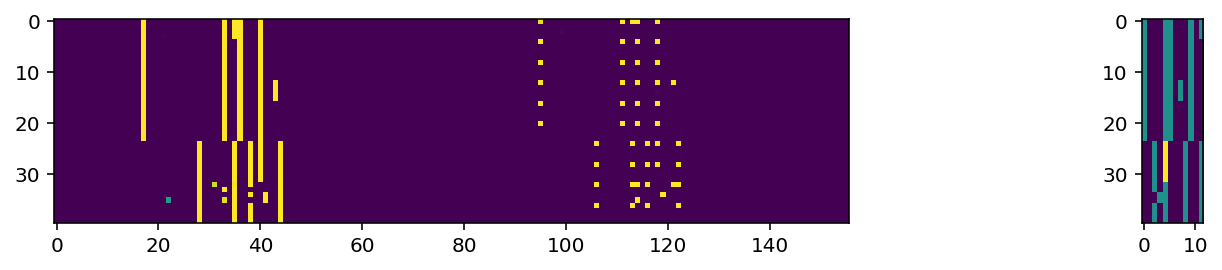

Iter: 377000
D_Loss: 0.05227
G_Loss: 20.35


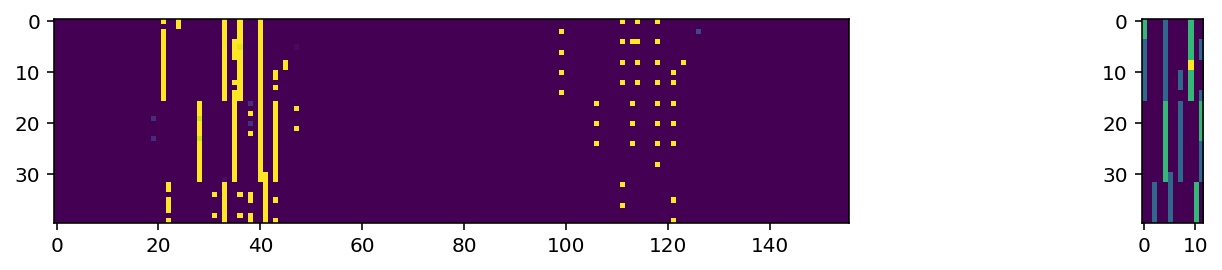

Iter: 378000
D_Loss: 0.2903
G_Loss: 6.387


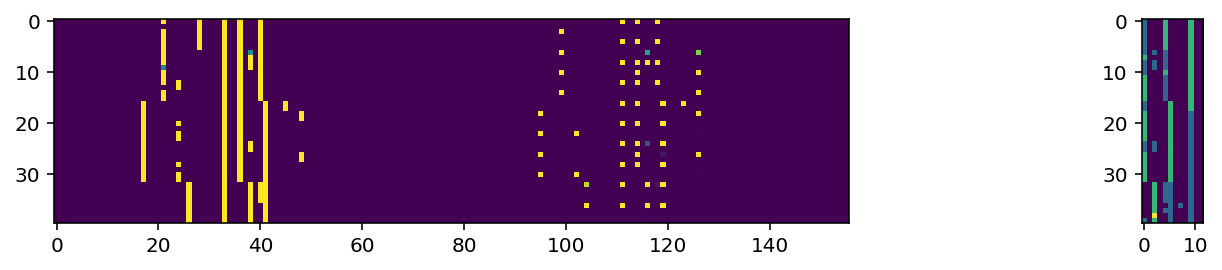

Iter: 379000
D_Loss: 0.0925
G_Loss: 7.287


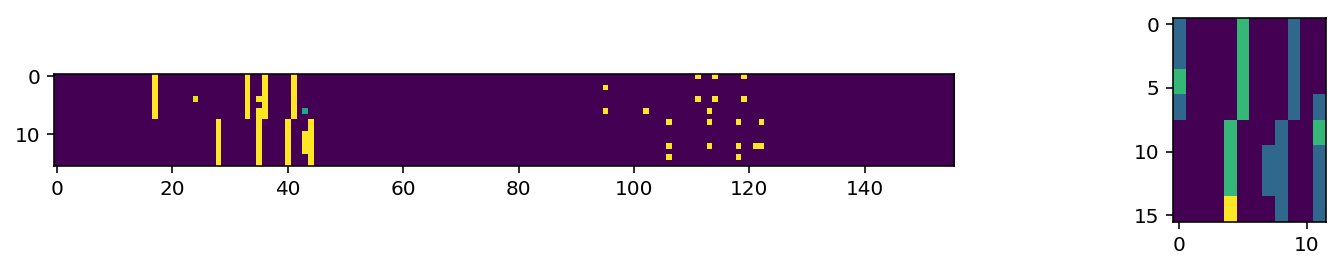

Iter: 380000
D_Loss: 0.4072
G_Loss: 4.16


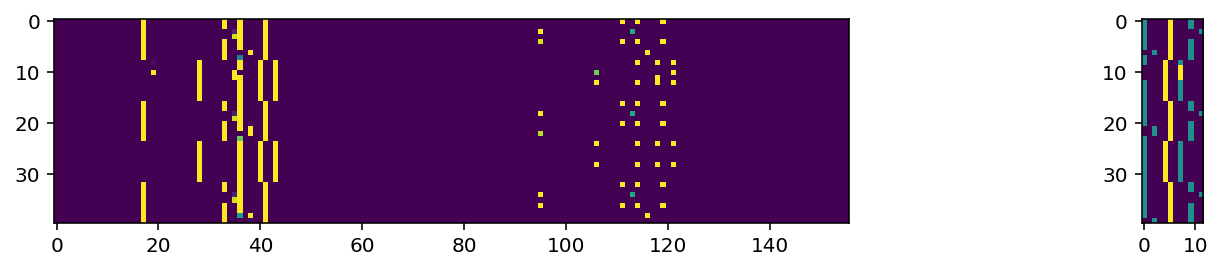

Iter: 381000
D_Loss: 0.0668
G_Loss: 4.069


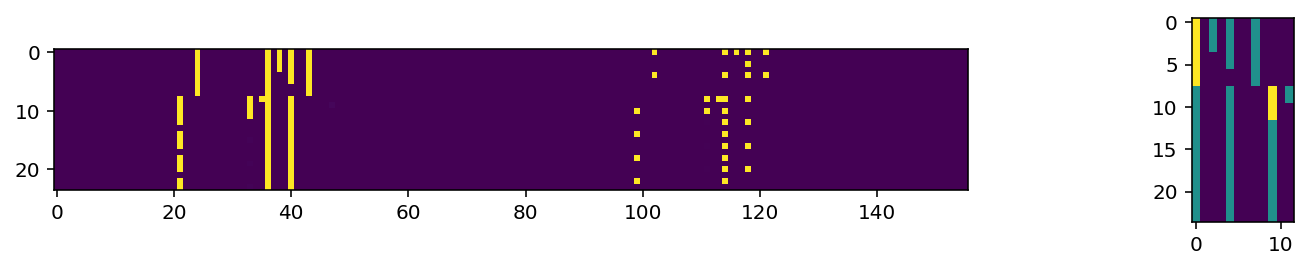

Iter: 382000
D_Loss: 1.076
G_Loss: 1.93


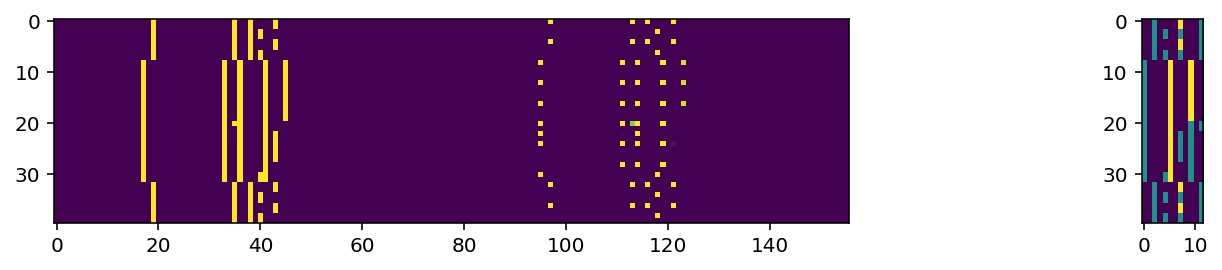

Iter: 383000
D_Loss: 0.2001
G_Loss: 4.415


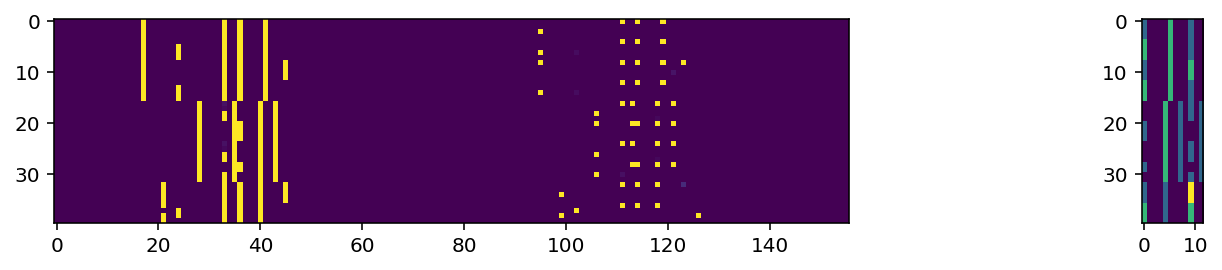

Iter: 384000
D_Loss: 0.8982
G_Loss: 2.794


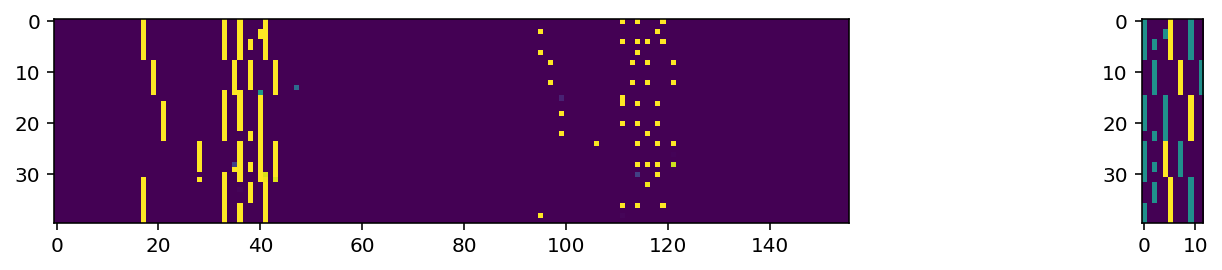

Iter: 385000
D_Loss: 0.581
G_Loss: 3.698


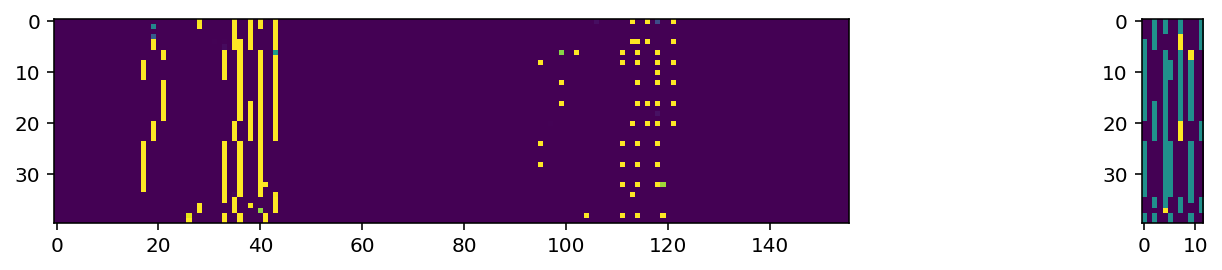

Iter: 386000
D_Loss: 0.5755
G_Loss: 2.321


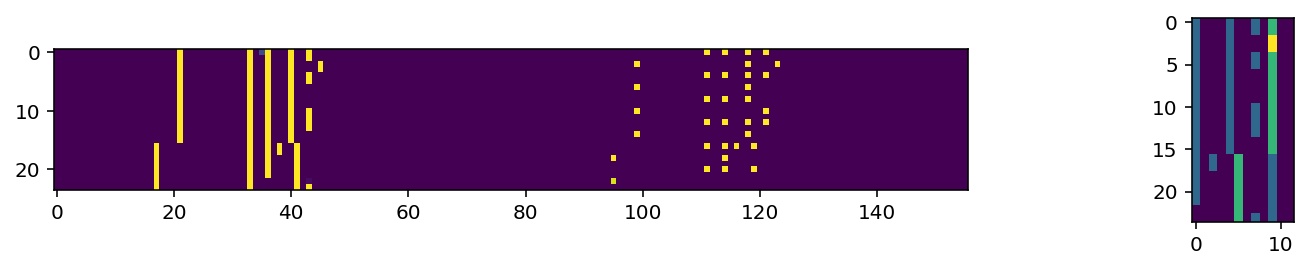

Iter: 387000
D_Loss: 0.9163
G_Loss: 1.8


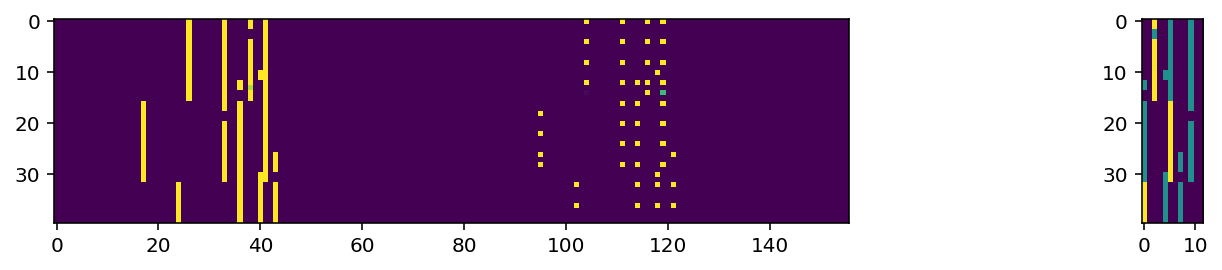

Iter: 388000
D_Loss: 0.3483
G_Loss: 3.996


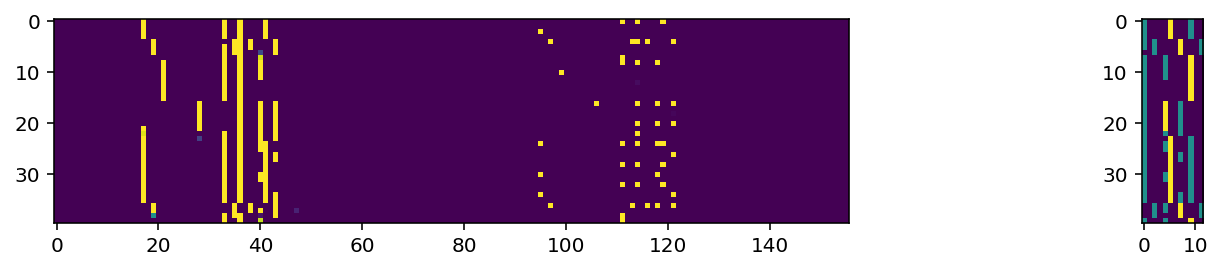

Iter: 389000
D_Loss: 0.1978
G_Loss: 5.412


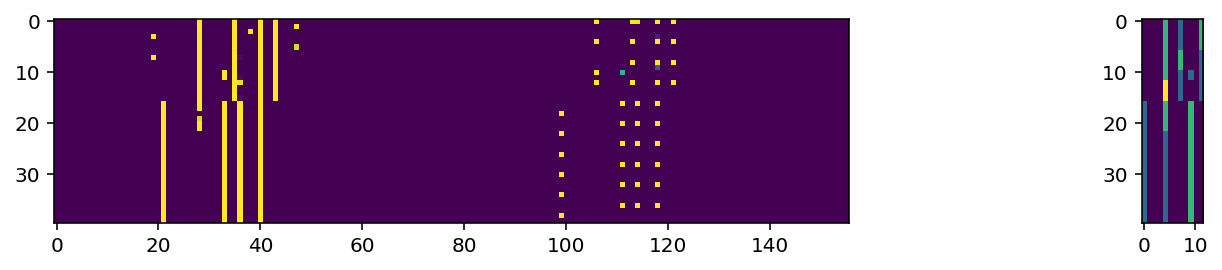

Iter: 390000
D_Loss: 0.1874
G_Loss: 6.556


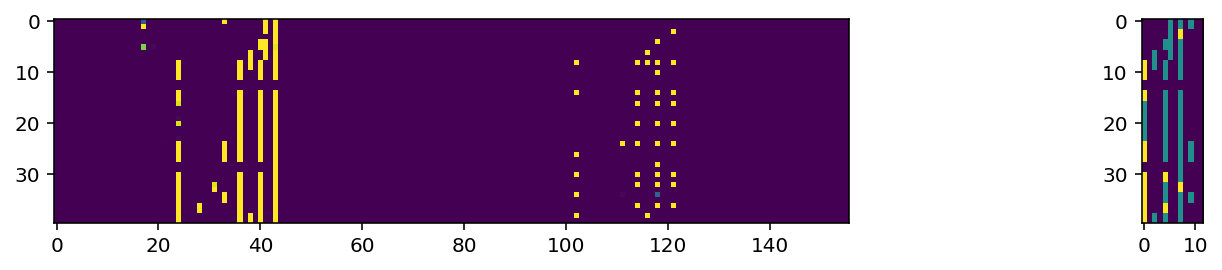

Iter: 391000
D_Loss: 0.5326
G_Loss: 2.071


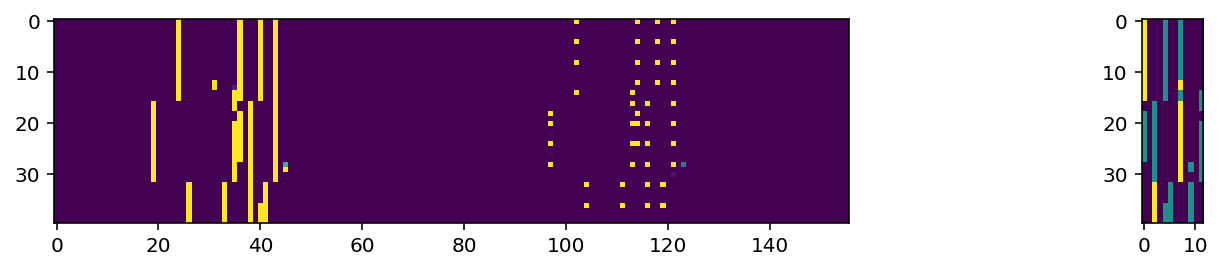

Iter: 392000
D_Loss: 0.9077
G_Loss: 2.536


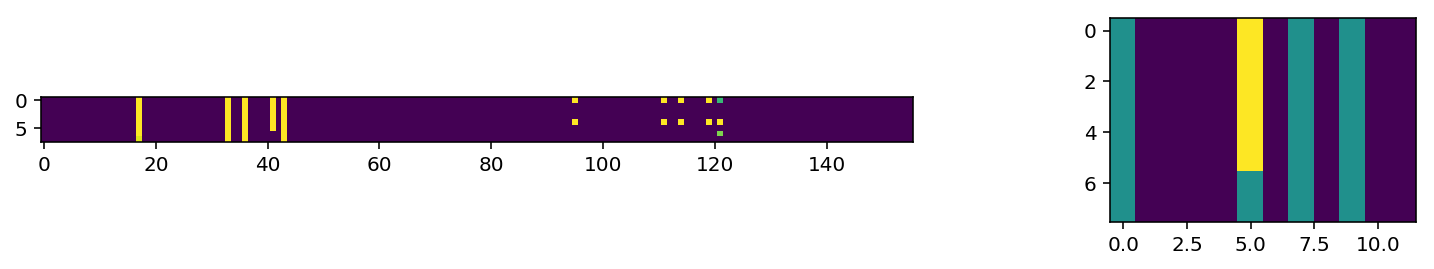

Iter: 393000
D_Loss: 0.2856
G_Loss: 4.081


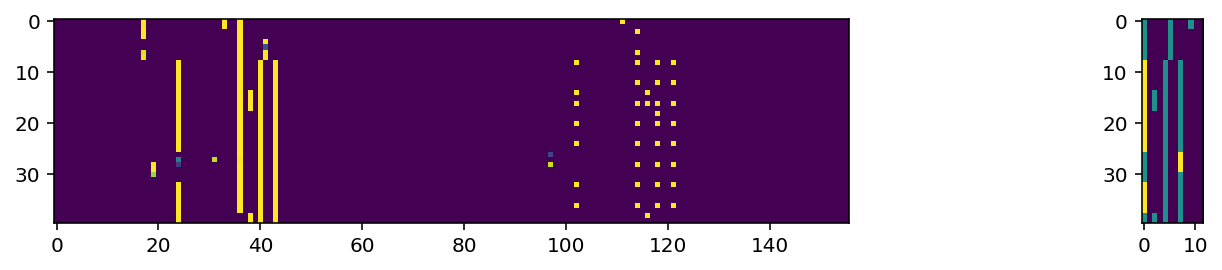

Iter: 394000
D_Loss: 0.6061
G_Loss: 2.119


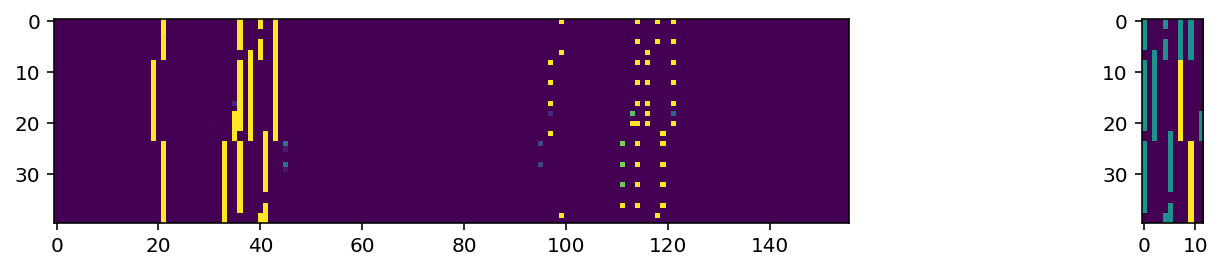

Iter: 395000
D_Loss: 1.092
G_Loss: 1.771


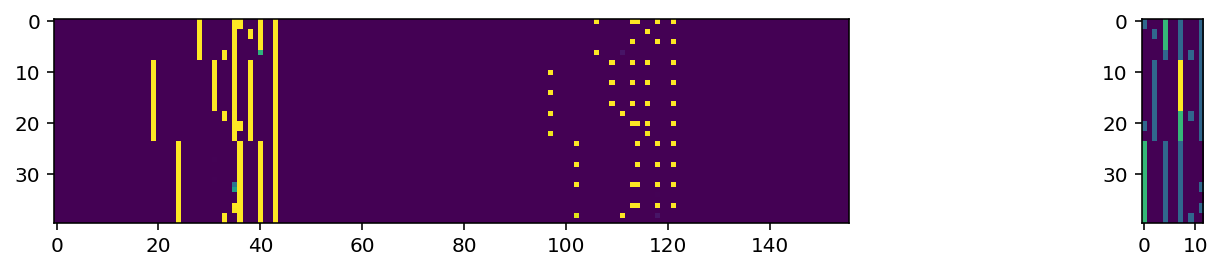

Iter: 396000
D_Loss: 0.6608
G_Loss: 2.735


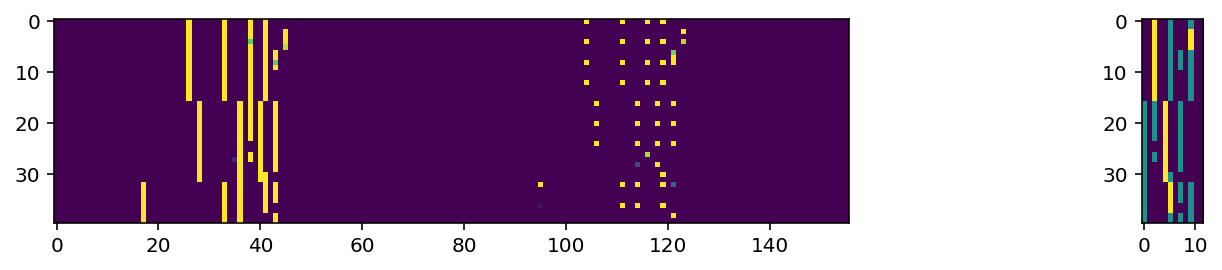

Iter: 397000
D_Loss: 0.4807
G_Loss: 3.496


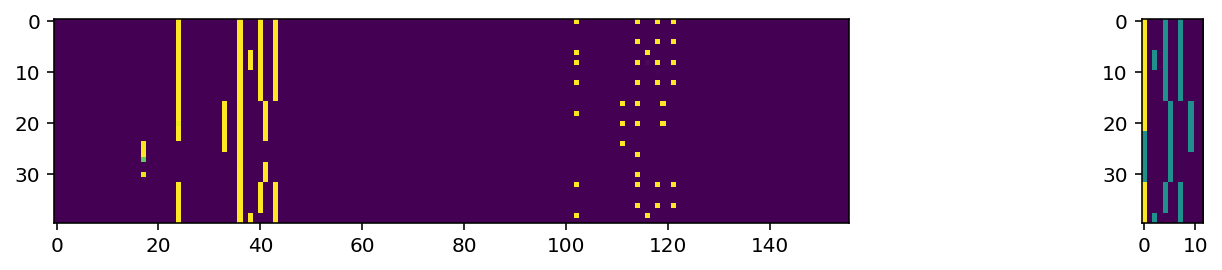

Iter: 398000
D_Loss: 0.0001261
G_Loss: 20.92


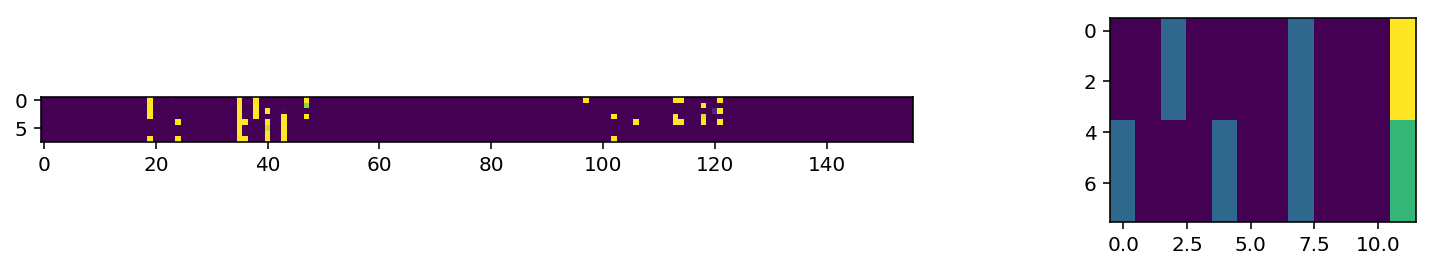

Iter: 399000
D_Loss: 0.0005696
G_Loss: 10.77


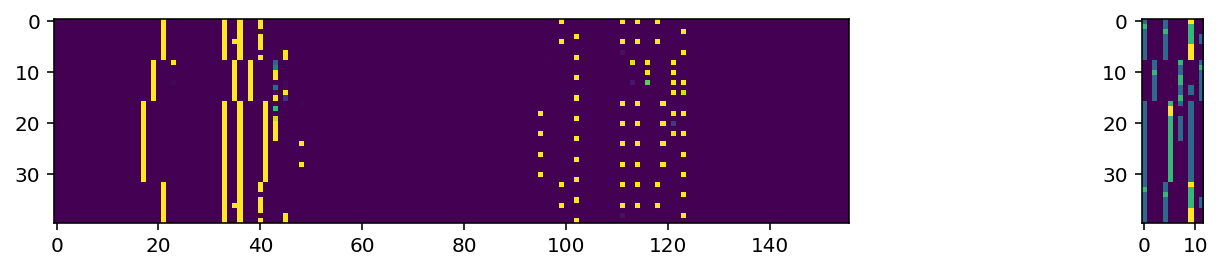

Iter: 400000
D_Loss: 0.0958
G_Loss: 13.58


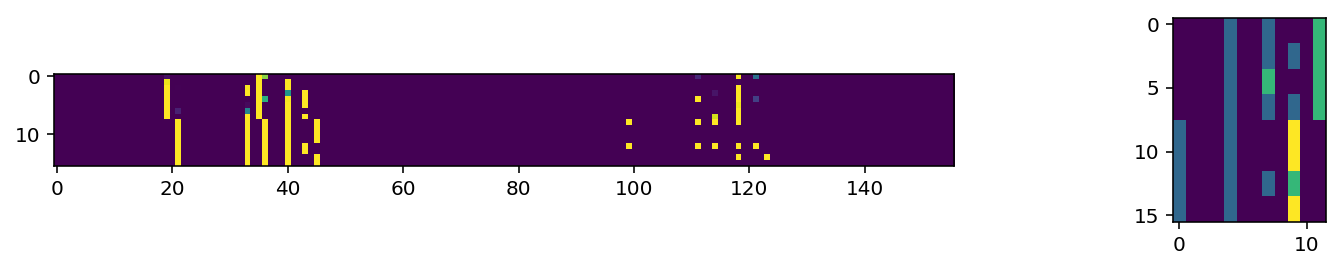

Iter: 401000
D_Loss: 0.5096
G_Loss: 3.506


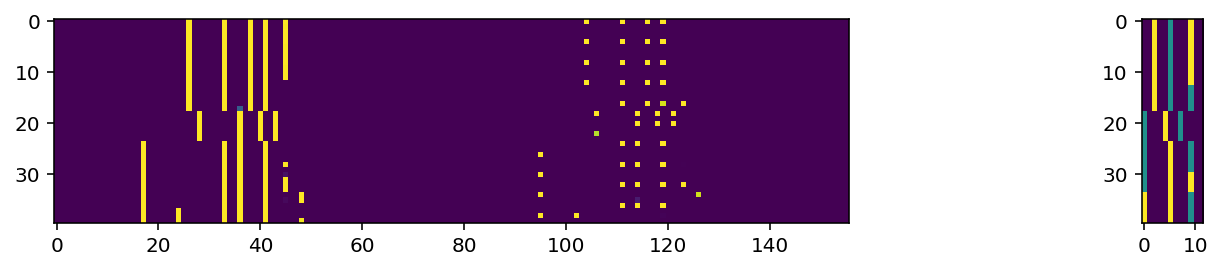

Iter: 402000
D_Loss: 0.7855
G_Loss: 1.297


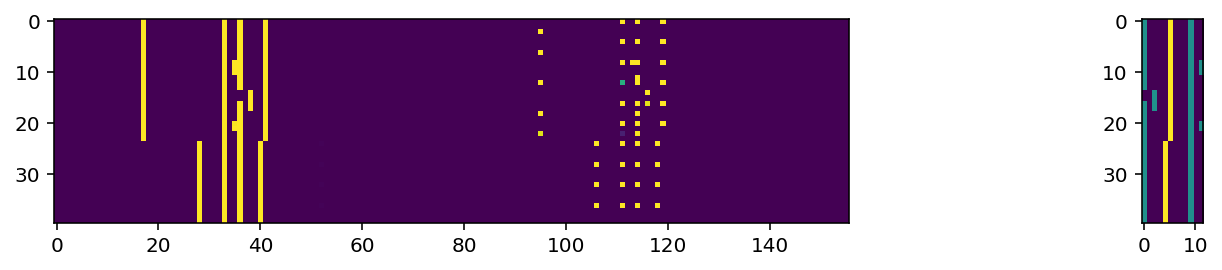

Iter: 403000
D_Loss: 0.6775
G_Loss: 2.621


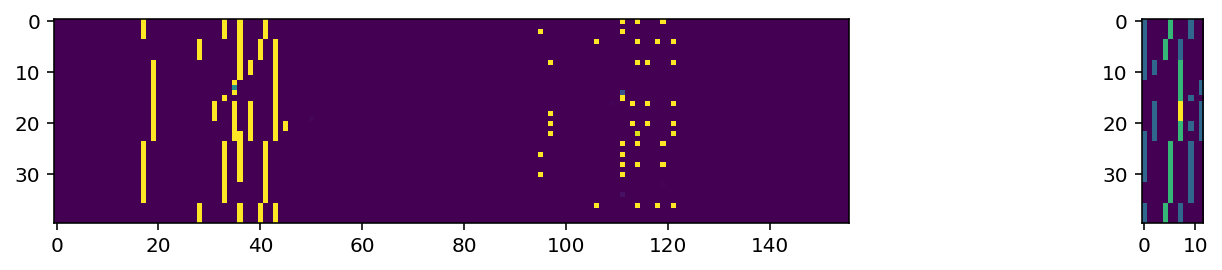

Iter: 404000
D_Loss: 0.02162
G_Loss: 6.598


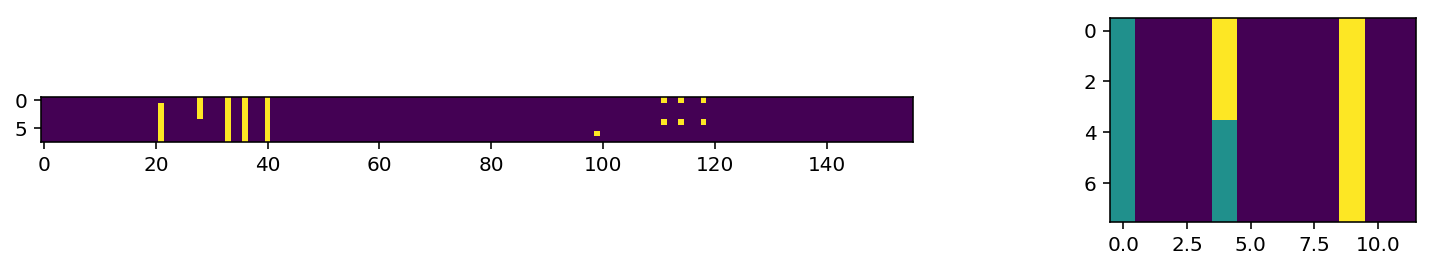

Iter: 405000
D_Loss: 0.6095
G_Loss: 3.448


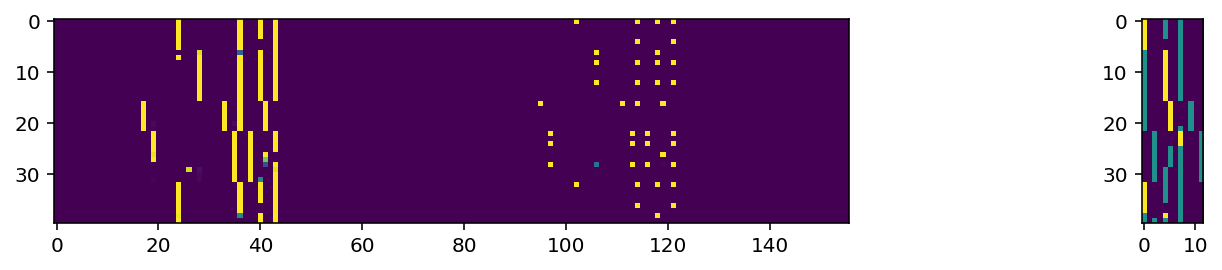

Iter: 406000
D_Loss: 0.7257
G_Loss: 2.905


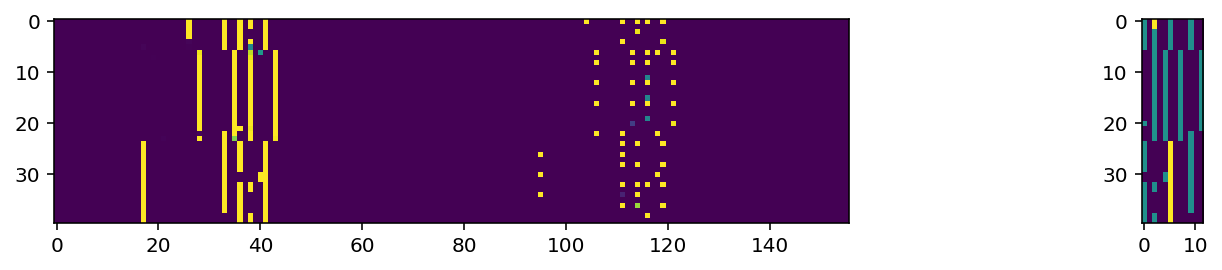

Iter: 407000
D_Loss: 0.3118
G_Loss: 5.372


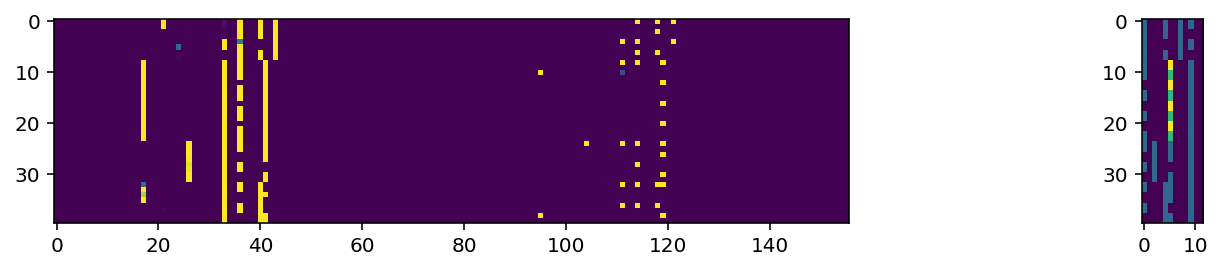

Iter: 408000
D_Loss: 0.02254
G_Loss: 5.269


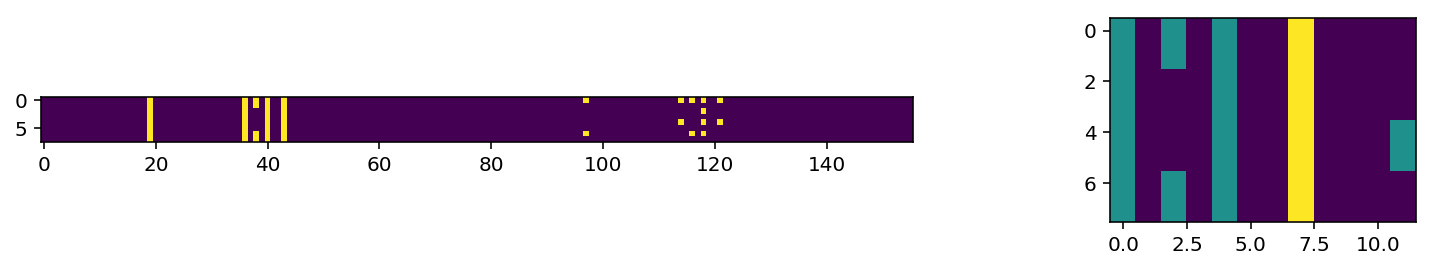

Iter: 409000
D_Loss: 0.8965
G_Loss: 1.742


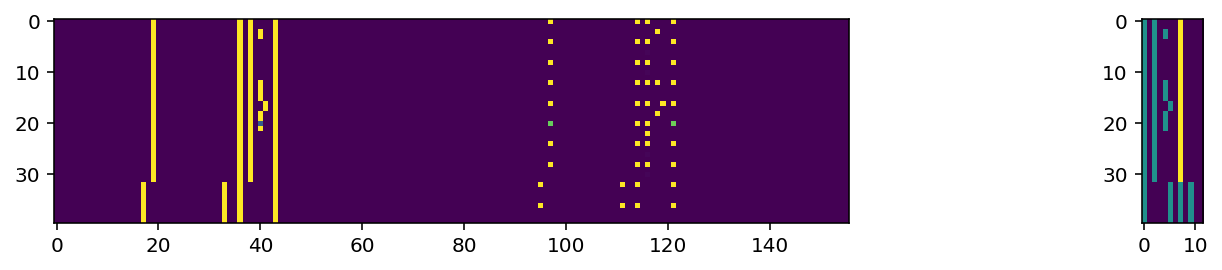

Iter: 410000
D_Loss: 1.172
G_Loss: 1.07


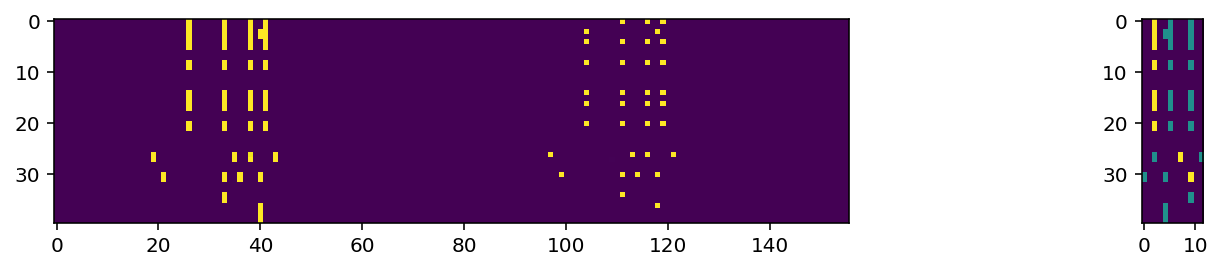

Iter: 411000
D_Loss: 0.07046
G_Loss: 6.622


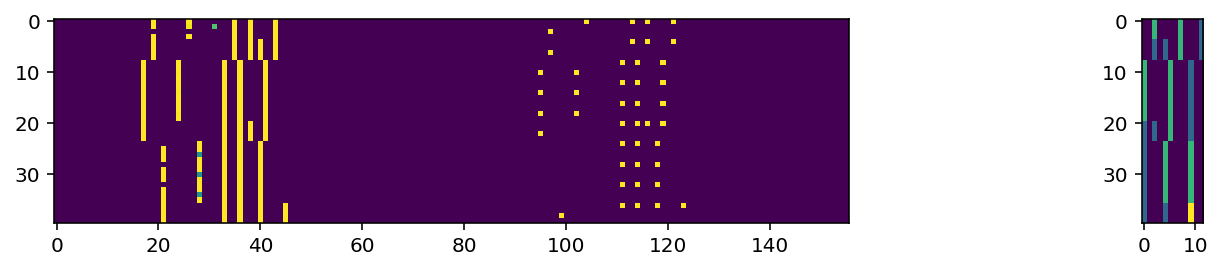

Iter: 412000
D_Loss: 1.471
G_Loss: 2.512


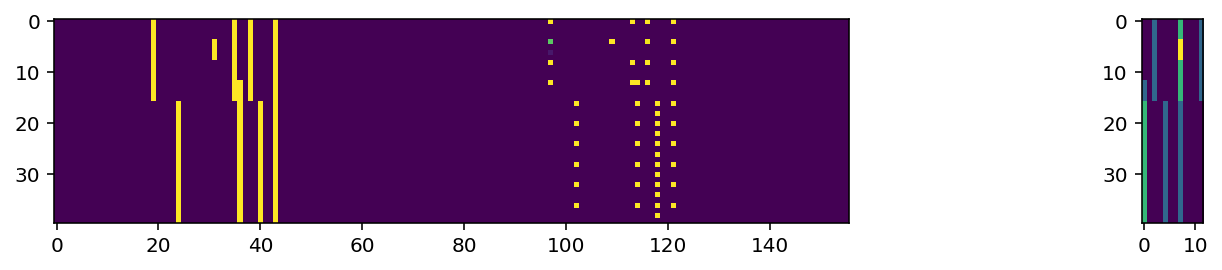

Iter: 413000
D_Loss: 0.1214
G_Loss: 5.475


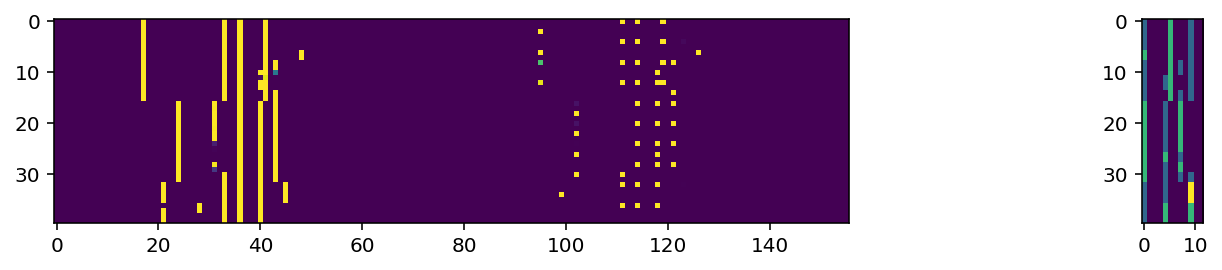

Iter: 414000
D_Loss: 1.019
G_Loss: 1.433


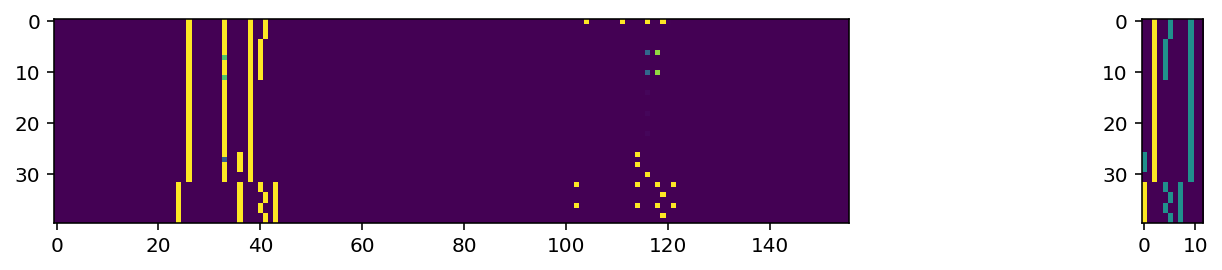

Iter: 415000
D_Loss: 0.7389
G_Loss: 1.762


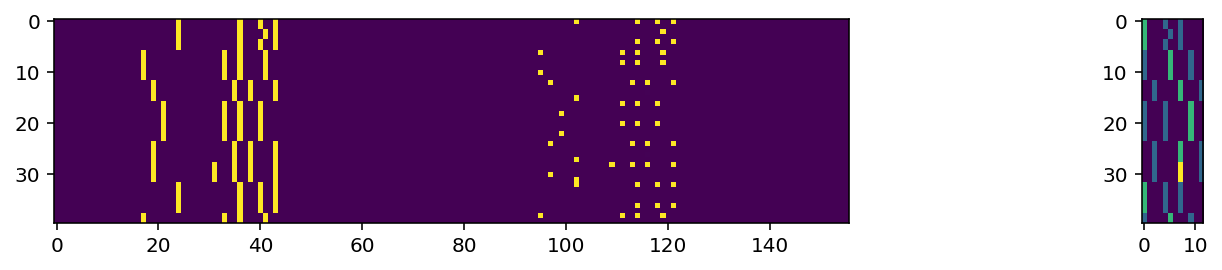

Iter: 416000
D_Loss: 1.025
G_Loss: 0.937


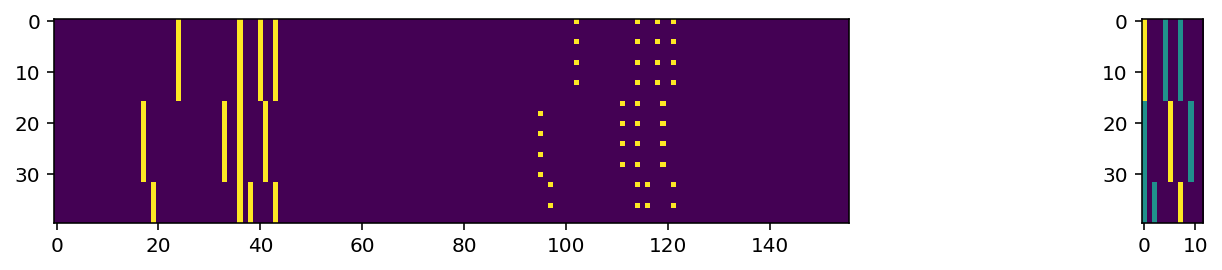

Iter: 417000
D_Loss: 0.1889
G_Loss: 7.961


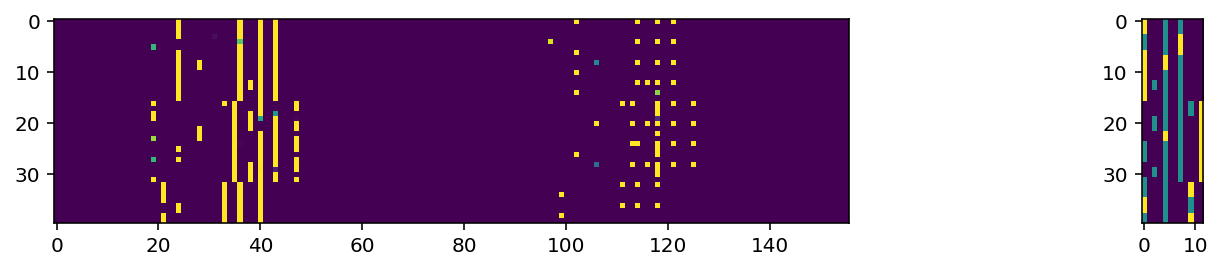

Iter: 418000
D_Loss: 0.6649
G_Loss: 7.07


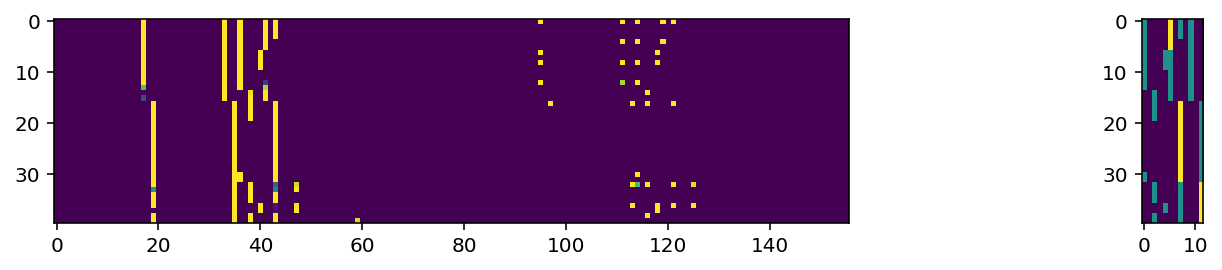

Iter: 419000
D_Loss: 0.02821
G_Loss: 5.41


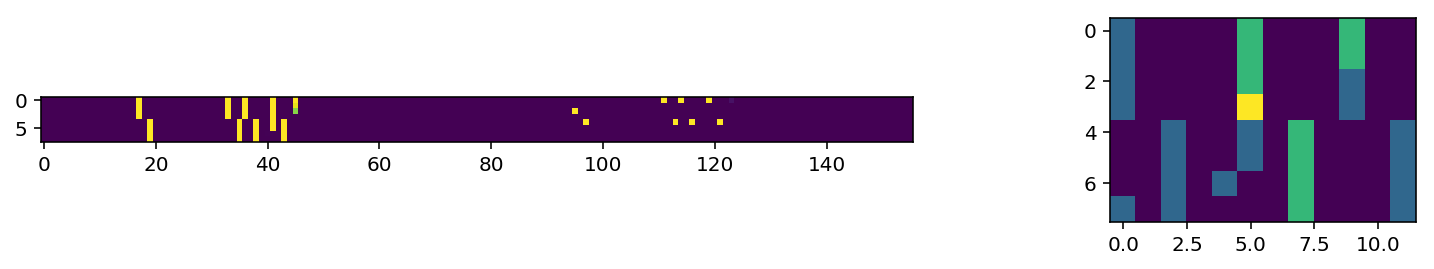

Iter: 420000
D_Loss: 0.706
G_Loss: 2.487


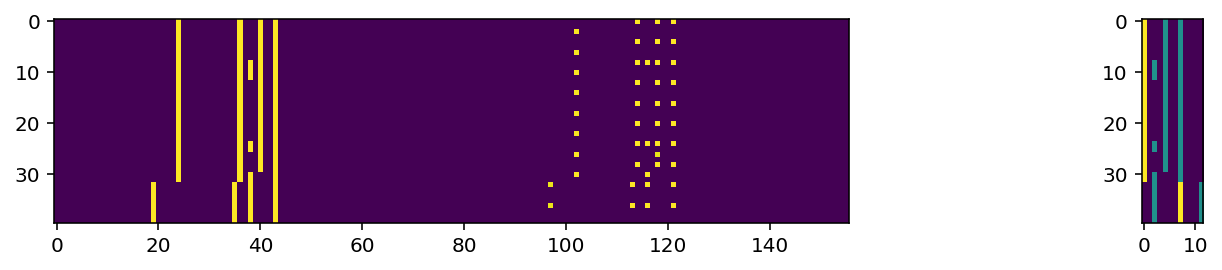

Iter: 421000
D_Loss: 0.5785
G_Loss: 8.4


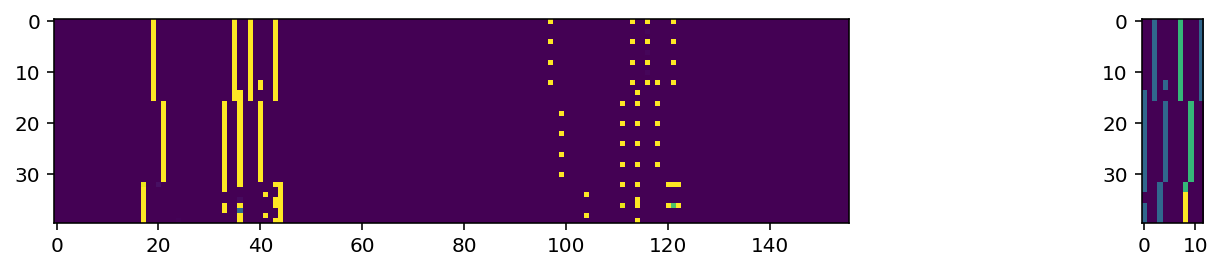

Iter: 422000
D_Loss: 1.369
G_Loss: 1.498


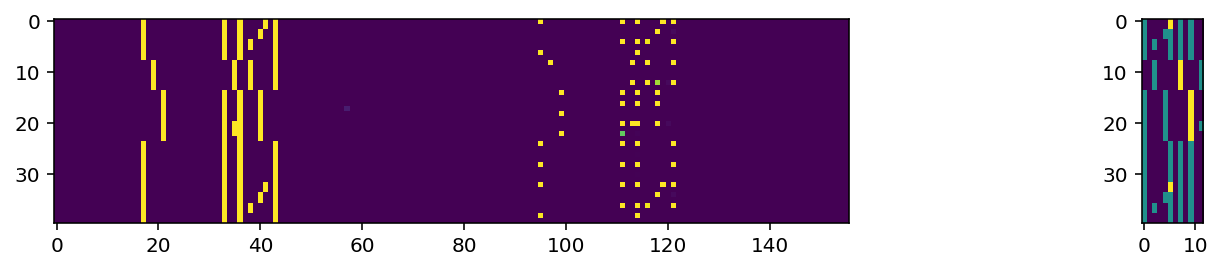

Iter: 423000
D_Loss: 0.9571
G_Loss: 1.508


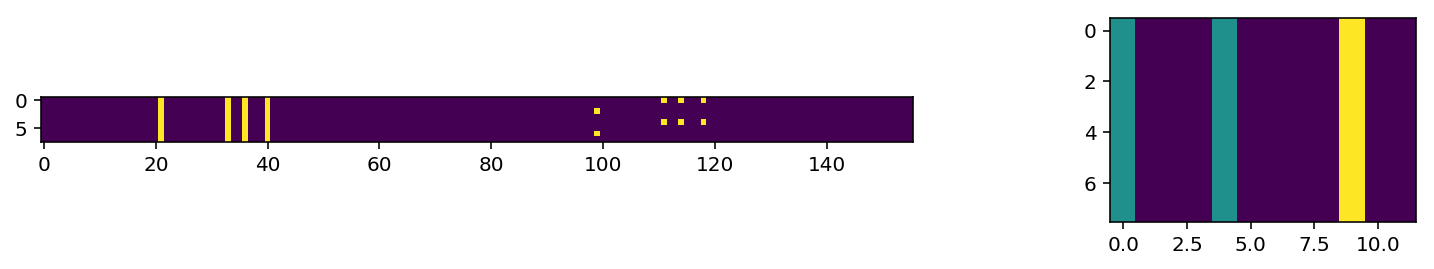

Iter: 424000
D_Loss: 0.03644
G_Loss: 7.404


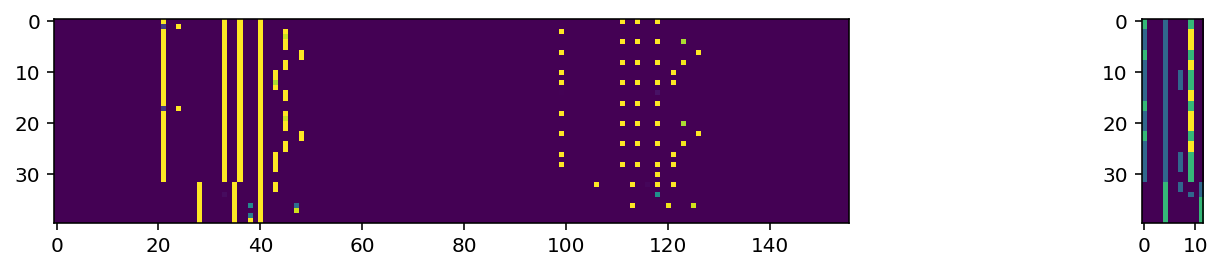

Iter: 425000
D_Loss: 0.3739
G_Loss: 5.132


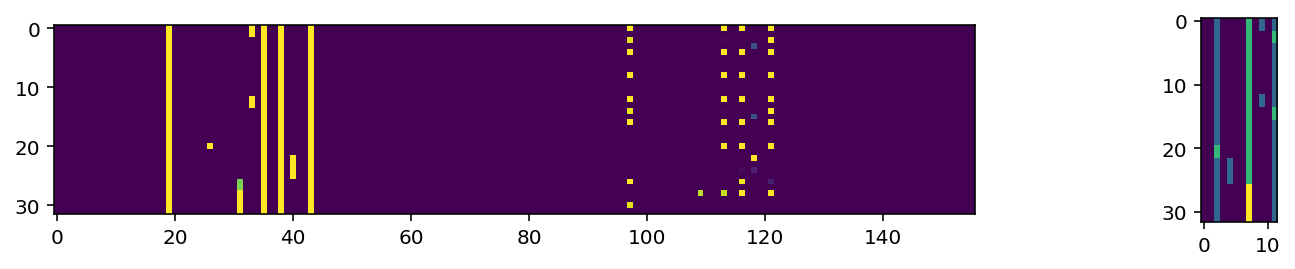

In [ ]:
i = 0
num_epochs = 1000000
batch_size = 10

while i <= num_epochs:
    for song, chroma in zip(songs, chromas):
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
       
        song = np.array(song)     
        #print(i, np.shape(song))
        
        song_steps = np.floor(song.shape[0]/num_timesteps).astype(int)
        song = song[:song_steps*num_timesteps]
        #print(i, np.shape(song))

        song = np.reshape(song, [song_steps, song.shape[1]*num_timesteps])
        #print(i, np.shape(song))
        
        chroma = np.array(chroma)
        #print(i, np.shape(chroma))

        #chroma = chroma[:np.floor(chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
        chroma = chroma[:song_steps*num_timesteps]
        #print(i, np.shape(song))
 
        #chroma = np.reshape(chroma, [int(chroma.shape[0]/num_timesteps), chroma.shape[1]*num_timesteps])
        chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])
        #print(i, np.shape(song))
       
        #print(i, len(song), batch_size)
                    
        batch_size = min(batch_size,len(song))

        # Train the RBM on batch_size examples at a time
        for ind in range(0, len(song), batch_size): 
            X_mb = song[ind:ind+batch_size]
            ch = chroma[ind:ind+batch_size]
#            _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: ch})
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: ch})
    
            if i % 1000 == 0:
                print('Iter: {}'.format(i))
                print('D_Loss: {:.4}'. format(D_loss_curr))
                print('G_Loss: {:.4}'. format(G_loss_curr))

#             samples = sess.run(X_samples, feed_dict={z: np.random.randn(1,z_dim)})
                samples = sess.run(G_sample, feed_dict={Z: ch})
#                 print(np.shape(samples), np.shape(ch))
        
                S = np.reshape(samples, (ch.shape[0]*num_timesteps, 2*note_range))
                thresh_S = S>=0.5
                plt.figure(figsize=(12,2))
                plt.subplot(1,2,1)
                plt.imshow(S)
                plt.subplot(1,2,2)
                #plt.imshow(thresh_S)
                C = np.reshape(ch, (ch.shape[0]*num_timesteps, 12))
                plt.imshow(C)
                plt.tight_layout()
                plt.pause(0.1)
                midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_{}".format(i))
#                 print(i)
            i += 1

In [ ]:
print(np.shape(chromas[1]))

In [ ]:
test_song = get_songs('test')
test_chroma = get_chromas(test_song)[1]

In [ ]:
#here should come a chroma from a new song: read a new file, extract chroma and plug into generator
#Since we do not have yet a new song, let's just reuse existing chroma
# test_chroma = test_chroma[:np.floor(test_chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
# test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0]/num_timesteps), test_chroma.shape[1]*num_timesteps])

test_chroma = np.array(test_chroma)
print(i, np.shape(test_chroma))
    

test_chroma = test_chroma[:np.floor(test_chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0]/num_timesteps), test_chroma.shape[1]*num_timesteps])
#chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])
       
out_samples = sess.run(G_sample, feed_dict={Z: test_chroma})
print(np.shape(test_chroma),np.shape(samples))

In [ ]:
print(np.floor(samples.shape[0]*samples.shape[1]/2/note_range).astype(int))

In [ ]:
S = np.reshape(out_samples, (np.floor(out_samples.shape[0]*out_samples.shape[1]/2/note_range).astype(int), 2*note_range))
C = np.reshape(test_chroma, (test_chroma.shape[0]*num_timesteps, 12))
print(np.shape(S), np.shape(C))
thresh_S = S>=0.5
plt.figure(figsize=(30,18))
plt.subplot(1,2,1)
plt.imshow(S)
plt.subplot(1,2,2)
plt.imshow(C)
#plt.tight_layout()
plt.pause(0.1)
midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/canon")
#  print(i)